In [6]:
import sys
import pandas as pd
import numpy as np
from os import path

# 读取事先存放好的Training data
data=pd.read_csv(path.abspath('./dataset/train.csv'),encoding='big5')
data

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/doc/course/sml/LeeML/Practice/dataset/train.csv'

In [2]:
# 我们只需要第三列以后的data
data = data.iloc[:,3:]
# 将NR的数据全部置为0
data[data == 'NR'] = 0
# 将dataframe幻化成numpy
raw_data = data.to_numpy()

#查看raw_data
raw_data

/home/gehao/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/gehao/anaconda3/envs/ml/lib/python3.6/site-packages/pandas/core/frame.py:3530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


array([['14', '14', '14', ..., '15', '15', '15'],
       ['1.8', '1.8', '1.8', ..., '1.8', '1.8', '1.8'],
       ['0.51', '0.41', '0.39', ..., '0.35', '0.36', '0.32'],
       ...,
       ['36', '55', '72', ..., '118', '100', '105'],
       ['1.9', '2.4', '1.9', ..., '1.5', '2', '2'],
       ['0.7', '0.8', '1.8', ..., '1.6', '1.8', '2']], dtype=object)

In [3]:
# 现在要开始处理Training data
# 由于提供的数据是每个月前20天(每天24小时)的资料(共18种类型)，因此每个月的这20*24=480个小时的时间是连续的，每10个小时可以作为一笔data，480小时共471笔data
# 由于不同月份之间的时间是不连续的，因此先把所有的资料按照月份分开
month_data = {}
for month in range(12):
  # 每个月共20*24=480份数据，共18种空气成分，每一种成分每月都有480份数据，因此初始化一个18*480的array
  temp_data = np.empty([18,480])
  for day in range(20):
    # temp_data中加入第day天的数据，由于每天都有24份数据共24列,故列的范围是24*day~24*(day+1)；选择加入temp_data的是第20×month+day这一天的数据，由于每天有18种大气成分的数据共18行，因此行的范围是18*(20*month+day)~18*(20*month+day+1)
    temp_data[:, 24 * day : 24 * (day + 1)] = raw_data[18 * (20 * month + day) : 18 * (20 * month + day + 1)]
  # 把这个月的data放进month_data[month]里去
  month_data[month]=temp_data

# 查看第一个月的数据，并借此查看数据的结构：每一行都是一种大气成分在24*20个连续小时内的值
month_data[0]

array([[14.  , 14.  , 14.  , ..., 14.  , 13.  , 13.  ],
       [ 1.8 ,  1.8 ,  1.8 , ...,  1.8 ,  1.8 ,  1.8 ],
       [ 0.51,  0.41,  0.39, ...,  0.34,  0.41,  0.43],
       ...,
       [35.  , 79.  ,  2.4 , ..., 48.  , 63.  , 53.  ],
       [ 1.4 ,  1.8 ,  1.  , ...,  1.1 ,  1.9 ,  1.9 ],
       [ 0.5 ,  0.9 ,  0.6 , ...,  1.2 ,  1.2 ,  1.3 ]])

In [5]:
# 这个时候我们就要在12段连续的时间里每10个小时取出一笔Training data
# 每个月连续时间有20*24=480h，每10h作为一笔data，共可以分为471笔data；一共12个月，因此共12*471笔data
# 每一笔data，前9h为input，最后1h的PM2.5为output，因此input是一个18*9的矩阵，如果把它摊平就是一个18*9的feature vector

# x是input，共12*471笔data，每个input是一个18*9的feature vector
x = np.empty([12 * 471, 18 * 9], dtype = float)
# y是output，共12*471笔data，每个output是第10个小时的第9种大气成分PM2.5，因此只有1维
y = np.empty([12 * 471, 1], dtype = float)

# 取出input和output
for month in range(12):
  # 每个月份共471笔data，依次遍历即可
  for i in range(471):
    # 用一个18行(18种物质),10列(10个小时的数据，包括input和output)的temp_data来存放每一笔Training data
    temp_data = np.empty([18, 10])
    # 第i笔data的范围是i~i+9，共10列，注意这里i+10是开区间，实际只取到了i+9
    temp_data = month_data[month][:, i : i + 10]
    # 将temp_data前9列的作为input的数据(18行9列)用reshape平摊到一个18*9的行向量上
    x[471 * month + i, :] = temp_data[:, 0 : 9].reshape(1,-1)
    # temp_data的第10列作为output，只有第10行的PM2.5值是有用的
    y[471 * month + i] = temp_data[9, 9]

print(x)
print(y)

[[14.  14.  14.  ...  2.   2.   0.5]
 [14.  14.  13.  ...  2.   0.5  0.3]
 [14.  13.  12.  ...  0.5  0.3  0.8]
 ...
 [17.  18.  19.  ...  1.1  1.4  1.3]
 [18.  19.  18.  ...  1.4  1.3  1.6]
 [19.  18.  17.  ...  1.3  1.6  1.8]]
[[30.]
 [41.]
 [44.]
 ...
 [17.]
 [24.]
 [29.]]


In [6]:
# 这个时候我们已经有了Training data的x和y，但由于feature的每一个dimension大小范围都是不一样的，因此还要对其做feature scale
# 求出期望mean和标准差std，利用公式x'=(x-u)/σ来使同一列的数据同时满足同一个分布

# 直接调用numpy的mean和std计算期望和标准差，axis=0表示对列进行计算
mean_x = np.mean(x, axis = 0)
std_x = np.std(x, axis = 0)

# 对每一个feature都进行normalize归一化处理
for i in range(len(x)):
  for j in range(len(x[0])):
    if std_x[j] != 0:
      x[i][j] = (x[i][j] - mean_x[j])/std_x[j]

# 查看normalize后的input x
x

array([[-1.35825331, -1.35883937, -1.359222  , ...,  0.26650729,
         0.2656797 , -1.14082131],
       [-1.35825331, -1.35883937, -1.51819928, ...,  0.26650729,
        -1.13963133, -1.32832904],
       [-1.35825331, -1.51789368, -1.67717656, ..., -1.13923451,
        -1.32700613, -0.85955971],
       ...,
       [-0.88092053, -0.72262212, -0.56433559, ..., -0.57693779,
        -0.29644471, -0.39079039],
       [-0.7218096 , -0.56356781, -0.72331287, ..., -0.29578943,
        -0.39013211, -0.1095288 ],
       [-0.56269867, -0.72262212, -0.88229015, ..., -0.38950555,
        -0.10906991,  0.07797893]])

In [7]:
# 为了有效衡量testing data的bias对结果的影响，这里切出一块validaiton set
import math
x_train_set = x[: math.floor(len(x) * 0.8), :]
y_train_set = y[: math.floor(len(y) * 0.8), :]
x_validation_set = x[math.floor(len(x) * 0.8): , :]
y_validation_set = y[math.floor(len(y) * 0.8): , :]

print('x_train_set len: ' + str(len(x_train_set)) + '\n')
print(x_train_set)
print('---------------------------------------------------------------------------')
print('y_train_set len: ' + str(len(y_train_set)) + '\n')
print(y_train_set)
print('---------------------------------------------------------------------------')
print('x_validation_set len: ' + str(len(x_validation_set)) + '\n')
print(x_validation_set)
print('---------------------------------------------------------------------------')
print('y_validation_set len: ' + str(len(y_validation_set)) + '\n')
print(y_validation_set)
print('---------------------------------------------------------------------------')

x_train_set len: 4521

[[-1.35825331 -1.35883937 -1.359222   ...  0.26650729  0.2656797
  -1.14082131]
 [-1.35825331 -1.35883937 -1.51819928 ...  0.26650729 -1.13963133
  -1.32832904]
 [-1.35825331 -1.51789368 -1.67717656 ... -1.13923451 -1.32700613
  -0.85955971]
 ...
 [ 0.86929969  0.70886668  0.38952809 ...  1.39110073  0.2656797
  -0.39079039]
 [ 0.71018876  0.39075806  0.07157353 ...  0.26650729 -0.39013211
  -0.39079039]
 [ 0.3919669   0.07264944  0.07157353 ... -0.38950555 -0.39013211
  -0.85955971]]
---------------------------------------------------------------------------
y_train_set len: 4521

[[30.]
 [41.]
 [44.]
 ...
 [ 7.]
 [ 5.]
 [14.]]
---------------------------------------------------------------------------
x_validation_set len: 1131

[[ 0.07374504  0.07264944  0.07157353 ... -0.38950555 -0.85856912
  -0.57829812]
 [ 0.07374504  0.07264944  0.23055081 ... -0.85808615 -0.57750692
   0.54674825]
 [ 0.07374504  0.23170375  0.23055081 ... -0.57693779  0.54674191
  -0.109

root_mean_square_0     : 25.139920272455964
root_mean_square_1     : 24.355673952427786
root_mean_square_2     : 24.178985864296898
root_mean_square_3     : 23.781428379487156
root_mean_square_4     : 23.318211483117413
root_mean_square_5     : 23.02237630705296
root_mean_square_6     : 22.763165715200717
root_mean_square_7     : 22.51445729237427
root_mean_square_8     : 22.311019561530387
root_mean_square_9     : 22.113557138033833
root_mean_square_10    : 21.923112620735537
root_mean_square_11    : 21.743690386088762
root_mean_square_12    : 21.594123880910733
root_mean_square_13    : 21.47979532575572
root_mean_square_14    : 21.31161373021252
root_mean_square_15    : 21.190815450438354
root_mean_square_16    : 21.04467645101183
root_mean_square_17    : 20.90044707471209
root_mean_square_18    : 20.787482039331632
root_mean_square_19    : 20.679366230188904
root_mean_square_20    : 20.57077732713304
root_mean_square_21    : 20.494432728819636
root_mean_square_22    : 20.35019807716

root_mean_square_227   : 6.013792672023985
root_mean_square_228   : 6.159243484038264
root_mean_square_229   : 6.023689494081005
root_mean_square_230   : 6.017278596348762
root_mean_square_231   : 5.994598892137654
root_mean_square_232   : 5.920696964890268
root_mean_square_233   : 5.937167338896233
root_mean_square_234   : 6.1645452339313955
root_mean_square_235   : 6.154377115088847
root_mean_square_236   : 5.968525709109678
root_mean_square_237   : 6.018085854866501
root_mean_square_238   : 5.978558824161018
root_mean_square_239   : 6.055414875300794
root_mean_square_240   : 6.030143495354508
root_mean_square_241   : 5.922829470160459
root_mean_square_242   : 5.960126607933825
root_mean_square_243   : 6.022992370053541
root_mean_square_244   : 6.016728274348092
root_mean_square_245   : 6.1118171046283285
root_mean_square_246   : 6.002913469954905
root_mean_square_247   : 5.889337263478149
root_mean_square_248   : 5.929962907099829
root_mean_square_249   : 6.063741334415288
root_mean

root_mean_square_497   : 5.864094901994599
root_mean_square_498   : 5.841333468104312
root_mean_square_499   : 5.873931618824346
root_mean_square_500   : 5.80550118678701
root_mean_square_501   : 5.854018161058146
root_mean_square_502   : 5.996049135501946
root_mean_square_503   : 5.854039441722856
root_mean_square_504   : 5.78673835034208
root_mean_square_505   : 5.868319028265
root_mean_square_506   : 5.820653343390727
root_mean_square_507   : 5.810123499173583
root_mean_square_508   : 6.122104186954889
root_mean_square_509   : 5.921528012323225
root_mean_square_510   : 5.785113296239325
root_mean_square_511   : 5.8803160767956
root_mean_square_512   : 5.883825225006198
root_mean_square_513   : 5.907357026990941
root_mean_square_514   : 5.832954367767405
root_mean_square_515   : 5.768286696611317
root_mean_square_516   : 5.777512775570061
root_mean_square_517   : 6.005157290194364
root_mean_square_518   : 6.077779711218379
root_mean_square_519   : 5.7683655144373445
root_mean_square_

root_mean_square_745   : 5.757998607322573
root_mean_square_746   : 5.742074722333482
root_mean_square_747   : 5.8399008109576735
root_mean_square_748   : 6.061670223704609
root_mean_square_749   : 5.881692583229902
root_mean_square_750   : 5.82362972237
root_mean_square_751   : 5.803858625424206
root_mean_square_752   : 5.876702163929271
root_mean_square_753   : 5.896539362146312
root_mean_square_754   : 5.771023642831627
root_mean_square_755   : 5.730732026917189
root_mean_square_756   : 5.748900007131216
root_mean_square_757   : 5.93769559960811
root_mean_square_758   : 6.063165509029492
root_mean_square_759   : 5.85423913858699
root_mean_square_760   : 5.842484682764701
root_mean_square_761   : 5.8737967581834525
root_mean_square_762   : 5.862011065284155
root_mean_square_763   : 5.760235730790658
root_mean_square_764   : 5.7316281853785345
root_mean_square_765   : 5.7584944076173965
root_mean_square_766   : 6.0695715475676915
root_mean_square_767   : 6.014170731376341
root_mean_sq

root_mean_square_992   : 5.910916234269145
root_mean_square_993   : 5.860595456769355
root_mean_square_994   : 5.777270036407767
root_mean_square_995   : 5.755347039908156
root_mean_square_996   : 5.872103325188642
root_mean_square_997   : 5.995401661027751
root_mean_square_998   : 5.834775925741617
root_mean_square_999   : 5.762065245329165
root_mean_square_1000  : 5.824751941201953
root_mean_square_1001  : 5.919871683166235
root_mean_square_1002  : 5.879248658879384
root_mean_square_1003  : 5.762474948594482
root_mean_square_1004  : 5.750364545391863
root_mean_square_1005  : 5.882248136743721
root_mean_square_1006  : 5.995617130571514
root_mean_square_1007  : 5.82789384144458
root_mean_square_1008  : 5.788452644528047
root_mean_square_1009  : 5.8276435337460635
root_mean_square_1010  : 5.90125010659913
root_mean_square_1011  : 5.874069076848168
root_mean_square_1012  : 5.7505981476009085
root_mean_square_1013  : 5.730953911441063
root_mean_square_1014  : 5.817809411859475
root_mean_s

root_mean_square_1238  : 5.8061282084584285
root_mean_square_1239  : 5.745483018714336
root_mean_square_1240  : 5.734980422736856
root_mean_square_1241  : 5.936410086535149
root_mean_square_1242  : 6.067847526866271
root_mean_square_1243  : 5.796754104045374
root_mean_square_1244  : 5.860312542787496
root_mean_square_1245  : 5.826037336552293
root_mean_square_1246  : 5.841150857512448
root_mean_square_1247  : 5.807933891485498
root_mean_square_1248  : 5.741375493524775
root_mean_square_1249  : 5.747518795169754
root_mean_square_1250  : 5.954870111057342
root_mean_square_1251  : 5.987993671589705
root_mean_square_1252  : 5.747172415774673
root_mean_square_1253  : 5.8496920606647365
root_mean_square_1254  : 5.830015910963992
root_mean_square_1255  : 5.810282625691985
root_mean_square_1256  : 5.957905831321268
root_mean_square_1257  : 5.815108452724524
root_mean_square_1258  : 5.765742660927642
root_mean_square_1259  : 5.8218646406671
root_mean_square_1260  : 5.766702898214735
root_mean_s

root_mean_square_1499  : 5.779999931010801
root_mean_square_1500  : 5.797179854885873
root_mean_square_1501  : 5.94976548785317
root_mean_square_1502  : 5.859983323831571
root_mean_square_1503  : 5.734560433552177
root_mean_square_1504  : 5.798262526667155
root_mean_square_1505  : 5.856299852176888
root_mean_square_1506  : 5.833843258963003
root_mean_square_1507  : 5.992409059880933
root_mean_square_1508  : 5.826634490549713
root_mean_square_1509  : 5.726753424453507
root_mean_square_1510  : 5.8091269493523665
root_mean_square_1511  : 5.882623970104074
root_mean_square_1512  : 5.864735939361439
root_mean_square_1513  : 5.898974526076807
root_mean_square_1514  : 5.788642885376824
root_mean_square_1515  : 5.734849528095395
root_mean_square_1516  : 5.789178152669
root_mean_square_1517  : 6.055485055800524
root_mean_square_1518  : 5.910789193603467
root_mean_square_1519  : 5.744948880030525
root_mean_square_1520  : 5.839512348923371
root_mean_square_1521  : 5.89778338729617
root_mean_squar

root_mean_square_1710  : 5.786105232984488
root_mean_square_1711  : 5.724114831314216
root_mean_square_1712  : 5.78056834333597
root_mean_square_1713  : 6.05616075246926
root_mean_square_1714  : 5.906165999254675
root_mean_square_1715  : 5.788149399329842
root_mean_square_1716  : 5.812007548236729
root_mean_square_1717  : 5.849148330816748
root_mean_square_1718  : 5.886613492009792
root_mean_square_1719  : 5.77959069460498
root_mean_square_1720  : 5.728827206082645
root_mean_square_1721  : 5.760964706939978
root_mean_square_1722  : 6.032177487993976
root_mean_square_1723  : 5.955754432356931
root_mean_square_1724  : 5.787424923132402
root_mean_square_1725  : 5.8144349352156794
root_mean_square_1726  : 5.856639107525625
root_mean_square_1727  : 5.875100592629089
root_mean_square_1728  : 5.777535729855705
root_mean_square_1729  : 5.733136672211079
root_mean_square_1730  : 5.7741671630001825
root_mean_square_1731  : 6.021653098120609
root_mean_square_1732  : 5.94243674627865
root_mean_squ

root_mean_square_1961  : 6.066061832300506
root_mean_square_1962  : 5.805282868811555
root_mean_square_1963  : 5.7456510416736615
root_mean_square_1964  : 5.860551828664307
root_mean_square_1965  : 5.908564244372188
root_mean_square_1966  : 5.8242454044666925
root_mean_square_1967  : 5.754401449868542
root_mean_square_1968  : 5.761360370913603
root_mean_square_1969  : 5.911636273399552
root_mean_square_1970  : 5.95328495117512
root_mean_square_1971  : 5.821963276846422
root_mean_square_1972  : 5.792806446057246
root_mean_square_1973  : 5.797178625828511
root_mean_square_1974  : 5.914042754568851
root_mean_square_1975  : 5.90359791201607
root_mean_square_1976  : 5.743291058270239
root_mean_square_1977  : 5.738127289570044
root_mean_square_1978  : 5.819272044135112
root_mean_square_1979  : 5.894604756205027
root_mean_square_1980  : 5.871335322768318
root_mean_square_1981  : 5.9491789614756305
root_mean_square_1982  : 5.785696741735251
root_mean_square_1983  : 5.730766216312936
root_mean_

root_mean_square_2155  : 5.837293975952682
root_mean_square_2156  : 5.754775040910253
root_mean_square_2157  : 5.827528247784941
root_mean_square_2158  : 5.820399548594615
root_mean_square_2159  : 5.832176048314909
root_mean_square_2160  : 5.989351948519368
root_mean_square_2161  : 5.81407662762422
root_mean_square_2162  : 5.740031100746766
root_mean_square_2163  : 5.8134744669621705
root_mean_square_2164  : 5.817580503894386
root_mean_square_2165  : 5.848368502193815
root_mean_square_2166  : 6.00758614463996
root_mean_square_2167  : 5.791614153828867
root_mean_square_2168  : 5.737270933910007
root_mean_square_2169  : 5.86955738683299
root_mean_square_2170  : 5.987980536099742
root_mean_square_2171  : 5.790244912297545
root_mean_square_2172  : 5.725647077065634
root_mean_square_2173  : 5.813165858153312
root_mean_square_2174  : 6.008132410796505
root_mean_square_2175  : 5.864514550253577
root_mean_square_2176  : 5.721534723868296
root_mean_square_2177  : 5.800408932081351
root_mean_squ

root_mean_square_2356  : 5.756188931416971
root_mean_square_2357  : 5.896769415624629
root_mean_square_2358  : 5.885116762608848
root_mean_square_2359  : 5.758216392915739
root_mean_square_2360  : 5.723771942196817
root_mean_square_2361  : 5.73846554426181
root_mean_square_2362  : 5.8783376198668025
root_mean_square_2363  : 5.978813674752974
root_mean_square_2364  : 5.879763448260741
root_mean_square_2365  : 5.861650085174685
root_mean_square_2366  : 5.7408510203434355
root_mean_square_2367  : 5.767776950898796
root_mean_square_2368  : 5.963528640734015
root_mean_square_2369  : 5.908510584514552
root_mean_square_2370  : 5.799430729619979
root_mean_square_2371  : 5.8154391671803225
root_mean_square_2372  : 5.788752851235872
root_mean_square_2373  : 5.913407973322005
root_mean_square_2374  : 5.9148182761620625
root_mean_square_2375  : 5.74723700410507
root_mean_square_2376  : 5.767419887882634
root_mean_square_2377  : 5.821553578524021
root_mean_square_2378  : 5.784927757222626
root_mean

root_mean_square_2609  : 5.813134058952026
root_mean_square_2610  : 5.731350659680677
root_mean_square_2611  : 5.791557082391966
root_mean_square_2612  : 6.173756320405914
root_mean_square_2613  : 5.8761984321117176
root_mean_square_2614  : 5.816003581021682
root_mean_square_2615  : 5.849222390070239
root_mean_square_2616  : 5.844779808013597
root_mean_square_2617  : 5.7926857477412925
root_mean_square_2618  : 5.740090504551848
root_mean_square_2619  : 5.7332256724786665
root_mean_square_2620  : 5.878989913606265
root_mean_square_2621  : 6.135052789776492
root_mean_square_2622  : 5.786482497819198
root_mean_square_2623  : 5.785076809143626
root_mean_square_2624  : 5.917615685915852
root_mean_square_2625  : 5.8279125582945275
root_mean_square_2626  : 5.740860222119278
root_mean_square_2627  : 5.750317105588589
root_mean_square_2628  : 5.828641449916128
root_mean_square_2629  : 5.88936561289101
root_mean_square_2630  : 5.942634099396078
root_mean_square_2631  : 5.884558254520228
root_mea

root_mean_square_2893  : 5.943033437459338
root_mean_square_2894  : 5.756959828655876
root_mean_square_2895  : 5.733620600707327
root_mean_square_2896  : 5.811980638830043
root_mean_square_2897  : 5.918327917610996
root_mean_square_2898  : 5.879658974482987
root_mean_square_2899  : 5.885293654319914
root_mean_square_2900  : 5.7757782941874405
root_mean_square_2901  : 5.740229489353421
root_mean_square_2902  : 5.848664599405488
root_mean_square_2903  : 6.03115287591679
root_mean_square_2904  : 5.8364935868631145
root_mean_square_2905  : 5.770485478410589
root_mean_square_2906  : 5.833174257727656
root_mean_square_2907  : 5.87831126533731
root_mean_square_2908  : 5.86564485530355
root_mean_square_2909  : 5.770914447984061
root_mean_square_2910  : 5.733888436131157
root_mean_square_2911  : 5.79419576280873
root_mean_square_2912  : 6.065210442426878
root_mean_square_2913  : 5.869580252865778
root_mean_square_2914  : 5.792357496574864
root_mean_square_2915  : 5.836603365242711
root_mean_squ

root_mean_square_3141  : 6.0488260533440945
root_mean_square_3142  : 5.808524180385232
root_mean_square_3143  : 5.7484392103512585
root_mean_square_3144  : 5.8329432056182515
root_mean_square_3145  : 5.835777385781412
root_mean_square_3146  : 5.860207771886284
root_mean_square_3147  : 5.888510369871815
root_mean_square_3148  : 5.766135822079297
root_mean_square_3149  : 5.729473269141476
root_mean_square_3150  : 5.76484868167914
root_mean_square_3151  : 6.0845107324584
root_mean_square_3152  : 5.936041954404789
root_mean_square_3153  : 5.729110407072463
root_mean_square_3154  : 5.85374144634772
root_mean_square_3155  : 5.904374869052774
root_mean_square_3156  : 5.7977763698909195
root_mean_square_3157  : 5.745447042912031
root_mean_square_3158  : 5.772391896524029
root_mean_square_3159  : 5.842514466577185
root_mean_square_3160  : 5.925151353708519
root_mean_square_3161  : 5.960650604551897
root_mean_square_3162  : 5.77888667902891
root_mean_square_3163  : 5.75907836837084
root_mean_squ

root_mean_square_3432  : 5.855066408490085
root_mean_square_3433  : 5.812148334165763
root_mean_square_3434  : 5.7525932337498205
root_mean_square_3435  : 5.745435816299607
root_mean_square_3436  : 5.897584688441056
root_mean_square_3437  : 6.035429913334558
root_mean_square_3438  : 5.817038998869936
root_mean_square_3439  : 5.801851417545988
root_mean_square_3440  : 5.84485179998195
root_mean_square_3441  : 5.865890496014145
root_mean_square_3442  : 5.817965399355688
root_mean_square_3443  : 5.740385019951078
root_mean_square_3444  : 5.722389269998293
root_mean_square_3445  : 5.74462764932864
root_mean_square_3446  : 6.092734775573574
root_mean_square_3447  : 5.925950810326154
root_mean_square_3448  : 5.740702757022147
root_mean_square_3449  : 5.920771736023233
root_mean_square_3450  : 5.800678092726227
root_mean_square_3451  : 5.737976857838428
root_mean_square_3452  : 5.843076791354004
root_mean_square_3453  : 5.880561946568134
root_mean_square_3454  : 5.9218519836752295
root_mean_s

root_mean_square_3723  : 6.107053233843364
root_mean_square_3724  : 5.7946541166805225
root_mean_square_3725  : 5.765830229375777
root_mean_square_3726  : 5.875637054489824
root_mean_square_3727  : 5.867881954955957
root_mean_square_3728  : 5.81283050773463
root_mean_square_3729  : 5.765692322997323
root_mean_square_3730  : 5.750729935636605
root_mean_square_3731  : 5.849916419776086
root_mean_square_3732  : 6.050723516690759
root_mean_square_3733  : 5.827702187482121
root_mean_square_3734  : 5.733985753489491
root_mean_square_3735  : 5.872773767622732
root_mean_square_3736  : 5.932269798952622
root_mean_square_3737  : 5.782522705750575
root_mean_square_3738  : 5.725337927145888
root_mean_square_3739  : 5.774562277253146
root_mean_square_3740  : 5.8959422269625605
root_mean_square_3741  : 5.890277715599002
root_mean_square_3742  : 5.922945041121296
root_mean_square_3743  : 5.8179392842731446
root_mean_square_3744  : 5.725046699751099
root_mean_square_3745  : 5.796604615797513
root_mean

root_mean_square_4005  : 5.983978821208654
root_mean_square_4006  : 5.820588372772262
root_mean_square_4007  : 5.76478069204614
root_mean_square_4008  : 5.8376240262645975
root_mean_square_4009  : 5.918758498656283
root_mean_square_4010  : 5.838084953890095
root_mean_square_4011  : 5.735211234396917
root_mean_square_4012  : 5.755873404982141
root_mean_square_4013  : 5.909909538221868
root_mean_square_4014  : 5.954942412984775
root_mean_square_4015  : 5.84984805489951
root_mean_square_4016  : 5.784807501673033
root_mean_square_4017  : 5.78155423349211
root_mean_square_4018  : 5.916387319829116
root_mean_square_4019  : 5.894199249051666
root_mean_square_4020  : 5.739453580705397
root_mean_square_4021  : 5.767368084474919
root_mean_square_4022  : 5.861360694800954
root_mean_square_4023  : 5.819482899466799
root_mean_square_4024  : 5.967672921392839
root_mean_square_4025  : 5.893670975949871
root_mean_square_4026  : 5.721255787160046
root_mean_square_4027  : 5.788258402964871
root_mean_squ

root_mean_square_4260  : 5.7988933741498485
root_mean_square_4261  : 5.89885543995874
root_mean_square_4262  : 5.913813370459187
root_mean_square_4263  : 5.790973751590863
root_mean_square_4264  : 5.753345774540093
root_mean_square_4265  : 5.833560514326145
root_mean_square_4266  : 5.976098326048058
root_mean_square_4267  : 5.838946336795342
root_mean_square_4268  : 5.723425406649215
root_mean_square_4269  : 5.775278621843096
root_mean_square_4270  : 5.982837283793575
root_mean_square_4271  : 5.915823923620231
root_mean_square_4272  : 5.749652323555703
root_mean_square_4273  : 5.792204009368118
root_mean_square_4274  : 5.850486400943922
root_mean_square_4275  : 5.8865651845846685
root_mean_square_4276  : 5.86125776015368
root_mean_square_4277  : 5.757280333143855
root_mean_square_4278  : 5.75093235113213
root_mean_square_4279  : 5.871317576452827
root_mean_square_4280  : 6.02132051704198
root_mean_square_4281  : 5.8104242435651265
root_mean_square_4282  : 5.745215027564023
root_mean_sq

root_mean_square_4486  : 5.854848644907787
root_mean_square_4487  : 5.9008483867562775
root_mean_square_4488  : 5.810643930596938
root_mean_square_4489  : 5.738478840171624
root_mean_square_4490  : 5.778161358653623
root_mean_square_4491  : 5.976807887239842
root_mean_square_4492  : 5.940035140386736
root_mean_square_4493  : 5.766244220062297
root_mean_square_4494  : 5.791846902118391
root_mean_square_4495  : 5.872927356981472
root_mean_square_4496  : 5.90095488395886
root_mean_square_4497  : 5.7927412535576135
root_mean_square_4498  : 5.740241941755948
root_mean_square_4499  : 5.791546771691514
root_mean_square_4500  : 5.964729133044589
root_mean_square_4501  : 5.926262556806737
root_mean_square_4502  : 5.778954856531532
root_mean_square_4503  : 5.778833711331304
root_mean_square_4504  : 5.861021992741605
root_mean_square_4505  : 5.92912020936917
root_mean_square_4506  : 5.794713801703832
root_mean_square_4507  : 5.724622699455338
root_mean_square_4508  : 5.789007758609326
root_mean_s

root_mean_square_4709  : 5.74406907343718
root_mean_square_4710  : 5.786944210576968
root_mean_square_4711  : 6.023466894382711
root_mean_square_4712  : 5.937405177079214
root_mean_square_4713  : 5.736809406634786
root_mean_square_4714  : 5.827764157852282
root_mean_square_4715  : 5.914339359491193
root_mean_square_4716  : 5.828347345979395
root_mean_square_4717  : 5.742724397638784
root_mean_square_4718  : 5.762501146827825
root_mean_square_4719  : 5.84774876521888
root_mean_square_4720  : 5.926725099183445
root_mean_square_4721  : 5.9249312911720455
root_mean_square_4722  : 5.799900959397764
root_mean_square_4723  : 5.747942868332751
root_mean_square_4724  : 5.851911723197295
root_mean_square_4725  : 5.973650532002267
root_mean_square_4726  : 5.804363823741172
root_mean_square_4727  : 5.735962121178738
root_mean_square_4728  : 5.80463758356523
root_mean_square_4729  : 5.905479507866795
root_mean_square_4730  : 5.865309801563292
root_mean_square_4731  : 5.835898380391435
root_mean_squ

root_mean_square_4978  : 5.760861512715527
root_mean_square_4979  : 5.735712551128669
root_mean_square_4980  : 5.836300133415728
root_mean_square_4981  : 6.080299946742645
root_mean_square_4982  : 5.818084539452663
root_mean_square_4983  : 5.7412850665449495
root_mean_square_4984  : 5.860661939345568
root_mean_square_4985  : 5.912493823466334
root_mean_square_4986  : 5.807652867362709
root_mean_square_4987  : 5.750298913561791
root_mean_square_4988  : 5.770382031866869
root_mean_square_4989  : 5.851078687477603
root_mean_square_4990  : 5.950592297032566
root_mean_square_4991  : 5.905712218304424
root_mean_square_4992  : 5.756311105996162
root_mean_square_4993  : 5.7789412377514635
root_mean_square_4994  : 5.912591461681729
root_mean_square_4995  : 5.914931396815536
root_mean_square_4996  : 5.75413402875446
root_mean_square_4997  : 5.726048385797897
root_mean_square_4998  : 5.77565306615517
root_mean_square_4999  : 6.061932939234812
root_mean_square_5000  : 5.910151290787277
root_mean_s

root_mean_square_5190  : 5.815226939010588
root_mean_square_5191  : 5.790538597171517
root_mean_square_5192  : 5.739720771453051
root_mean_square_5193  : 5.941406846150239
root_mean_square_5194  : 6.070692013784554
root_mean_square_5195  : 5.7538869852967105
root_mean_square_5196  : 5.865716045190136
root_mean_square_5197  : 5.827306349722431
root_mean_square_5198  : 5.780528476691482
root_mean_square_5199  : 5.850941483867905
root_mean_square_5200  : 5.805557133602914
root_mean_square_5201  : 5.7825400157420885
root_mean_square_5202  : 5.924167619371042
root_mean_square_5203  : 5.872954642725185
root_mean_square_5204  : 5.73861017355295
root_mean_square_5205  : 5.783812329553861
root_mean_square_5206  : 5.83493463992775
root_mean_square_5207  : 5.754778144040302
root_mean_square_5208  : 5.730200089587072
root_mean_square_5209  : 5.947709089376117
root_mean_square_5210  : 6.093415033357556
root_mean_square_5211  : 5.7917504168789415
root_mean_square_5212  : 5.871741091350542
root_mean_

root_mean_square_5409  : 5.799766126958648
root_mean_square_5410  : 5.849228163810388
root_mean_square_5411  : 5.877825221275622
root_mean_square_5412  : 5.824811886544148
root_mean_square_5413  : 5.7383147043933365
root_mean_square_5414  : 5.729969725391769
root_mean_square_5415  : 5.844728071454078
root_mean_square_5416  : 6.096266314183465
root_mean_square_5417  : 5.81266623492237
root_mean_square_5418  : 5.837852785575911
root_mean_square_5419  : 5.831300448141851
root_mean_square_5420  : 5.823108743660992
root_mean_square_5421  : 5.852645334340274
root_mean_square_5422  : 5.769170303433522
root_mean_square_5423  : 5.7435993617113
root_mean_square_5424  : 5.8730385571662564
root_mean_square_5425  : 5.9709757819415
root_mean_square_5426  : 5.795610413147475
root_mean_square_5427  : 5.82288576190621
root_mean_square_5428  : 5.798111166955213
root_mean_square_5429  : 5.740564632542166
root_mean_square_5430  : 5.909850837876828
root_mean_square_5431  : 6.04585269301376
root_mean_square

root_mean_square_5658  : 5.881103786206762
root_mean_square_5659  : 5.923277245413056
root_mean_square_5660  : 5.88116098945782
root_mean_square_5661  : 5.759198106562551
root_mean_square_5662  : 5.772416508921842
root_mean_square_5663  : 5.9304017458122855
root_mean_square_5664  : 5.9224789390090775
root_mean_square_5665  : 5.749422759578045
root_mean_square_5666  : 5.739605845226975
root_mean_square_5667  : 5.831853298111587
root_mean_square_5668  : 5.953200247553791
root_mean_square_5669  : 5.81727393907232
root_mean_square_5670  : 5.786751095592483
root_mean_square_5671  : 5.820563197685192
root_mean_square_5672  : 5.743764238361623
root_mean_square_5673  : 5.723186748390247
root_mean_square_5674  : 5.784169420233746
root_mean_square_5675  : 6.222650025063151
root_mean_square_5676  : 5.9052086540377715
root_mean_square_5677  : 5.8305179687060384
root_mean_square_5678  : 5.875909133372067
root_mean_square_5679  : 5.813074045811051
root_mean_square_5680  : 5.7577103884192695
root_mea

root_mean_square_5897  : 5.844222001356939
root_mean_square_5898  : 5.878845688418076
root_mean_square_5899  : 5.868090142849559
root_mean_square_5900  : 5.753689224619997
root_mean_square_5901  : 5.730251815106011
root_mean_square_5902  : 5.84305114112539
root_mean_square_5903  : 6.093313333183056
root_mean_square_5904  : 5.811397347746752
root_mean_square_5905  : 5.7458547500666635
root_mean_square_5906  : 5.881020838865321
root_mean_square_5907  : 5.8938058668425315
root_mean_square_5908  : 5.786441842905823
root_mean_square_5909  : 5.749902649444321
root_mean_square_5910  : 5.784288729949479
root_mean_square_5911  : 5.8754163513042466
root_mean_square_5912  : 5.953518773311208
root_mean_square_5913  : 5.873395157749878
root_mean_square_5914  : 5.75153339687497
root_mean_square_5915  : 5.805825018646773
root_mean_square_5916  : 5.9414033395646
root_mean_square_5917  : 5.864269044818759
root_mean_square_5918  : 5.733200905746332
root_mean_square_5919  : 5.730854004024404
root_mean_sq

root_mean_square_6173  : 5.825449955598036
root_mean_square_6174  : 5.8359104040400975
root_mean_square_6175  : 5.889726458965797
root_mean_square_6176  : 5.941568335746925
root_mean_square_6177  : 5.747481457961401
root_mean_square_6178  : 5.738931732019909
root_mean_square_6179  : 5.831693276549361
root_mean_square_6180  : 5.961444495082737
root_mean_square_6181  : 5.912065257898713
root_mean_square_6182  : 5.756692415753772
root_mean_square_6183  : 5.79482746347365
root_mean_square_6184  : 5.924048971123323
root_mean_square_6185  : 5.877798483819791
root_mean_square_6186  : 5.742502930638882
root_mean_square_6187  : 5.727310560369229
root_mean_square_6188  : 5.805495639915577
root_mean_square_6189  : 6.04902960618707
root_mean_square_6190  : 5.910815678303187
root_mean_square_6191  : 5.7872781866988525
root_mean_square_6192  : 5.80934737663442
root_mean_square_6193  : 5.880767653716686
root_mean_square_6194  : 5.836909421996958
root_mean_square_6195  : 5.739431478867242
root_mean_sq

root_mean_square_6413  : 5.853597420007266
root_mean_square_6414  : 5.744702995147865
root_mean_square_6415  : 5.779625763582838
root_mean_square_6416  : 5.858206015005454
root_mean_square_6417  : 5.907485673732469
root_mean_square_6418  : 5.90049503436961
root_mean_square_6419  : 5.771558399196469
root_mean_square_6420  : 5.750005323807774
root_mean_square_6421  : 5.882086251932438
root_mean_square_6422  : 5.981981735892299
root_mean_square_6423  : 5.783719056854685
root_mean_square_6424  : 5.727464405408017
root_mean_square_6425  : 5.80680394165083
root_mean_square_6426  : 5.948650844510785
root_mean_square_6427  : 5.827852996202064
root_mean_square_6428  : 5.733989942315699
root_mean_square_6429  : 5.844950489869024
root_mean_square_6430  : 5.8288092818855
root_mean_square_6431  : 5.756866266123288
root_mean_square_6432  : 6.030108130245392
root_mean_square_6433  : 5.92204387701265
root_mean_square_6434  : 5.768072188450936
root_mean_square_6435  : 5.816041257310822
root_mean_square

root_mean_square_6655  : 5.88455173471902
root_mean_square_6656  : 5.820079069411828
root_mean_square_6657  : 5.844450566644359
root_mean_square_6658  : 5.799060009549197
root_mean_square_6659  : 5.729903057594763
root_mean_square_6660  : 5.7289854685132715
root_mean_square_6661  : 5.819244283136535
root_mean_square_6662  : 6.1566087825079725
root_mean_square_6663  : 5.819915241744254
root_mean_square_6664  : 5.8613820593857255
root_mean_square_6665  : 5.8255402363241835
root_mean_square_6666  : 5.8061681512769665
root_mean_square_6667  : 5.87695350264576
root_mean_square_6668  : 5.787686431064403
root_mean_square_6669  : 5.8028452542915865
root_mean_square_6670  : 5.874323594185281
root_mean_square_6671  : 5.815803796401116
root_mean_square_6672  : 5.803351782981739
root_mean_square_6673  : 5.868555477710086
root_mean_square_6674  : 5.7966245165671735
root_mean_square_6675  : 5.769609148048952
root_mean_square_6676  : 5.887445053984052
root_mean_square_6677  : 5.88429878262947
root_me

root_mean_square_6892  : 5.825482640416134
root_mean_square_6893  : 5.964944546024194
root_mean_square_6894  : 5.820946863857911
root_mean_square_6895  : 5.819276923436174
root_mean_square_6896  : 5.806304951707931
root_mean_square_6897  : 5.7296536467018635
root_mean_square_6898  : 5.757039785538027
root_mean_square_6899  : 6.0504477735983695
root_mean_square_6900  : 5.914735856974846
root_mean_square_6901  : 5.796018321705141
root_mean_square_6902  : 5.8507982986056755
root_mean_square_6903  : 5.800195558877247
root_mean_square_6904  : 5.888328817814006
root_mean_square_6905  : 5.819933386219174
root_mean_square_6906  : 5.747745311143061
root_mean_square_6907  : 5.824962124235064
root_mean_square_6908  : 5.865689120154391
root_mean_square_6909  : 5.857383704795787
root_mean_square_6910  : 5.908941409234557
root_mean_square_6911  : 5.777348473769705
root_mean_square_6912  : 5.7219068976112295
root_mean_square_6913  : 5.757842298056259
root_mean_square_6914  : 5.894519741269823
root_me

root_mean_square_7132  : 5.914761873281752
root_mean_square_7133  : 5.79483502847023
root_mean_square_7134  : 5.803928033539858
root_mean_square_7135  : 5.855062643855134
root_mean_square_7136  : 5.876070160760357
root_mean_square_7137  : 5.766257862679714
root_mean_square_7138  : 5.723841389447283
root_mean_square_7139  : 5.764489531308029
root_mean_square_7140  : 6.047674972281446
root_mean_square_7141  : 5.934389022144521
root_mean_square_7142  : 5.8039121512769505
root_mean_square_7143  : 5.804708807735309
root_mean_square_7144  : 5.8524036487779245
root_mean_square_7145  : 5.8726075691041855
root_mean_square_7146  : 5.765996365129806
root_mean_square_7147  : 5.722057712163339
root_mean_square_7148  : 5.746058215893496
root_mean_square_7149  : 6.024658087198198
root_mean_square_7150  : 5.9809958928745965
root_mean_square_7151  : 5.801360687009343
root_mean_square_7152  : 5.81272160657439
root_mean_square_7153  : 5.852344956811911
root_mean_square_7154  : 5.863234367786715
root_mean

root_mean_square_7364  : 5.814840654727355
root_mean_square_7365  : 5.908150286739682
root_mean_square_7366  : 5.858526643130364
root_mean_square_7367  : 5.7956886973214825
root_mean_square_7368  : 5.7596065955795845
root_mean_square_7369  : 5.791503707691917
root_mean_square_7370  : 5.991191527490241
root_mean_square_7371  : 5.913800288883002
root_mean_square_7372  : 5.739917924622554
root_mean_square_7373  : 5.79136595372265
root_mean_square_7374  : 5.9267781113310205
root_mean_square_7375  : 5.875086605288027
root_mean_square_7376  : 5.75966089784126
root_mean_square_7377  : 5.754485886704416
root_mean_square_7378  : 5.8425045894039105
root_mean_square_7379  : 5.962291502166088
root_mean_square_7380  : 5.836119039718425
root_mean_square_7381  : 5.78641911326975
root_mean_square_7382  : 5.784365708085479
root_mean_square_7383  : 5.839727484121705
root_mean_square_7384  : 5.963214714429741
root_mean_square_7385  : 5.824353259800272
root_mean_square_7386  : 5.721060788717346
root_mean_

root_mean_square_7603  : 5.889390041108925
root_mean_square_7604  : 5.871495690276453
root_mean_square_7605  : 5.775251251170659
root_mean_square_7606  : 5.747931064946471
root_mean_square_7607  : 5.8886122243853425
root_mean_square_7608  : 5.976743029793585
root_mean_square_7609  : 5.795664498272578
root_mean_square_7610  : 5.787258561854998
root_mean_square_7611  : 5.8110580557716
root_mean_square_7612  : 5.867547544084066
root_mean_square_7613  : 5.923489822090422
root_mean_square_7614  : 5.778553485323629
root_mean_square_7615  : 5.720508714949585
root_mean_square_7616  : 5.7690690878746915
root_mean_square_7617  : 6.033672646552692
root_mean_square_7618  : 5.932994785479887
root_mean_square_7619  : 5.718968847387314
root_mean_square_7620  : 5.817697741964735
root_mean_square_7621  : 5.900485041505329
root_mean_square_7622  : 5.860390805639845
root_mean_square_7623  : 5.778772707961666
root_mean_square_7624  : 5.753346081225862
root_mean_square_7625  : 5.854743016677306
root_mean_s

root_mean_square_7830  : 5.8811187809205805
root_mean_square_7831  : 5.870409030140875
root_mean_square_7832  : 5.784271498601229
root_mean_square_7833  : 5.73571615785354
root_mean_square_7834  : 5.765955608771681
root_mean_square_7835  : 5.998928913748024
root_mean_square_7836  : 5.909647026444791
root_mean_square_7837  : 5.797086960582312
root_mean_square_7838  : 5.836114100198438
root_mean_square_7839  : 5.803785832242425
root_mean_square_7840  : 5.904311546092985
root_mean_square_7841  : 5.841876258278469
root_mean_square_7842  : 5.740245952159353
root_mean_square_7843  : 5.795240512115841
root_mean_square_7844  : 5.8306279972805415
root_mean_square_7845  : 5.8178087143295665
root_mean_square_7846  : 5.999581505365942
root_mean_square_7847  : 5.865162254453912
root_mean_square_7848  : 5.720815215459768
root_mean_square_7849  : 5.799281623102834
root_mean_square_7850  : 5.886753931339076
root_mean_square_7851  : 5.884413118968898
root_mean_square_7852  : 5.8560143951352215
root_mea

root_mean_square_8032  : 5.928600800099534
root_mean_square_8033  : 5.821714286296605
root_mean_square_8034  : 5.727589775567121
root_mean_square_8035  : 5.803849599956224
root_mean_square_8036  : 5.994171016055943
root_mean_square_8037  : 5.881384714649605
root_mean_square_8038  : 5.764697920961474
root_mean_square_8039  : 5.801588598793322
root_mean_square_8040  : 5.892997566554136
root_mean_square_8041  : 5.885449344403841
root_mean_square_8042  : 5.769910807048585
root_mean_square_8043  : 5.7306150570530905
root_mean_square_8044  : 5.7994947520997835
root_mean_square_8045  : 6.036306885635159
root_mean_square_8046  : 5.853444939767151
root_mean_square_8047  : 5.8012501164214925
root_mean_square_8048  : 5.828719127677118
root_mean_square_8049  : 5.832152438470557
root_mean_square_8050  : 5.897986899398188
root_mean_square_8051  : 5.7909478009908275
root_mean_square_8052  : 5.72775572870187
root_mean_square_8053  : 5.782817296098261
root_mean_square_8054  : 5.869420169962861
root_mea

root_mean_square_8245  : 5.834764661146003
root_mean_square_8246  : 5.742810166933738
root_mean_square_8247  : 5.742864697914806
root_mean_square_8248  : 5.924034769980047
root_mean_square_8249  : 6.040822954866773
root_mean_square_8250  : 5.753392904151222
root_mean_square_8251  : 5.761420806922044
root_mean_square_8252  : 5.904647500831918
root_mean_square_8253  : 5.893056760124233
root_mean_square_8254  : 5.759772574943563
root_mean_square_8255  : 5.729587772565572
root_mean_square_8256  : 5.794736471735599
root_mean_square_8257  : 6.004000545409907
root_mean_square_8258  : 5.850106187417881
root_mean_square_8259  : 5.75860537583157
root_mean_square_8260  : 5.841985694686943
root_mean_square_8261  : 5.781738800827537
root_mean_square_8262  : 5.855872384679985
root_mean_square_8263  : 5.9988875977538285
root_mean_square_8264  : 5.778359267082785
root_mean_square_8265  : 5.78298496247663
root_mean_square_8266  : 5.8054015634403076
root_mean_square_8267  : 5.777392860088285
root_mean_s

root_mean_square_8509  : 5.7583847233451575
root_mean_square_8510  : 5.786723025359808
root_mean_square_8511  : 5.943868792804324
root_mean_square_8512  : 5.896298662079742
root_mean_square_8513  : 5.742822669662922
root_mean_square_8514  : 5.750206494850465
root_mean_square_8515  : 5.8482490475378475
root_mean_square_8516  : 5.929470565237826
root_mean_square_8517  : 5.83242542292644
root_mean_square_8518  : 5.843617388532851
root_mean_square_8519  : 5.778043352150501
root_mean_square_8520  : 5.730666693263663
root_mean_square_8521  : 5.850814568270583
root_mean_square_8522  : 6.0906758194724215
root_mean_square_8523  : 5.8200351554300065
root_mean_square_8524  : 5.762235789068938
root_mean_square_8525  : 5.875459750135203
root_mean_square_8526  : 5.87293492179213
root_mean_square_8527  : 5.791634250072177
root_mean_square_8528  : 5.7557308123011595
root_mean_square_8529  : 5.770036919363202
root_mean_square_8530  : 5.853719473355643
root_mean_square_8531  : 5.9924780167864045
root_me

root_mean_square_8740  : 5.777492159683914
root_mean_square_8741  : 5.882948143546265
root_mean_square_8742  : 5.87939037002896
root_mean_square_8743  : 5.800588633597794
root_mean_square_8744  : 5.75085436688272
root_mean_square_8745  : 5.76786879420969
root_mean_square_8746  : 5.942153596218182
root_mean_square_8747  : 5.937529086257246
root_mean_square_8748  : 5.8048247052339885
root_mean_square_8749  : 5.794390588642579
root_mean_square_8750  : 5.819175594383583
root_mean_square_8751  : 5.915203005925749
root_mean_square_8752  : 5.850998343414723
root_mean_square_8753  : 5.728897170994109
root_mean_square_8754  : 5.730720139762311
root_mean_square_8755  : 5.815757242502841
root_mean_square_8756  : 5.9237908793754945
root_mean_square_8757  : 5.880049968703697
root_mean_square_8758  : 5.9505175324155415
root_mean_square_8759  : 5.774414003444589
root_mean_square_8760  : 5.73534223671624
root_mean_square_8761  : 5.860889781203414
root_mean_square_8762  : 5.9528028165269715
root_mean_s

root_mean_square_8943  : 5.724631999707264
root_mean_square_8944  : 5.753448017296009
root_mean_square_8945  : 5.972213388925129
root_mean_square_8946  : 5.957133220549945
root_mean_square_8947  : 5.822027751235101
root_mean_square_8948  : 5.791901615609172
root_mean_square_8949  : 5.820951340602396
root_mean_square_8950  : 5.920756540300585
root_mean_square_8951  : 5.807180516250007
root_mean_square_8952  : 5.71955788813947
root_mean_square_8953  : 5.735978687178526
root_mean_square_8954  : 5.8794520884916865
root_mean_square_8955  : 6.040090605673747
root_mean_square_8956  : 5.8697479538687425
root_mean_square_8957  : 5.802706502469385
root_mean_square_8958  : 5.860385790902774
root_mean_square_8959  : 5.868433406655351
root_mean_square_8960  : 5.759555947418347
root_mean_square_8961  : 5.718197513761408
root_mean_square_8962  : 5.727479366014735
root_mean_square_8963  : 5.834954508140205
root_mean_square_8964  : 6.064381102166006
root_mean_square_8965  : 5.865387507947806
root_mean_

root_mean_square_9189  : 5.844846096371432
root_mean_square_9190  : 5.736543196877246
root_mean_square_9191  : 5.782233117094155
root_mean_square_9192  : 5.850782468618352
root_mean_square_9193  : 5.868317407364141
root_mean_square_9194  : 5.9566671524441555
root_mean_square_9195  : 5.808489473864912
root_mean_square_9196  : 5.723201216052328
root_mean_square_9197  : 5.809481946633942
root_mean_square_9198  : 6.018739798532887
root_mean_square_9199  : 5.850884919845148
root_mean_square_9200  : 5.718268123499188
root_mean_square_9201  : 5.799855385587167
root_mean_square_9202  : 5.941832158305362
root_mean_square_9203  : 5.905558185364922
root_mean_square_9204  : 5.7445371485975505
root_mean_square_9205  : 5.7680660890997855
root_mean_square_9206  : 5.941793754024853
root_mean_square_9207  : 5.908096321506662
root_mean_square_9208  : 5.757163667930741
root_mean_square_9209  : 5.7687607039966835
root_mean_square_9210  : 5.858094247727037
root_mean_square_9211  : 5.906190634038292
root_me

root_mean_square_9433  : 5.835234209891319
root_mean_square_9434  : 5.792462562368761
root_mean_square_9435  : 5.751557430174666
root_mean_square_9436  : 5.754696809898357
root_mean_square_9437  : 5.953425634041165
root_mean_square_9438  : 6.020959568549585
root_mean_square_9439  : 5.7364294090637795
root_mean_square_9440  : 5.780276713106995
root_mean_square_9441  : 5.928315535980683
root_mean_square_9442  : 5.8693177031309025
root_mean_square_9443  : 5.73313051181226
root_mean_square_9444  : 5.722961317462215
root_mean_square_9445  : 5.800920643314299
root_mean_square_9446  : 6.124709793942237
root_mean_square_9447  : 5.845796464181779
root_mean_square_9448  : 5.742200679221349
root_mean_square_9449  : 5.885117122821741
root_mean_square_9450  : 5.859748520124076
root_mean_square_9451  : 5.795996285121277
root_mean_square_9452  : 5.76758326245741
root_mean_square_9453  : 5.776504457831338
root_mean_square_9454  : 5.940730627503615
root_mean_square_9455  : 5.950460275153844
root_mean_s

root_mean_square_9665  : 5.808253018678979
root_mean_square_9666  : 5.995308193137004
root_mean_square_9667  : 5.882889693763776
root_mean_square_9668  : 5.764000855364484
root_mean_square_9669  : 5.798476866113192
root_mean_square_9670  : 5.890024997608921
root_mean_square_9671  : 5.890478087448542
root_mean_square_9672  : 5.773204962161678
root_mean_square_9673  : 5.728848386306025
root_mean_square_9674  : 5.789633503521082
root_mean_square_9675  : 6.034244117749818
root_mean_square_9676  : 5.860242853252721
root_mean_square_9677  : 5.802927688185644
root_mean_square_9678  : 5.8336664697300105
root_mean_square_9679  : 5.823142416964912
root_mean_square_9680  : 5.900868077829532
root_mean_square_9681  : 5.799068911883181
root_mean_square_9682  : 5.732065040790223
root_mean_square_9683  : 5.798941206712148
root_mean_square_9684  : 5.8623136672729235
root_mean_square_9685  : 5.89646665526658
root_mean_square_9686  : 5.963456581913606
root_mean_square_9687  : 5.76794418334883
root_mean_s

root_mean_square_9906  : 5.905449973038662
root_mean_square_9907  : 5.959480701081862
root_mean_square_9908  : 5.761668846903778
root_mean_square_9909  : 5.736625573323441
root_mean_square_9910  : 5.8189145947427585
root_mean_square_9911  : 5.899985618148392
root_mean_square_9912  : 5.87708692159
root_mean_square_9913  : 5.863267436859714
root_mean_square_9914  : 5.766333865757245
root_mean_square_9915  : 5.755422205162525
root_mean_square_9916  : 5.887708788403159
root_mean_square_9917  : 6.016336915745544
root_mean_square_9918  : 5.781518740726986
root_mean_square_9919  : 5.750092414914005
root_mean_square_9920  : 5.844770153172236
root_mean_square_9921  : 5.889683839031482
root_mean_square_9922  : 5.801765413186711
root_mean_square_9923  : 5.831722721332122
root_mean_square_9924  : 5.799874595916097
root_mean_square_9925  : 5.725670117520257
root_mean_square_9926  : 5.761015275303084
root_mean_square_9927  : 6.110945753013057
root_mean_square_9928  : 5.947496541348971
root_mean_squa

root_mean_square_10135 : 5.8460901001928125
root_mean_square_10136 : 5.965635306740656
root_mean_square_10137 : 5.795985608547492
root_mean_square_10138 : 5.729412105742274
root_mean_square_10139 : 5.7877500264840585
root_mean_square_10140 : 5.864417409103423
root_mean_square_10141 : 5.86196022525661
root_mean_square_10142 : 5.947160051972333
root_mean_square_10143 : 5.820804957049652
root_mean_square_10144 : 5.724051539871213
root_mean_square_10145 : 5.801150683035759
root_mean_square_10146 : 5.991047596421026
root_mean_square_10147 : 5.901875441287649
root_mean_square_10148 : 5.761737293805719
root_mean_square_10149 : 5.798766727684631
root_mean_square_10150 : 5.908394154342223
root_mean_square_10151 : 5.875214593596424
root_mean_square_10152 : 5.751723070668711
root_mean_square_10153 : 5.730270459753643
root_mean_square_10154 : 5.824763439313633
root_mean_square_10155 : 6.0377745648269086
root_mean_square_10156 : 5.823375802752575
root_mean_square_10157 : 5.8157449446337655
root_mea

root_mean_square_10400 : 6.038395511345373
root_mean_square_10401 : 5.864535089954733
root_mean_square_10402 : 5.872182208531019
root_mean_square_10403 : 5.750132290057454
root_mean_square_10404 : 5.808407558224929
root_mean_square_10405 : 5.955057237356156
root_mean_square_10406 : 5.838037296073303
root_mean_square_10407 : 5.795260707303807
root_mean_square_10408 : 5.801279902651985
root_mean_square_10409 : 5.755389479913393
root_mean_square_10410 : 5.875491256623855
root_mean_square_10411 : 6.045764781168631
root_mean_square_10412 : 5.77810877413146
root_mean_square_10413 : 5.7608259369705195
root_mean_square_10414 : 5.844063373203651
root_mean_square_10415 : 5.858287496995129
root_mean_square_10416 : 5.886982420857179
root_mean_square_10417 : 5.80029474434173
root_mean_square_10418 : 5.733152562751532
root_mean_square_10419 : 5.764203507014376
root_mean_square_10420 : 6.017228040989603
root_mean_square_10421 : 5.951724711572521
root_mean_square_10422 : 5.72114914517951
root_mean_squ

root_mean_square_10696 : 5.738337639893491
root_mean_square_10697 : 5.739308945555089
root_mean_square_10698 : 5.878971427073476
root_mean_square_10699 : 6.043130515693761
root_mean_square_10700 : 5.843166289612552
root_mean_square_10701 : 5.783899374416328
root_mean_square_10702 : 5.840687419329456
root_mean_square_10703 : 5.8863299877270965
root_mean_square_10704 : 5.803077587502285
root_mean_square_10705 : 5.734327508790704
root_mean_square_10706 : 5.7582196954797995
root_mean_square_10707 : 5.932743006066703
root_mean_square_10708 : 5.966107157205059
root_mean_square_10709 : 5.838412159344151
root_mean_square_10710 : 5.7828186888670245
root_mean_square_10711 : 5.812325026809757
root_mean_square_10712 : 5.923651618761376
root_mean_square_10713 : 5.8315941911775955
root_mean_square_10714 : 5.722909066218041
root_mean_square_10715 : 5.735897804665177
root_mean_square_10716 : 5.868523107303735
root_mean_square_10717 : 5.971938316909668
root_mean_square_10718 : 5.847248600730679
root_me

root_mean_square_10922 : 5.9139795189484206
root_mean_square_10923 : 5.771901892902792
root_mean_square_10924 : 5.722043408904783
root_mean_square_10925 : 5.776031836628295
root_mean_square_10926 : 5.987300594559228
root_mean_square_10927 : 5.926078354852104
root_mean_square_10928 : 5.827425192278914
root_mean_square_10929 : 5.781300269946201
root_mean_square_10930 : 5.830783387917419
root_mean_square_10931 : 5.926749874960012
root_mean_square_10932 : 5.794752728476588
root_mean_square_10933 : 5.719637113267294
root_mean_square_10934 : 5.764046379588873
root_mean_square_10935 : 5.913857626587526
root_mean_square_10936 : 5.885920299039795
root_mean_square_10937 : 5.965421049797887
root_mean_square_10938 : 5.798177920275884
root_mean_square_10939 : 5.728575082124746
root_mean_square_10940 : 5.832115438740051
root_mean_square_10941 : 5.967796313708122
root_mean_square_10942 : 5.8722374329257025
root_mean_square_10943 : 5.739520631140487
root_mean_square_10944 : 5.806176652920902
root_mean

root_mean_square_11141 : 5.806956553379201
root_mean_square_11142 : 5.838507935449911
root_mean_square_11143 : 5.775446423368217
root_mean_square_11144 : 5.786908914232346
root_mean_square_11145 : 5.949526748537144
root_mean_square_11146 : 5.85940945406836
root_mean_square_11147 : 5.7319694135861265
root_mean_square_11148 : 5.810132355710072
root_mean_square_11149 : 5.827265204858683
root_mean_square_11150 : 5.754282959347614
root_mean_square_11151 : 5.966981185731181
root_mean_square_11152 : 6.012768373189717
root_mean_square_11153 : 5.7468523766165
root_mean_square_11154 : 5.8106935113783145
root_mean_square_11155 : 5.8399167247937696
root_mean_square_11156 : 5.858036752939871
root_mean_square_11157 : 5.8534504306014705
root_mean_square_11158 : 5.761010228562747
root_mean_square_11159 : 5.721451631477585
root_mean_square_11160 : 5.746605038176796
root_mean_square_11161 : 6.056518238951497
root_mean_square_11162 : 5.996622018053628
root_mean_square_11163 : 5.726368908146712
root_mean_

root_mean_square_11399 : 5.907055902984573
root_mean_square_11400 : 5.862134960496222
root_mean_square_11401 : 5.746443329071989
root_mean_square_11402 : 5.743716005160957
root_mean_square_11403 : 5.898053123170828
root_mean_square_11404 : 5.99504088993457
root_mean_square_11405 : 5.800504028297241
root_mean_square_11406 : 5.785375995171351
root_mean_square_11407 : 5.837414232035945
root_mean_square_11408 : 5.878212833628594
root_mean_square_11409 : 5.856952266240762
root_mean_square_11410 : 5.752177898994329
root_mean_square_11411 : 5.727745765388875
root_mean_square_11412 : 5.811634015828991
root_mean_square_11413 : 6.0953834601587955
root_mean_square_11414 : 5.845497733490115
root_mean_square_11415 : 5.806207663535793
root_mean_square_11416 : 5.842000394155715
root_mean_square_11417 : 5.83116747318091
root_mean_square_11418 : 5.84098679485
root_mean_square_11419 : 5.76256742711721
root_mean_square_11420 : 5.723140390617135
root_mean_square_11421 : 5.730168623131607
root_mean_square_

root_mean_square_11607 : 5.903662993036456
root_mean_square_11608 : 5.794858699528751
root_mean_square_11609 : 5.739575572997661
root_mean_square_11610 : 5.8049214740910715
root_mean_square_11611 : 6.002533785651583
root_mean_square_11612 : 5.868023535552856
root_mean_square_11613 : 5.758617516729788
root_mean_square_11614 : 5.808036391593257
root_mean_square_11615 : 5.884019816131816
root_mean_square_11616 : 5.88058237327342
root_mean_square_11617 : 5.787556087947944
root_mean_square_11618 : 5.737025225333546
root_mean_square_11619 : 5.781452082567733
root_mean_square_11620 : 6.01568972529395
root_mean_square_11621 : 5.888677632458836
root_mean_square_11622 : 5.783120981556121
root_mean_square_11623 : 5.822135990156583
root_mean_square_11624 : 5.843320396435445
root_mean_square_11625 : 5.88559383303423
root_mean_square_11626 : 5.798123788521927
root_mean_square_11627 : 5.723641390842127
root_mean_square_11628 : 5.72529665321901
root_mean_square_11629 : 5.802321196739853
root_mean_squa

root_mean_square_11803 : 5.725564468137867
root_mean_square_11804 : 5.81664512344837
root_mean_square_11805 : 5.980234479334375
root_mean_square_11806 : 5.872531222415588
root_mean_square_11807 : 5.754406942966122
root_mean_square_11808 : 5.792023261725043
root_mean_square_11809 : 5.871378850868456
root_mean_square_11810 : 5.921153790317095
root_mean_square_11811 : 5.797700682368574
root_mean_square_11812 : 5.7375056160227595
root_mean_square_11813 : 5.808934268241497
root_mean_square_11814 : 5.97785481974723
root_mean_square_11815 : 5.891215267009864
root_mean_square_11816 : 5.7552621953117855
root_mean_square_11817 : 5.788125049199023
root_mean_square_11818 : 5.8850391201767485
root_mean_square_11819 : 5.9182578273371504
root_mean_square_11820 : 5.779338448491687
root_mean_square_11821 : 5.737981595461097
root_mean_square_11822 : 5.827592604299493
root_mean_square_11823 : 5.973703546938344
root_mean_square_11824 : 5.881204417948483
root_mean_square_11825 : 5.765973398825871
root_mean

root_mean_square_12042 : 6.042207300081558
root_mean_square_12043 : 5.977535732310899
root_mean_square_12044 : 5.722360934285905
root_mean_square_12045 : 5.830934267059323
root_mean_square_12046 : 5.919257680550205
root_mean_square_12047 : 5.804938864699848
root_mean_square_12048 : 5.727829460210777
root_mean_square_12049 : 5.732208182951012
root_mean_square_12050 : 5.847670794630145
root_mean_square_12051 : 6.049408193865244
root_mean_square_12052 : 5.7999784170132695
root_mean_square_12053 : 5.823779096594018
root_mean_square_12054 : 5.811599848271495
root_mean_square_12055 : 5.771211376964309
root_mean_square_12056 : 5.970211512324803
root_mean_square_12057 : 5.88389842406663
root_mean_square_12058 : 5.7713206043691345
root_mean_square_12059 : 5.800099631377461
root_mean_square_12060 : 5.76392475110268
root_mean_square_12061 : 5.827506293559343
root_mean_square_12062 : 6.055416434995531
root_mean_square_12063 : 5.7966481533505725
root_mean_square_12064 : 5.767642072321765
root_mean_

root_mean_square_12319 : 5.833434133837092
root_mean_square_12320 : 5.76044485998305
root_mean_square_12321 : 5.759739018618679
root_mean_square_12322 : 5.887498503554156
root_mean_square_12323 : 5.964436990696075
root_mean_square_12324 : 5.824263212253579
root_mean_square_12325 : 5.767094191655727
root_mean_square_12326 : 5.811903012524987
root_mean_square_12327 : 5.9226869916072165
root_mean_square_12328 : 5.877485898539029
root_mean_square_12329 : 5.739754901336666
root_mean_square_12330 : 5.735087574702855
root_mean_square_12331 : 5.881646681457824
root_mean_square_12332 : 6.021042511620254
root_mean_square_12333 : 5.805917519570637
root_mean_square_12334 : 5.786236204135301
root_mean_square_12335 : 5.843714812034597
root_mean_square_12336 : 5.86255029626807
root_mean_square_12337 : 5.843308229681899
root_mean_square_12338 : 5.756204557873031
root_mean_square_12339 : 5.728787064966206
root_mean_square_12340 : 5.7807296175100324
root_mean_square_12341 : 6.10245045849351
root_mean_sq

root_mean_square_12602 : 5.785592260535922
root_mean_square_12603 : 5.980667582157879
root_mean_square_12604 : 5.917275328271574
root_mean_square_12605 : 5.727523230697471
root_mean_square_12606 : 5.800414884835596
root_mean_square_12607 : 5.841128586290106
root_mean_square_12608 : 5.827329974267793
root_mean_square_12609 : 5.930540719990971
root_mean_square_12610 : 5.823808497460832
root_mean_square_12611 : 5.72261862514918
root_mean_square_12612 : 5.749492365548194
root_mean_square_12613 : 5.941075293486332
root_mean_square_12614 : 6.024392391649707
root_mean_square_12615 : 5.771542102003863
root_mean_square_12616 : 5.785115901232583
root_mean_square_12617 : 5.907444046336903
root_mean_square_12618 : 5.856369408232917
root_mean_square_12619 : 5.750936293900764
root_mean_square_12620 : 5.739069630368319
root_mean_square_12621 : 5.818632932087707
root_mean_square_12622 : 6.003598943203777
root_mean_square_12623 : 5.838584173904949
root_mean_square_12624 : 5.815426798353159
root_mean_sq

root_mean_square_12888 : 5.8068115698330285
root_mean_square_12889 : 5.87284362088974
root_mean_square_12890 : 5.838504032924722
root_mean_square_12891 : 5.739763470563139
root_mean_square_12892 : 5.718893996666705
root_mean_square_12893 : 5.750522277330236
root_mean_square_12894 : 6.1237362267327455
root_mean_square_12895 : 5.952916866154052
root_mean_square_12896 : 5.782907018023975
root_mean_square_12897 : 5.849481628709845
root_mean_square_12898 : 5.8500467422397735
root_mean_square_12899 : 5.799381906769707
root_mean_square_12900 : 5.745438099222199
root_mean_square_12901 : 5.740549728513151
root_mean_square_12902 : 5.878471111268822
root_mean_square_12903 : 6.079762787417375
root_mean_square_12904 : 5.797658056933517
root_mean_square_12905 : 5.765315886122411
root_mean_square_12906 : 5.901586841172877
root_mean_square_12907 : 5.8633470661646685
root_mean_square_12908 : 5.761000825370501
root_mean_square_12909 : 5.749490518276355
root_mean_square_12910 : 5.799150525581564
root_mea

root_mean_square_13090 : 5.764687877572391
root_mean_square_13091 : 5.816789217427181
root_mean_square_13092 : 5.832909056841814
root_mean_square_13093 : 5.939583869325475
root_mean_square_13094 : 5.864166520937993
root_mean_square_13095 : 5.730064197383617
root_mean_square_13096 : 5.779842696876918
root_mean_square_13097 : 5.990953824694736
root_mean_square_13098 : 5.892773110838331
root_mean_square_13099 : 5.726877735768325
root_mean_square_13100 : 5.776608647604937
root_mean_square_13101 : 5.880017121219294
root_mean_square_13102 : 5.898319984072927
root_mean_square_13103 : 5.860428888225982
root_mean_square_13104 : 5.769876216562757
root_mean_square_13105 : 5.759089504578621
root_mean_square_13106 : 5.89790845675075
root_mean_square_13107 : 5.9762668135501436
root_mean_square_13108 : 5.767299070112829
root_mean_square_13109 : 5.742470065154973
root_mean_square_13110 : 5.841014118255745
root_mean_square_13111 : 5.907473840638817
root_mean_square_13112 : 5.805959715811048
root_mean_s

root_mean_square_13333 : 5.8441136084683105
root_mean_square_13334 : 5.7447523002234995
root_mean_square_13335 : 5.73656442157969
root_mean_square_13336 : 5.815660313865568
root_mean_square_13337 : 5.952111144535177
root_mean_square_13338 : 5.904541914344501
root_mean_square_13339 : 5.858625480217733
root_mean_square_13340 : 5.759576050114428
root_mean_square_13341 : 5.783712753737764
root_mean_square_13342 : 5.958938312228831
root_mean_square_13343 : 5.875461375074537
root_mean_square_13344 : 5.7582675004951716
root_mean_square_13345 : 5.799836413189153
root_mean_square_13346 : 5.817278540867497
root_mean_square_13347 : 5.887173826419424
root_mean_square_13348 : 5.944344335751536
root_mean_square_13349 : 5.762197867798027
root_mean_square_13350 : 5.728660978475659
root_mean_square_13351 : 5.828939128411021
root_mean_square_13352 : 6.049189791992869
root_mean_square_13353 : 5.823129646845734
root_mean_square_13354 : 5.726392718847105
root_mean_square_13355 : 5.843996182979872
root_mean

root_mean_square_13550 : 5.855948449446904
root_mean_square_13551 : 5.85019650908277
root_mean_square_13552 : 5.757668485209711
root_mean_square_13553 : 5.724156848345674
root_mean_square_13554 : 5.753116423232616
root_mean_square_13555 : 6.033463595663634
root_mean_square_13556 : 5.9634477007658795
root_mean_square_13557 : 5.814756474280039
root_mean_square_13558 : 5.8075364939685254
root_mean_square_13559 : 5.853483772049322
root_mean_square_13560 : 5.868432960724765
root_mean_square_13561 : 5.765065270383374
root_mean_square_13562 : 5.721755741055286
root_mean_square_13563 : 5.7411450220362985
root_mean_square_13564 : 6.002975307243947
root_mean_square_13565 : 6.004394667077162
root_mean_square_13566 : 5.800439442477333
root_mean_square_13567 : 5.815265071771254
root_mean_square_13568 : 5.850473880064531
root_mean_square_13569 : 5.865478917296006
root_mean_square_13570 : 5.770429081065867
root_mean_square_13571 : 5.726280775663149
root_mean_square_13572 : 5.753934860523732
root_mean

root_mean_square_13741 : 5.745127202535562
root_mean_square_13742 : 5.887188222360864
root_mean_square_13743 : 5.974607251760131
root_mean_square_13744 : 5.7892872138334255
root_mean_square_13745 : 5.73839816792874
root_mean_square_13746 : 5.820493505232475
root_mean_square_13747 : 5.93237756308897
root_mean_square_13748 : 5.832219509348077
root_mean_square_13749 : 5.816037227461483
root_mean_square_13750 : 5.79650860405236
root_mean_square_13751 : 5.763283490500305
root_mean_square_13752 : 5.953110526878408
root_mean_square_13753 : 5.958275228580167
root_mean_square_13754 : 5.740683289146121
root_mean_square_13755 : 5.769641054720728
root_mean_square_13756 : 5.850971693941795
root_mean_square_13757 : 5.873573249195742
root_mean_square_13758 : 5.895476877916635
root_mean_square_13759 : 5.793443444417282
root_mean_square_13760 : 5.735251624249288
root_mean_square_13761 : 5.797515216376529
root_mean_square_13762 : 6.036418956675232
root_mean_square_13763 : 5.8776710682648
root_mean_squar

root_mean_square_13949 : 6.0469680527960605
root_mean_square_13950 : 5.750022971397013
root_mean_square_13951 : 5.794061547951456
root_mean_square_13952 : 5.870159959072876
root_mean_square_13953 : 5.872759061086534
root_mean_square_13954 : 5.805924028102704
root_mean_square_13955 : 5.750941157350119
root_mean_square_13956 : 5.763601173448264
root_mean_square_13957 : 5.9441630046620375
root_mean_square_13958 : 5.988987335531022
root_mean_square_13959 : 5.74518165187313
root_mean_square_13960 : 5.765718921430618
root_mean_square_13961 : 5.9236255499578
root_mean_square_13962 : 5.893413441578583
root_mean_square_13963 : 5.754360628796345
root_mean_square_13964 : 5.7508698522401716
root_mean_square_13965 : 5.814940586194108
root_mean_square_13966 : 5.884578858586414
root_mean_square_13967 : 5.923159581208602
root_mean_square_13968 : 5.853776752595464
root_mean_square_13969 : 5.746432350164621
root_mean_square_13970 : 5.786801158506146
root_mean_square_13971 : 5.96519760721461
root_mean_sq

root_mean_square_14219 : 5.960962866299599
root_mean_square_14220 : 5.744675599022156
root_mean_square_14221 : 5.755415012713568
root_mean_square_14222 : 5.839051752558359
root_mean_square_14223 : 5.834798954399851
root_mean_square_14224 : 5.890629806357145
root_mean_square_14225 : 5.908639521466315
root_mean_square_14226 : 5.7462903429522845
root_mean_square_14227 : 5.735864286656603
root_mean_square_14228 : 5.874821332285338
root_mean_square_14229 : 6.04044599373317
root_mean_square_14230 : 5.782801812895685
root_mean_square_14231 : 5.73685269596928
root_mean_square_14232 : 5.865453424259556
root_mean_square_14233 : 5.948152751133144
root_mean_square_14234 : 5.794772992873435
root_mean_square_14235 : 5.726788645661054
root_mean_square_14236 : 5.795421614922369
root_mean_square_14237 : 5.960374821754678
root_mean_square_14238 : 5.89910125147331
root_mean_square_14239 : 5.804025550949515
root_mean_square_14240 : 5.775651964603906
root_mean_square_14241 : 5.823318764663321
root_mean_squ

root_mean_square_14425 : 5.83291782163841
root_mean_square_14426 : 6.044407016562444
root_mean_square_14427 : 5.807880439132159
root_mean_square_14428 : 5.741471606308767
root_mean_square_14429 : 5.83557853908521
root_mean_square_14430 : 5.851315512317754
root_mean_square_14431 : 5.875739091361902
root_mean_square_14432 : 5.840602848189156
root_mean_square_14433 : 5.7447115432845575
root_mean_square_14434 : 5.733531775070231
root_mean_square_14435 : 5.877638223572163
root_mean_square_14436 : 6.09445293762426
root_mean_square_14437 : 5.77718872982666
root_mean_square_14438 : 5.758621302537187
root_mean_square_14439 : 5.906603197738936
root_mean_square_14440 : 5.873114364095945
root_mean_square_14441 : 5.746203898953867
root_mean_square_14442 : 5.718287465162325
root_mean_square_14443 : 5.737705514648223
root_mean_square_14444 : 5.929123276137903
root_mean_square_14445 : 6.026268752457179
root_mean_square_14446 : 5.811536863977235
root_mean_square_14447 : 5.814405033817954
root_mean_squa

root_mean_square_14664 : 5.9422153480752
root_mean_square_14665 : 5.775564802524473
root_mean_square_14666 : 5.811072480561431
root_mean_square_14667 : 5.869571890051495
root_mean_square_14668 : 5.859471682073621
root_mean_square_14669 : 5.760926511644416
root_mean_square_14670 : 5.736513705151281
root_mean_square_14671 : 5.807977551682955
root_mean_square_14672 : 6.008471365153688
root_mean_square_14673 : 5.899541402367457
root_mean_square_14674 : 5.790550336198355
root_mean_square_14675 : 5.786225592939792
root_mean_square_14676 : 5.860978078595807
root_mean_square_14677 : 5.911070493256295
root_mean_square_14678 : 5.771734101193997
root_mean_square_14679 : 5.718310875378787
root_mean_square_14680 : 5.762983555185366
root_mean_square_14681 : 6.072366930569325
root_mean_square_14682 : 5.923783272619824
root_mean_square_14683 : 5.768585094474324
root_mean_square_14684 : 5.825524307998773
root_mean_square_14685 : 5.843857664511062
root_mean_square_14686 : 5.864154684323603
root_mean_squ

root_mean_square_14942 : 5.847861011616155
root_mean_square_14943 : 5.750884510875731
root_mean_square_14944 : 5.725778580520846
root_mean_square_14945 : 5.753743337441126
root_mean_square_14946 : 6.121513862228022
root_mean_square_14947 : 5.940116829912597
root_mean_square_14948 : 5.73065599407445
root_mean_square_14949 : 5.888348888627933
root_mean_square_14950 : 5.869775180120779
root_mean_square_14951 : 5.758706607460845
root_mean_square_14952 : 5.7443185297083454
root_mean_square_14953 : 5.793527202641039
root_mean_square_14954 : 5.8524024273351465
root_mean_square_14955 : 5.926870147944861
root_mean_square_14956 : 5.965610229584833
root_mean_square_14957 : 5.756385795299393
root_mean_square_14958 : 5.776426175052359
root_mean_square_14959 : 5.926644807166016
root_mean_square_14960 : 5.884137034411688
root_mean_square_14961 : 5.746039241042207
root_mean_square_14962 : 5.728066484837537
root_mean_square_14963 : 5.792292812463963
root_mean_square_14964 : 6.025086093499454
root_mean_

root_mean_square_15215 : 5.805787704306687
root_mean_square_15216 : 5.782887497571252
root_mean_square_15217 : 5.900198426168149
root_mean_square_15218 : 5.893831624338259
root_mean_square_15219 : 5.750467035195068
root_mean_square_15220 : 5.769531437796457
root_mean_square_15221 : 5.813336522199542
root_mean_square_15222 : 5.758583540407545
root_mean_square_15223 : 5.724312970347907
root_mean_square_15224 : 5.872130944088263
root_mean_square_15225 : 6.202322134537231
root_mean_square_15226 : 5.788481512227751
root_mean_square_15227 : 5.8869742861375345
root_mean_square_15228 : 5.827333437108928
root_mean_square_15229 : 5.786015544684531
root_mean_square_15230 : 5.7885535706225
root_mean_square_15231 : 5.744532122991696
root_mean_square_15232 : 5.786009292324433
root_mean_square_15233 : 6.113129625044319
root_mean_square_15234 : 5.8768218929102645
root_mean_square_15235 : 5.7323890205751615
root_mean_square_15236 : 5.884269971025182
root_mean_square_15237 : 5.88838337331562
root_mean_s

root_mean_square_15496 : 5.763803119162718
root_mean_square_15497 : 5.819096115062333
root_mean_square_15498 : 5.929611620893799
root_mean_square_15499 : 5.936062977285329
root_mean_square_15500 : 5.772777602947295
root_mean_square_15501 : 5.7606262723447355
root_mean_square_15502 : 5.891375899109136
root_mean_square_15503 : 5.934728365139544
root_mean_square_15504 : 5.771114515772839
root_mean_square_15505 : 5.7234996793324315
root_mean_square_15506 : 5.793367023946817
root_mean_square_15507 : 5.991770607262852
root_mean_square_15508 : 5.921466768348015
root_mean_square_15509 : 5.787214749896725
root_mean_square_15510 : 5.782803329527354
root_mean_square_15511 : 5.866097038161673
root_mean_square_15512 : 5.900929904209961
root_mean_square_15513 : 5.764037975297248
root_mean_square_15514 : 5.717792036279924
root_mean_square_15515 : 5.7510653344523766
root_mean_square_15516 : 6.052744414263739
root_mean_square_15517 : 5.959839978917002
root_mean_square_15518 : 5.742253639376129
root_mea

root_mean_square_15697 : 5.902232064786188
root_mean_square_15698 : 5.826945745478559
root_mean_square_15699 : 5.725536453094731
root_mean_square_15700 : 5.727435040484094
root_mean_square_15701 : 5.823186692958717
root_mean_square_15702 : 6.177545631169729
root_mean_square_15703 : 5.808367432199425
root_mean_square_15704 : 5.779774062760785
root_mean_square_15705 : 5.903031600205303
root_mean_square_15706 : 5.8320682622859685
root_mean_square_15707 : 5.772366129235699
root_mean_square_15708 : 5.764416230877856
root_mean_square_15709 : 5.848411508006901
root_mean_square_15710 : 5.9831056394879
root_mean_square_15711 : 5.850382478426823
root_mean_square_15712 : 5.744514052906018
root_mean_square_15713 : 5.811040636002883
root_mean_square_15714 : 5.9413133264076095
root_mean_square_15715 : 5.86575310828431
root_mean_square_15716 : 5.744628018056086
root_mean_square_15717 : 5.760553942122901
root_mean_square_15718 : 5.894871619382204
root_mean_square_15719 : 5.928334377877389
root_mean_sq

root_mean_square_15888 : 6.083577041719471
root_mean_square_15889 : 5.888415480138308
root_mean_square_15890 : 5.804665007928664
root_mean_square_15891 : 5.8089717707677
root_mean_square_15892 : 5.867307016102976
root_mean_square_15893 : 5.841899762005537
root_mean_square_15894 : 5.745846286874705
root_mean_square_15895 : 5.721046204095741
root_mean_square_15896 : 5.7594074984436165
root_mean_square_15897 : 6.090948333152167
root_mean_square_15898 : 5.937054546611313
root_mean_square_15899 : 5.814762668889112
root_mean_square_15900 : 5.81371538430756
root_mean_square_15901 : 5.858756535091575
root_mean_square_15902 : 5.835942851171776
root_mean_square_15903 : 5.746272305531583
root_mean_square_15904 : 5.71910901173445
root_mean_square_15905 : 5.725667374871567
root_mean_square_15906 : 5.928260180036517
root_mean_square_15907 : 6.1506107197071085
root_mean_square_15908 : 5.7740297556515445
root_mean_square_15909 : 5.848129063183006
root_mean_square_15910 : 5.869698837680933
root_mean_sq

root_mean_square_16081 : 5.734868188693529
root_mean_square_16082 : 5.870273997184732
root_mean_square_16083 : 5.914061632725169
root_mean_square_16084 : 5.778266979755371
root_mean_square_16085 : 5.722536947007216
root_mean_square_16086 : 5.755166537162785
root_mean_square_16087 : 5.903302490050178
root_mean_square_16088 : 5.936498672076434
root_mean_square_16089 : 5.887825537457655
root_mean_square_16090 : 5.818254702942142
root_mean_square_16091 : 5.731279172306163
root_mean_square_16092 : 5.818090949279001
root_mean_square_16093 : 6.004657725378568
root_mean_square_16094 : 5.834804611486168
root_mean_square_16095 : 5.802917414353705
root_mean_square_16096 : 5.811561480093473
root_mean_square_16097 : 5.825155195811696
root_mean_square_16098 : 5.938531120589205
root_mean_square_16099 : 5.810128056515001
root_mean_square_16100 : 5.727926108892427
root_mean_square_16101 : 5.789664942667221
root_mean_square_16102 : 5.8236614911534845
root_mean_square_16103 : 5.75046178846605
root_mean_s

root_mean_square_16341 : 5.899053493233354
root_mean_square_16342 : 6.05146764512821
root_mean_square_16343 : 5.762830344095083
root_mean_square_16344 : 5.762249469882278
root_mean_square_16345 : 5.920886053085103
root_mean_square_16346 : 5.887521243590545
root_mean_square_16347 : 5.737638434770495
root_mean_square_16348 : 5.725869107906797
root_mean_square_16349 : 5.796156156934595
root_mean_square_16350 : 5.951044985110813
root_mean_square_16351 : 5.870855710499714
root_mean_square_16352 : 5.864471849878853
root_mean_square_16353 : 5.793236314219898
root_mean_square_16354 : 5.723242218644037
root_mean_square_16355 : 5.770911949317397
root_mean_square_16356 : 6.043182345995654
root_mean_square_16357 : 5.899745092162959
root_mean_square_16358 : 5.820679313243662
root_mean_square_16359 : 5.829829449913777
root_mean_square_16360 : 5.823742407094333
root_mean_square_16361 : 5.896586528238042
root_mean_square_16362 : 5.784846312737416
root_mean_square_16363 : 5.738719119761012
root_mean_sq

root_mean_square_16545 : 5.7351695137059115
root_mean_square_16546 : 5.8673956879774565
root_mean_square_16547 : 6.031744234787066
root_mean_square_16548 : 5.818034930120256
root_mean_square_16549 : 5.746702188448732
root_mean_square_16550 : 5.8671393813114525
root_mean_square_16551 : 5.910845177410029
root_mean_square_16552 : 5.802654281973751
root_mean_square_16553 : 5.746485886157067
root_mean_square_16554 : 5.779058455933089
root_mean_square_16555 : 5.863109208858247
root_mean_square_16556 : 5.944443174262241
root_mean_square_16557 : 5.890168028448636
root_mean_square_16558 : 5.753380013715236
root_mean_square_16559 : 5.7856653024864615
root_mean_square_16560 : 5.931292155052683
root_mean_square_16561 : 5.895332543523032
root_mean_square_16562 : 5.741955607674902
root_mean_square_16563 : 5.728490432454952
root_mean_square_16564 : 5.790363892587913
root_mean_square_16565 : 6.010852998217174
root_mean_square_16566 : 5.846376058042814
root_mean_square_16567 : 5.761617244020885
root_me

root_mean_square_16805 : 5.798215870653381
root_mean_square_16806 : 5.931133093104257
root_mean_square_16807 : 5.8362012251609015
root_mean_square_16808 : 5.724926979123114
root_mean_square_16809 : 5.767091023539277
root_mean_square_16810 : 6.0550710206975715
root_mean_square_16811 : 5.903202072861272
root_mean_square_16812 : 5.737156736700318
root_mean_square_16813 : 5.830348409098432
root_mean_square_16814 : 5.858545312522214
root_mean_square_16815 : 5.8731551046055515
root_mean_square_16816 : 5.801059621096801
root_mean_square_16817 : 5.738775739047535
root_mean_square_16818 : 5.75672018746688
root_mean_square_16819 : 5.9871372617157785
root_mean_square_16820 : 5.981770209301367
root_mean_square_16821 : 5.729212784333115
root_mean_square_16822 : 5.787445816022143
root_mean_square_16823 : 5.933113538716961
root_mean_square_16824 : 5.860862578982025
root_mean_square_16825 : 5.736959767438424
root_mean_square_16826 : 5.738294616519891
root_mean_square_16827 : 5.829105975736315
root_mea

root_mean_square_17266 : 5.791641231412551
root_mean_square_17267 : 5.751961670715414
root_mean_square_17268 : 5.769399283431329
root_mean_square_17269 : 5.875795048518266
root_mean_square_17270 : 5.965564012346686
root_mean_square_17271 : 5.848374711936563
root_mean_square_17272 : 5.7424359130607465
root_mean_square_17273 : 5.826948173825255
root_mean_square_17274 : 5.937146120669834
root_mean_square_17275 : 5.855171157609711
root_mean_square_17276 : 5.744197531803066
root_mean_square_17277 : 5.767317921437012
root_mean_square_17278 : 5.874576657816504
root_mean_square_17279 : 5.921801545874877
root_mean_square_17280 : 5.887735844656114
root_mean_square_17281 : 5.779779210679887
root_mean_square_17282 : 5.752280989412965
root_mean_square_17283 : 5.886306207551999
root_mean_square_17284 : 5.961198618197412
root_mean_square_17285 : 5.778651580049304
root_mean_square_17286 : 5.760047562393502
root_mean_square_17287 : 5.824915260565932
root_mean_square_17288 : 5.8726723322699375
root_mean

root_mean_square_17481 : 5.760718393393993
root_mean_square_17482 : 5.746912413543239
root_mean_square_17483 : 5.853697375715201
root_mean_square_17484 : 5.9696247452388365
root_mean_square_17485 : 5.8362005281891856
root_mean_square_17486 : 5.781360660597443
root_mean_square_17487 : 5.7914877442621995
root_mean_square_17488 : 5.889977242956738
root_mean_square_17489 : 5.921518285099747
root_mean_square_17490 : 5.762536831321116
root_mean_square_17491 : 5.7203890506551085
root_mean_square_17492 : 5.778672839070253
root_mean_square_17493 : 6.04420775014047
root_mean_square_17494 : 5.9138506094395344
root_mean_square_17495 : 5.717312953471374
root_mean_square_17496 : 5.826261033340376
root_mean_square_17497 : 5.943871896826354
root_mean_square_17498 : 5.818160143324035
root_mean_square_17499 : 5.7194761497174085
root_mean_square_17500 : 5.733783731563047
root_mean_square_17501 : 5.877742224596618
root_mean_square_17502 : 6.103429423105655
root_mean_square_17503 : 5.7733843373294995
root_

root_mean_square_17765 : 5.884308182610341
root_mean_square_17766 : 5.728324119924253
root_mean_square_17767 : 5.78113322211809
root_mean_square_17768 : 5.953254697209183
root_mean_square_17769 : 5.927522805590009
root_mean_square_17770 : 5.745259276724375
root_mean_square_17771 : 5.773118740883482
root_mean_square_17772 : 5.91248233656258
root_mean_square_17773 : 5.911551670283923
root_mean_square_17774 : 5.776664505945342
root_mean_square_17775 : 5.755830378991863
root_mean_square_17776 : 5.816203703309779
root_mean_square_17777 : 5.922066794009436
root_mean_square_17778 : 5.923235656739716
root_mean_square_17779 : 5.76549846760132
root_mean_square_17780 : 5.759301031083857
root_mean_square_17781 : 5.88899414330311
root_mean_square_17782 : 5.94589772176085
root_mean_square_17783 : 5.781473317908332
root_mean_square_17784 : 5.730070825619501
root_mean_square_17785 : 5.812882352860256
root_mean_square_17786 : 5.9576028393640215
root_mean_square_17787 : 5.911013224624858
root_mean_squar

root_mean_square_17982 : 5.828279247344842
root_mean_square_17983 : 5.858131343705412
root_mean_square_17984 : 5.807987310470165
root_mean_square_17985 : 5.782491524612372
root_mean_square_17986 : 5.745992922499237
root_mean_square_17987 : 5.738753589418174
root_mean_square_17988 : 5.908415250901131
root_mean_square_17989 : 6.065520882264782
root_mean_square_17990 : 5.81893214034233
root_mean_square_17991 : 5.827912629644749
root_mean_square_17992 : 5.840752991921118
root_mean_square_17993 : 5.8516366938299615
root_mean_square_17994 : 5.780655121067303
root_mean_square_17995 : 5.724633312257646
root_mean_square_17996 : 5.71773559057583
root_mean_square_17997 : 5.735452630133677
root_mean_square_17998 : 6.120401752057155
root_mean_square_17999 : 6.017325161647263
root_mean_square_18000 : 5.725845088165995
root_mean_square_18001 : 5.915775354216536
root_mean_square_18002 : 5.8458647049908965
root_mean_square_18003 : 5.752303146954702
root_mean_square_18004 : 5.764603712758319
root_mean_s

root_mean_square_18178 : 5.8153389732603005
root_mean_square_18179 : 5.995428001173138
root_mean_square_18180 : 5.826335121782451
root_mean_square_18181 : 5.720505968341096
root_mean_square_18182 : 5.809904473719009
root_mean_square_18183 : 5.971075211746844
root_mean_square_18184 : 5.891600025513526
root_mean_square_18185 : 5.730343773731729
root_mean_square_18186 : 5.787920059126885
root_mean_square_18187 : 5.96493006827713
root_mean_square_18188 : 5.872615411023172
root_mean_square_18189 : 5.740308386951855
root_mean_square_18190 : 5.77422401287992
root_mean_square_18191 : 5.88337188209002
root_mean_square_18192 : 5.892906436330901
root_mean_square_18193 : 5.8065115870158515
root_mean_square_18194 : 5.804039816169601
root_mean_square_18195 : 5.761087281609235
root_mean_square_18196 : 5.753891312753808
root_mean_square_18197 : 5.99648622640834
root_mean_square_18198 : 5.989190684222843
root_mean_square_18199 : 5.727896721195671
root_mean_square_18200 : 5.79378400495904
root_mean_squa

root_mean_square_18466 : 5.766240644440565
root_mean_square_18467 : 5.7303537328073135
root_mean_square_18468 : 5.802450953369476
root_mean_square_18469 : 5.969754530592004
root_mean_square_18470 : 5.836113252448777
root_mean_square_18471 : 5.787469421137282
root_mean_square_18472 : 5.842922819079875
root_mean_square_18473 : 5.76449934757517
root_mean_square_18474 : 5.898154547789012
root_mean_square_18475 : 5.976799611846341
root_mean_square_18476 : 5.769177093302454
root_mean_square_18477 : 5.786692049794171
root_mean_square_18478 : 5.798250723102143
root_mean_square_18479 : 5.807338943565531
root_mean_square_18480 : 5.988841773275567
root_mean_square_18481 : 5.843980633162071
root_mean_square_18482 : 5.718530514969186
root_mean_square_18483 : 5.798288810890491
root_mean_square_18484 : 5.96529153031662
root_mean_square_18485 : 5.912574897506624
root_mean_square_18486 : 5.733480696075977
root_mean_square_18487 : 5.786836950955112
root_mean_square_18488 : 5.961231573700557
root_mean_sq

root_mean_square_18670 : 5.849481051885351
root_mean_square_18671 : 5.800970424831653
root_mean_square_18672 : 5.840142359550071
root_mean_square_18673 : 5.916935917166121
root_mean_square_18674 : 5.781243195831162
root_mean_square_18675 : 5.771022675567008
root_mean_square_18676 : 5.8322176424495655
root_mean_square_18677 : 5.786138403607664
root_mean_square_18678 : 5.891326463526461
root_mean_square_18679 : 6.002289784570975
root_mean_square_18680 : 5.757308720128387
root_mean_square_18681 : 5.76583887163906
root_mean_square_18682 : 5.831618244437952
root_mean_square_18683 : 5.826221828752754
root_mean_square_18684 : 5.899718595055569
root_mean_square_18685 : 5.869650112872316
root_mean_square_18686 : 5.738121141351732
root_mean_square_18687 : 5.735996770106511
root_mean_square_18688 : 5.889574186676252
root_mean_square_18689 : 6.062576066503334
root_mean_square_18690 : 5.77045433559806
root_mean_square_18691 : 5.760500447180805
root_mean_square_18692 : 5.872950993493299
root_mean_sq

root_mean_square_18938 : 5.797667292469214
root_mean_square_18939 : 5.724799141050932
root_mean_square_18940 : 5.730674131407038
root_mean_square_18941 : 5.785022364171882
root_mean_square_18942 : 5.890377477679939
root_mean_square_18943 : 5.859193482850002
root_mean_square_18944 : 6.13552208517621
root_mean_square_18945 : 5.811979325554405
root_mean_square_18946 : 5.779335387774204
root_mean_square_18947 : 5.9038108144311385
root_mean_square_18948 : 5.842897715121941
root_mean_square_18949 : 5.767953355274042
root_mean_square_18950 : 5.766075235864975
root_mean_square_18951 : 5.770176097188668
root_mean_square_18952 : 5.880567327247809
root_mean_square_18953 : 6.012213170006437
root_mean_square_18954 : 5.831089650515541
root_mean_square_18955 : 5.740225009148288
root_mean_square_18956 : 5.878730576898249
root_mean_square_18957 : 5.928860801245698
root_mean_square_18958 : 5.784429761027936
root_mean_square_18959 : 5.7315040227950425
root_mean_square_18960 : 5.793555686376636
root_mean_

root_mean_square_19142 : 5.845648289783338
root_mean_square_19143 : 5.734430627027561
root_mean_square_19144 : 5.827838176507528
root_mean_square_19145 : 5.839122282566422
root_mean_square_19146 : 5.854093277929243
root_mean_square_19147 : 5.886034113084471
root_mean_square_19148 : 5.768912254943425
root_mean_square_19149 : 5.7212621719950985
root_mean_square_19150 : 5.755986438885148
root_mean_square_19151 : 6.046534938634887
root_mean_square_19152 : 5.982965307072011
root_mean_square_19153 : 5.724858926794913
root_mean_square_19154 : 5.849708805284321
root_mean_square_19155 : 5.908073027488619
root_mean_square_19156 : 5.78331091522234
root_mean_square_19157 : 5.725020948536709
root_mean_square_19158 : 5.7478372946135154
root_mean_square_19159 : 5.901813044986597
root_mean_square_19160 : 5.979321590068949
root_mean_square_19161 : 5.825698581417657
root_mean_square_19162 : 5.814242959569292
root_mean_square_19163 : 5.758735492496132
root_mean_square_19164 : 5.810414429453693
root_mean_

root_mean_square_19334 : 5.85030828313969
root_mean_square_19335 : 5.7880716444169575
root_mean_square_19336 : 5.841155696133012
root_mean_square_19337 : 5.905022874260983
root_mean_square_19338 : 5.7826465138731855
root_mean_square_19339 : 5.739616589174838
root_mean_square_19340 : 5.826594822848685
root_mean_square_19341 : 5.851508298436973
root_mean_square_19342 : 5.8657821875914955
root_mean_square_19343 : 5.992403776656275
root_mean_square_19344 : 5.773538649330465
root_mean_square_19345 : 5.738263184245832
root_mean_square_19346 : 5.867501795104122
root_mean_square_19347 : 5.950331692706563
root_mean_square_19348 : 5.825740447743995
root_mean_square_19349 : 5.738742494781127
root_mean_square_19350 : 5.795310910194147
root_mean_square_19351 : 5.9651060686430695
root_mean_square_19352 : 5.884364750394646
root_mean_square_19353 : 5.761065672317725
root_mean_square_19354 : 5.785121849282419
root_mean_square_19355 : 5.878937610493248
root_mean_square_19356 : 5.8974375014724005
root_me

root_mean_square_19600 : 5.795845112098457
root_mean_square_19601 : 5.808716499759304
root_mean_square_19602 : 5.854250344232423
root_mean_square_19603 : 5.863444665089109
root_mean_square_19604 : 5.76284394934927
root_mean_square_19605 : 5.724274550258781
root_mean_square_19606 : 5.7581436001290935
root_mean_square_19607 : 6.03752909039299
root_mean_square_19608 : 5.9505354286290695
root_mean_square_19609 : 5.806386700078652
root_mean_square_19610 : 5.806093559874178
root_mean_square_19611 : 5.852809800557761
root_mean_square_19612 : 5.870208018148772
root_mean_square_19613 : 5.766284701069656
root_mean_square_19614 : 5.722589970182389
root_mean_square_19615 : 5.74849988150352
root_mean_square_19616 : 6.021969466258405
root_mean_square_19617 : 5.972377891092915
root_mean_square_19618 : 5.807383563447727
root_mean_square_19619 : 5.807895630728369
root_mean_square_19620 : 5.849599696307912
root_mean_square_19621 : 5.87267906895816
root_mean_square_19622 : 5.7688359116804095
root_mean_sq

root_mean_square_19872 : 5.784877850285955
root_mean_square_19873 : 6.059629983778298
root_mean_square_19874 : 5.896562416834339
root_mean_square_19875 : 5.792809101990627
root_mean_square_19876 : 5.805543166883605
root_mean_square_19877 : 5.852925991405734
root_mean_square_19878 : 5.874215308770841
root_mean_square_19879 : 5.7650645673415335
root_mean_square_19880 : 5.723035546189039
root_mean_square_19881 : 5.757877145357279
root_mean_square_19882 : 6.048824429942514
root_mean_square_19883 : 5.946753280247999
root_mean_square_19884 : 5.796397931802342
root_mean_square_19885 : 5.811294617336999
root_mean_square_19886 : 5.853413585133219
root_mean_square_19887 : 5.861126290187287
root_mean_square_19888 : 5.764184963082458
root_mean_square_19889 : 5.725085125427813
root_mean_square_19890 : 5.756506510050615
root_mean_square_19891 : 6.02832720170967
root_mean_square_19892 : 5.95719875756457
root_mean_square_19893 : 5.8061648363928855
root_mean_square_19894 : 5.805799041624063
root_mean_s

root_mean_square_20141 : 5.933221573994297
root_mean_square_20142 : 5.755066080345367
root_mean_square_20143 : 5.733536279471117
root_mean_square_20144 : 5.874452457202164
root_mean_square_20145 : 6.0035911580560715
root_mean_square_20146 : 5.8003353553456165
root_mean_square_20147 : 5.771246854779143
root_mean_square_20148 : 5.811904719194719
root_mean_square_20149 : 5.853802258226836
root_mean_square_20150 : 5.9284637693533515
root_mean_square_20151 : 5.791566150009371
root_mean_square_20152 : 5.729630487447997
root_mean_square_20153 : 5.814566369838651
root_mean_square_20154 : 6.025692634079406
root_mean_square_20155 : 5.855770220269561
root_mean_square_20156 : 5.746936420305757
root_mean_square_20157 : 5.813755806102576
root_mean_square_20158 : 5.8728541556240605
root_mean_square_20159 : 5.903726683125488
root_mean_square_20160 : 5.788026751875074
root_mean_square_20161 : 5.740150281999534
root_mean_square_20162 : 5.816747744108503
root_mean_square_20163 : 6.001712918179572
root_me

root_mean_square_20340 : 5.772428081315267
root_mean_square_20341 : 6.0265947420240735
root_mean_square_20342 : 5.969305055820213
root_mean_square_20343 : 5.853811126357551
root_mean_square_20344 : 5.794680054067484
root_mean_square_20345 : 5.867079748428367
root_mean_square_20346 : 5.864191796775255
root_mean_square_20347 : 5.759566737104237
root_mean_square_20348 : 5.719611069746836
root_mean_square_20349 : 5.727303403526081
root_mean_square_20350 : 5.800038346650874
root_mean_square_20351 : 6.086215762487807
root_mean_square_20352 : 5.903294031089313
root_mean_square_20353 : 5.8935598721022995
root_mean_square_20354 : 5.758224294099248
root_mean_square_20355 : 5.838148111777991
root_mean_square_20356 : 5.90766203811194
root_mean_square_20357 : 5.814679725951833
root_mean_square_20358 : 5.811049282738255
root_mean_square_20359 : 5.774150808590904
root_mean_square_20360 : 5.731904332534844
root_mean_square_20361 : 5.722924159165531
root_mean_square_20362 : 5.776766972227583
root_mean_

root_mean_square_20565 : 5.757065397160688
root_mean_square_20566 : 5.824323026404554
root_mean_square_20567 : 6.014068460133895
root_mean_square_20568 : 5.878107290683889
root_mean_square_20569 : 5.758527432660187
root_mean_square_20570 : 5.8145389520842805
root_mean_square_20571 : 5.90319989045736
root_mean_square_20572 : 5.865680575437658
root_mean_square_20573 : 5.747140799340828
root_mean_square_20574 : 5.731416314440665
root_mean_square_20575 : 5.840240473911036
root_mean_square_20576 : 6.042429223458676
root_mean_square_20577 : 5.819398228196733
root_mean_square_20578 : 5.812943950148756
root_mean_square_20579 : 5.8203163596841225
root_mean_square_20580 : 5.842243444220071
root_mean_square_20581 : 5.890444834999936
root_mean_square_20582 : 5.769510764280601
root_mean_square_20583 : 5.728700541732865
root_mean_square_20584 : 5.802814360046396
root_mean_square_20585 : 5.880803243052732
root_mean_square_20586 : 5.933387419065365
root_mean_square_20587 : 5.956226658110218
root_mean_

root_mean_square_20771 : 5.7322815113142775
root_mean_square_20772 : 5.745561864626981
root_mean_square_20773 : 5.895624471674117
root_mean_square_20774 : 5.967357093060721
root_mean_square_20775 : 5.856781774840685
root_mean_square_20776 : 5.805586303886614
root_mean_square_20777 : 5.757799660628857
root_mean_square_20778 : 5.868994257577957
root_mean_square_20779 : 5.950998914959785
root_mean_square_20780 : 5.771937104203018
root_mean_square_20781 : 5.780802620883201
root_mean_square_20782 : 5.832507238944151
root_mean_square_20783 : 5.792218145208303
root_mean_square_20784 : 5.958802914382935
root_mean_square_20785 : 5.910358807047021
root_mean_square_20786 : 5.728052129291392
root_mean_square_20787 : 5.784398909756551
root_mean_square_20788 : 5.840517642981008
root_mean_square_20789 : 5.826856811939679
root_mean_square_20790 : 5.934881895142799
root_mean_square_20791 : 5.856156533114663
root_mean_square_20792 : 5.724967116588004
root_mean_square_20793 : 5.755859826798725
root_mean_

root_mean_square_21048 : 5.793108984393602
root_mean_square_21049 : 5.774624290335485
root_mean_square_21050 : 6.062034615771702
root_mean_square_21051 : 5.904778644174404
root_mean_square_21052 : 5.725546513702126
root_mean_square_21053 : 5.84045575443917
root_mean_square_21054 : 5.8908548299667425
root_mean_square_21055 : 5.849444075373371
root_mean_square_21056 : 5.773918162723055
root_mean_square_21057 : 5.752503107210559
root_mean_square_21058 : 5.819830980333559
root_mean_square_21059 : 6.009159257683315
root_mean_square_21060 : 5.869661322297044
root_mean_square_21061 : 5.72229783583693
root_mean_square_21062 : 5.812862374275523
root_mean_square_21063 : 5.968597512900935
root_mean_square_21064 : 5.8427780652173205
root_mean_square_21065 : 5.730390368544845
root_mean_square_21066 : 5.777075556398692
root_mean_square_21067 : 5.8599525038455065
root_mean_square_21068 : 5.876374504451297
root_mean_square_21069 : 5.91967822674945
root_mean_square_21070 : 5.808970667907265
root_mean_s

root_mean_square_21305 : 5.8562613463341435
root_mean_square_21306 : 5.7376938378040885
root_mean_square_21307 : 5.719480301410448
root_mean_square_21308 : 5.7615656559509585
root_mean_square_21309 : 5.975821492217202
root_mean_square_21310 : 5.940511034504352
root_mean_square_21311 : 5.913771717854836
root_mean_square_21312 : 5.7677817265771285
root_mean_square_21313 : 5.75791442108931
root_mean_square_21314 : 5.908141433218258
root_mean_square_21315 : 5.923912468966628
root_mean_square_21316 : 5.798385543366996
root_mean_square_21317 : 5.761790162479084
root_mean_square_21318 : 5.801813646142638
root_mean_square_21319 : 5.914881899257497
root_mean_square_21320 : 5.932582946251225
root_mean_square_21321 : 5.753600217847818
root_mean_square_21322 : 5.752174406098627
root_mean_square_21323 : 5.905873010780877
root_mean_square_21324 : 5.940702628711689
root_mean_square_21325 : 5.791828731351799
root_mean_square_21326 : 5.764742713126051
root_mean_square_21327 : 5.7998152162397405
root_me

root_mean_square_21557 : 5.956379115083985
root_mean_square_21558 : 6.077819151749366
root_mean_square_21559 : 5.765528116283903
root_mean_square_21560 : 5.826128981510162
root_mean_square_21561 : 5.9001944317905695
root_mean_square_21562 : 5.796114754926148
root_mean_square_21563 : 5.7390089962271364
root_mean_square_21564 : 5.762304480198144
root_mean_square_21565 : 5.826661106691959
root_mean_square_21566 : 5.900030906150025
root_mean_square_21567 : 5.9850401165830815
root_mean_square_21568 : 5.82619951837359
root_mean_square_21569 : 5.745269019368756
root_mean_square_21570 : 5.8693438263878885
root_mean_square_21571 : 5.931594378632108
root_mean_square_21572 : 5.780307141104922
root_mean_square_21573 : 5.723464626008265
root_mean_square_21574 : 5.755766520316021
root_mean_square_21575 : 5.939301341352562
root_mean_square_21576 : 5.94236582755968
root_mean_square_21577 : 5.75711113246447
root_mean_square_21578 : 5.83165467357091
root_mean_square_21579 : 5.78701715322267
root_mean_sq

root_mean_square_21766 : 5.725672506956801
root_mean_square_21767 : 5.8303665142397625
root_mean_square_21768 : 6.129075374929946
root_mean_square_21769 : 5.8309857069448485
root_mean_square_21770 : 5.813212503934618
root_mean_square_21771 : 5.857458042835646
root_mean_square_21772 : 5.813762092340915
root_mean_square_21773 : 5.800210164812817
root_mean_square_21774 : 5.7566419357700305
root_mean_square_21775 : 5.729494646216595
root_mean_square_21776 : 5.757570605976258
root_mean_square_21777 : 6.128365910269642
root_mean_square_21778 : 5.899623736484981
root_mean_square_21779 : 5.821815249900194
root_mean_square_21780 : 5.8564388720382
root_mean_square_21781 : 5.806440151546635
root_mean_square_21782 : 5.8458073139506395
root_mean_square_21783 : 5.7676479639741745
root_mean_square_21784 : 5.738342727780793
root_mean_square_21785 : 5.878452666570355
root_mean_square_21786 : 6.0025913508712
root_mean_square_21787 : 5.778135910804805
root_mean_square_21788 : 5.81984649973981
root_mean_s

root_mean_square_22038 : 5.782057519405961
root_mean_square_22039 : 5.719444162906594
root_mean_square_22040 : 5.735717602914026
root_mean_square_22041 : 5.895493426980782
root_mean_square_22042 : 6.027391810116944
root_mean_square_22043 : 5.749973971339814
root_mean_square_22044 : 5.759941210529682
root_mean_square_22045 : 5.8942155729330254
root_mean_square_22046 : 5.858769072278466
root_mean_square_22047 : 5.739784385991301
root_mean_square_22048 : 5.7204840213006305
root_mean_square_22049 : 5.844542305254566
root_mean_square_22050 : 6.074086235228459
root_mean_square_22051 : 5.843333294146129
root_mean_square_22052 : 5.851578577856836
root_mean_square_22053 : 5.784065301560013
root_mean_square_22054 : 5.8583702649182055
root_mean_square_22055 : 5.8913775932499135
root_mean_square_22056 : 5.766617171174229
root_mean_square_22057 : 5.744416842543081
root_mean_square_22058 : 5.826207688628476
root_mean_square_22059 : 5.836072713283212
root_mean_square_22060 : 5.879038340979109
root_me

root_mean_square_22236 : 5.727758919316693
root_mean_square_22237 : 5.78180861745794
root_mean_square_22238 : 5.832728000622326
root_mean_square_22239 : 5.816855814430127
root_mean_square_22240 : 5.969420210096468
root_mean_square_22241 : 5.877249331182284
root_mean_square_22242 : 5.721813059890181
root_mean_square_22243 : 5.794344593893362
root_mean_square_22244 : 5.977909599178303
root_mean_square_22245 : 5.881344859822047
root_mean_square_22246 : 5.720981369505539
root_mean_square_22247 : 5.764348961787977
root_mean_square_22248 : 5.955084053739797
root_mean_square_22249 : 5.930797500956144
root_mean_square_22250 : 5.7329725581488615
root_mean_square_22251 : 5.751379167843419
root_mean_square_22252 : 5.881513203505363
root_mean_square_22253 : 5.90537781509013
root_mean_square_22254 : 5.754840643317007
root_mean_square_22255 : 5.721647272916742
root_mean_square_22256 : 5.834869763140397
root_mean_square_22257 : 6.082518951381209
root_mean_square_22258 : 5.843456740443542
root_mean_sq

root_mean_square_22443 : 5.859133109799412
root_mean_square_22444 : 5.786259930521399
root_mean_square_22445 : 5.751502405543735
root_mean_square_22446 : 5.8731239553719705
root_mean_square_22447 : 5.943679945950492
root_mean_square_22448 : 5.7858486099013176
root_mean_square_22449 : 5.811855088788587
root_mean_square_22450 : 5.804671373257229
root_mean_square_22451 : 5.728177348467317
root_mean_square_22452 : 5.737860649428001
root_mean_square_22453 : 6.0031702428266644
root_mean_square_22454 : 6.067975453596089
root_mean_square_22455 : 5.763163442898014
root_mean_square_22456 : 5.849555070249603
root_mean_square_22457 : 5.873732908271613
root_mean_square_22458 : 5.79105087207206
root_mean_square_22459 : 5.757089040743659
root_mean_square_22460 : 5.76341038463717
root_mean_square_22461 : 5.8217882131247265
root_mean_square_22462 : 5.991315792591069
root_mean_square_22463 : 5.92787148731885
root_mean_square_22464 : 5.74050638971254
root_mean_square_22465 : 5.814497705619162
root_mean_s

root_mean_square_22663 : 5.731008045278773
root_mean_square_22664 : 5.826284865218399
root_mean_square_22665 : 5.952715097125246
root_mean_square_22666 : 5.91499163128211
root_mean_square_22667 : 5.761926920473519
root_mean_square_22668 : 5.783743126634399
root_mean_square_22669 : 5.9132550640479895
root_mean_square_22670 : 5.896177346584929
root_mean_square_22671 : 5.7491659477171435
root_mean_square_22672 : 5.723551501440825
root_mean_square_22673 : 5.781770371148162
root_mean_square_22674 : 6.077122488807432
root_mean_square_22675 : 5.902836741588649
root_mean_square_22676 : 5.760815674811286
root_mean_square_22677 : 5.831793820627961
root_mean_square_22678 : 5.860000264509056
root_mean_square_22679 : 5.8463994952506475
root_mean_square_22680 : 5.766222918963426
root_mean_square_22681 : 5.741970096486896
root_mean_square_22682 : 5.793677463895093
root_mean_square_22683 : 6.036297321408652
root_mean_square_22684 : 5.915472211183848
root_mean_square_22685 : 5.7472688740453295
root_mea

root_mean_square_22869 : 6.215616089828338
root_mean_square_22870 : 5.831512754201859
root_mean_square_22871 : 5.872706397355183
root_mean_square_22872 : 5.835393945551831
root_mean_square_22873 : 5.79006389365482
root_mean_square_22874 : 5.849914785942128
root_mean_square_22875 : 5.780267038982616
root_mean_square_22876 : 5.822251838003881
root_mean_square_22877 : 5.93479656310124
root_mean_square_22878 : 5.802911991431326
root_mean_square_22879 : 5.745156604509505
root_mean_square_22880 : 5.825236782191302
root_mean_square_22881 : 5.793379147428885
root_mean_square_22882 : 5.745697805715528
root_mean_square_22883 : 6.019758432671358
root_mean_square_22884 : 5.9671401417465315
root_mean_square_22885 : 5.749579088931155
root_mean_square_22886 : 5.866905626383157
root_mean_square_22887 : 5.818473504954101
root_mean_square_22888 : 5.798598673719074
root_mean_square_22889 : 5.852585253629131
root_mean_square_22890 : 5.786396931314214
root_mean_square_22891 : 5.768043694908386
root_mean_sq

root_mean_square_23084 : 5.8022060890864
root_mean_square_23085 : 5.901252599134023
root_mean_square_23086 : 5.919249499989379
root_mean_square_23087 : 5.772509845752661
root_mean_square_23088 : 5.7495728511457145
root_mean_square_23089 : 5.861200431524249
root_mean_square_23090 : 5.962066905952357
root_mean_square_23091 : 5.8286772913304175
root_mean_square_23092 : 5.745047940664882
root_mean_square_23093 : 5.799567353469938
root_mean_square_23094 : 5.91361870702179
root_mean_square_23095 : 5.920374620175228
root_mean_square_23096 : 5.7678552760078725
root_mean_square_23097 : 5.7548341036565045
root_mean_square_23098 : 5.870036329052988
root_mean_square_23099 : 5.950159622459802
root_mean_square_23100 : 5.819952422871484
root_mean_square_23101 : 5.745395873336099
root_mean_square_23102 : 5.798770750311559
root_mean_square_23103 : 5.919072373622591
root_mean_square_23104 : 5.9242270375235675
root_mean_square_23105 : 5.767062294315293
root_mean_square_23106 : 5.757496405406618
root_mean

root_mean_square_23285 : 5.890688663511191
root_mean_square_23286 : 5.744848216601236
root_mean_square_23287 : 5.727221341519537
root_mean_square_23288 : 5.825466526346859
root_mean_square_23289 : 5.917862165397088
root_mean_square_23290 : 5.895618666648191
root_mean_square_23291 : 5.923965752933009
root_mean_square_23292 : 5.743929227927191
root_mean_square_23293 : 5.752548677862846
root_mean_square_23294 : 5.899459844303648
root_mean_square_23295 : 5.972983954012011
root_mean_square_23296 : 5.791197647550906
root_mean_square_23297 : 5.750335441011418
root_mean_square_23298 : 5.8628441297218545
root_mean_square_23299 : 5.930909872892774
root_mean_square_23300 : 5.81889468744626
root_mean_square_23301 : 5.746213389654636
root_mean_square_23302 : 5.78253061429233
root_mean_square_23303 : 5.891421547830097
root_mean_square_23304 : 5.946730180324709
root_mean_square_23305 : 5.818063454684476
root_mean_square_23306 : 5.7510275259052595
root_mean_square_23307 : 5.826881181246812
root_mean_s

root_mean_square_23501 : 5.746478145274664
root_mean_square_23502 : 5.9006418609895555
root_mean_square_23503 : 5.983008820265838
root_mean_square_23504 : 5.757526857246913
root_mean_square_23505 : 5.734589711549416
root_mean_square_23506 : 5.844669558359095
root_mean_square_23507 : 5.9306426465008375
root_mean_square_23508 : 5.841244082191909
root_mean_square_23509 : 5.796550377825007
root_mean_square_23510 : 5.7688548354289795
root_mean_square_23511 : 5.838100409868889
root_mean_square_23512 : 5.993717829629966
root_mean_square_23513 : 5.819352180875685
root_mean_square_23514 : 5.724761434292346
root_mean_square_23515 : 5.780890587364522
root_mean_square_23516 : 5.94623059551569
root_mean_square_23517 : 5.939244765873591
root_mean_square_23518 : 5.753562476306531
root_mean_square_23519 : 5.768452618221619
root_mean_square_23520 : 5.8805173353828915
root_mean_square_23521 : 5.920479647320288
root_mean_square_23522 : 5.805240878236688
root_mean_square_23523 : 5.745752207562471
root_mea

root_mean_square_23717 : 5.7693266708948805
root_mean_square_23718 : 5.87977847098996
root_mean_square_23719 : 5.8674461304914
root_mean_square_23720 : 5.799217846172366
root_mean_square_23721 : 5.752788153661104
root_mean_square_23722 : 5.75840802206835
root_mean_square_23723 : 5.906740691184218
root_mean_square_23724 : 5.980335127776057
root_mean_square_23725 : 5.826745483516777
root_mean_square_23726 : 5.792576231429778
root_mean_square_23727 : 5.81175209830313
root_mean_square_23728 : 5.906796550142972
root_mean_square_23729 : 5.849300031307028
root_mean_square_23730 : 5.731563290528943
root_mean_square_23731 : 5.735641146990245
root_mean_square_23732 : 5.822966447829426
root_mean_square_23733 : 5.832470725988593
root_mean_square_23734 : 5.743664964948617
root_mean_square_23735 : 5.989026921007197
root_mean_square_23736 : 6.021137601742858
root_mean_square_23737 : 5.740969776066403
root_mean_square_23738 : 5.874352057877717
root_mean_square_23739 : 5.819414695540108
root_mean_squar

root_mean_square_23919 : 6.043844544778265
root_mean_square_23920 : 5.846644782646319
root_mean_square_23921 : 5.803783917870344
root_mean_square_23922 : 5.829015669023164
root_mean_square_23923 : 5.824629200367951
root_mean_square_23924 : 5.904388022321508
root_mean_square_23925 : 5.796107224253134
root_mean_square_23926 : 5.731835310777829
root_mean_square_23927 : 5.803463077285869
root_mean_square_23928 : 5.8559167767513856
root_mean_square_23929 : 5.892936256416731
root_mean_square_23930 : 5.976084662782714
root_mean_square_23931 : 5.766373403839688
root_mean_square_23932 : 5.737552894135931
root_mean_square_23933 : 5.864752426585352
root_mean_square_23934 : 5.99032932324043
root_mean_square_23935 : 5.797380396417008
root_mean_square_23936 : 5.731142309176136
root_mean_square_23937 : 5.856435539102629
root_mean_square_23938 : 5.959921082485629
root_mean_square_23939 : 5.816188428313399
root_mean_square_23940 : 5.755705390256656
root_mean_square_23941 : 5.790890410871066
root_mean_s

root_mean_square_24134 : 5.775381173068279
root_mean_square_24135 : 5.721040425752581
root_mean_square_24136 : 5.776170899793309
root_mean_square_24137 : 6.05392043410563
root_mean_square_24138 : 5.899370842294487
root_mean_square_24139 : 5.759553611325198
root_mean_square_24140 : 5.842180928364051
root_mean_square_24141 : 5.854658279821646
root_mean_square_24142 : 5.828011429590702
root_mean_square_24143 : 5.781673696997385
root_mean_square_24144 : 5.74176881780322
root_mean_square_24145 : 5.739524759661631
root_mean_square_24146 : 5.9040895656755135
root_mean_square_24147 : 6.061335089521911
root_mean_square_24148 : 5.808679854501159
root_mean_square_24149 : 5.835829733176878
root_mean_square_24150 : 5.820797784279994
root_mean_square_24151 : 5.851152373391079
root_mean_square_24152 : 5.82020087217893
root_mean_square_24153 : 5.740844331946595
root_mean_square_24154 : 5.741154360850098
root_mean_square_24155 : 5.896984135072852
root_mean_square_24156 : 5.991626109700774
root_mean_squ

root_mean_square_24354 : 5.8607081225906645
root_mean_square_24355 : 5.887747195895739
root_mean_square_24356 : 5.7946362899007084
root_mean_square_24357 : 5.732108549480358
root_mean_square_24358 : 5.787704525412665
root_mean_square_24359 : 6.046296769532116
root_mean_square_24360 : 5.889603336172545
root_mean_square_24361 : 5.722872496280997
root_mean_square_24362 : 5.818566270399189
root_mean_square_24363 : 5.928154023234108
root_mean_square_24364 : 5.848190129659329
root_mean_square_24365 : 5.7439248058324965
root_mean_square_24366 : 5.754941846720863
root_mean_square_24367 : 5.894559325996054
root_mean_square_24368 : 5.946628250557846
root_mean_square_24369 : 5.798874252362087
root_mean_square_24370 : 5.80025646831828
root_mean_square_24371 : 5.786552820955487
root_mean_square_24372 : 5.857092612876961
root_mean_square_24373 : 5.971933358681033
root_mean_square_24374 : 5.783257056946598
root_mean_square_24375 : 5.730922378698655
root_mean_square_24376 : 5.807172512868899
root_mean

root_mean_square_24567 : 6.031881969570328
root_mean_square_24568 : 5.945682865003631
root_mean_square_24569 : 5.805243924100671
root_mean_square_24570 : 5.802484139278294
root_mean_square_24571 : 5.852339955137793
root_mean_square_24572 : 5.879164167188298
root_mean_square_24573 : 5.769355658575949
root_mean_square_24574 : 5.722195141026202
root_mean_square_24575 : 5.7528566973710635
root_mean_square_24576 : 6.033162252065236
root_mean_square_24577 : 5.959726517635587
root_mean_square_24578 : 5.7984016783631285
root_mean_square_24579 : 5.80742570688339
root_mean_square_24580 : 5.850794370677278
root_mean_square_24581 : 5.870771681080736
root_mean_square_24582 : 5.767203677371805
root_mean_square_24583 : 5.723610116351612
root_mean_square_24584 : 5.754588342405316
root_mean_square_24585 : 6.0348856390049015
root_mean_square_24586 : 5.9627707599294
root_mean_square_24587 : 5.788517977966611
root_mean_square_24588 : 5.812346368611517
root_mean_square_24589 : 5.8570426777199565
root_mean_

root_mean_square_24782 : 5.803022005625209
root_mean_square_24783 : 5.861962038853023
root_mean_square_24784 : 5.828548851800479
root_mean_square_24785 : 5.791826814704854
root_mean_square_24786 : 5.751784053812746
root_mean_square_24787 : 5.73362988344831
root_mean_square_24788 : 5.828954741929455
root_mean_square_24789 : 6.135897812502095
root_mean_square_24790 : 5.840680402688376
root_mean_square_24791 : 5.759425712630948
root_mean_square_24792 : 5.914874768784607
root_mean_square_24793 : 5.8420130564537205
root_mean_square_24794 : 5.741178203269192
root_mean_square_24795 : 5.732265395306001
root_mean_square_24796 : 5.815398107998356
root_mean_square_24797 : 5.916705231676731
root_mean_square_24798 : 5.894742654301831
root_mean_square_24799 : 5.921959931883181
root_mean_square_24800 : 5.76700833560558
root_mean_square_24801 : 5.742931989309473
root_mean_square_24802 : 5.8895607040588365
root_mean_square_24803 : 5.94741033107261
root_mean_square_24804 : 5.818069824146882
root_mean_sq

root_mean_square_24985 : 5.781081558480192
root_mean_square_24986 : 5.809152970318969
root_mean_square_24987 : 5.840414705310233
root_mean_square_24988 : 5.927452723361604
root_mean_square_24989 : 5.804582799467898
root_mean_square_24990 : 5.725099089838974
root_mean_square_24991 : 5.777034174450011
root_mean_square_24992 : 6.0324021609626906
root_mean_square_24993 : 5.906917842706904
root_mean_square_24994 : 5.74751583410379
root_mean_square_24995 : 5.813133138956885
root_mean_square_24996 : 5.85964908161324
root_mean_square_24997 : 5.8889556109612595
root_mean_square_24998 : 5.794496585327227
root_mean_square_24999 : 5.738800902633607
root_mean_square_25000 : 5.784234220763084
root_mean_square_25001 : 6.000489475053445
root_mean_square_25002 : 5.924000587473925
root_mean_square_25003 : 5.741301924209697
root_mean_square_25004 : 5.802442462425039
root_mean_square_25005 : 5.903256067796227
root_mean_square_25006 : 5.877257016087152
root_mean_square_25007 : 5.765959152676641
root_mean_s

root_mean_square_25194 : 5.737521452346854
root_mean_square_25195 : 5.783312518890474
root_mean_square_25196 : 5.930061728159408
root_mean_square_25197 : 5.908092130351451
root_mean_square_25198 : 5.763308866349981
root_mean_square_25199 : 5.761533447907086
root_mean_square_25200 : 5.841076562543188
root_mean_square_25201 : 5.92187979213758
root_mean_square_25202 : 5.895104301202235
root_mean_square_25203 : 5.764144906260418
root_mean_square_25204 : 5.7593902436999285
root_mean_square_25205 : 5.891591616131398
root_mean_square_25206 : 5.959005512532582
root_mean_square_25207 : 5.774364355343697
root_mean_square_25208 : 5.72244156771406
root_mean_square_25209 : 5.800223704313525
root_mean_square_25210 : 6.036532308384585
root_mean_square_25211 : 5.8648559702823295
root_mean_square_25212 : 5.729003532979479
root_mean_square_25213 : 5.816857971445341
root_mean_square_25214 : 5.881689029004099
root_mean_square_25215 : 5.872987029523479
root_mean_square_25216 : 5.808765296941002
root_mean_s

root_mean_square_25414 : 5.755495452474112
root_mean_square_25415 : 5.767481117735027
root_mean_square_25416 : 5.8254849948254295
root_mean_square_25417 : 5.84399199967729
root_mean_square_25418 : 5.928459756263723
root_mean_square_25419 : 5.839048908975622
root_mean_square_25420 : 5.729880525247512
root_mean_square_25421 : 5.772089157795939
root_mean_square_25422 : 5.9951844827228475
root_mean_square_25423 : 5.918736325618973
root_mean_square_25424 : 5.725222372794984
root_mean_square_25425 : 5.775481173747783
root_mean_square_25426 : 5.909769595109614
root_mean_square_25427 : 5.922360348579161
root_mean_square_25428 : 5.777061643620374
root_mean_square_25429 : 5.75595965928733
root_mean_square_25430 : 5.837498256182573
root_mean_square_25431 : 5.93758926910559
root_mean_square_25432 : 5.869374230507001
root_mean_square_25433 : 5.746694201077291
root_mean_square_25434 : 5.775693339858697
root_mean_square_25435 : 5.913578990114179
root_mean_square_25436 : 5.939101722708583
root_mean_sq

root_mean_square_25621 : 5.763948327273857
root_mean_square_25622 : 5.72875585373988
root_mean_square_25623 : 5.762415540236326
root_mean_square_25624 : 6.035635939287756
root_mean_square_25625 : 5.958193806199613
root_mean_square_25626 : 5.7771966451804735
root_mean_square_25627 : 5.816914737560502
root_mean_square_25628 : 5.866183932230496
root_mean_square_25629 : 5.8510860145936485
root_mean_square_25630 : 5.762820371533461
root_mean_square_25631 : 5.737525586092685
root_mean_square_25632 : 5.796901955440504
root_mean_square_25633 : 6.010116549402531
root_mean_square_25634 : 5.916762988634956
root_mean_square_25635 : 5.7829278215220015
root_mean_square_25636 : 5.79200740165588
root_mean_square_25637 : 5.868339084743682
root_mean_square_25638 : 5.8955957867466
root_mean_square_25639 : 5.766582384954384
root_mean_square_25640 : 5.723340531908489
root_mean_square_25641 : 5.79458255863292
root_mean_square_25642 : 6.037416142931652
root_mean_square_25643 : 5.892761166849509
root_mean_squ

root_mean_square_25855 : 6.0160384386031565
root_mean_square_25856 : 5.902293754947686
root_mean_square_25857 : 5.737398883596509
root_mean_square_25858 : 5.83994103219532
root_mean_square_25859 : 5.923488116258409
root_mean_square_25860 : 5.811459608264562
root_mean_square_25861 : 5.730023475277293
root_mean_square_25862 : 5.749207128289045
root_mean_square_25863 : 5.869347230684795
root_mean_square_25864 : 5.943057004993493
root_mean_square_25865 : 5.880825563127473
root_mean_square_25866 : 5.83187024145022
root_mean_square_25867 : 5.740945902477288
root_mean_square_25868 : 5.786951799444842
root_mean_square_25869 : 5.999652777019561
root_mean_square_25870 : 5.874257057859803
root_mean_square_25871 : 5.776414658555392
root_mean_square_25872 : 5.8177628021624805
root_mean_square_25873 : 5.835497308066992
root_mean_square_25874 : 5.895091498972106
root_mean_square_25875 : 5.834885015691762
root_mean_square_25876 : 5.7288716332955945
root_mean_square_25877 : 5.724325503561663
root_mean_

root_mean_square_26106 : 5.834842851925825
root_mean_square_26107 : 5.876988062910124
root_mean_square_26108 : 5.786688305154588
root_mean_square_26109 : 5.724577772578755
root_mean_square_26110 : 5.750299115897162
root_mean_square_26111 : 5.8963288976229045
root_mean_square_26112 : 5.987692273267525
root_mean_square_26113 : 5.895684347321576
root_mean_square_26114 : 5.788733023896435
root_mean_square_26115 : 5.760983655443494
root_mean_square_26116 : 5.8945061131009115
root_mean_square_26117 : 5.924142359414192
root_mean_square_26118 : 5.765535293591806
root_mean_square_26119 : 5.732852606820599
root_mean_square_26120 : 5.79512345659926
root_mean_square_26121 : 5.8801596843572215
root_mean_square_26122 : 5.887117616537697
root_mean_square_26123 : 5.930073420214272
root_mean_square_26124 : 5.786074466659532
root_mean_square_26125 : 5.733068850472506
root_mean_square_26126 : 5.849455322965269
root_mean_square_26127 : 5.9921398789051254
root_mean_square_26128 : 5.836576132243334
root_mea

root_mean_square_26313 : 5.843081381727026
root_mean_square_26314 : 6.118363888524751
root_mean_square_26315 : 5.843220864927293
root_mean_square_26316 : 5.7921695118372805
root_mean_square_26317 : 5.862485277341508
root_mean_square_26318 : 5.852285031225202
root_mean_square_26319 : 5.7848168481311335
root_mean_square_26320 : 5.745738829296494
root_mean_square_26321 : 5.76204779205745
root_mean_square_26322 : 5.936751264894004
root_mean_square_26323 : 6.0047067029939765
root_mean_square_26324 : 5.776944518641833
root_mean_square_26325 : 5.77874903651264
root_mean_square_26326 : 5.889860563139988
root_mean_square_26327 : 5.882111036019934
root_mean_square_26328 : 5.772549782984663
root_mean_square_26329 : 5.743419352535392
root_mean_square_26330 : 5.797743306304529
root_mean_square_26331 : 5.929734872076322
root_mean_square_26332 : 5.932988802755462
root_mean_square_26333 : 5.820465247632204
root_mean_square_26334 : 5.761770991221523
root_mean_square_26335 : 5.82623439220487
root_mean_s

root_mean_square_26524 : 5.94166676557054
root_mean_square_26525 : 5.85745644272498
root_mean_square_26526 : 5.742598591630102
root_mean_square_26527 : 5.763273488310102
root_mean_square_26528 : 5.841024359023316
root_mean_square_26529 : 5.904759609186223
root_mean_square_26530 : 5.918290199689701
root_mean_square_26531 : 5.802782599284278
root_mean_square_26532 : 5.741570037613698
root_mean_square_26533 : 5.825540646314307
root_mean_square_26534 : 5.997933166444711
root_mean_square_26535 : 5.832937233056546
root_mean_square_26536 : 5.722762041834642
root_mean_square_26537 : 5.785151640782068
root_mean_square_26538 : 5.924393556426647
root_mean_square_26539 : 5.856515752541341
root_mean_square_26540 : 5.727455338878148
root_mean_square_26541 : 5.734015550392551
root_mean_square_26542 : 5.886177437495845
root_mean_square_26543 : 5.908457184868945
root_mean_square_26544 : 5.893445068296393
root_mean_square_26545 : 5.8946920732864925
root_mean_square_26546 : 5.728898618662673
root_mean_sq

root_mean_square_26732 : 5.904787141152347
root_mean_square_26733 : 5.786276535566721
root_mean_square_26734 : 5.734884435362313
root_mean_square_26735 : 5.767669512209224
root_mean_square_26736 : 5.839898282667868
root_mean_square_26737 : 5.884623248850888
root_mean_square_26738 : 5.992438044937342
root_mean_square_26739 : 5.822883330809482
root_mean_square_26740 : 5.739375101813889
root_mean_square_26741 : 5.868547573996422
root_mean_square_26742 : 5.939800381998865
root_mean_square_26743 : 5.784579468603337
root_mean_square_26744 : 5.722756823297837
root_mean_square_26745 : 5.7629069704653615
root_mean_square_26746 : 5.964441142761082
root_mean_square_26747 : 5.905380928184344
root_mean_square_26748 : 5.723360829971789
root_mean_square_26749 : 5.80021012313548
root_mean_square_26750 : 5.906364517414838
root_mean_square_26751 : 5.803961260636204
root_mean_square_26752 : 5.892464238623551
root_mean_square_26753 : 5.863963828588671
root_mean_square_26754 : 5.748038509352463
root_mean_s

root_mean_square_26935 : 5.9602925825397675
root_mean_square_26936 : 5.817485564486406
root_mean_square_26937 : 5.746630982869451
root_mean_square_26938 : 5.81430040065488
root_mean_square_26939 : 5.770083647853473
root_mean_square_26940 : 5.727368028694074
root_mean_square_26941 : 5.859554515477556
root_mean_square_26942 : 6.205037673333511
root_mean_square_26943 : 5.773456434095906
root_mean_square_26944 : 5.820639892896476
root_mean_square_26945 : 5.912388409305568
root_mean_square_26946 : 5.7716397825699985
root_mean_square_26947 : 5.720085598718013
root_mean_square_26948 : 5.740739622550126
root_mean_square_26949 : 5.888491842005251
root_mean_square_26950 : 6.033150505031333
root_mean_square_26951 : 5.867301869265975
root_mean_square_26952 : 5.787884882007963
root_mean_square_26953 : 5.841639290105731
root_mean_square_26954 : 5.886525585758047
root_mean_square_26955 : 5.786515899823331
root_mean_square_26956 : 5.725904882740613
root_mean_square_26957 : 5.754434517413059
root_mean_

root_mean_square_27136 : 5.763468063947355
root_mean_square_27137 : 5.868025911083663
root_mean_square_27138 : 5.969834666243078
root_mean_square_27139 : 5.836801592714016
root_mean_square_27140 : 5.7810310575198915
root_mean_square_27141 : 5.785527800586123
root_mean_square_27142 : 5.892544872616438
root_mean_square_27143 : 5.931171166977939
root_mean_square_27144 : 5.760130653906795
root_mean_square_27145 : 5.722213886687244
root_mean_square_27146 : 5.789220958348635
root_mean_square_27147 : 6.00410779562723
root_mean_square_27148 : 5.945536727625127
root_mean_square_27149 : 5.736371914031676
root_mean_square_27150 : 5.820940502613194
root_mean_square_27151 : 5.9156895282716775
root_mean_square_27152 : 5.834240575459398
root_mean_square_27153 : 5.745213699600465
root_mean_square_27154 : 5.7566209706657006
root_mean_square_27155 : 5.8387456607276365
root_mean_square_27156 : 5.919655398400054
root_mean_square_27157 : 5.932964977402964
root_mean_square_27158 : 5.820317233758022
root_mea

root_mean_square_27340 : 5.942788975662941
root_mean_square_27341 : 5.930110774448311
root_mean_square_27342 : 5.752435826219076
root_mean_square_27343 : 5.829046657124854
root_mean_square_27344 : 5.8020264829976975
root_mean_square_27345 : 5.793250415435431
root_mean_square_27346 : 6.01552003639986
root_mean_square_27347 : 5.851091155189352
root_mean_square_27348 : 5.75375124546947
root_mean_square_27349 : 5.8106710262111925
root_mean_square_27350 : 5.799050036294156
root_mean_square_27351 : 5.8803804228365095
root_mean_square_27352 : 5.94054887158421
root_mean_square_27353 : 5.754548573896055
root_mean_square_27354 : 5.729394208183881
root_mean_square_27355 : 5.839722673966668
root_mean_square_27356 : 6.065873290823476
root_mean_square_27357 : 5.8055190482046095
root_mean_square_27358 : 5.742243113263933
root_mean_square_27359 : 5.846922149905737
root_mean_square_27360 : 5.8568356939296535
root_mean_square_27361 : 5.860396410861959
root_mean_square_27362 : 5.81799053832298
root_mean_

root_mean_square_27574 : 5.717498371783704
root_mean_square_27575 : 5.7571539913590835
root_mean_square_27576 : 5.960261838645026
root_mean_square_27577 : 5.937806771845965
root_mean_square_27578 : 5.724159490626231
root_mean_square_27579 : 5.767931009204909
root_mean_square_27580 : 5.909484368530802
root_mean_square_27581 : 5.87882626001395
root_mean_square_27582 : 5.75654138802478
root_mean_square_27583 : 5.840987151064557
root_mean_square_27584 : 5.809034824630849
root_mean_square_27585 : 5.740049227834076
root_mean_square_27586 : 5.917797418012896
root_mean_square_27587 : 6.01106777084765
root_mean_square_27588 : 5.76716990415189
root_mean_square_27589 : 5.8291118623595315
root_mean_square_27590 : 5.817703088597583
root_mean_square_27591 : 5.834106003581609
root_mean_square_27592 : 5.906160311607036
root_mean_square_27593 : 5.773565226306494
root_mean_square_27594 : 5.741534087837416
root_mean_square_27595 : 5.834555389660823
root_mean_square_27596 : 5.844273438451731
root_mean_squ

root_mean_square_27786 : 5.985752178472007
root_mean_square_27787 : 6.025726612775686
root_mean_square_27788 : 5.726652230844972
root_mean_square_27789 : 5.819216643303348
root_mean_square_27790 : 5.929644152840489
root_mean_square_27791 : 5.8128337832010635
root_mean_square_27792 : 5.723487872059808
root_mean_square_27793 : 5.7419239178434625
root_mean_square_27794 : 5.9004774095808905
root_mean_square_27795 : 5.964163460566707
root_mean_square_27796 : 5.833981015367494
root_mean_square_27797 : 5.813587848267807
root_mean_square_27798 : 5.759592819626322
root_mean_square_27799 : 5.845554470551547
root_mean_square_27800 : 5.980885238959693
root_mean_square_27801 : 5.788557322353054
root_mean_square_27802 : 5.764183469883867
root_mean_square_27803 : 5.8453251499333705
root_mean_square_27804 : 5.81118379286463
root_mean_square_27805 : 5.912256098249605
root_mean_square_27806 : 5.907637339859933
root_mean_square_27807 : 5.732163901667651
root_mean_square_27808 : 5.759849310359633
root_mea

root_mean_square_27992 : 5.9159689949286225
root_mean_square_27993 : 5.763245474502036
root_mean_square_27994 : 5.764953649134631
root_mean_square_27995 : 5.898459681547066
root_mean_square_27996 : 5.93719727323569
root_mean_square_27997 : 5.763665136973764
root_mean_square_27998 : 5.723059306055369
root_mean_square_27999 : 5.782187324047266
root_mean_square_28000 : 6.049332549205603
root_mean_square_28001 : 5.896479106982733
root_mean_square_28002 : 5.73530543476402
root_mean_square_28003 : 5.82229294500503
root_mean_square_28004 : 5.87448610506889
root_mean_square_28005 : 5.86731533840275
root_mean_square_28006 : 5.789387114609767
root_mean_square_28007 : 5.749324844897165
root_mean_square_28008 : 5.7809364836037345
root_mean_square_28009 : 5.983550282034842
root_mean_square_28010 : 5.942780619575718
root_mean_square_28011 : 5.735858622103225
root_mean_square_28012 : 5.7890881180014615
root_mean_square_28013 : 5.93327800440079
root_mean_square_28014 : 5.871802754898614
root_mean_squa

root_mean_square_28197 : 5.727562194585358
root_mean_square_28198 : 5.792681184125773
root_mean_square_28199 : 6.094129808631606
root_mean_square_28200 : 5.899512287597695
root_mean_square_28201 : 5.773006740800208
root_mean_square_28202 : 5.842400957832908
root_mean_square_28203 : 5.8667581189881775
root_mean_square_28204 : 5.809102518194079
root_mean_square_28205 : 5.748556208747439
root_mean_square_28206 : 5.7495797660832215
root_mean_square_28207 : 5.85954901478429
root_mean_square_28208 : 6.021135446991155
root_mean_square_28209 : 5.8694598934469475
root_mean_square_28210 : 5.763550682242988
root_mean_square_28211 : 5.832512684797752
root_mean_square_28212 : 5.90371126864055
root_mean_square_28213 : 5.81825758768068
root_mean_square_28214 : 5.729790383877716
root_mean_square_28215 : 5.741910872785882
root_mean_square_28216 : 5.897631866456881
root_mean_square_28217 : 5.978642222882566
root_mean_square_28218 : 5.848291433837548
root_mean_square_28219 : 5.81242662403045
root_mean_sq

root_mean_square_28414 : 5.78216183073667
root_mean_square_28415 : 5.801327932748546
root_mean_square_28416 : 5.921289590456073
root_mean_square_28417 : 5.831247613589189
root_mean_square_28418 : 5.747783135308861
root_mean_square_28419 : 5.824694809878651
root_mean_square_28420 : 5.819282169160677
root_mean_square_28421 : 5.8039855473886375
root_mean_square_28422 : 6.016877960170655
root_mean_square_28423 : 5.839341849660125
root_mean_square_28424 : 5.724875220877725
root_mean_square_28425 : 5.836803813219551
root_mean_square_28426 : 5.895261947942905
root_mean_square_28427 : 5.791324082737918
root_mean_square_28428 : 5.811682525971804
root_mean_square_28429 : 5.84877241611389
root_mean_square_28430 : 5.783662054081008
root_mean_square_28431 : 5.829391355984394
root_mean_square_28432 : 5.925331355517944
root_mean_square_28433 : 5.797847791295665
root_mean_square_28434 : 5.741995514975119
root_mean_square_28435 : 5.825719563926246
root_mean_square_28436 : 5.818754771217205
root_mean_sq

root_mean_square_28618 : 5.75194918770822
root_mean_square_28619 : 5.855693353563644
root_mean_square_28620 : 5.976380691369763
root_mean_square_28621 : 5.806566782269138
root_mean_square_28622 : 5.718114051227411
root_mean_square_28623 : 5.776287103113788
root_mean_square_28624 : 5.999225631463375
root_mean_square_28625 : 5.916253970623475
root_mean_square_28626 : 5.720192269141107
root_mean_square_28627 : 5.777088706876906
root_mean_square_28628 : 5.9156349112152755
root_mean_square_28629 : 5.927448710725629
root_mean_square_28630 : 5.766218219283755
root_mean_square_28631 : 5.756585523953644
root_mean_square_28632 : 5.855949776120067
root_mean_square_28633 : 5.943031725288745
root_mean_square_28634 : 5.84033748261092
root_mean_square_28635 : 5.74823389907861
root_mean_square_28636 : 5.789305983265293
root_mean_square_28637 : 5.916458283328776
root_mean_square_28638 : 5.934795365603274
root_mean_square_28639 : 5.769529470959084
root_mean_square_28640 : 5.756635479949742
root_mean_squ

root_mean_square_28829 : 5.763608166890084
root_mean_square_28830 : 5.721549727714465
root_mean_square_28831 : 5.7851178445136435
root_mean_square_28832 : 6.0383506854618805
root_mean_square_28833 : 5.907798244037206
root_mean_square_28834 : 5.718776983700103
root_mean_square_28835 : 5.8264731114273305
root_mean_square_28836 : 5.947725403815252
root_mean_square_28837 : 5.814672179107732
root_mean_square_28838 : 5.722002157052136
root_mean_square_28839 : 5.745270427160686
root_mean_square_28840 : 5.902626124257767
root_mean_square_28841 : 5.959921574219679
root_mean_square_28842 : 5.774541598523466
root_mean_square_28843 : 5.833703551583004
root_mean_square_28844 : 5.786117194070214
root_mean_square_28845 : 5.725420864860707
root_mean_square_28846 : 5.8134445196760565
root_mean_square_28847 : 6.131362157038515
root_mean_square_28848 : 5.8747464394215605
root_mean_square_28849 : 5.798292115446823
root_mean_square_28850 : 5.8473329512146615
root_mean_square_28851 : 5.85436583292731
root_m

root_mean_square_29049 : 5.938694100442728
root_mean_square_29050 : 5.863834549294765
root_mean_square_29051 : 5.748688249154807
root_mean_square_29052 : 5.793535571140973
root_mean_square_29053 : 5.956590428059878
root_mean_square_29054 : 5.8797706470882725
root_mean_square_29055 : 5.728750509503954
root_mean_square_29056 : 5.735624950053089
root_mean_square_29057 : 5.8541644805022495
root_mean_square_29058 : 6.06547173650541
root_mean_square_29059 : 5.7983711429612015
root_mean_square_29060 : 5.7352666615011865
root_mean_square_29061 : 5.867246773943083
root_mean_square_29062 : 5.93442518731657
root_mean_square_29063 : 5.787524711648011
root_mean_square_29064 : 5.722139295202379
root_mean_square_29065 : 5.779371208732608
root_mean_square_29066 : 5.957164090043955
root_mean_square_29067 : 5.9294622616862185
root_mean_square_29068 : 5.831686501399355
root_mean_square_29069 : 5.7728637056087555
root_mean_square_29070 : 5.825858428799008
root_mean_square_29071 : 5.93621724209989
root_mea

root_mean_square_29258 : 5.846833529595107
root_mean_square_29259 : 5.944053925435182
root_mean_square_29260 : 5.8055831476725555
root_mean_square_29261 : 5.720751855419585
root_mean_square_29262 : 5.739128307031417
root_mean_square_29263 : 5.905478022970445
root_mean_square_29264 : 6.0634480782106035
root_mean_square_29265 : 5.772009727924962
root_mean_square_29266 : 5.776205623518187
root_mean_square_29267 : 5.879654886909087
root_mean_square_29268 : 5.8719356436689605
root_mean_square_29269 : 5.790336099725221
root_mean_square_29270 : 5.756390222818896
root_mean_square_29271 : 5.7835753065553
root_mean_square_29272 : 5.907079493262128
root_mean_square_29273 : 5.984132346989212
root_mean_square_29274 : 5.786806078484603
root_mean_square_29275 : 5.758726397066437
root_mean_square_29276 : 5.889240434624149
root_mean_square_29277 : 5.912518546035966
root_mean_square_29278 : 5.778496961716172
root_mean_square_29279 : 5.737162733076849
root_mean_square_29280 : 5.7944304039626715
root_mean

root_mean_square_29485 : 5.759250313018751
root_mean_square_29486 : 5.804784379883816
root_mean_square_29487 : 5.774212047294289
root_mean_square_29488 : 5.858492965081911
root_mean_square_29489 : 6.027610087179471
root_mean_square_29490 : 5.768842045030703
root_mean_square_29491 : 5.753731083196048
root_mean_square_29492 : 5.886269595674841
root_mean_square_29493 : 5.847592654038531
root_mean_square_29494 : 5.764564818925622
root_mean_square_29495 : 5.862857002956038
root_mean_square_29496 : 5.846461185729156
root_mean_square_29497 : 5.794822865047571
root_mean_square_29498 : 5.876001131300874
root_mean_square_29499 : 5.8311451732444475
root_mean_square_29500 : 5.757740537450325
root_mean_square_29501 : 5.81496483209495
root_mean_square_29502 : 5.887506741123955
root_mean_square_29503 : 5.832707714466858
root_mean_square_29504 : 5.860788500596855
root_mean_square_29505 : 5.819706126636694
root_mean_square_29506 : 5.734717203793327
root_mean_square_29507 : 5.726964668477687
root_mean_s

root_mean_square_29719 : 5.731615771835019
root_mean_square_29720 : 5.861964022102516
root_mean_square_29721 : 5.911279763300298
root_mean_square_29722 : 5.783552247217509
root_mean_square_29723 : 5.7250248680052245
root_mean_square_29724 : 5.746211645005454
root_mean_square_29725 : 5.89135757241916
root_mean_square_29726 : 5.954360170065235
root_mean_square_29727 : 5.8629298185502225
root_mean_square_29728 : 5.845147438513671
root_mean_square_29729 : 5.75150691563404
root_mean_square_29730 : 5.798031060078357
root_mean_square_29731 : 5.995497441209259
root_mean_square_29732 : 5.863869803671915
root_mean_square_29733 : 5.7811591677572505
root_mean_square_29734 : 5.818914107523031
root_mean_square_29735 : 5.823437427417162
root_mean_square_29736 : 5.908747028387758
root_mean_square_29737 : 5.854204836837731
root_mean_square_29738 : 5.728968066982209
root_mean_square_29739 : 5.735890533641267
root_mean_square_29740 : 5.828558023398793
root_mean_square_29741 : 5.854227027431378
root_mean_

root_mean_square_29967 : 5.785665350325525
root_mean_square_29968 : 5.933425116083899
root_mean_square_29969 : 5.898099356883398
root_mean_square_29970 : 5.738030934689084
root_mean_square_29971 : 5.761847027376331
root_mean_square_29972 : 5.824863567585189
root_mean_square_29973 : 5.8261958968863805
root_mean_square_29974 : 5.92515538304612
root_mean_square_29975 : 5.931139108015861
root_mean_square_29976 : 5.736715603337968
root_mean_square_29977 : 5.769313190381722
root_mean_square_29978 : 5.952900212895502
root_mean_square_29979 : 5.910237822221907
root_mean_square_29980 : 5.731487793318396
root_mean_square_29981 : 5.742265171298125
root_mean_square_29982 : 5.856334207777023
root_mean_square_29983 : 5.964286497156075
root_mean_square_29984 : 5.877924066704902
root_mean_square_29985 : 5.764811304761504
root_mean_square_29986 : 5.796980981825637
root_mean_square_29987 : 5.913637140467713
root_mean_square_29988 : 5.876882920970497
root_mean_square_29989 : 5.740579404891718
root_mean_s

root_mean_square_30190 : 5.87109944541832
root_mean_square_30191 : 5.866371088191909
root_mean_square_30192 : 5.763452759475795
root_mean_square_30193 : 5.738583510494637
root_mean_square_30194 : 5.81956741144898
root_mean_square_30195 : 6.01271274741356
root_mean_square_30196 : 5.889921640022776
root_mean_square_30197 : 5.768220424643691
root_mean_square_30198 : 5.799047804497421
root_mean_square_30199 : 5.885690976441873
root_mean_square_30200 : 5.8827178684348445
root_mean_square_30201 : 5.752224383818949
root_mean_square_30202 : 5.728206248386301
root_mean_square_30203 : 5.832773299231008
root_mean_square_30204 : 6.019391001255732
root_mean_square_30205 : 5.869124768360689
root_mean_square_30206 : 5.803828102291272
root_mean_square_30207 : 5.782381962472331
root_mean_square_30208 : 5.861254615571487
root_mean_square_30209 : 5.907502675599862
root_mean_square_30210 : 5.763351352963258
root_mean_square_30211 : 5.718746057043484
root_mean_square_30212 : 5.765488048381457
root_mean_squ

root_mean_square_30417 : 5.894672611744213
root_mean_square_30418 : 5.868182585503831
root_mean_square_30419 : 5.906880780750605
root_mean_square_30420 : 5.804893978680221
root_mean_square_30421 : 5.72237824754122
root_mean_square_30422 : 5.756480968924646
root_mean_square_30423 : 5.945634640376727
root_mean_square_30424 : 6.034951600096009
root_mean_square_30425 : 5.752154443236642
root_mean_square_30426 : 5.796784058152237
root_mean_square_30427 : 5.930520635788451
root_mean_square_30428 : 5.831032277313413
root_mean_square_30429 : 5.735046852441264
root_mean_square_30430 : 5.749874911419005
root_mean_square_30431 : 5.829023272177021
root_mean_square_30432 : 5.888160245017672
root_mean_square_30433 : 5.932819077797364
root_mean_square_30434 : 5.879579490717625
root_mean_square_30435 : 5.741373468964674
root_mean_square_30436 : 5.785240916771012
root_mean_square_30437 : 5.959781571567867
root_mean_square_30438 : 5.886870654214612
root_mean_square_30439 : 5.739166482830678
root_mean_sq

root_mean_square_30641 : 5.850829545869985
root_mean_square_30642 : 5.870001351146409
root_mean_square_30643 : 5.822145765082419
root_mean_square_30644 : 5.904228244760992
root_mean_square_30645 : 5.7864609104345215
root_mean_square_30646 : 5.732427343777425
root_mean_square_30647 : 5.7760774067877145
root_mean_square_30648 : 5.858756942016553
root_mean_square_30649 : 5.947055374698721
root_mean_square_30650 : 5.955336211476975
root_mean_square_30651 : 5.768796697981843
root_mean_square_30652 : 5.763520314908852
root_mean_square_30653 : 5.914312520923753
root_mean_square_30654 : 5.901787857117757
root_mean_square_30655 : 5.748476050204597
root_mean_square_30656 : 5.718618530188347
root_mean_square_30657 : 5.763998584604249
root_mean_square_30658 : 6.056745444241816
root_mean_square_30659 : 5.937071152155638
root_mean_square_30660 : 5.717371113923512
root_mean_square_30661 : 5.836160106695495
root_mean_square_30662 : 5.926561468938698
root_mean_square_30663 : 5.801769739970928
root_mean

root_mean_square_30851 : 6.106807355046191
root_mean_square_30852 : 5.876810525246799
root_mean_square_30853 : 5.782067526100997
root_mean_square_30854 : 5.843741925660251
root_mean_square_30855 : 5.862652081644867
root_mean_square_30856 : 5.811890370945763
root_mean_square_30857 : 5.746524204733311
root_mean_square_30858 : 5.743451913368504
root_mean_square_30859 : 5.853381737884626
root_mean_square_30860 : 6.041347099829789
root_mean_square_30861 : 5.872483367175357
root_mean_square_30862 : 5.77122073246025
root_mean_square_30863 : 5.834856401423209
root_mean_square_30864 : 5.894003195942623
root_mean_square_30865 : 5.808049302842615
root_mean_square_30866 : 5.731336859224948
root_mean_square_30867 : 5.753409919186434
root_mean_square_30868 : 5.920803468875184
root_mean_square_30869 : 5.959622059622282
root_mean_square_30870 : 5.853748923726769
root_mean_square_30871 : 5.789520029335939
root_mean_square_30872 : 5.774907143409475
root_mean_square_30873 : 5.916268915942748
root_mean_sq

root_mean_square_31078 : 5.755207635532382
root_mean_square_31079 : 5.7284573496103155
root_mean_square_31080 : 5.796718030912973
root_mean_square_31081 : 6.098000161900208
root_mean_square_31082 : 5.844201956490556
root_mean_square_31083 : 5.819758164303621
root_mean_square_31084 : 5.839951893874113
root_mean_square_31085 : 5.814832949467402
root_mean_square_31086 : 5.868789187561469
root_mean_square_31087 : 5.779565492794572
root_mean_square_31088 : 5.739959084219441
root_mean_square_31089 : 5.849611605691508
root_mean_square_31090 : 5.9544649821323485
root_mean_square_31091 : 5.831672609475462
root_mean_square_31092 : 5.8393542039652315
root_mean_square_31093 : 5.779108368654855
root_mean_square_31094 : 5.730694126298401
root_mean_square_31095 : 5.8528984684783465
root_mean_square_31096 : 6.092554061287958
root_mean_square_31097 : 5.819863328880599
root_mean_square_31098 : 5.767790106940184
root_mean_square_31099 : 5.870494604715711
root_mean_square_31100 : 5.868736830773002
root_me

root_mean_square_31303 : 5.8558241030855065
root_mean_square_31304 : 5.80850755529266
root_mean_square_31305 : 5.864677927175528
root_mean_square_31306 : 5.781997974088049
root_mean_square_31307 : 5.742057239851603
root_mean_square_31308 : 5.85951672750921
root_mean_square_31309 : 5.956244778661246
root_mean_square_31310 : 5.81343833582332
root_mean_square_31311 : 5.829208108184559
root_mean_square_31312 : 5.785391928595928
root_mean_square_31313 : 5.731336507504658
root_mean_square_31314 : 5.8516606692378765
root_mean_square_31315 : 6.104896971822009
root_mean_square_31316 : 5.816609466912638
root_mean_square_31317 : 5.775961353996736
root_mean_square_31318 : 5.868330123905817
root_mean_square_31319 : 5.86037093855703
root_mean_square_31320 : 5.7979981103438725
root_mean_square_31321 : 5.757863278269648
root_mean_square_31322 : 5.75397364561113
root_mean_square_31323 : 5.845204951678305
root_mean_square_31324 : 6.0338048194713965
root_mean_square_31325 : 5.872861839514998
root_mean_sq

root_mean_square_31523 : 5.93353614820292
root_mean_square_31524 : 5.939570544740925
root_mean_square_31525 : 5.882741847247121
root_mean_square_31526 : 5.818394531981986
root_mean_square_31527 : 5.726874097552084
root_mean_square_31528 : 5.8036428958161865
root_mean_square_31529 : 6.0089213393283405
root_mean_square_31530 : 5.8532697910756175
root_mean_square_31531 : 5.810696007601295
root_mean_square_31532 : 5.810612723595106
root_mean_square_31533 : 5.817162265809232
root_mean_square_31534 : 5.938478834961201
root_mean_square_31535 : 5.814669048401619
root_mean_square_31536 : 5.735086384925405
root_mean_square_31537 : 5.7998188962590875
root_mean_square_31538 : 5.80533489858056
root_mean_square_31539 : 5.736806959536513
root_mean_square_31540 : 5.7549790955856945
root_mean_square_31541 : 6.22395982019032
root_mean_square_31542 : 5.888235268215493
root_mean_square_31543 : 5.771901931918931
root_mean_square_31544 : 5.930921045197915
root_mean_square_31545 : 5.793936658172276
root_mean

root_mean_square_31756 : 5.726461165858023
root_mean_square_31757 : 5.803167557187333
root_mean_square_31758 : 5.946647132120396
root_mean_square_31759 : 5.852783924993349
root_mean_square_31760 : 5.732700286145387
root_mean_square_31761 : 5.760787664227714
root_mean_square_31762 : 5.844743503288768
root_mean_square_31763 : 5.889043834466933
root_mean_square_31764 : 5.908787805777348
root_mean_square_31765 : 5.843606091119905
root_mean_square_31766 : 5.736254356764803
root_mean_square_31767 : 5.763801023468273
root_mean_square_31768 : 5.971334568709774
root_mean_square_31769 : 5.944423202351116
root_mean_square_31770 : 5.741624552211655
root_mean_square_31771 : 5.773190780294261
root_mean_square_31772 : 5.897516349328004
root_mean_square_31773 : 5.881357168004427
root_mean_square_31774 : 5.80846712857915
root_mean_square_31775 : 5.771343231384005
root_mean_square_31776 : 5.777322473503482
root_mean_square_31777 : 5.9385713783221945
root_mean_square_31778 : 5.948018332183583
root_mean_s

root_mean_square_31964 : 5.897546027077601
root_mean_square_31965 : 5.727126775304263
root_mean_square_31966 : 5.808543136724591
root_mean_square_31967 : 5.898940203502551
root_mean_square_31968 : 5.889725101315221
root_mean_square_31969 : 5.781895852631436
root_mean_square_31970 : 5.752451410362119
root_mean_square_31971 : 5.816108549396398
root_mean_square_31972 : 5.977019103340695
root_mean_square_31973 : 5.881470620942581
root_mean_square_31974 : 5.728269980024511
root_mean_square_31975 : 5.78862206805526
root_mean_square_31976 : 5.949722941556728
root_mean_square_31977 : 5.893031336329997
root_mean_square_31978 : 5.756039835856656
root_mean_square_31979 : 5.775822775019982
root_mean_square_31980 : 5.839416881441905
root_mean_square_31981 : 5.9068434777714485
root_mean_square_31982 : 5.896826929120761
root_mean_square_31983 : 5.759079396181357
root_mean_square_31984 : 5.753449874435808
root_mean_square_31985 : 5.892949224024767
root_mean_square_31986 : 5.973226779256093
root_mean_s

root_mean_square_32184 : 5.900037856263319
root_mean_square_32185 : 5.8104846931164476
root_mean_square_32186 : 5.731988551167938
root_mean_square_32187 : 5.755229192013151
root_mean_square_32188 : 5.966679618294541
root_mean_square_32189 : 5.942604308884602
root_mean_square_32190 : 5.7956860740631635
root_mean_square_32191 : 5.822723730350159
root_mean_square_32192 : 5.824784440694923
root_mean_square_32193 : 5.889229321299686
root_mean_square_32194 : 5.825160109227363
root_mean_square_32195 : 5.73026942487523
root_mean_square_32196 : 5.738207949909838
root_mean_square_32197 : 5.848282104448414
root_mean_square_32198 : 5.88619362972146
root_mean_square_32199 : 5.977711773017512
root_mean_square_32200 : 5.914058959229601
root_mean_square_32201 : 5.730091730998664
root_mean_square_32202 : 5.827168982728231
root_mean_square_32203 : 5.943489689210711
root_mean_square_32204 : 5.836539708443815
root_mean_square_32205 : 5.732763926695525
root_mean_square_32206 : 5.7691500394487445
root_mean_

root_mean_square_32422 : 5.766205031008766
root_mean_square_32423 : 5.759093039296355
root_mean_square_32424 : 5.88308352641868
root_mean_square_32425 : 5.97570438430703
root_mean_square_32426 : 5.817380394613169
root_mean_square_32427 : 5.755327170925637
root_mean_square_32428 : 5.824066400355729
root_mean_square_32429 : 5.924554889048079
root_mean_square_32430 : 5.864136745698183
root_mean_square_32431 : 5.748605827449083
root_mean_square_32432 : 5.752809370712088
root_mean_square_32433 : 5.904485612466557
root_mean_square_32434 : 5.956511914912796
root_mean_square_32435 : 5.807788976677084
root_mean_square_32436 : 5.784696939639816
root_mean_square_32437 : 5.818715484017809
root_mean_square_32438 : 5.907804031466626
root_mean_square_32439 : 5.872429150397939
root_mean_square_32440 : 5.73833447667568
root_mean_square_32441 : 5.726800646467363
root_mean_square_32442 : 5.835755405164602
root_mean_square_32443 : 6.1006328026456975
root_mean_square_32444 : 5.815676915502092
root_mean_squ

root_mean_square_32637 : 5.838218332868289
root_mean_square_32638 : 5.813499002528719
root_mean_square_32639 : 6.011337833213764
root_mean_square_32640 : 5.89797396776432
root_mean_square_32641 : 5.719891848449267
root_mean_square_32642 : 5.814783125842954
root_mean_square_32643 : 5.914381093762759
root_mean_square_32644 : 5.8924230478131685
root_mean_square_32645 : 5.765083029016448
root_mean_square_32646 : 5.760185811805575
root_mean_square_32647 : 5.872433255105211
root_mean_square_32648 : 5.962386253264227
root_mean_square_32649 : 5.80408424437901
root_mean_square_32650 : 5.729782248182628
root_mean_square_32651 : 5.8123896475557295
root_mean_square_32652 : 5.967722069528553
root_mean_square_32653 : 5.889766056483887
root_mean_square_32654 : 5.765515172044279
root_mean_square_32655 : 5.782732593474475
root_mean_square_32656 : 5.865325970356754
root_mean_square_32657 : 5.929868143615199
root_mean_square_32658 : 5.792135315889821
root_mean_square_32659 : 5.725747181812146
root_mean_s

root_mean_square_32832 : 5.917326654953109
root_mean_square_32833 : 5.935269016485528
root_mean_square_32834 : 5.798746608181802
root_mean_square_32835 : 5.743976703588945
root_mean_square_32836 : 5.857456952522777
root_mean_square_32837 : 5.968758166082868
root_mean_square_32838 : 5.8024000522962265
root_mean_square_32839 : 5.738773680996966
root_mean_square_32840 : 5.803145204642401
root_mean_square_32841 : 5.908955333139295
root_mean_square_32842 : 5.863538834287344
root_mean_square_32843 : 5.827033959048029
root_mean_square_32844 : 5.788089496758973
root_mean_square_32845 : 5.739084403840658
root_mean_square_32846 : 5.7964616934358215
root_mean_square_32847 : 6.092580350192333
root_mean_square_32848 : 5.865535145553702
root_mean_square_32849 : 5.7323320578307335
root_mean_square_32850 : 5.856364095139464
root_mean_square_32851 : 5.91378765975801
root_mean_square_32852 : 5.785464099875559
root_mean_square_32853 : 5.725044941719662
root_mean_square_32854 : 5.728094843333588
root_mean

root_mean_square_33043 : 5.899686845399174
root_mean_square_33044 : 5.959490109197493
root_mean_square_33045 : 5.768733096799114
root_mean_square_33046 : 5.726092003874518
root_mean_square_33047 : 5.827652139280631
root_mean_square_33048 : 6.025379534429032
root_mean_square_33049 : 5.8315119703452805
root_mean_square_33050 : 5.736330075865943
root_mean_square_33051 : 5.818568855468356
root_mean_square_33052 : 5.872670464816623
root_mean_square_33053 : 5.878287644482773
root_mean_square_33054 : 5.824080980494676
root_mean_square_33055 : 5.751349238897574
root_mean_square_33056 : 5.757952956130088
root_mean_square_33057 : 5.9338876702364445
root_mean_square_33058 : 5.995153467410583
root_mean_square_33059 : 5.748350430189176
root_mean_square_33060 : 5.7519105948824025
root_mean_square_33061 : 5.902959300836011
root_mean_square_33062 : 5.9282186351306745
root_mean_square_33063 : 5.760223928896619
root_mean_square_33064 : 5.726522073051021
root_mean_square_33065 : 5.7927203734434585
root_m

root_mean_square_33257 : 5.7628961294659
root_mean_square_33258 : 5.818001957733369
root_mean_square_33259 : 5.8798947004490065
root_mean_square_33260 : 5.842618523644805
root_mean_square_33261 : 5.752985580085578
root_mean_square_33262 : 5.74676638982163
root_mean_square_33263 : 5.83144534911414
root_mean_square_33264 : 5.98688640373823
root_mean_square_33265 : 5.8964403774131995
root_mean_square_33266 : 5.779209073295654
root_mean_square_33267 : 5.779424289996539
root_mean_square_33268 : 5.881069592260581
root_mean_square_33269 : 5.912325535018693
root_mean_square_33270 : 5.759772727050792
root_mean_square_33271 : 5.719577582398431
root_mean_square_33272 : 5.7767156368034875
root_mean_square_33273 : 5.986391127682536
root_mean_square_33274 : 5.878297598619374
root_mean_square_33275 : 5.836958332958494
root_mean_square_33276 : 5.799544655894455
root_mean_square_33277 : 5.721790985975533
root_mean_square_33278 : 5.738890285132076
root_mean_square_33279 : 5.859761156127435
root_mean_squ

root_mean_square_33474 : 5.85747074183639
root_mean_square_33475 : 6.05477802810007
root_mean_square_33476 : 5.788161386547468
root_mean_square_33477 : 5.851410528521776
root_mean_square_33478 : 5.818598493889158
root_mean_square_33479 : 5.793159741928457
root_mean_square_33480 : 5.941554511957335
root_mean_square_33481 : 5.825849482692122
root_mean_square_33482 : 5.788894644013434
root_mean_square_33483 : 5.805472273573324
root_mean_square_33484 : 5.7438386645791155
root_mean_square_33485 : 5.74289347360958
root_mean_square_33486 : 6.031142776287214
root_mean_square_33487 : 6.001050210242307
root_mean_square_33488 : 5.731022979132453
root_mean_square_33489 : 5.838524555180259
root_mean_square_33490 : 5.885899972265986
root_mean_square_33491 : 5.8262181861033415
root_mean_square_33492 : 5.7673181209324484
root_mean_square_33493 : 5.760183169213723
root_mean_square_33494 : 5.810510516037074
root_mean_square_33495 : 5.991160322255374
root_mean_square_33496 : 5.917365580885271
root_mean_s

root_mean_square_33678 : 5.853365533329563
root_mean_square_33679 : 5.864605901361245
root_mean_square_33680 : 5.764303648986903
root_mean_square_33681 : 5.723943114440112
root_mean_square_33682 : 5.75420279081131
root_mean_square_33683 : 6.029823680621277
root_mean_square_33684 : 5.960004707282419
root_mean_square_33685 : 5.806317503933708
root_mean_square_33686 : 5.806575828837876
root_mean_square_33687 : 5.851924993131995
root_mean_square_33688 : 5.871708588068938
root_mean_square_33689 : 5.767656250851327
root_mean_square_33690 : 5.7229071229929005
root_mean_square_33691 : 5.749762473716273
root_mean_square_33692 : 6.023522023538448
root_mean_square_33693 : 5.971629120127536
root_mean_square_33694 : 5.799268861604666
root_mean_square_33695 : 5.809173448987365
root_mean_square_33696 : 5.851551357356385
root_mean_square_33697 : 5.869625449828795
root_mean_square_33698 : 5.768563141283443
root_mean_square_33699 : 5.724904949381299
root_mean_square_33700 : 5.757441892998219
root_mean_s

root_mean_square_33895 : 5.801366484262853
root_mean_square_33896 : 5.850993631622844
root_mean_square_33897 : 5.885971535550044
root_mean_square_33898 : 5.774930302142771
root_mean_square_33899 : 5.729809269386085
root_mean_square_33900 : 5.786641281940493
root_mean_square_33901 : 5.889845775731161
root_mean_square_33902 : 5.9123119890812985
root_mean_square_33903 : 5.955637559714259
root_mean_square_33904 : 5.78574666372891
root_mean_square_33905 : 5.7428036883347175
root_mean_square_33906 : 5.881824843816455
root_mean_square_33907 : 5.9423421928022835
root_mean_square_33908 : 5.80266535405515
root_mean_square_33909 : 5.759110954677056
root_mean_square_33910 : 5.800323371438941
root_mean_square_33911 : 5.9203669490834505
root_mean_square_33912 : 5.89520332756703
root_mean_square_33913 : 5.782338779207298
root_mean_square_33914 : 5.7544764284371075
root_mean_square_33915 : 5.826009032552
root_mean_square_33916 : 5.970273614708221
root_mean_square_33917 : 5.868113517601397
root_mean_sq

root_mean_square_34115 : 5.7889759941799595
root_mean_square_34116 : 5.7267491806792
root_mean_square_34117 : 5.772299945237624
root_mean_square_34118 : 6.024084535898034
root_mean_square_34119 : 5.925601442604505
root_mean_square_34120 : 5.774460325618981
root_mean_square_34121 : 5.804615805201311
root_mean_square_34122 : 5.856859478663912
root_mean_square_34123 : 5.887585614645892
root_mean_square_34124 : 5.776726011488632
root_mean_square_34125 : 5.73086540378809
root_mean_square_34126 : 5.79030235613115
root_mean_square_34127 : 6.01962398650122
root_mean_square_34128 : 5.908706857437872
root_mean_square_34129 : 5.7785839333344775
root_mean_square_34130 : 5.797681471801399
root_mean_square_34131 : 5.862914078113713
root_mean_square_34132 : 5.894188693179418
root_mean_square_34133 : 5.7702356768418515
root_mean_square_34134 : 5.727086578444664
root_mean_square_34135 : 5.801457925385823
root_mean_square_34136 : 6.027279229397227
root_mean_square_34137 : 5.889983794991141
root_mean_squ

root_mean_square_34320 : 5.862205307348055
root_mean_square_34321 : 5.8120697898592555
root_mean_square_34322 : 5.907588575224454
root_mean_square_34323 : 5.8432733142083535
root_mean_square_34324 : 5.7349117841924295
root_mean_square_34325 : 5.786084736744873
root_mean_square_34326 : 5.830554372757665
root_mean_square_34327 : 5.818379686600922
root_mean_square_34328 : 6.023746406212848
root_mean_square_34329 : 5.870926793993288
root_mean_square_34330 : 5.7222301684516355
root_mean_square_34331 : 5.82110594472658
root_mean_square_34332 : 5.925076673263503
root_mean_square_34333 : 5.876113540110382
root_mean_square_34334 : 5.754032894593453
root_mean_square_34335 : 5.766725659084511
root_mean_square_34336 : 5.882293335377155
root_mean_square_34337 : 5.952529242132475
root_mean_square_34338 : 5.810641425235116
root_mean_square_34339 : 5.74231929950237
root_mean_square_34340 : 5.821311014590008
root_mean_square_34341 : 5.944013305775181
root_mean_square_34342 : 5.885319197001594
root_mean

root_mean_square_34590 : 5.800466180836695
root_mean_square_34591 : 6.017202638779819
root_mean_square_34592 : 5.889730431015579
root_mean_square_34593 : 5.74076350040185
root_mean_square_34594 : 5.8081599489398945
root_mean_square_34595 : 5.8930190933644
root_mean_square_34596 : 5.878522440699188
root_mean_square_34597 : 5.771579904779331
root_mean_square_34598 : 5.751016225863378
root_mean_square_34599 : 5.819255887984193
root_mean_square_34600 : 5.969039553821373
root_mean_square_34601 : 5.901952785493966
root_mean_square_34602 : 5.754579256800545
root_mean_square_34603 : 5.786626552034564
root_mean_square_34604 : 5.909070124051696
root_mean_square_34605 : 5.902733857028895
root_mean_square_34606 : 5.757661066284322
root_mean_square_34607 : 5.738072938840253
root_mean_square_34608 : 5.83937338347386
root_mean_square_34609 : 5.965079259138477
root_mean_square_34610 : 5.878167353660976
root_mean_square_34611 : 5.788959287144391
root_mean_square_34612 : 5.767351880564723
root_mean_squa

root_mean_square_34849 : 5.846765796977107
root_mean_square_34850 : 5.779996952029203
root_mean_square_34851 : 5.736809981922058
root_mean_square_34852 : 5.906940049361096
root_mean_square_34853 : 5.997460819325596
root_mean_square_34854 : 5.818852139240084
root_mean_square_34855 : 5.781994450573966
root_mean_square_34856 : 5.813401088678053
root_mean_square_34857 : 5.901793311841188
root_mean_square_34858 : 5.854814696013925
root_mean_square_34859 : 5.7344207682381265
root_mean_square_34860 : 5.732284377371662
root_mean_square_34861 : 5.88635249317806
root_mean_square_34862 : 6.028346588588787
root_mean_square_34863 : 5.834992211838988
root_mean_square_34864 : 5.796257078833675
root_mean_square_34865 : 5.810046619795341
root_mean_square_34866 : 5.892455770232541
root_mean_square_34867 : 5.83987115274546
root_mean_square_34868 : 5.733126393457595
root_mean_square_34869 : 5.726759530388004
root_mean_square_34870 : 5.8575285929552505
root_mean_square_34871 : 6.091381332227527
root_mean_s

root_mean_square_35043 : 5.94482071411579
root_mean_square_35044 : 5.766863563815032
root_mean_square_35045 : 5.834796228670093
root_mean_square_35046 : 5.845854185867725
root_mean_square_35047 : 5.845588887937679
root_mean_square_35048 : 5.7716573662468695
root_mean_square_35049 : 5.730201649081222
root_mean_square_35050 : 5.7500766449140945
root_mean_square_35051 : 6.018430505550372
root_mean_square_35052 : 6.002845049023835
root_mean_square_35053 : 5.743660752923325
root_mean_square_35054 : 5.832357002298183
root_mean_square_35055 : 5.888674191675882
root_mean_square_35056 : 5.819259317114791
root_mean_square_35057 : 5.757146614765237
root_mean_square_35058 : 5.763151518036697
root_mean_square_35059 : 5.814573120443043
root_mean_square_35060 : 5.959545072865255
root_mean_square_35061 : 5.944134012858429
root_mean_square_35062 : 5.755126771361338
root_mean_square_35063 : 5.782077892572333
root_mean_square_35064 : 5.916962343677895
root_mean_square_35065 : 5.8858069140354505
root_mean

root_mean_square_35246 : 5.773282725794093
root_mean_square_35247 : 5.785070708758421
root_mean_square_35248 : 5.8496903697456215
root_mean_square_35249 : 5.923387766247409
root_mean_square_35250 : 5.7955997841530165
root_mean_square_35251 : 5.722522713794301
root_mean_square_35252 : 5.781240111153263
root_mean_square_35253 : 6.022374990165051
root_mean_square_35254 : 5.906056730891728
root_mean_square_35255 : 5.784431114571927
root_mean_square_35256 : 5.800252951404008
root_mean_square_35257 : 5.845769414158415
root_mean_square_35258 : 5.90291245890343
root_mean_square_35259 : 5.784785545403293
root_mean_square_35260 : 5.724792296402694
root_mean_square_35261 : 5.772885572934755
root_mean_square_35262 : 6.034211402267518
root_mean_square_35263 : 5.918152465852181
root_mean_square_35264 : 5.783624253614436
root_mean_square_35265 : 5.803894133950192
root_mean_square_35266 : 5.850790799867321
root_mean_square_35267 : 5.888911905298104
root_mean_square_35268 : 5.776395275729314
root_mean_

root_mean_square_35501 : 5.921679949931692
root_mean_square_35502 : 5.849950355849783
root_mean_square_35503 : 5.777907749867828
root_mean_square_35504 : 5.801001624290583
root_mean_square_35505 : 5.946173238426659
root_mean_square_35506 : 5.829799336195869
root_mean_square_35507 : 5.732619245681947
root_mean_square_35508 : 5.805935123487378
root_mean_square_35509 : 5.831617794454666
root_mean_square_35510 : 5.7941450086543
root_mean_square_35511 : 6.038717594546008
root_mean_square_35512 : 5.865996506309517
root_mean_square_35513 : 5.733018582709663
root_mean_square_35514 : 5.829574518285811
root_mean_square_35515 : 5.843950769193455
root_mean_square_35516 : 5.860318235183749
root_mean_square_35517 : 5.864382652320119
root_mean_square_35518 : 5.759404890468591
root_mean_square_35519 : 5.7217858024553845
root_mean_square_35520 : 5.766345608230764
root_mean_square_35521 : 6.106211751017107
root_mean_square_35522 : 5.922978646299923
root_mean_square_35523 : 5.726389092815832
root_mean_sq

root_mean_square_35711 : 5.774459223928719
root_mean_square_35712 : 5.8202436776360775
root_mean_square_35713 : 5.864419375365296
root_mean_square_35714 : 5.846246285580734
root_mean_square_35715 : 5.7619060546265715
root_mean_square_35716 : 5.738279980042672
root_mean_square_35717 : 5.798262007554998
root_mean_square_35718 : 6.0215581389730755
root_mean_square_35719 : 5.921879482587298
root_mean_square_35720 : 5.767256463520239
root_mean_square_35721 : 5.805719926944481
root_mean_square_35722 : 5.886632399268749
root_mean_square_35723 : 5.859929911314012
root_mean_square_35724 : 5.748604579672178
root_mean_square_35725 : 5.734583591120643
root_mean_square_35726 : 5.836106272821462
root_mean_square_35727 : 5.999041416499781
root_mean_square_35728 : 5.868217266023422
root_mean_square_35729 : 5.816552157081204
root_mean_square_35730 : 5.7726150322268905
root_mean_square_35731 : 5.835605214367091
root_mean_square_35732 : 5.953542820457721
root_mean_square_35733 : 5.795773899389206
root_me

root_mean_square_35907 : 5.724923194374581
root_mean_square_35908 : 5.8189175602684955
root_mean_square_35909 : 6.012655613784873
root_mean_square_35910 : 5.858142948800877
root_mean_square_35911 : 5.81585017708551
root_mean_square_35912 : 5.796143975507335
root_mean_square_35913 : 5.831627823031012
root_mean_square_35914 : 5.936794081790437
root_mean_square_35915 : 5.795082351204297
root_mean_square_35916 : 5.7375731856801435
root_mean_square_35917 : 5.803678666561004
root_mean_square_35918 : 5.8017707942758845
root_mean_square_35919 : 5.733368563977572
root_mean_square_35920 : 5.721280847700228
root_mean_square_35921 : 5.901984957701829
root_mean_square_35922 : 6.231332531823827
root_mean_square_35923 : 5.7574593871321165
root_mean_square_35924 : 5.867645043582012
root_mean_square_35925 : 5.8902890949267075
root_mean_square_35926 : 5.739247896816943
root_mean_square_35927 : 5.72628349058683
root_mean_square_35928 : 5.791442738052283
root_mean_square_35929 : 6.026818386841914
root_mea

root_mean_square_36108 : 5.999329139343577
root_mean_square_36109 : 5.774914537429867
root_mean_square_36110 : 5.785347887622186
root_mean_square_36111 : 5.810548026199951
root_mean_square_36112 : 5.845208058510585
root_mean_square_36113 : 5.938442989123722
root_mean_square_36114 : 5.792781385323871
root_mean_square_36115 : 5.723935382760939
root_mean_square_36116 : 5.802184048719064
root_mean_square_36117 : 6.049559774481494
root_mean_square_36118 : 5.860280571667303
root_mean_square_36119 : 5.751271600929082
root_mean_square_36120 : 5.8203104554082135
root_mean_square_36121 : 5.850061250016097
root_mean_square_36122 : 5.898218655491148
root_mean_square_36123 : 5.802702799467546
root_mean_square_36124 : 5.732844008026783
root_mean_square_36125 : 5.772938884064357
root_mean_square_36126 : 6.013011584542852
root_mean_square_36127 : 5.92919992701923
root_mean_square_36128 : 5.733310114562107
root_mean_square_36129 : 5.807106249120998
root_mean_square_36130 : 5.901671667994919
root_mean_s

root_mean_square_36314 : 5.765233487091245
root_mean_square_36315 : 5.729131183233245
root_mean_square_36316 : 5.772946316587855
root_mean_square_36317 : 6.03029611866356
root_mean_square_36318 : 5.935997404060369
root_mean_square_36319 : 5.7898173604419805
root_mean_square_36320 : 5.8031366933732915
root_mean_square_36321 : 5.860457761125833
root_mean_square_36322 : 5.87541495721047
root_mean_square_36323 : 5.766381472081106
root_mean_square_36324 : 5.727313242614644
root_mean_square_36325 : 5.785444553925566
root_mean_square_36326 : 6.0312521146397895
root_mean_square_36327 : 5.907890910805778
root_mean_square_36328 : 5.804823058144328
root_mean_square_36329 : 5.792361254022467
root_mean_square_36330 : 5.849073776087132
root_mean_square_36331 : 5.9001307850900675
root_mean_square_36332 : 5.774515757434659
root_mean_square_36333 : 5.7187527192560115
root_mean_square_36334 : 5.746101611521466
root_mean_square_36335 : 6.0330113004033175
root_mean_square_36336 : 5.98081707250774
root_mea

root_mean_square_36507 : 5.7907966687391355
root_mean_square_36508 : 5.796792584585128
root_mean_square_36509 : 5.740627039866503
root_mean_square_36510 : 5.820019604021167
root_mean_square_36511 : 6.102733881815611
root_mean_square_36512 : 5.808511896581091
root_mean_square_36513 : 5.814131194670878
root_mean_square_36514 : 5.850270757144674
root_mean_square_36515 : 5.7938128800951985
root_mean_square_36516 : 5.859399086121424
root_mean_square_36517 : 5.807834407528723
root_mean_square_36518 : 5.7497428271097295
root_mean_square_36519 : 5.850283595811091
root_mean_square_36520 : 5.93806188471422
root_mean_square_36521 : 5.802752441677617
root_mean_square_36522 : 5.805850476488352
root_mean_square_36523 : 5.804692584258704
root_mean_square_36524 : 5.734150306735259
root_mean_square_36525 : 5.732333951744891
root_mean_square_36526 : 5.945792142023881
root_mean_square_36527 : 6.0634415186939385
root_mean_square_36528 : 5.790364670869281
root_mean_square_36529 : 5.8673902389963555
root_me

root_mean_square_36708 : 5.817983861742914
root_mean_square_36709 : 5.956032542889416
root_mean_square_36710 : 5.841503735292379
root_mean_square_36711 : 5.735891675412072
root_mean_square_36712 : 5.774883304570142
root_mean_square_36713 : 5.857696079526482
root_mean_square_36714 : 5.8907273296022495
root_mean_square_36715 : 5.92066355637942
root_mean_square_36716 : 5.796010892832576
root_mean_square_36717 : 5.734520596871984
root_mean_square_36718 : 5.83200025831342
root_mean_square_36719 : 6.010231900750778
root_mean_square_36720 : 5.8337005869202
root_mean_square_36721 : 5.7338418940033
root_mean_square_36722 : 5.813853994243905
root_mean_square_36723 : 5.911972398877776
root_mean_square_36724 : 5.83142484441855
root_mean_square_36725 : 5.818772624938976
root_mean_square_36726 : 5.792808005625023
root_mean_square_36727 : 5.74874725063838
root_mean_square_36728 : 5.902165733950801
root_mean_square_36729 : 6.035225100114095
root_mean_square_36730 : 5.765047802615913
root_mean_square_3

root_mean_square_36905 : 5.73571113454885
root_mean_square_36906 : 5.967107283069687
root_mean_square_36907 : 6.0546418463011005
root_mean_square_36908 : 5.80633173426921
root_mean_square_36909 : 5.8541254809099925
root_mean_square_36910 : 5.815835458870574
root_mean_square_36911 : 5.859659021513564
root_mean_square_36912 : 5.787361735534248
root_mean_square_36913 : 5.729551722722281
root_mean_square_36914 : 5.779283232904702
root_mean_square_36915 : 5.981793774525788
root_mean_square_36916 : 5.906296846984538
root_mean_square_36917 : 5.811512516188843
root_mean_square_36918 : 5.793127966324415
root_mean_square_36919 : 5.761630008139745
root_mean_square_36920 : 5.922250107288616
root_mean_square_36921 : 5.946932193056201
root_mean_square_36922 : 5.7572355237793245
root_mean_square_36923 : 5.769616044506325
root_mean_square_36924 : 5.814478170956923
root_mean_square_36925 : 5.8414094992728005
root_mean_square_36926 : 5.954200788402457
root_mean_square_36927 : 5.835518479152897
root_mean

root_mean_square_37102 : 5.863737895146338
root_mean_square_37103 : 5.824483458569579
root_mean_square_37104 : 5.790907786354855
root_mean_square_37105 : 5.886679125457674
root_mean_square_37106 : 5.806306028620498
root_mean_square_37107 : 5.803556737375277
root_mean_square_37108 : 5.864049126883174
root_mean_square_37109 : 5.798129836433652
root_mean_square_37110 : 5.794309743408752
root_mean_square_37111 : 5.900007455171163
root_mean_square_37112 : 5.826017681089018
root_mean_square_37113 : 5.791157241803729
root_mean_square_37114 : 5.84671101544281
root_mean_square_37115 : 5.787947722596994
root_mean_square_37116 : 5.7961764181398525
root_mean_square_37117 : 5.967959408414007
root_mean_square_37118 : 5.847917403083538
root_mean_square_37119 : 5.784819355436446
root_mean_square_37120 : 5.798649919747621
root_mean_square_37121 : 5.746547806197718
root_mean_square_37122 : 5.8177929294965685
root_mean_square_37123 : 6.089803788031488
root_mean_square_37124 : 5.807786310065051
root_mean_

root_mean_square_37303 : 5.788441712096561
root_mean_square_37304 : 5.881637213034961
root_mean_square_37305 : 5.82733979276891
root_mean_square_37306 : 5.783027413990885
root_mean_square_37307 : 5.860494424077459
root_mean_square_37308 : 5.797652193245381
root_mean_square_37309 : 5.840902129686246
root_mean_square_37310 : 5.9000491921710285
root_mean_square_37311 : 5.7766166631461795
root_mean_square_37312 : 5.739152901003751
root_mean_square_37313 : 5.827435846818597
root_mean_square_37314 : 5.853423698899087
root_mean_square_37315 : 5.8763109239789
root_mean_square_37316 : 5.978177717575582
root_mean_square_37317 : 5.766415318643112
root_mean_square_37318 : 5.740978186678835
root_mean_square_37319 : 5.875270755378878
root_mean_square_37320 : 5.972047203503877
root_mean_square_37321 : 5.797787505948469
root_mean_square_37322 : 5.725322980236146
root_mean_square_37323 : 5.807887384863649
root_mean_square_37324 : 6.004637187426767
root_mean_square_37325 : 5.8599641548080665
root_mean_s

root_mean_square_37511 : 5.837717697709016
root_mean_square_37512 : 5.824911587228508
root_mean_square_37513 : 5.799533223912403
root_mean_square_37514 : 5.733826111260631
root_mean_square_37515 : 5.724232602279986
root_mean_square_37516 : 5.799385215372599
root_mean_square_37517 : 6.259461572052145
root_mean_square_37518 : 5.828332568625248
root_mean_square_37519 : 5.8185059505295476
root_mean_square_37520 : 5.917537287988363
root_mean_square_37521 : 5.7593303108197915
root_mean_square_37522 : 5.724910222591679
root_mean_square_37523 : 5.770789285892523
root_mean_square_37524 : 5.947223777547013
root_mean_square_37525 : 5.971176483844801
root_mean_square_37526 : 5.814833983927572
root_mean_square_37527 : 5.785041662794484
root_mean_square_37528 : 5.866355927031211
root_mean_square_37529 : 5.8942974576490075
root_mean_square_37530 : 5.77725081765906
root_mean_square_37531 : 5.7239885850317505
root_mean_square_37532 : 5.771769541525059
root_mean_square_37533 : 5.989781613256447
root_mea

root_mean_square_37718 : 5.784449499839812
root_mean_square_37719 : 5.992449988429286
root_mean_square_37720 : 5.892119524617417
root_mean_square_37721 : 5.722049906485987
root_mean_square_37722 : 5.77015744193948
root_mean_square_37723 : 5.911542629131913
root_mean_square_37724 : 5.871633044490634
root_mean_square_37725 : 5.794573399521653
root_mean_square_37726 : 5.8207132006592
root_mean_square_37727 : 5.758285678591414
root_mean_square_37728 : 5.809972304794161
root_mean_square_37729 : 6.059606060116328
root_mean_square_37730 : 5.83782254801745
root_mean_square_37731 : 5.74519968153158
root_mean_square_37732 : 5.833036050296733
root_mean_square_37733 : 5.864083581747908
root_mean_square_37734 : 5.889814840326163
root_mean_square_37735 : 5.799927835111948
root_mean_square_37736 : 5.73452413332496
root_mean_square_37737 : 5.778586035889545
root_mean_square_37738 : 6.02219752227961
root_mean_square_37739 : 5.915942384552698
root_mean_square_37740 : 5.719171945929464
root_mean_square_3

root_mean_square_37913 : 5.8004032924679505
root_mean_square_37914 : 5.920776734927209
root_mean_square_37915 : 5.8960646681011255
root_mean_square_37916 : 5.75524447859398
root_mean_square_37917 : 5.743473864300641
root_mean_square_37918 : 5.868278617414909
root_mean_square_37919 : 5.974081009802344
root_mean_square_37920 : 5.827267034871476
root_mean_square_37921 : 5.783081457985457
root_mean_square_37922 : 5.801652498311283
root_mean_square_37923 : 5.898264362526033
root_mean_square_37924 : 5.899284257051877
root_mean_square_37925 : 5.749199008094297
root_mean_square_37926 : 5.721686132481168
root_mean_square_37927 : 5.78409082443349
root_mean_square_37928 : 6.064063919338479
root_mean_square_37929 : 5.90566157491604
root_mean_square_37930 : 5.720437185808928
root_mean_square_37931 : 5.85504004794516
root_mean_square_37932 : 5.927429773621551
root_mean_square_37933 : 5.782755063153778
root_mean_square_37934 : 5.7190664428306786
root_mean_square_37935 : 5.743966768739347
root_mean_sq

root_mean_square_38159 : 5.840816002073279
root_mean_square_38160 : 5.89520591864188
root_mean_square_38161 : 5.789740809582749
root_mean_square_38162 : 5.727262404845619
root_mean_square_38163 : 5.761494432980925
root_mean_square_38164 : 6.013808177288812
root_mean_square_38165 : 5.946761734161838
root_mean_square_38166 : 5.7760907050993024
root_mean_square_38167 : 5.806326313712873
root_mean_square_38168 : 5.854367976341118
root_mean_square_38169 : 5.885200423224324
root_mean_square_38170 : 5.782275274143811
root_mean_square_38171 : 5.731941843483244
root_mean_square_38172 : 5.7797585187286185
root_mean_square_38173 : 6.0098922093286085
root_mean_square_38174 : 5.9270264700246456
root_mean_square_38175 : 5.774116192094805
root_mean_square_38176 : 5.7980705514580215
root_mean_square_38177 : 5.863883142909805
root_mean_square_38178 : 5.893205378290101
root_mean_square_38179 : 5.773754844791447
root_mean_square_38180 : 5.730335177141908
root_mean_square_38181 : 5.802668522329623
root_me

root_mean_square_38448 : 5.9876971699461965
root_mean_square_38449 : 5.769757988467658
root_mean_square_38450 : 5.753245237624738
root_mean_square_38451 : 5.826808789271187
root_mean_square_38452 : 5.868667220208724
root_mean_square_38453 : 5.921842729964497
root_mean_square_38454 : 5.820726079333913
root_mean_square_38455 : 5.734298212281195
root_mean_square_38456 : 5.793338134430192
root_mean_square_38457 : 6.005758735795932
root_mean_square_38458 : 5.881640172338774
root_mean_square_38459 : 5.719469187143152
root_mean_square_38460 : 5.775775680608333
root_mean_square_38461 : 5.9434816007122775
root_mean_square_38462 : 5.9161226709321095
root_mean_square_38463 : 5.742288327446435
root_mean_square_38464 : 5.746202465370204
root_mean_square_38465 : 5.893211713168083
root_mean_square_38466 : 5.941560735078512
root_mean_square_38467 : 5.8172908293835395
root_mean_square_38468 : 5.785402854114285
root_mean_square_38469 : 5.801873132044687
root_mean_square_38470 : 5.917310021684764
root_me

root_mean_square_38654 : 5.848974747425923
root_mean_square_38655 : 5.743182257455263
root_mean_square_38656 : 5.754166030788579
root_mean_square_38657 : 5.856532277015062
root_mean_square_38658 : 5.895915671829395
root_mean_square_38659 : 5.919204297468925
root_mean_square_38660 : 5.853624569638988
root_mean_square_38661 : 5.736178939976096
root_mean_square_38662 : 5.7774159315110545
root_mean_square_38663 : 5.975984389546796
root_mean_square_38664 : 5.917006680814841
root_mean_square_38665 : 5.738667381427805
root_mean_square_38666 : 5.769608604160196
root_mean_square_38667 : 5.908675419476612
root_mean_square_38668 : 5.896891748262367
root_mean_square_38669 : 5.801086228182946
root_mean_square_38670 : 5.772613558377982
root_mean_square_38671 : 5.793829557806985
root_mean_square_38672 : 5.9422053855813015
root_mean_square_38673 : 5.917665326765186
root_mean_square_38674 : 5.744429228570677
root_mean_square_38675 : 5.746296174895659
root_mean_square_38676 : 5.906085026063382
root_mean

root_mean_square_38932 : 5.822385796317659
root_mean_square_38933 : 6.080146575906452
root_mean_square_38934 : 5.8661732957831845
root_mean_square_38935 : 5.7434334412058226
root_mean_square_38936 : 5.879478831318885
root_mean_square_38937 : 5.887679736505555
root_mean_square_38938 : 5.774239117389974
root_mean_square_38939 : 5.739453367957318
root_mean_square_38940 : 5.7878731650049895
root_mean_square_38941 : 5.862475736199548
root_mean_square_38942 : 5.9192002460780735
root_mean_square_38943 : 5.946836074963308
root_mean_square_38944 : 5.767842372374328
root_mean_square_38945 : 5.7580108239971635
root_mean_square_38946 : 5.908448438280485
root_mean_square_38947 : 5.923442932732083
root_mean_square_38948 : 5.7648587704426335
root_mean_square_38949 : 5.734518333998152
root_mean_square_38950 : 5.805685079799507
root_mean_square_38951 : 5.964783548205595
root_mean_square_38952 : 5.845869700129443
root_mean_square_38953 : 5.778511944432669
root_mean_square_38954 : 5.824597486415802
root_

root_mean_square_39230 : 5.858140593102321
root_mean_square_39231 : 5.932757688955031
root_mean_square_39232 : 5.781745943797229
root_mean_square_39233 : 5.725807570888179
root_mean_square_39234 : 5.816182106588557
root_mean_square_39235 : 6.028487717022107
root_mean_square_39236 : 5.8696090566441095
root_mean_square_39237 : 5.732211283072258
root_mean_square_39238 : 5.829218894866604
root_mean_square_39239 : 5.927087113316377
root_mean_square_39240 : 5.836131802605561
root_mean_square_39241 : 5.749698812197343
root_mean_square_39242 : 5.767525887401637
root_mean_square_39243 : 5.889679966279577
root_mean_square_39244 : 5.935830756805948
root_mean_square_39245 : 5.830518008590577
root_mean_square_39246 : 5.781146173460548
root_mean_square_39247 : 5.778175180222551
root_mean_square_39248 : 5.911733499268409
root_mean_square_39249 : 5.937779023593214
root_mean_square_39250 : 5.749334889281783
root_mean_square_39251 : 5.730530506169176
root_mean_square_39252 : 5.816746066748373
root_mean_

root_mean_square_39429 : 5.769683643282187
root_mean_square_39430 : 5.899447789942753
root_mean_square_39431 : 5.951996308032226
root_mean_square_39432 : 5.808040305080413
root_mean_square_39433 : 5.756413384531558
root_mean_square_39434 : 5.843151605247096
root_mean_square_39435 : 5.941361452291091
root_mean_square_39436 : 5.82700166361792
root_mean_square_39437 : 5.729492754731357
root_mean_square_39438 : 5.773091298300151
root_mean_square_39439 : 5.93659393137335
root_mean_square_39440 : 5.937110443888783
root_mean_square_39441 : 5.810301920606515
root_mean_square_39442 : 5.77278610036183
root_mean_square_39443 : 5.822974892011328
root_mean_square_39444 : 5.938067114356324
root_mean_square_39445 : 5.827179881181896
root_mean_square_39446 : 5.719375780886498
root_mean_square_39447 : 5.741823922401142
root_mean_square_39448 : 5.8843436305455805
root_mean_square_39449 : 5.991472440257519
root_mean_square_39450 : 5.7613197374007825
root_mean_square_39451 : 5.7532403167942645
root_mean_s

root_mean_square_39623 : 5.852053243528197
root_mean_square_39624 : 5.880095069347504
root_mean_square_39625 : 5.769036782781104
root_mean_square_39626 : 5.723916957353966
root_mean_square_39627 : 5.765610022105505
root_mean_square_39628 : 6.0469190646215045
root_mean_square_39629 : 5.933492031380045
root_mean_square_39630 : 5.792883894632062
root_mean_square_39631 : 5.807599063548797
root_mean_square_39632 : 5.854404540241323
root_mean_square_39633 : 5.868318890451409
root_mean_square_39634 : 5.765424763021327
root_mean_square_39635 : 5.725294551870899
root_mean_square_39636 : 5.765161649507951
root_mean_square_39637 : 6.038221522581839
root_mean_square_39638 : 5.937530682850145
root_mean_square_39639 : 5.80258793198879
root_mean_square_39640 : 5.803370428511571
root_mean_square_39641 : 5.852722919746461
root_mean_square_39642 : 5.876110859560075
root_mean_square_39643 : 5.768156352304463
root_mean_square_39644 : 5.722602514292201
root_mean_square_39645 : 5.753868508544911
root_mean_s

root_mean_square_39830 : 5.732155080786732
root_mean_square_39831 : 5.852455724595594
root_mean_square_39832 : 6.032961967741091
root_mean_square_39833 : 5.803445665294512
root_mean_square_39834 : 5.727456538019131
root_mean_square_39835 : 5.834801364100507
root_mean_square_39836 : 5.954359975218199
root_mean_square_39837 : 5.84035154118491
root_mean_square_39838 : 5.734435504697138
root_mean_square_39839 : 5.783031365796866
root_mean_square_39840 : 5.919419141811188
root_mean_square_39841 : 5.912971235137132
root_mean_square_39842 : 5.8117181409867955
root_mean_square_39843 : 5.767292677759984
root_mean_square_39844 : 5.804584199421619
root_mean_square_39845 : 5.944531249987821
root_mean_square_39846 : 5.879490760499107
root_mean_square_39847 : 5.726232419818374
root_mean_square_39848 : 5.741201436206987
root_mean_square_39849 : 5.873737887398641
root_mean_square_39850 : 6.050493586006495
root_mean_square_39851 : 5.785797207191442
root_mean_square_39852 : 5.743669223975145
root_mean_s

root_mean_square_40027 : 5.738354629645924
root_mean_square_40028 : 5.841309237823983
root_mean_square_40029 : 5.979600643939957
root_mean_square_40030 : 5.887284881788035
root_mean_square_40031 : 5.826124931185549
root_mean_square_40032 : 5.756897592332681
root_mean_square_40033 : 5.8355166606982
root_mean_square_40034 : 5.958198371464751
root_mean_square_40035 : 5.797839346926194
root_mean_square_40036 : 5.76595949498067
root_mean_square_40037 : 5.829730307546376
root_mean_square_40038 : 5.788197140948569
root_mean_square_40039 : 5.912337447757585
root_mean_square_40040 : 5.975118073367113
root_mean_square_40041 : 5.743730627108793
root_mean_square_40042 : 5.770595792343115
root_mean_square_40043 : 5.835670242740847
root_mean_square_40044 : 5.821925212816912
root_mean_square_40045 : 5.905392124240324
root_mean_square_40046 : 5.883453899286079
root_mean_square_40047 : 5.736727860673628
root_mean_square_40048 : 5.736803515042718
root_mean_square_40049 : 5.889866230329063
root_mean_squa

root_mean_square_40323 : 5.957875798523728
root_mean_square_40324 : 5.807881716340805
root_mean_square_40325 : 5.7304062477828195
root_mean_square_40326 : 5.789218808780568
root_mean_square_40327 : 5.833830840642328
root_mean_square_40328 : 5.825434339571109
root_mean_square_40329 : 6.008420346010916
root_mean_square_40330 : 5.848981590693591
root_mean_square_40331 : 5.725591644886612
root_mean_square_40332 : 5.841730188730741
root_mean_square_40333 : 5.963098073171543
root_mean_square_40334 : 5.820901287923907
root_mean_square_40335 : 5.7218067802359345
root_mean_square_40336 : 5.781187303403371
root_mean_square_40337 : 5.997128314902388
root_mean_square_40338 : 5.894356675038881
root_mean_square_40339 : 5.751008049014572
root_mean_square_40340 : 5.808795330340806
root_mean_square_40341 : 5.880419949143637
root_mean_square_40342 : 5.849733634437516
root_mean_square_40343 : 5.816632612120865
root_mean_square_40344 : 5.761849995110805
root_mean_square_40345 : 5.744096568852552
root_mean

root_mean_square_40526 : 5.817358258158789
root_mean_square_40527 : 5.882530884694146
root_mean_square_40528 : 5.82372376831242
root_mean_square_40529 : 5.786397434916919
root_mean_square_40530 : 5.818230325820076
root_mean_square_40531 : 5.755598257847812
root_mean_square_40532 : 5.787405690381348
root_mean_square_40533 : 6.045017973874806
root_mean_square_40534 : 5.842482988420246
root_mean_square_40535 : 5.774074264496393
root_mean_square_40536 : 5.8582245053838555
root_mean_square_40537 : 5.799891623533641
root_mean_square_40538 : 5.876715178547555
root_mean_square_40539 : 5.863199685535971
root_mean_square_40540 : 5.749747334466544
root_mean_square_40541 : 5.787589378353095
root_mean_square_40542 : 5.843699765749271
root_mean_square_40543 : 5.834124200702357
root_mean_square_40544 : 5.950545931169317
root_mean_square_40545 : 5.850104421145884
root_mean_square_40546 : 5.720366287109339
root_mean_square_40547 : 5.763266553500567
root_mean_square_40548 : 5.882949100229271
root_mean_s

root_mean_square_40721 : 5.776441905013031
root_mean_square_40722 : 6.1115960533841385
root_mean_square_40723 : 5.884168564641037
root_mean_square_40724 : 5.741250665950696
root_mean_square_40725 : 5.873179743048831
root_mean_square_40726 : 5.863063933913831
root_mean_square_40727 : 5.810670555954111
root_mean_square_40728 : 5.775494595099539
root_mean_square_40729 : 5.74715386435683
root_mean_square_40730 : 5.784370967193858
root_mean_square_40731 : 6.0437031344247325
root_mean_square_40732 : 5.931282009517342
root_mean_square_40733 : 5.720791661957703
root_mean_square_40734 : 5.842283438559252
root_mean_square_40735 : 5.933607282766797
root_mean_square_40736 : 5.801167312044176
root_mean_square_40737 : 5.7187119600985366
root_mean_square_40738 : 5.734583565370647
root_mean_square_40739 : 5.865818915837379
root_mean_square_40740 : 6.045245015675802
root_mean_square_40741 : 5.857732446040389
root_mean_square_40742 : 5.784977822031353
root_mean_square_40743 : 5.820047428941736
root_mean

root_mean_square_41014 : 5.828980369139506
root_mean_square_41015 : 5.749904633747073
root_mean_square_41016 : 5.819185366829266
root_mean_square_41017 : 5.952097197370146
root_mean_square_41018 : 5.858473142135499
root_mean_square_41019 : 5.731589430218795
root_mean_square_41020 : 5.761027918439623
root_mean_square_41021 : 5.914284196722114
root_mean_square_41022 : 5.94394671085241
root_mean_square_41023 : 5.821465053069473
root_mean_square_41024 : 5.772046615729566
root_mean_square_41025 : 5.803308112368956
root_mean_square_41026 : 5.93000597055905
root_mean_square_41027 : 5.8654901189914606
root_mean_square_41028 : 5.726299528710313
root_mean_square_41029 : 5.735536995659044
root_mean_square_41030 : 5.856016384552694
root_mean_square_41031 : 5.988439882644321
root_mean_square_41032 : 5.791618300704334
root_mean_square_41033 : 5.8165520160260105
root_mean_square_41034 : 5.802750205220682
root_mean_square_41035 : 5.723845613204246
root_mean_square_41036 : 5.734479985604685
root_mean_s

root_mean_square_41222 : 5.718575591245273
root_mean_square_41223 : 5.7716337014114245
root_mean_square_41224 : 5.958397260029522
root_mean_square_41225 : 5.8966658617616
root_mean_square_41226 : 5.929989418860707
root_mean_square_41227 : 5.779712904358715
root_mean_square_41228 : 5.731808265394043
root_mean_square_41229 : 5.831132199598074
root_mean_square_41230 : 5.971698492737399
root_mean_square_41231 : 5.888291713173667
root_mean_square_41232 : 5.75512896866441
root_mean_square_41233 : 5.791249069741327
root_mean_square_41234 : 5.91077447986587
root_mean_square_41235 : 5.901902594648352
root_mean_square_41236 : 5.753340439350936
root_mean_square_41237 : 5.736847145682132
root_mean_square_41238 : 5.848623838161208
root_mean_square_41239 : 5.973414869315983
root_mean_square_41240 : 5.876039131529542
root_mean_square_41241 : 5.790886723978591
root_mean_square_41242 : 5.768855510769221
root_mean_square_41243 : 5.869414107890156
root_mean_square_41244 : 5.93387298665687
root_mean_squar

root_mean_square_41425 : 5.726750466220016
root_mean_square_41426 : 5.742058366396174
root_mean_square_41427 : 5.864403967174425
root_mean_square_41428 : 5.952441870180618
root_mean_square_41429 : 5.872419253458917
root_mean_square_41430 : 5.840569296497144
root_mean_square_41431 : 5.744283593539801
root_mean_square_41432 : 5.773491213148246
root_mean_square_41433 : 5.985775741525112
root_mean_square_41434 : 5.896080138287548
root_mean_square_41435 : 5.776875590391626
root_mean_square_41436 : 5.814057991917253
root_mean_square_41437 : 5.827839874627989
root_mean_square_41438 : 5.892853500972833
root_mean_square_41439 : 5.8550894532326225
root_mean_square_41440 : 5.734132092178968
root_mean_square_41441 : 5.724078923972783
root_mean_square_41442 : 5.779691141496516
root_mean_square_41443 : 5.94908578305823
root_mean_square_41444 : 5.9051294732725434
root_mean_square_41445 : 5.957150614173079
root_mean_square_41446 : 5.7828192017088345
root_mean_square_41447 : 5.744142263337745
root_mean

root_mean_square_41637 : 5.95485826138372
root_mean_square_41638 : 5.796309280252167
root_mean_square_41639 : 5.774223564851193
root_mean_square_41640 : 5.814544377081038
root_mean_square_41641 : 5.906293742938032
root_mean_square_41642 : 5.881242303002404
root_mean_square_41643 : 5.74058182747985
root_mean_square_41644 : 5.742421004331716
root_mean_square_41645 : 5.901422692546546
root_mean_square_41646 : 5.983803361528678
root_mean_square_41647 : 5.814870442359051
root_mean_square_41648 : 5.783534280517012
root_mean_square_41649 : 5.804704224377221
root_mean_square_41650 : 5.8953739381366015
root_mean_square_41651 : 5.8806184943980435
root_mean_square_41652 : 5.741353882617383
root_mean_square_41653 : 5.729803866240947
root_mean_square_41654 : 5.8680871808941495
root_mean_square_41655 : 6.03929570793019
root_mean_square_41656 : 5.827992404901448
root_mean_square_41657 : 5.790248297925017
root_mean_square_41658 : 5.812073867628201
root_mean_square_41659 : 5.877291521438078
root_mean_s

root_mean_square_41830 : 5.745232197470721
root_mean_square_41831 : 5.864948796908859
root_mean_square_41832 : 5.965800935674415
root_mean_square_41833 : 5.820486917402667
root_mean_square_41834 : 5.758258431604802
root_mean_square_41835 : 5.80922547457534
root_mean_square_41836 : 5.915518793159329
root_mean_square_41837 : 5.881097499680145
root_mean_square_41838 : 5.767034838418029
root_mean_square_41839 : 5.744466792937021
root_mean_square_41840 : 5.840400190645221
root_mean_square_41841 : 5.994655798304159
root_mean_square_41842 : 5.848177122111536
root_mean_square_41843 : 5.769098446948787
root_mean_square_41844 : 5.8109043188945675
root_mean_square_41845 : 5.900933178158862
root_mean_square_41846 : 5.880705154191207
root_mean_square_41847 : 5.75271367685987
root_mean_square_41848 : 5.7288451057449015
root_mean_square_41849 : 5.827593890832739
root_mean_square_41850 : 6.0521872074741605
root_mean_square_41851 : 5.840435435197263
root_mean_square_41852 : 5.795890604772886
root_mean_

root_mean_square_42038 : 5.8042287540235264
root_mean_square_42039 : 5.918784999628094
root_mean_square_42040 : 5.830864657812514
root_mean_square_42041 : 5.741272816651213
root_mean_square_42042 : 5.769768823101583
root_mean_square_42043 : 5.87262798604846
root_mean_square_42044 : 5.927948524280414
root_mean_square_42045 : 5.881149329485791
root_mean_square_42046 : 5.77032177873071
root_mean_square_42047 : 5.761690996176064
root_mean_square_42048 : 5.897297411262947
root_mean_square_42049 : 5.952653401374418
root_mean_square_42050 : 5.764563371222493
root_mean_square_42051 : 5.741967729298964
root_mean_square_42052 : 5.8322935132840845
root_mean_square_42053 : 5.905281254201998
root_mean_square_42054 : 5.84807259563411
root_mean_square_42055 : 5.864342321365848
root_mean_square_42056 : 5.773076998716947
root_mean_square_42057 : 5.7240787983155865
root_mean_square_42058 : 5.791458612127842
root_mean_square_42059 : 6.088632644777058
root_mean_square_42060 : 5.90086392243382
root_mean_sq

root_mean_square_42257 : 5.761118782975584
root_mean_square_42258 : 5.734857808545523
root_mean_square_42259 : 5.810935188524966
root_mean_square_42260 : 5.9932299393772945
root_mean_square_42261 : 5.836485154620223
root_mean_square_42262 : 5.806609072959889
root_mean_square_42263 : 5.82718420480611
root_mean_square_42264 : 5.782718143475343
root_mean_square_42265 : 5.945097526636594
root_mean_square_42266 : 5.883309073631372
root_mean_square_42267 : 5.74729598983741
root_mean_square_42268 : 5.796856318890509
root_mean_square_42269 : 5.789337713763133
root_mean_square_42270 : 5.76599562127767
root_mean_square_42271 : 6.008052731153895
root_mean_square_42272 : 5.933505688112498
root_mean_square_42273 : 5.725364449340379
root_mean_square_42274 : 5.846156305956288
root_mean_square_42275 : 5.862491305999155
root_mean_square_42276 : 5.770762439749971
root_mean_square_42277 : 5.8265289219538055
root_mean_square_42278 : 5.864906832007834
root_mean_square_42279 : 5.798733310796053
root_mean_sq

root_mean_square_42482 : 5.840580474225913
root_mean_square_42483 : 5.779866562178501
root_mean_square_42484 : 5.816491453237153
root_mean_square_42485 : 5.92305681875604
root_mean_square_42486 : 5.824125977372261
root_mean_square_42487 : 5.722115736277773
root_mean_square_42488 : 5.734460611884439
root_mean_square_42489 : 5.860952557880939
root_mean_square_42490 : 6.0005898683657914
root_mean_square_42491 : 5.821240537354347
root_mean_square_42492 : 5.865869629008229
root_mean_square_42493 : 5.762821212145296
root_mean_square_42494 : 5.740812806274965
root_mean_square_42495 : 5.909798508867627
root_mean_square_42496 : 6.000901259950175
root_mean_square_42497 : 5.834017565751022
root_mean_square_42498 : 5.780111391820936
root_mean_square_42499 : 5.824962861863683
root_mean_square_42500 : 5.906492705752488
root_mean_square_42501 : 5.8253707533636465
root_mean_square_42502 : 5.727206761183196
root_mean_square_42503 : 5.733970134755488
root_mean_square_42504 : 5.903433076373331
root_mean_

root_mean_square_42767 : 5.869023706295079
root_mean_square_42768 : 5.821744509949556
root_mean_square_42769 : 5.778597442880917
root_mean_square_42770 : 5.837846647300129
root_mean_square_42771 : 5.937054445882293
root_mean_square_42772 : 5.788859691909879
root_mean_square_42773 : 5.723764291232625
root_mean_square_42774 : 5.803964764938211
root_mean_square_42775 : 5.875124460683018
root_mean_square_42776 : 5.849862867801991
root_mean_square_42777 : 6.008083417598387
root_mean_square_42778 : 5.786859356388071
root_mean_square_42779 : 5.737750773928375
root_mean_square_42780 : 5.832721153466435
root_mean_square_42781 : 5.874868879329219
root_mean_square_42782 : 5.859118307340715
root_mean_square_42783 : 5.858651380893594
root_mean_square_42784 : 5.764222426001138
root_mean_square_42785 : 5.74241597115621
root_mean_square_42786 : 5.810353862589883
root_mean_square_42787 : 6.1021359333190475
root_mean_square_42788 : 5.845395640459511
root_mean_square_42789 : 5.740468841691544
root_mean_s

root_mean_square_42990 : 6.010815963606083
root_mean_square_42991 : 5.9043673979312565
root_mean_square_42992 : 5.721949541677026
root_mean_square_42993 : 5.7869341819294915
root_mean_square_42994 : 5.949004052377045
root_mean_square_42995 : 5.879334928288538
root_mean_square_42996 : 5.736904840470992
root_mean_square_42997 : 5.74982008050325
root_mean_square_42998 : 5.8518911026373575
root_mean_square_42999 : 5.918385589278068
root_mean_square_43000 : 5.868009272571566
root_mean_square_43001 : 5.818313311514664
root_mean_square_43002 : 5.75131968799305
root_mean_square_43003 : 5.775525140855674
root_mean_square_43004 : 5.992896198116103
root_mean_square_43005 : 5.913512567787968
root_mean_square_43006 : 5.735899609604134
root_mean_square_43007 : 5.796376651843043
root_mean_square_43008 : 5.879067242737472
root_mean_square_43009 : 5.836529190907767
root_mean_square_43010 : 5.7943786454689254
root_mean_square_43011 : 5.825174275380392
root_mean_square_43012 : 5.779028922307911
root_mean

root_mean_square_43267 : 5.867332137694198
root_mean_square_43268 : 5.765977626091419
root_mean_square_43269 : 5.725593707022267
root_mean_square_43270 : 5.76502481305224
root_mean_square_43271 : 6.0320502759122085
root_mean_square_43272 : 5.938581325964988
root_mean_square_43273 : 5.8062267497410165
root_mean_square_43274 : 5.799794522767891
root_mean_square_43275 : 5.850005667345725
root_mean_square_43276 : 5.884698916527783
root_mean_square_43277 : 5.771090256398712
root_mean_square_43278 : 5.720880898176907
root_mean_square_43279 : 5.747600290231264
root_mean_square_43280 : 6.030119790820458
root_mean_square_43281 : 5.974997757553928
root_mean_square_43282 : 5.787419470035228
root_mean_square_43283 : 5.814075032879939
root_mean_square_43284 : 5.8524181938694415
root_mean_square_43285 : 5.861548216634355
root_mean_square_43286 : 5.767242405082801
root_mean_square_43287 : 5.728129532269509
root_mean_square_43288 : 5.766468234013494
root_mean_square_43289 : 6.0355826946313025
root_mea

root_mean_square_43474 : 5.825827851734445
root_mean_square_43475 : 5.735876110652161
root_mean_square_43476 : 5.723755320087875
root_mean_square_43477 : 5.8207509698949975
root_mean_square_43478 : 6.1751281040982935
root_mean_square_43479 : 5.819158630152621
root_mean_square_43480 : 5.772279387875445
root_mean_square_43481 : 5.9203144114865385
root_mean_square_43482 : 5.818220161598189
root_mean_square_43483 : 5.728611197828407
root_mean_square_43484 : 5.735048313077667
root_mean_square_43485 : 5.851589506437938
root_mean_square_43486 : 6.012978152151131
root_mean_square_43487 : 5.813558560941168
root_mean_square_43488 : 5.834669260138751
root_mean_square_43489 : 5.789187045117474
root_mean_square_43490 : 5.756422528835815
root_mean_square_43491 : 5.967532905579579
root_mean_square_43492 : 5.935703745440277
root_mean_square_43493 : 5.775080577788251
root_mean_square_43494 : 5.7933428228050605
root_mean_square_43495 : 5.804119797425654
root_mean_square_43496 : 5.892569620962847
root_me

root_mean_square_43696 : 5.778259209340104
root_mean_square_43697 : 5.908212541656915
root_mean_square_43698 : 5.952909857006002
root_mean_square_43699 : 5.754270562215322
root_mean_square_43700 : 5.742542619664521
root_mean_square_43701 : 5.837763616195477
root_mean_square_43702 : 5.921957262638202
root_mean_square_43703 : 5.81653436111134
root_mean_square_43704 : 5.836337523415025
root_mean_square_43705 : 5.803872236209582
root_mean_square_43706 : 5.728554997200157
root_mean_square_43707 : 5.752207511992334
root_mean_square_43708 : 6.0061755060607345
root_mean_square_43709 : 5.952398937534306
root_mean_square_43710 : 5.777203375101053
root_mean_square_43711 : 5.839851019192105
root_mean_square_43712 : 5.7966670518355015
root_mean_square_43713 : 5.880740554147059
root_mean_square_43714 : 5.868620669534711
root_mean_square_43715 : 5.748640190763569
root_mean_square_43716 : 5.784718052153245
root_mean_square_43717 : 5.837647933897383
root_mean_square_43718 : 5.818962705458732
root_mean_

root_mean_square_43997 : 5.857730446561349
root_mean_square_43998 : 5.853092352691386
root_mean_square_43999 : 5.765169107245625
root_mean_square_44000 : 5.731952909292985
root_mean_square_44001 : 5.776028635172663
root_mean_square_44002 : 6.022374277533875
root_mean_square_44003 : 5.934961706933096
root_mean_square_44004 : 5.789861869550551
root_mean_square_44005 : 5.800761059820096
root_mean_square_44006 : 5.8603693192944695
root_mean_square_44007 : 5.882836941008706
root_mean_square_44008 : 5.770136632085629
root_mean_square_44009 : 5.727100033819967
root_mean_square_44010 : 5.786406089116246
root_mean_square_44011 : 6.025335157654127
root_mean_square_44012 : 5.906324797173317
root_mean_square_44013 : 5.804697358414704
root_mean_square_44014 : 5.789712867425172
root_mean_square_44015 : 5.84613949636044
root_mean_square_44016 : 5.9078006883254055
root_mean_square_44017 : 5.777922222780874
root_mean_square_44018 : 5.718134763752184
root_mean_square_44019 : 5.745124054840014
root_mean_

root_mean_square_44232 : 5.9712731988809
root_mean_square_44233 : 6.01406930863827
root_mean_square_44234 : 5.734188038280465
root_mean_square_44235 : 5.791900908421017
root_mean_square_44236 : 5.891296142072958
root_mean_square_44237 : 5.880027138731184
root_mean_square_44238 : 5.780208531943369
root_mean_square_44239 : 5.755271671826866
root_mean_square_44240 : 5.807151399267972
root_mean_square_44241 : 5.954695087572482
root_mean_square_44242 : 5.922397946379484
root_mean_square_44243 : 5.746597531547369
root_mean_square_44244 : 5.778094297969225
root_mean_square_44245 : 5.920355659147059
root_mean_square_44246 : 5.903708617245568
root_mean_square_44247 : 5.759673540532532
root_mean_square_44248 : 5.7483241286339695
root_mean_square_44249 : 5.831929340272759
root_mean_square_44250 : 5.929202347776453
root_mean_square_44251 : 5.905244847832768
root_mean_square_44252 : 5.790251447795521
root_mean_square_44253 : 5.754684342495085
root_mean_square_44254 : 5.847986362861073
root_mean_squ

root_mean_square_44491 : 5.754383584338958
root_mean_square_44492 : 6.025288491687445
root_mean_square_44493 : 5.977823192887602
root_mean_square_44494 : 5.765915790678999
root_mean_square_44495 : 5.822365776093715
root_mean_square_44496 : 5.868836714677447
root_mean_square_44497 : 5.844779602080887
root_mean_square_44498 : 5.7664945233259015
root_mean_square_44499 : 5.743774551800854
root_mean_square_44500 : 5.793461204822143
root_mean_square_44501 : 5.9971460890442625
root_mean_square_44502 : 5.933370119838155
root_mean_square_44503 : 5.7638172101841505
root_mean_square_44504 : 5.795673082301025
root_mean_square_44505 : 5.887604368127258
root_mean_square_44506 : 5.882889854771276
root_mean_square_44507 : 5.759639366263494
root_mean_square_44508 : 5.7338470029223
root_mean_square_44509 : 5.822834104175152
root_mean_square_44510 : 5.9855402722415025
root_mean_square_44511 : 5.881871508288223
root_mean_square_44512 : 5.809485949490081
root_mean_square_44513 : 5.7716660060508245
root_mea

root_mean_square_44707 : 6.195793242275706
root_mean_square_44708 : 5.807703249312248
root_mean_square_44709 : 5.854758837150694
root_mean_square_44710 : 5.8403227986387884
root_mean_square_44711 : 5.773084235906454
root_mean_square_44712 : 5.808292998025416
root_mean_square_44713 : 5.766244568589109
root_mean_square_44714 : 5.725238138939208
root_mean_square_44715 : 5.765378937032313
root_mean_square_44716 : 6.218238976293529
root_mean_square_44717 : 5.862040489419272
root_mean_square_44718 : 5.841461141697063
root_mean_square_44719 : 5.850820125962901
root_mean_square_44720 : 5.778943923416273
root_mean_square_44721 : 5.805769713490074
root_mean_square_44722 : 5.757929633713314
root_mean_square_44723 : 5.721787921107085
root_mean_square_44724 : 5.739480792698846
root_mean_square_44725 : 6.156218911247822
root_mean_square_44726 : 5.972245516650514
root_mean_square_44727 : 5.734419328348283
root_mean_square_44728 : 5.922758481787903
root_mean_square_44729 : 5.835783905357581
root_mean_

root_mean_square_44943 : 5.97641059990997
root_mean_square_44944 : 5.820844239495611
root_mean_square_44945 : 5.794482384790082
root_mean_square_44946 : 5.79845453674207
root_mean_square_44947 : 5.892489433797336
root_mean_square_44948 : 5.901449540903899
root_mean_square_44949 : 5.747349852498206
root_mean_square_44950 : 5.726736843734316
root_mean_square_44951 : 5.797567648447311
root_mean_square_44952 : 5.890968063585054
root_mean_square_44953 : 5.866490325911341
root_mean_square_44954 : 5.986420987755851
root_mean_square_44955 : 5.803515497398056
root_mean_square_44956 : 5.7301739126632025
root_mean_square_44957 : 5.850772004034787
root_mean_square_44958 : 5.9300283206571125
root_mean_square_44959 : 5.820938205582468
root_mean_square_44960 : 5.813058536157014
root_mean_square_44961 : 5.7721836004140625
root_mean_square_44962 : 5.772048429550284
root_mean_square_44963 : 6.002816958379434
root_mean_square_44964 : 5.91476985263404
root_mean_square_44965 : 5.729548014838391
root_mean_s

root_mean_square_45179 : 5.779335761667683
root_mean_square_45180 : 5.9168544545221575
root_mean_square_45181 : 5.930590795165529
root_mean_square_45182 : 5.775276375054951
root_mean_square_45183 : 5.755461134061087
root_mean_square_45184 : 5.84764437143453
root_mean_square_45185 : 5.937168651462187
root_mean_square_45186 : 5.8575148269440005
root_mean_square_45187 : 5.7499477118419176
root_mean_square_45188 : 5.776042649075246
root_mean_square_45189 : 5.908367179631192
root_mean_square_45190 : 5.943212442072819
root_mean_square_45191 : 5.772408729273159
root_mean_square_45192 : 5.74469769388832
root_mean_square_45193 : 5.858089034382293
root_mean_square_45194 : 5.948589552298135
root_mean_square_45195 : 5.844248323675618
root_mean_square_45196 : 5.75862097900139
root_mean_square_45197 : 5.782292037914972
root_mean_square_45198 : 5.892927880974564
root_mean_square_45199 : 5.9443482375900984
root_mean_square_45200 : 5.769121189098716
root_mean_square_45201 : 5.732601674266206
root_mean_

root_mean_square_45395 : 5.840753557761598
root_mean_square_45396 : 5.774508752935239
root_mean_square_45397 : 5.774351484074094
root_mean_square_45398 : 5.9395548431656096
root_mean_square_45399 : 5.935375497302339
root_mean_square_45400 : 5.753358881458352
root_mean_square_45401 : 5.785359015922868
root_mean_square_45402 : 5.843348200942157
root_mean_square_45403 : 5.863287335894301
root_mean_square_45404 : 5.889462012249777
root_mean_square_45405 : 5.8055263313937155
root_mean_square_45406 : 5.728013843800745
root_mean_square_45407 : 5.74362560963808
root_mean_square_45408 : 5.980081432814101
root_mean_square_45409 : 6.001923778424167
root_mean_square_45410 : 5.745559426985835
root_mean_square_45411 : 5.813842781552032
root_mean_square_45412 : 5.8731314349207535
root_mean_square_45413 : 5.808671169274306
root_mean_square_45414 : 5.816820340677927
root_mean_square_45415 : 5.791030845234758
root_mean_square_45416 : 5.735857534699617
root_mean_square_45417 : 5.724882956787903
root_mean

root_mean_square_45620 : 5.737655471530748
root_mean_square_45621 : 5.736559364025621
root_mean_square_45622 : 5.832676144580579
root_mean_square_45623 : 5.9330716798776235
root_mean_square_45624 : 5.862544054478329
root_mean_square_45625 : 5.849749759028608
root_mean_square_45626 : 5.767831452107958
root_mean_square_45627 : 5.75704937475007
root_mean_square_45628 : 5.921207566628059
root_mean_square_45629 : 5.978419948674809
root_mean_square_45630 : 5.772349029798771
root_mean_square_45631 : 5.783087037423148
root_mean_square_45632 : 5.840265578044524
root_mean_square_45633 : 5.862721416431244
root_mean_square_45634 : 5.872501637021091
root_mean_square_45635 : 5.7899225508711964
root_mean_square_45636 : 5.729538301832513
root_mean_square_45637 : 5.744921441184615
root_mean_square_45638 : 6.002226752037896
root_mean_square_45639 : 5.984111563430584
root_mean_square_45640 : 5.764479216471828
root_mean_square_45641 : 5.834679756735432
root_mean_square_45642 : 5.85329581943988
root_mean_s

root_mean_square_45893 : 5.737404984488599
root_mean_square_45894 : 5.827905379848151
root_mean_square_45895 : 5.97059250465993
root_mean_square_45896 : 5.8578087758495885
root_mean_square_45897 : 5.747561188101187
root_mean_square_45898 : 5.789200466706252
root_mean_square_45899 : 5.887944050702234
root_mean_square_45900 : 5.9291378194719115
root_mean_square_45901 : 5.793270181227897
root_mean_square_45902 : 5.744917770895284
root_mean_square_45903 : 5.828659860313465
root_mean_square_45904 : 5.964590717995098
root_mean_square_45905 : 5.863373865834685
root_mean_square_45906 : 5.740955507940141
root_mean_square_45907 : 5.786423048557522
root_mean_square_45908 : 5.9090499792860465
root_mean_square_45909 : 5.9238960433847065
root_mean_square_45910 : 5.7806321957698
root_mean_square_45911 : 5.754299453664119
root_mean_square_45912 : 5.841308426629922
root_mean_square_45913 : 5.947781562006095
root_mean_square_45914 : 5.8565266121783885
root_mean_square_45915 : 5.742252122481429
root_mean

root_mean_square_46088 : 5.879806258281348
root_mean_square_46089 : 5.922720584291462
root_mean_square_46090 : 5.829727432176745
root_mean_square_46091 : 5.734017684337524
root_mean_square_46092 : 5.788305569440285
root_mean_square_46093 : 5.999951340849949
root_mean_square_46094 : 5.889030156714493
root_mean_square_46095 : 5.724512922105903
root_mean_square_46096 : 5.7762517812179714
root_mean_square_46097 : 5.923474863802915
root_mean_square_46098 : 5.901527426755801
root_mean_square_46099 : 5.786183617252737
root_mean_square_46100 : 5.76498738244754
root_mean_square_46101 : 5.837914998851815
root_mean_square_46102 : 5.945292143725952
root_mean_square_46103 : 5.853675295941015
root_mean_square_46104 : 5.741375926531537
root_mean_square_46105 : 5.772059759345294
root_mean_square_46106 : 5.940486846001162
root_mean_square_46107 : 5.920146303183802
root_mean_square_46108 : 5.7714104644853785
root_mean_square_46109 : 5.774367592764829
root_mean_square_46110 : 5.854530003560419
root_mean_

root_mean_square_46296 : 5.7793607531825755
root_mean_square_46297 : 5.721225862339316
root_mean_square_46298 : 5.737158219742796
root_mean_square_46299 : 5.841542991294594
root_mean_square_46300 : 6.059200963554878
root_mean_square_46301 : 5.932980286866599
root_mean_square_46302 : 5.811416839266077
root_mean_square_46303 : 5.792781241779412
root_mean_square_46304 : 5.889903765968874
root_mean_square_46305 : 5.833929643654537
root_mean_square_46306 : 5.735501235844905
root_mean_square_46307 : 5.721432876574037
root_mean_square_46308 : 5.785982991250066
root_mean_square_46309 : 5.908801983396536
root_mean_square_46310 : 5.793274120194852
root_mean_square_46311 : 6.073789499437353
root_mean_square_46312 : 5.88903233501598
root_mean_square_46313 : 5.745914895170524
root_mean_square_46314 : 5.8478377146001375
root_mean_square_46315 : 5.824035058263539
root_mean_square_46316 : 5.878017026302229
root_mean_square_46317 : 5.8275311535667305
root_mean_square_46318 : 5.735033738301612
root_mean

root_mean_square_46548 : 5.857796601213353
root_mean_square_46549 : 6.022417936196054
root_mean_square_46550 : 5.815337002572605
root_mean_square_46551 : 5.7798861985008365
root_mean_square_46552 : 5.798987934568264
root_mean_square_46553 : 5.847065040662764
root_mean_square_46554 : 5.934316759729304
root_mean_square_46555 : 5.784629804695521
root_mean_square_46556 : 5.722939785997476
root_mean_square_46557 : 5.804834273149303
root_mean_square_46558 : 6.059575887427549
root_mean_square_46559 : 5.8532988285359515
root_mean_square_46560 : 5.765252628290448
root_mean_square_46561 : 5.8202179868918105
root_mean_square_46562 : 5.84033091875966
root_mean_square_46563 : 5.897111171043703
root_mean_square_46564 : 5.798557937241936
root_mean_square_46565 : 5.728857616065479
root_mean_square_46566 : 5.757723751803927
root_mean_square_46567 : 6.0098093181250745
root_mean_square_46568 : 5.961576275325986
root_mean_square_46569 : 5.742719540989769
root_mean_square_46570 : 5.811844628379124
root_mea

root_mean_square_46748 : 5.740692873627973
root_mean_square_46749 : 5.865297495264086
root_mean_square_46750 : 6.063602667714288
root_mean_square_46751 : 5.780370120814619
root_mean_square_46752 : 5.830036292998392
root_mean_square_46753 : 5.833961390318831
root_mean_square_46754 : 5.8055238244847995
root_mean_square_46755 : 5.89202978418504
root_mean_square_46756 : 5.7973583113970095
root_mean_square_46757 : 5.752210070765962
root_mean_square_46758 : 5.852116827943375
root_mean_square_46759 : 5.873721952586129
root_mean_square_46760 : 5.856161158496804
root_mean_square_46761 : 5.887703730237019
root_mean_square_46762 : 5.758577481595063
root_mean_square_46763 : 5.724412796070321
root_mean_square_46764 : 5.762270332143871
root_mean_square_46765 : 5.937031947170036
root_mean_square_46766 : 6.020966984385862
root_mean_square_46767 : 5.8437910785527
root_mean_square_46768 : 5.792781792745573
root_mean_square_46769 : 5.870452917657633
root_mean_square_46770 : 5.870024382111031
root_mean_sq

root_mean_square_46983 : 5.718563113239305
root_mean_square_46984 : 5.752731528433784
root_mean_square_46985 : 5.956726466788554
root_mean_square_46986 : 6.011609327981865
root_mean_square_46987 : 5.734244515657829
root_mean_square_46988 : 5.7792574244930215
root_mean_square_46989 : 5.93013509751147
root_mean_square_46990 : 5.8705877797199975
root_mean_square_46991 : 5.73265587538279
root_mean_square_46992 : 5.723626633768043
root_mean_square_46993 : 5.816967980901351
root_mean_square_46994 : 6.101619974253712
root_mean_square_46995 : 5.842075375010392
root_mean_square_46996 : 5.755854153212875
root_mean_square_46997 : 5.861405781204181
root_mean_square_46998 : 5.865638880251762
root_mean_square_46999 : 5.815761721971118
root_mean_square_47000 : 5.764835236401357
root_mean_square_47001 : 5.7542083130590305
root_mean_square_47002 : 5.830604947193423
root_mean_square_47003 : 6.041688195613646
root_mean_square_47004 : 5.857085366498539
root_mean_square_47005 : 5.732632773637631
root_mean_

root_mean_square_47196 : 5.746800940068908
root_mean_square_47197 : 5.76716514934197
root_mean_square_47198 : 5.921953468646177
root_mean_square_47199 : 5.954275440374441
root_mean_square_47200 : 5.770939809404586
root_mean_square_47201 : 5.754181827203079
root_mean_square_47202 : 5.860587473191629
root_mean_square_47203 : 5.926834303162393
root_mean_square_47204 : 5.843309114532923
root_mean_square_47205 : 5.756452130930342
root_mean_square_47206 : 5.772396647984892
root_mean_square_47207 : 5.895275627534794
root_mean_square_47208 : 5.961420137685082
root_mean_square_47209 : 5.77751402365379
root_mean_square_47210 : 5.735443554526046
root_mean_square_47211 : 5.859483728545999
root_mean_square_47212 : 5.9659956880845195
root_mean_square_47213 : 5.8257781629746495
root_mean_square_47214 : 5.757207014432446
root_mean_square_47215 : 5.794129673109018
root_mean_square_47216 : 5.876680016181048
root_mean_square_47217 : 5.941108670142762
root_mean_square_47218 : 5.787943503178716
root_mean_s

root_mean_square_47511 : 5.849179784276588
root_mean_square_47512 : 5.784217442488144
root_mean_square_47513 : 5.797515234941273
root_mean_square_47514 : 5.94591662224463
root_mean_square_47515 : 5.835598383036514
root_mean_square_47516 : 5.736500088130493
root_mean_square_47517 : 5.816684075451654
root_mean_square_47518 : 5.809583059270101
root_mean_square_47519 : 5.731893570483755
root_mean_square_47520 : 5.783574923522111
root_mean_square_47521 : 6.210151783830334
root_mean_square_47522 : 5.865534118068069
root_mean_square_47523 : 5.80659513021103
root_mean_square_47524 : 5.876997520798957
root_mean_square_47525 : 5.815376644315505
root_mean_square_47526 : 5.774759628274524
root_mean_square_47527 : 5.7545483696625235
root_mean_square_47528 : 5.769921094259243
root_mean_square_47529 : 5.9849580362329995
root_mean_square_47530 : 5.98235741057428
root_mean_square_47531 : 5.727079091157714
root_mean_square_47532 : 5.797945617223156
root_mean_square_47533 : 5.94155690282145
root_mean_squ

root_mean_square_47743 : 5.768176763508195
root_mean_square_47744 : 5.852980974460002
root_mean_square_47745 : 5.988416432550989
root_mean_square_47746 : 5.834913338051223
root_mean_square_47747 : 5.734851618412182
root_mean_square_47748 : 5.815865336160719
root_mean_square_47749 : 5.957364302598816
root_mean_square_47750 : 5.8561790695211196
root_mean_square_47751 : 5.745147466886921
root_mean_square_47752 : 5.777912340887544
root_mean_square_47753 : 5.901704191141936
root_mean_square_47754 : 5.894283756704271
root_mean_square_47755 : 5.824567029495553
root_mean_square_47756 : 5.783385733264579
root_mean_square_47757 : 5.763344852210429
root_mean_square_47758 : 5.905672054688213
root_mean_square_47759 : 5.981517200970552
root_mean_square_47760 : 5.760083785642944
root_mean_square_47761 : 5.7359056896969705
root_mean_square_47762 : 5.836251381340549
root_mean_square_47763 : 5.948900881000598
root_mean_square_47764 : 5.8784869497575425
root_mean_square_47765 : 5.7598483396289515
root_me

root_mean_square_47937 : 5.756289537044179
root_mean_square_47938 : 5.809220905450683
root_mean_square_47939 : 6.111569875411262
root_mean_square_47940 : 5.868277951940415
root_mean_square_47941 : 5.742293893303979
root_mean_square_47942 : 5.904006885721052
root_mean_square_47943 : 5.877743980698366
root_mean_square_47944 : 5.754843102282047
root_mean_square_47945 : 5.726724582102399
root_mean_square_47946 : 5.799814539855655
root_mean_square_47947 : 6.027276704859725
root_mean_square_47948 : 5.831755676166352
root_mean_square_47949 : 5.7570548067117855
root_mean_square_47950 : 5.874790046197331
root_mean_square_47951 : 5.793966331460007
root_mean_square_47952 : 5.858905887580241
root_mean_square_47953 : 5.930131783555888
root_mean_square_47954 : 5.76921219175942
root_mean_square_47955 : 5.797810842702198
root_mean_square_47956 : 5.800141716641068
root_mean_square_47957 : 5.738120012385921
root_mean_square_47958 : 5.8143464048639615
root_mean_square_47959 : 6.149983892342636
root_mean_

root_mean_square_48161 : 6.013730555953748
root_mean_square_48162 : 5.84449920712784
root_mean_square_48163 : 5.804372771763573
root_mean_square_48164 : 5.780501338916736
root_mean_square_48165 : 5.868999268535544
root_mean_square_48166 : 5.911006073309763
root_mean_square_48167 : 5.757878620431997
root_mean_square_48168 : 5.721589709616847
root_mean_square_48169 : 5.799732072729857
root_mean_square_48170 : 5.929907463582361
root_mean_square_48171 : 5.888674418356009
root_mean_square_48172 : 5.932831424457562
root_mean_square_48173 : 5.76009553388536
root_mean_square_48174 : 5.738483601565757
root_mean_square_48175 : 5.855958972315194
root_mean_square_48176 : 5.986462285289261
root_mean_square_48177 : 5.8464312961871645
root_mean_square_48178 : 5.743432052635795
root_mean_square_48179 : 5.831768298536411
root_mean_square_48180 : 5.9324925491745955
root_mean_square_48181 : 5.842498950624741
root_mean_square_48182 : 5.742060145472467
root_mean_square_48183 : 5.769381197662332
root_mean_s

root_mean_square_48373 : 5.915791080932657
root_mean_square_48374 : 5.857052081131385
root_mean_square_48375 : 5.749205845596064
root_mean_square_48376 : 5.761371675044696
root_mean_square_48377 : 5.858999761573039
root_mean_square_48378 : 5.941326074214332
root_mean_square_48379 : 5.876092929532777
root_mean_square_48380 : 5.765301506327013
root_mean_square_48381 : 5.771082813041694
root_mean_square_48382 : 5.899891605703337
root_mean_square_48383 : 5.941981847280934
root_mean_square_48384 : 5.758900370906887
root_mean_square_48385 : 5.726522374203077
root_mean_square_48386 : 5.801283640614411
root_mean_square_48387 : 5.979876545523302
root_mean_square_48388 : 5.8393829216986886
root_mean_square_48389 : 5.7179850839829
root_mean_square_48390 : 5.7736857679099085
root_mean_square_48391 : 5.926140884383899
root_mean_square_48392 : 5.880920673245246
root_mean_square_48393 : 5.81377311892591
root_mean_square_48394 : 5.829552497280007
root_mean_square_48395 : 5.74606628231417
root_mean_squ

root_mean_square_48568 : 5.8421931134742495
root_mean_square_48569 : 5.915438032764919
root_mean_square_48570 : 5.808694231895953
root_mean_square_48571 : 5.720676680179209
root_mean_square_48572 : 5.737118720031923
root_mean_square_48573 : 5.849942802613002
root_mean_square_48574 : 5.929605965193745
root_mean_square_48575 : 5.89653334498794
root_mean_square_48576 : 5.894370332690233
root_mean_square_48577 : 5.742026280759663
root_mean_square_48578 : 5.751501107513036
root_mean_square_48579 : 5.918717627079436
root_mean_square_48580 : 5.928426198895725
root_mean_square_48581 : 5.811249938527655
root_mean_square_48582 : 5.8061761556629135
root_mean_square_48583 : 5.772949959248913
root_mean_square_48584 : 5.892312472681712
root_mean_square_48585 : 5.95218440309101
root_mean_square_48586 : 5.759611249763067
root_mean_square_48587 : 5.753680212149603
root_mean_square_48588 : 5.816391569111995
root_mean_square_48589 : 5.821746274469541
root_mean_square_48590 : 5.894423223387467
root_mean_s

root_mean_square_48789 : 5.810448281420183
root_mean_square_48790 : 5.969159072602945
root_mean_square_48791 : 5.864061060320257
root_mean_square_48792 : 5.748596506128848
root_mean_square_48793 : 5.782080206499167
root_mean_square_48794 : 5.907163902590023
root_mean_square_48795 : 5.89496001522007
root_mean_square_48796 : 5.803326928667039
root_mean_square_48797 : 5.767335385723629
root_mean_square_48798 : 5.79320666903779
root_mean_square_48799 : 5.951646090389652
root_mean_square_48800 : 5.916697616120048
root_mean_square_48801 : 5.743111604834956
root_mean_square_48802 : 5.757262595130425
root_mean_square_48803 : 5.915312534838264
root_mean_square_48804 : 5.931064008978842
root_mean_square_48805 : 5.777810287410312
root_mean_square_48806 : 5.762719267837492
root_mean_square_48807 : 5.832884623145135
root_mean_square_48808 : 5.919384002505685
root_mean_square_48809 : 5.861887204371834
root_mean_square_48810 : 5.772050965902148
root_mean_square_48811 : 5.752885164346664
root_mean_squ

root_mean_square_48993 : 6.0080261713612595
root_mean_square_48994 : 5.997819550794077
root_mean_square_48995 : 5.80036652250091
root_mean_square_48996 : 5.81401456849054
root_mean_square_48997 : 5.850239006360355
root_mean_square_48998 : 5.865169238330335
root_mean_square_48999 : 5.769374866551482
root_mean_square_49000 : 5.725745752689208
root_mean_square_49001 : 5.754213620551283
root_mean_square_49002 : 6.025194448461187
root_mean_square_49003 : 5.975503414817644
root_mean_square_49004 : 5.773386136197899
root_mean_square_49005 : 5.816680921461491
root_mean_square_49006 : 5.865408254640897
root_mean_square_49007 : 5.851341434160416
root_mean_square_49008 : 5.763442634784596
root_mean_square_49009 : 5.7388658069655865
root_mean_square_49010 : 5.798396114029709
root_mean_square_49011 : 6.013597399219886
root_mean_square_49012 : 5.919178661701469
root_mean_square_49013 : 5.770468884514735
root_mean_square_49014 : 5.79952035474785
root_mean_square_49015 : 5.882265443358538
root_mean_sq

root_mean_square_49268 : 5.746354330737349
root_mean_square_49269 : 5.890747267556427
root_mean_square_49270 : 5.976340582617394
root_mean_square_49271 : 5.799169487226491
root_mean_square_49272 : 5.756558858008558
root_mean_square_49273 : 5.8190990576810115
root_mean_square_49274 : 5.896668725006699
root_mean_square_49275 : 5.907887095137332
root_mean_square_49276 : 5.766650332129779
root_mean_square_49277 : 5.74749520478945
root_mean_square_49278 : 5.871281452542047
root_mean_square_49279 : 5.9761618585961305
root_mean_square_49280 : 5.813462328380201
root_mean_square_49281 : 5.7439503081378
root_mean_square_49282 : 5.815341175365635
root_mean_square_49283 : 5.914562379863335
root_mean_square_49284 : 5.903203608877096
root_mean_square_49285 : 5.766534294050953
root_mean_square_49286 : 5.757082013874246
root_mean_square_49287 : 5.871081726249175
root_mean_square_49288 : 5.9596238319593775
root_mean_square_49289 : 5.8106069699839
root_mean_square_49290 : 5.736517334282941
root_mean_squ

root_mean_square_49530 : 5.798708691901754
root_mean_square_49531 : 5.832709004660701
root_mean_square_49532 : 5.776973253529633
root_mean_square_49533 : 5.773772464371961
root_mean_square_49534 : 5.9563392296156445
root_mean_square_49535 : 5.889625181094358
root_mean_square_49536 : 5.732492730180462
root_mean_square_49537 : 5.823069159514199
root_mean_square_49538 : 5.840509796992959
root_mean_square_49539 : 5.809937288047305
root_mean_square_49540 : 5.9925787184337596
root_mean_square_49541 : 5.8249817707232685
root_mean_square_49542 : 5.741432767516295
root_mean_square_49543 : 5.814973513523906
root_mean_square_49544 : 5.794403678375289
root_mean_square_49545 : 5.825170468848176
root_mean_square_49546 : 6.041455108893659
root_mean_square_49547 : 5.798898632028144
root_mean_square_49548 : 5.7368281773861645
root_mean_square_49549 : 5.862523663286047
root_mean_square_49550 : 5.881766020601413
root_mean_square_49551 : 5.7683632740331765
root_mean_square_49552 : 5.760054210456078
root_m

root_mean_square_49730 : 5.821800943985412
root_mean_square_49731 : 5.727002653263263
root_mean_square_49732 : 5.785817901292419
root_mean_square_49733 : 6.005666188297787
root_mean_square_49734 : 5.905545758716991
root_mean_square_49735 : 5.7625085138788394
root_mean_square_49736 : 5.808812404717983
root_mean_square_49737 : 5.887316397906437
root_mean_square_49738 : 5.869681460505399
root_mean_square_49739 : 5.76902890641992
root_mean_square_49740 : 5.732236871912149
root_mean_square_49741 : 5.792647805475177
root_mean_square_49742 : 6.041694947956497
root_mean_square_49743 : 5.8559296923505375
root_mean_square_49744 : 5.804542676437035
root_mean_square_49745 : 5.834916906283383
root_mean_square_49746 : 5.819524990082673
root_mean_square_49747 : 5.901872100137329
root_mean_square_49748 : 5.801340270071257
root_mean_square_49749 : 5.73499838102808
root_mean_square_49750 : 5.807884423723796
root_mean_square_49751 : 5.858127500480718
root_mean_square_49752 : 5.891339345801422
root_mean_s

root_mean_square_49925 : 5.77549113036404
root_mean_square_49926 : 5.92702479654883
root_mean_square_49927 : 5.943059345778872
root_mean_square_49928 : 5.839822559569458
root_mean_square_49929 : 5.776210526754606
root_mean_square_49930 : 5.793179090381984
root_mean_square_49931 : 5.9209603089293585
root_mean_square_49932 : 5.894590057403877
root_mean_square_49933 : 5.738250634989594
root_mean_square_49934 : 5.751293459826477
root_mean_square_49935 : 5.859557874204914
root_mean_square_49936 : 5.874680446355451
root_mean_square_49937 : 5.912386616195481
root_mean_square_49938 : 5.8793756728891235
root_mean_square_49939 : 5.729049456944461
root_mean_square_49940 : 5.760095182369375
root_mean_square_49941 : 5.942460301884617
root_mean_square_49942 : 5.975416441311198
root_mean_square_49943 : 5.742085198448166
root_mean_square_49944 : 5.763768940246393
root_mean_square_49945 : 5.929212255391243
root_mean_square_49946 : 5.90057866032949
root_mean_square_49947 : 5.752696371682323
root_mean_sq

root_mean_square_50116 : 5.751495699195122
root_mean_square_50117 : 5.9458010366712495
root_mean_square_50118 : 5.931759647655691
root_mean_square_50119 : 5.85811801691222
root_mean_square_50120 : 5.817429093345444
root_mean_square_50121 : 5.72747916408925
root_mean_square_50122 : 5.770331079948867
root_mean_square_50123 : 5.995687164010141
root_mean_square_50124 : 5.951489836199914
root_mean_square_50125 : 5.765648140522226
root_mean_square_50126 : 5.801156652533277
root_mean_square_50127 : 5.882407638994164
root_mean_square_50128 : 5.87775578841518
root_mean_square_50129 : 5.77136552481594
root_mean_square_50130 : 5.741524840074513
root_mean_square_50131 : 5.805097851107253
root_mean_square_50132 : 5.971102150340939
root_mean_square_50133 : 5.911153090520428
root_mean_square_50134 : 5.786212466157848
root_mean_square_50135 : 5.775084099492872
root_mean_square_50136 : 5.853193021902287
root_mean_square_50137 : 5.938499195423854
root_mean_square_50138 : 5.791763748865143
root_mean_squa

root_mean_square_50310 : 5.8000575676668875
root_mean_square_50311 : 5.740359673351078
root_mean_square_50312 : 5.7229150820495285
root_mean_square_50313 : 5.799315083627993
root_mean_square_50314 : 6.200453957873405
root_mean_square_50315 : 5.819378560476201
root_mean_square_50316 : 5.877512690809772
root_mean_square_50317 : 5.828326930330724
root_mean_square_50318 : 5.783081580334267
root_mean_square_50319 : 5.82080529272906
root_mean_square_50320 : 5.760067317821786
root_mean_square_50321 : 5.780997555077605
root_mean_square_50322 : 6.034366410465571
root_mean_square_50323 : 5.854388423734267
root_mean_square_50324 : 5.760873305823685
root_mean_square_50325 : 5.860068165064658
root_mean_square_50326 : 5.805314778454682
root_mean_square_50327 : 5.863743189145653
root_mean_square_50328 : 5.88404581690518
root_mean_square_50329 : 5.753627866693129
root_mean_square_50330 : 5.768036001876977
root_mean_square_50331 : 5.84187134595427
root_mean_square_50332 : 5.829729867812831
root_mean_sq

root_mean_square_50523 : 5.981293434824313
root_mean_square_50524 : 5.722027017222356
root_mean_square_50525 : 5.828762539614115
root_mean_square_50526 : 5.933374995443693
root_mean_square_50527 : 5.813955636160676
root_mean_square_50528 : 5.720199908548807
root_mean_square_50529 : 5.733352034024412
root_mean_square_50530 : 5.856282495702262
root_mean_square_50531 : 6.128933073572285
root_mean_square_50532 : 5.789127131824948
root_mean_square_50533 : 5.76729539894175
root_mean_square_50534 : 5.900429723534869
root_mean_square_50535 : 5.8595746350555435
root_mean_square_50536 : 5.750640468717471
root_mean_square_50537 : 5.731325713525591
root_mean_square_50538 : 5.806501813703367
root_mean_square_50539 : 6.02573413948739
root_mean_square_50540 : 5.837137819041336
root_mean_square_50541 : 5.784809989262301
root_mean_square_50542 : 5.8431851160206625
root_mean_square_50543 : 5.7811411073577395
root_mean_square_50544 : 5.9140542470298865
root_mean_square_50545 : 5.903712536770285
root_mean

root_mean_square_50749 : 5.93994689828271
root_mean_square_50750 : 5.947403665438249
root_mean_square_50751 : 5.752185832697493
root_mean_square_50752 : 5.7711029272203165
root_mean_square_50753 : 5.903333971695177
root_mean_square_50754 : 5.907225064799393
root_mean_square_50755 : 5.7797909014483855
root_mean_square_50756 : 5.751260607723095
root_mean_square_50757 : 5.810685909825303
root_mean_square_50758 : 5.915171297769724
root_mean_square_50759 : 5.9429913033283865
root_mean_square_50760 : 5.786093027797143
root_mean_square_50761 : 5.757053606511255
root_mean_square_50762 : 5.872327871362258
root_mean_square_50763 : 5.944706450271166
root_mean_square_50764 : 5.786761600221395
root_mean_square_50765 : 5.719313031288194
root_mean_square_50766 : 5.767443578515383
root_mean_square_50767 : 5.999582958097119
root_mean_square_50768 : 5.949494015226449
root_mean_square_50769 : 5.761737225204539
root_mean_square_50770 : 5.804415595899721
root_mean_square_50771 : 5.867859956637036
root_mean

root_mean_square_50943 : 5.901130020603645
root_mean_square_50944 : 5.935777577278292
root_mean_square_50945 : 5.898058920684556
root_mean_square_50946 : 5.813819437564608
root_mean_square_50947 : 5.7326836422046945
root_mean_square_50948 : 5.809264307817307
root_mean_square_50949 : 5.999953621686555
root_mean_square_50950 : 5.862762715842594
root_mean_square_50951 : 5.776268338324238
root_mean_square_50952 : 5.805520998275861
root_mean_square_50953 : 5.868560537248204
root_mean_square_50954 : 5.898187632575018
root_mean_square_50955 : 5.786081079849547
root_mean_square_50956 : 5.721577337564921
root_mean_square_50957 : 5.747301061339713
root_mean_square_50958 : 6.0062130731695875
root_mean_square_50959 : 5.973376354107444
root_mean_square_50960 : 5.76688215303259
root_mean_square_50961 : 5.835332337393433
root_mean_square_50962 : 5.8535160945207085
root_mean_square_50963 : 5.829252891727245
root_mean_square_50964 : 5.787474489148903
root_mean_square_50965 : 5.742456395372232
root_mean

root_mean_square_51139 : 5.752802013673691
root_mean_square_51140 : 6.222715937813736
root_mean_square_51141 : 5.868744283090284
root_mean_square_51142 : 5.861576105121698
root_mean_square_51143 : 5.848662720002907
root_mean_square_51144 : 5.776637667011334
root_mean_square_51145 : 5.821391087813489
root_mean_square_51146 : 5.756507209833311
root_mean_square_51147 : 5.746219382646186
root_mean_square_51148 : 6.001142313059015
root_mean_square_51149 : 5.947528781094466
root_mean_square_51150 : 5.766987258341474
root_mean_square_51151 : 5.853787868710486
root_mean_square_51152 : 5.8078312211502165
root_mean_square_51153 : 5.8542615039408945
root_mean_square_51154 : 5.8557587199426395
root_mean_square_51155 : 5.752000339363726
root_mean_square_51156 : 5.767343041740395
root_mean_square_51157 : 5.879706872665213
root_mean_square_51158 : 5.889779444319562
root_mean_square_51159 : 5.868508429261494
root_mean_square_51160 : 5.826199337183405
root_mean_square_51161 : 5.734498164105096
root_mea

root_mean_square_51353 : 5.804694875145523
root_mean_square_51354 : 5.743514253760186
root_mean_square_51355 : 5.762432703442552
root_mean_square_51356 : 6.060551962853538
root_mean_square_51357 : 5.885430398058331
root_mean_square_51358 : 5.786433868813338
root_mean_square_51359 : 5.861144754030307
root_mean_square_51360 : 5.80031850315836
root_mean_square_51361 : 5.867344012368607
root_mean_square_51362 : 5.823619950647513
root_mean_square_51363 : 5.747998758399119
root_mean_square_51364 : 5.812938594065706
root_mean_square_51365 : 5.9013332230937365
root_mean_square_51366 : 5.850069316077998
root_mean_square_51367 : 5.8504326543125575
root_mean_square_51368 : 5.794020391869932
root_mean_square_51369 : 5.726856220174671
root_mean_square_51370 : 5.72275851118753
root_mean_square_51371 : 5.753720701215279
root_mean_square_51372 : 6.000095237208702
root_mean_square_51373 : 6.010184021774903
root_mean_square_51374 : 5.823638054892916
root_mean_square_51375 : 5.808075905829821
root_mean_s

root_mean_square_51578 : 5.733459456127677
root_mean_square_51579 : 5.784182928934863
root_mean_square_51580 : 6.030525232992607
root_mean_square_51581 : 5.932322610199469
root_mean_square_51582 : 5.772879936216992
root_mean_square_51583 : 5.808069560435938
root_mean_square_51584 : 5.876556255747735
root_mean_square_51585 : 5.858622959649785
root_mean_square_51586 : 5.754313027824178
root_mean_square_51587 : 5.7364261719398915
root_mean_square_51588 : 5.824693483665012
root_mean_square_51589 : 6.003395387323018
root_mean_square_51590 : 5.881894040696697
root_mean_square_51591 : 5.8012939389155145
root_mean_square_51592 : 5.778561382698464
root_mean_square_51593 : 5.851911423999724
root_mean_square_51594 : 5.930409330496887
root_mean_square_51595 : 5.779344249794181
root_mean_square_51596 : 5.719447652511216
root_mean_square_51597 : 5.78255622881008
root_mean_square_51598 : 5.941440313607582
root_mean_square_51599 : 5.8779378481447395
root_mean_square_51600 : 5.9075498437206155
root_mea

root_mean_square_51880 : 6.028266141073948
root_mean_square_51881 : 5.8387255915008405
root_mean_square_51882 : 5.7225867596679745
root_mean_square_51883 : 5.8100610317962955
root_mean_square_51884 : 5.96995244158986
root_mean_square_51885 : 5.848619468437376
root_mean_square_51886 : 5.721672960718962
root_mean_square_51887 : 5.741171939844707
root_mean_square_51888 : 5.896921670459174
root_mean_square_51889 : 6.030953192809598
root_mean_square_51890 : 5.776206510223572
root_mean_square_51891 : 5.750036570984002
root_mean_square_51892 : 5.897971517039629
root_mean_square_51893 : 5.904111294809861
root_mean_square_51894 : 5.768541993280018
root_mean_square_51895 : 5.7428200821202715
root_mean_square_51896 : 5.813330790057653
root_mean_square_51897 : 5.947283874662657
root_mean_square_51898 : 5.860405563101625
root_mean_square_51899 : 5.825754893246739
root_mean_square_51900 : 5.788450437589659
root_mean_square_51901 : 5.764062813254178
root_mean_square_51902 : 5.949472368366407
root_mea

root_mean_square_52149 : 5.737096872163666
root_mean_square_52150 : 5.766602664557554
root_mean_square_52151 : 5.953678541377095
root_mean_square_52152 : 5.958694705704137
root_mean_square_52153 : 5.795510045287314
root_mean_square_52154 : 5.782286877931916
root_mean_square_52155 : 5.84729372262074
root_mean_square_52156 : 5.914582645852294
root_mean_square_52157 : 5.8024993187735685
root_mean_square_52158 : 5.725053974586589
root_mean_square_52159 : 5.768368926847666
root_mean_square_52160 : 5.992629429953781
root_mean_square_52161 : 5.932163551364779
root_mean_square_52162 : 5.798451872450447
root_mean_square_52163 : 5.789578418636654
root_mean_square_52164 : 5.837057087091974
root_mean_square_52165 : 5.917683526919546
root_mean_square_52166 : 5.793962271378889
root_mean_square_52167 : 5.71974643157022
root_mean_square_52168 : 5.755862634018483
root_mean_square_52169 : 6.0351869782728995
root_mean_square_52170 : 5.94304869038615
root_mean_square_52171 : 5.76578445639825
root_mean_squ

root_mean_square_52354 : 5.887425296332785
root_mean_square_52355 : 5.965570911618685
root_mean_square_52356 : 5.7645259898968755
root_mean_square_52357 : 5.800801529799743
root_mean_square_52358 : 5.827992811164197
root_mean_square_52359 : 5.762643942120873
root_mean_square_52360 : 5.960106087283004
root_mean_square_52361 : 5.954779416641192
root_mean_square_52362 : 5.7501268853760195
root_mean_square_52363 : 5.799625041194317
root_mean_square_52364 : 5.811529299608546
root_mean_square_52365 : 5.83983199339334
root_mean_square_52366 : 5.9490235349877025
root_mean_square_52367 : 5.794226412010418
root_mean_square_52368 : 5.721430832076904
root_mean_square_52369 : 5.793282453758989
root_mean_square_52370 : 6.052352564654631
root_mean_square_52371 : 5.869546305015643
root_mean_square_52372 : 5.730020294417396
root_mean_square_52373 : 5.826145232894888
root_mean_square_52374 : 5.867915039167815
root_mean_square_52375 : 5.8848255055461305
root_mean_square_52376 : 5.812108462494468
root_mea

root_mean_square_52605 : 5.912235625307885
root_mean_square_52606 : 5.776995632229939
root_mean_square_52607 : 5.783587820286345
root_mean_square_52608 : 5.879179478563708
root_mean_square_52609 : 5.911781652274565
root_mean_square_52610 : 5.769817192435256
root_mean_square_52611 : 5.7248188736713095
root_mean_square_52612 : 5.80598937630124
root_mean_square_52613 : 6.011067456514323
root_mean_square_52614 : 5.889542854576105
root_mean_square_52615 : 5.79835649851554
root_mean_square_52616 : 5.782941654673335
root_mean_square_52617 : 5.850187638952327
root_mean_square_52618 : 5.918316458433132
root_mean_square_52619 : 5.774956779768828
root_mean_square_52620 : 5.7176413041942125
root_mean_square_52621 : 5.75076253956303
root_mean_square_52622 : 5.950207483540933
root_mean_square_52623 : 5.957293489061463
root_mean_square_52624 : 5.738829771852718
root_mean_square_52625 : 5.841415466435477
root_mean_square_52626 : 5.9743816798473315
root_mean_square_52627 : 5.795935849333305
root_mean_s

root_mean_square_52811 : 5.7807117378692645
root_mean_square_52812 : 5.939291070030035
root_mean_square_52813 : 5.901254710345347
root_mean_square_52814 : 5.73946354658325
root_mean_square_52815 : 5.766313301640656
root_mean_square_52816 : 5.859587074905163
root_mean_square_52817 : 5.873465901255423
root_mean_square_52818 : 5.893886897827417
root_mean_square_52819 : 5.836649841554863
root_mean_square_52820 : 5.729785669482786
root_mean_square_52821 : 5.748783648925412
root_mean_square_52822 : 5.962458729274391
root_mean_square_52823 : 5.995150699463757
root_mean_square_52824 : 5.734102877792201
root_mean_square_52825 : 5.77689940200304
root_mean_square_52826 : 5.891591145069589
root_mean_square_52827 : 5.846099291414434
root_mean_square_52828 : 5.830006818540793
root_mean_square_52829 : 5.801692650893292
root_mean_square_52830 : 5.7403305916670275
root_mean_square_52831 : 5.840186464720891
root_mean_square_52832 : 6.073979469750389
root_mean_square_52833 : 5.814853720422077
root_mean_s

root_mean_square_53096 : 5.805353529254659
root_mean_square_53097 : 5.8329735501672735
root_mean_square_53098 : 5.946975820998624
root_mean_square_53099 : 5.805433006418593
root_mean_square_53100 : 5.727147177850916
root_mean_square_53101 : 5.789824836336088
root_mean_square_53102 : 5.830021640566649
root_mean_square_53103 : 5.78783787668931
root_mean_square_53104 : 6.009681730156558
root_mean_square_53105 : 5.916657783194788
root_mean_square_53106 : 5.718601433556222
root_mean_square_53107 : 5.827481117746193
root_mean_square_53108 : 5.890880123654756
root_mean_square_53109 : 5.7963038030109315
root_mean_square_53110 : 5.839126787290987
root_mean_square_53111 : 5.813958180200895
root_mean_square_53112 : 5.726953920006755
root_mean_square_53113 : 5.744542226451657
root_mean_square_53114 : 5.959127471853424
root_mean_square_53115 : 6.072975816800946
root_mean_square_53116 : 5.80713110900108
root_mean_square_53117 : 5.823763694851732
root_mean_square_53118 : 5.885622809224948
root_mean_s

root_mean_square_53299 : 5.803576741266329
root_mean_square_53300 : 5.9115674752785345
root_mean_square_53301 : 5.832209966166108
root_mean_square_53302 : 5.747559036964537
root_mean_square_53303 : 5.760191622563686
root_mean_square_53304 : 5.8189194976971175
root_mean_square_53305 : 5.898708821131454
root_mean_square_53306 : 5.962141681030894
root_mean_square_53307 : 5.819822076161569
root_mean_square_53308 : 5.744649617038564
root_mean_square_53309 : 5.849962280429927
root_mean_square_53310 : 5.954010228238047
root_mean_square_53311 : 5.80142946351819
root_mean_square_53312 : 5.719579773877685
root_mean_square_53313 : 5.745348959491944
root_mean_square_53314 : 5.911338904880798
root_mean_square_53315 : 5.996511630386827
root_mean_square_53316 : 5.827530696346104
root_mean_square_53317 : 5.792586481173811
root_mean_square_53318 : 5.854501348913851
root_mean_square_53319 : 5.884716698452618
root_mean_square_53320 : 5.782481110105437
root_mean_square_53321 : 5.721147017423766
root_mean_

root_mean_square_53567 : 5.719654811755427
root_mean_square_53568 : 5.753017803349552
root_mean_square_53569 : 5.905288166598638
root_mean_square_53570 : 5.953511133486761
root_mean_square_53571 : 5.838841372631024
root_mean_square_53572 : 5.7935221605956615
root_mean_square_53573 : 5.762575736644164
root_mean_square_53574 : 5.864991495055324
root_mean_square_53575 : 5.969856392913036
root_mean_square_53576 : 5.772759381925504
root_mean_square_53577 : 5.763001588068533
root_mean_square_53578 : 5.850447428312075
root_mean_square_53579 : 5.8226997772434785
root_mean_square_53580 : 5.913512270039523
root_mean_square_53581 : 5.8916050535865745
root_mean_square_53582 : 5.728062526047516
root_mean_square_53583 : 5.748720484308277
root_mean_square_53584 : 5.845407125289043
root_mean_square_53585 : 5.878570720877285
root_mean_square_53586 : 5.906604514047653
root_mean_square_53587 : 5.876639495889202
root_mean_square_53588 : 5.738690381763267
root_mean_square_53589 : 5.752375406379627
root_mea

root_mean_square_53853 : 5.753976122942799
root_mean_square_53854 : 5.836683097143084
root_mean_square_53855 : 5.820179572442174
root_mean_square_53856 : 5.877974975870301
root_mean_square_53857 : 5.885914540920497
root_mean_square_53858 : 5.749290867072126
root_mean_square_53859 : 5.723017945792956
root_mean_square_53860 : 5.785695530658935
root_mean_square_53861 : 6.098832141775376
root_mean_square_53862 : 5.895949261496011
root_mean_square_53863 : 5.731415457627277
root_mean_square_53864 : 5.881889432192854
root_mean_square_53865 : 5.888562586230678
root_mean_square_53866 : 5.76081125467432
root_mean_square_53867 : 5.722658256810569
root_mean_square_53868 : 5.755487582273832
root_mean_square_53869 : 5.942576688007129
root_mean_square_53870 : 5.954755451512054
root_mean_square_53871 : 5.832821150589961
root_mean_square_53872 : 5.797033422299545
root_mean_square_53873 : 5.746760544402161
root_mean_square_53874 : 5.849420604995572
root_mean_square_53875 : 6.007374945838142
root_mean_sq

root_mean_square_54060 : 5.873496939648484
root_mean_square_54061 : 5.864154323661756
root_mean_square_54062 : 5.759336188641955
root_mean_square_54063 : 5.749437477464284
root_mean_square_54064 : 5.86263373087382
root_mean_square_54065 : 6.053026457781745
root_mean_square_54066 : 5.79556780439293
root_mean_square_54067 : 5.741284366376982
root_mean_square_54068 : 5.847721920635848
root_mean_square_54069 : 5.937431446618311
root_mean_square_54070 : 5.809967619417317
root_mean_square_54071 : 5.726189110412177
root_mean_square_54072 : 5.735426500627747
root_mean_square_54073 : 5.892174206051269
root_mean_square_54074 : 6.013917136060523
root_mean_square_54075 : 5.796338914596582
root_mean_square_54076 : 5.826572919294621
root_mean_square_54077 : 5.80818961368943
root_mean_square_54078 : 5.852278077138935
root_mean_square_54079 : 5.89722207289377
root_mean_square_54080 : 5.762574049105488
root_mean_square_54081 : 5.742677752889841
root_mean_square_54082 : 5.834106252863952
root_mean_squar

root_mean_square_54299 : 5.772698249824139
root_mean_square_54300 : 5.936818796203316
root_mean_square_54301 : 5.889472771640167
root_mean_square_54302 : 5.7870330201796385
root_mean_square_54303 : 5.776851922693198
root_mean_square_54304 : 5.783291764539948
root_mean_square_54305 : 5.897824626659964
root_mean_square_54306 : 5.977931849233439
root_mean_square_54307 : 5.753995131785981
root_mean_square_54308 : 5.739764813943738
root_mean_square_54309 : 5.86454897243487
root_mean_square_54310 : 6.003940908843726
root_mean_square_54311 : 5.790621827550341
root_mean_square_54312 : 5.726901986666841
root_mean_square_54313 : 5.830861317609484
root_mean_square_54314 : 5.997707360867511
root_mean_square_54315 : 5.831417247985686
root_mean_square_54316 : 5.720782928382759
root_mean_square_54317 : 5.820555313230599
root_mean_square_54318 : 5.98610997886803
root_mean_square_54319 : 5.83716788427412
root_mean_square_54320 : 5.748902047193777
root_mean_square_54321 : 5.795362035084858
root_mean_squ

root_mean_square_54508 : 5.862850671406913
root_mean_square_54509 : 5.771928437052398
root_mean_square_54510 : 5.742682150073568
root_mean_square_54511 : 5.870352894636039
root_mean_square_54512 : 5.969403790847201
root_mean_square_54513 : 5.809416319147072
root_mean_square_54514 : 5.824791469942816
root_mean_square_54515 : 5.779075672741737
root_mean_square_54516 : 5.7579122091856405
root_mean_square_54517 : 5.974444992935897
root_mean_square_54518 : 5.95772759935352
root_mean_square_54519 : 5.75012740618109
root_mean_square_54520 : 5.791845585117463
root_mean_square_54521 : 5.846898628123927
root_mean_square_54522 : 5.878102112654756
root_mean_square_54523 : 5.859368039045472
root_mean_square_54524 : 5.760634642735262
root_mean_square_54525 : 5.736268162794939
root_mean_square_54526 : 5.838751624747413
root_mean_square_54527 : 6.050976208007938
root_mean_square_54528 : 5.8433201155445635
root_mean_square_54529 : 5.747276700298104
root_mean_square_54530 : 5.849509161341871
root_mean_s

root_mean_square_54704 : 5.776417639874401
root_mean_square_54705 : 5.845160568668004
root_mean_square_54706 : 5.88966186394296
root_mean_square_54707 : 5.954801161550649
root_mean_square_54708 : 5.8059295503797905
root_mean_square_54709 : 5.736908938790325
root_mean_square_54710 : 5.848524233231081
root_mean_square_54711 : 5.98067261402149
root_mean_square_54712 : 5.807424370480705
root_mean_square_54713 : 5.720991556720994
root_mean_square_54714 : 5.774318750972204
root_mean_square_54715 : 5.958965199833362
root_mean_square_54716 : 5.913279903796289
root_mean_square_54717 : 5.7938227058541605
root_mean_square_54718 : 5.788477908940679
root_mean_square_54719 : 5.858338494996662
root_mean_square_54720 : 5.909283137335659
root_mean_square_54721 : 5.794541798319131
root_mean_square_54722 : 5.720191341760242
root_mean_square_54723 : 5.731775362438025
root_mean_square_54724 : 5.898624376483742
root_mean_square_54725 : 6.1140555897805315
root_mean_square_54726 : 5.7611474394843505
root_mean

root_mean_square_54930 : 5.726586532959525
root_mean_square_54931 : 5.795502639580568
root_mean_square_54932 : 6.05114590858046
root_mean_square_54933 : 5.8852152219904355
root_mean_square_54934 : 5.799730642417331
root_mean_square_54935 : 5.821771101141952
root_mean_square_54936 : 5.854031422085724
root_mean_square_54937 : 5.873303346694428
root_mean_square_54938 : 5.765928205525211
root_mean_square_54939 : 5.720453737813988
root_mean_square_54940 : 5.735032749623135
root_mean_square_54941 : 5.848066442467837
root_mean_square_54942 : 5.873618205210853
root_mean_square_54943 : 5.913486552594579
root_mean_square_54944 : 6.04908383242809
root_mean_square_54945 : 5.735666832207115
root_mean_square_54946 : 5.8064476001642795
root_mean_square_54947 : 5.868551219120375
root_mean_square_54948 : 5.843689561249896
root_mean_square_54949 : 5.834054866968338
root_mean_square_54950 : 5.766515260610574
root_mean_square_54951 : 5.730033735140051
root_mean_square_54952 : 5.7696027506527665
root_mean_

root_mean_square_55179 : 5.810885792601458
root_mean_square_55180 : 5.876742826079823
root_mean_square_55181 : 5.908981288691407
root_mean_square_55182 : 5.868380664082837
root_mean_square_55183 : 5.751621179728521
root_mean_square_55184 : 5.776292043171924
root_mean_square_55185 : 5.94045926984655
root_mean_square_55186 : 5.934201832238007
root_mean_square_55187 : 5.743914522831777
root_mean_square_55188 : 5.737858151280894
root_mean_square_55189 : 5.832508591588291
root_mean_square_55190 : 6.0324396487572445
root_mean_square_55191 : 5.824333766603071
root_mean_square_55192 : 5.7242205381243725
root_mean_square_55193 : 5.809868077057722
root_mean_square_55194 : 5.957603053744577
root_mean_square_55195 : 5.868034264152026
root_mean_square_55196 : 5.732849475808295
root_mean_square_55197 : 5.77048635457619
root_mean_square_55198 : 5.907141249694458
root_mean_square_55199 : 5.936092940049422
root_mean_square_55200 : 5.817213713099939
root_mean_square_55201 : 5.765503904376681
root_mean_s

root_mean_square_55465 : 5.8185044770388945
root_mean_square_55466 : 5.979130403067006
root_mean_square_55467 : 5.899616678529219
root_mean_square_55468 : 5.7331234484169435
root_mean_square_55469 : 5.802573316204779
root_mean_square_55470 : 5.946002549715027
root_mean_square_55471 : 5.864184779186002
root_mean_square_55472 : 5.74331089066091
root_mean_square_55473 : 5.766372658471257
root_mean_square_55474 : 5.848316716517299
root_mean_square_55475 : 5.905000073344417
root_mean_square_55476 : 5.916071742069447
root_mean_square_55477 : 5.792399608499105
root_mean_square_55478 : 5.741534474941002
root_mean_square_55479 : 5.84379231602378
root_mean_square_55480 : 5.996442139905655
root_mean_square_55481 : 5.814790694313769
root_mean_square_55482 : 5.7282251596737215
root_mean_square_55483 : 5.803546027004968
root_mean_square_55484 : 5.922570492152738
root_mean_square_55485 : 5.8346262571162155
root_mean_square_55486 : 5.742454019707257
root_mean_square_55487 : 5.827136387655264
root_mean

root_mean_square_55669 : 6.188656819187267
root_mean_square_55670 : 5.840764158801319
root_mean_square_55671 : 5.844164006682025
root_mean_square_55672 : 5.841037909785354
root_mean_square_55673 : 5.798332913650526
root_mean_square_55674 : 5.803450647689516
root_mean_square_55675 : 5.746642921118058
root_mean_square_55676 : 5.721157016618463
root_mean_square_55677 : 5.729992429342001
root_mean_square_55678 : 6.062929581508304
root_mean_square_55679 : 6.00531972263567
root_mean_square_55680 : 5.802588135310812
root_mean_square_55681 : 5.8812806528447075
root_mean_square_55682 : 5.8135473880968656
root_mean_square_55683 : 5.834399639000871
root_mean_square_55684 : 5.75953351593969
root_mean_square_55685 : 5.720300786094937
root_mean_square_55686 : 5.740801382219814
root_mean_square_55687 : 5.9787153277237595
root_mean_square_55688 : 6.030399394118024
root_mean_square_55689 : 5.789971247687092
root_mean_square_55690 : 5.832254057414309
root_mean_square_55691 : 5.805332502950401
root_mean_

root_mean_square_55941 : 5.923133715255794
root_mean_square_55942 : 5.821422847185121
root_mean_square_55943 : 5.736454378896562
root_mean_square_55944 : 5.75303128772175
root_mean_square_55945 : 5.8834047202159185
root_mean_square_55946 : 5.971866684914184
root_mean_square_55947 : 5.787970298544844
root_mean_square_55948 : 5.813680739648377
root_mean_square_55949 : 5.7972025968675345
root_mean_square_55950 : 5.788112291388976
root_mean_square_55951 : 5.995801062669364
root_mean_square_55952 : 5.867797500878399
root_mean_square_55953 : 5.742981644069933
root_mean_square_55954 : 5.802329721762975
root_mean_square_55955 : 5.813139822632521
root_mean_square_55956 : 5.849789786069973
root_mean_square_55957 : 5.972722407402096
root_mean_square_55958 : 5.789313699824753
root_mean_square_55959 : 5.727460771663462
root_mean_square_55960 : 5.8406166446062535
root_mean_square_55961 : 6.027153832966563
root_mean_square_55962 : 5.808828370821098
root_mean_square_55963 : 5.735036359186417
root_mean

root_mean_square_56161 : 5.7307981614189885
root_mean_square_56162 : 5.746937450328362
root_mean_square_56163 : 5.88505868115324
root_mean_square_56164 : 6.005174492074291
root_mean_square_56165 : 5.778622346232495
root_mean_square_56166 : 5.736729195675024
root_mean_square_56167 : 5.872521565973145
root_mean_square_56168 : 5.952256797959613
root_mean_square_56169 : 5.79163925271519
root_mean_square_56170 : 5.7464138543084085
root_mean_square_56171 : 5.800794684376711
root_mean_square_56172 : 5.85895650710839
root_mean_square_56173 : 5.920115600082928
root_mean_square_56174 : 5.872866148844162
root_mean_square_56175 : 5.747853809404309
root_mean_square_56176 : 5.773561035272352
root_mean_square_56177 : 5.952037830182535
root_mean_square_56178 : 5.920169616327991
root_mean_square_56179 : 5.736684228192837
root_mean_square_56180 : 5.739558611893353
root_mean_square_56181 : 5.865542593290636
root_mean_square_56182 : 6.006811188944117
root_mean_square_56183 : 5.807005270041968
root_mean_sq

root_mean_square_56371 : 5.7458723932972084
root_mean_square_56372 : 5.801769279257222
root_mean_square_56373 : 5.889876550044487
root_mean_square_56374 : 5.927453341702308
root_mean_square_56375 : 5.849659036475627
root_mean_square_56376 : 5.751005238520276
root_mean_square_56377 : 5.792967241520641
root_mean_square_56378 : 5.958346156927022
root_mean_square_56379 : 5.882220055593023
root_mean_square_56380 : 5.729690989324689
root_mean_square_56381 : 5.742244241747729
root_mean_square_56382 : 5.860052966877424
root_mean_square_56383 : 5.96517669597258
root_mean_square_56384 : 5.776252530941816
root_mean_square_56385 : 5.72639622258363
root_mean_square_56386 : 5.870488840830268
root_mean_square_56387 : 6.032489743761596
root_mean_square_56388 : 5.787180299217793
root_mean_square_56389 : 5.776916110502973
root_mean_square_56390 : 5.819637323897984
root_mean_square_56391 : 5.829722533001023
root_mean_square_56392 : 5.922395374533559
root_mean_square_56393 : 5.812957953648533
root_mean_sq

root_mean_square_56660 : 5.78360052910765
root_mean_square_56661 : 5.8228408562938085
root_mean_square_56662 : 5.859421685480793
root_mean_square_56663 : 5.876971167466591
root_mean_square_56664 : 5.768625198516192
root_mean_square_56665 : 5.727368127484231
root_mean_square_56666 : 5.787534591717356
root_mean_square_56667 : 6.0591696360420055
root_mean_square_56668 : 5.9073438595939525
root_mean_square_56669 : 5.768139432247069
root_mean_square_56670 : 5.8213636015394865
root_mean_square_56671 : 5.869895576666413
root_mean_square_56672 : 5.848103651199117
root_mean_square_56673 : 5.756842068258615
root_mean_square_56674 : 5.73942757563754
root_mean_square_56675 : 5.8209410565779525
root_mean_square_56676 : 6.017212029042233
root_mean_square_56677 : 5.895342639937924
root_mean_square_56678 : 5.774541024840084
root_mean_square_56679 : 5.798747110462181
root_mean_square_56680 : 5.886161008088201
root_mean_square_56681 : 5.8729738333958705
root_mean_square_56682 : 5.747781951259016
root_me

root_mean_square_56857 : 5.899858837617178
root_mean_square_56858 : 5.778436097100713
root_mean_square_56859 : 5.832599891867652
root_mean_square_56860 : 5.751145424228383
root_mean_square_56861 : 5.723853158523014
root_mean_square_56862 : 5.8057162082539016
root_mean_square_56863 : 6.15377143229882
root_mean_square_56864 : 5.83710736101493
root_mean_square_56865 : 5.850797032225073
root_mean_square_56866 : 5.834826740740296
root_mean_square_56867 : 5.807315830289661
root_mean_square_56868 : 5.854561518777075
root_mean_square_56869 : 5.770657067460578
root_mean_square_56870 : 5.774011721405995
root_mean_square_56871 : 5.921866080505923
root_mean_square_56872 : 5.88192359447698
root_mean_square_56873 : 5.766838595352336
root_mean_square_56874 : 5.821945720689304
root_mean_square_56875 : 5.780618898069997
root_mean_square_56876 : 5.724835832701365
root_mean_square_56877 : 5.744346917051545
root_mean_square_56878 : 6.079574260256266
root_mean_square_56879 : 5.95752857300632
root_mean_squa

root_mean_square_57048 : 5.764433477111427
root_mean_square_57049 : 6.00253687879149
root_mean_square_57050 : 5.947240925633442
root_mean_square_57051 : 5.740351109008917
root_mean_square_57052 : 5.819595815764654
root_mean_square_57053 : 5.82394463163751
root_mean_square_57054 : 5.853813140903114
root_mean_square_57055 : 5.88344436147314
root_mean_square_57056 : 5.768287080811673
root_mean_square_57057 : 5.719494028130236
root_mean_square_57058 : 5.738762097363588
root_mean_square_57059 : 5.973994272880758
root_mean_square_57060 : 6.084946311443553
root_mean_square_57061 : 5.730194835941222
root_mean_square_57062 : 5.829736488489056
root_mean_square_57063 : 5.915782636160819
root_mean_square_57064 : 5.7910454111444425
root_mean_square_57065 : 5.722797187780335
root_mean_square_57066 : 5.7433548986245615
root_mean_square_57067 : 5.883149822491162
root_mean_square_57068 : 5.960109414522583
root_mean_square_57069 : 5.8574130972374725
root_mean_square_57070 : 5.839880578921061
root_mean_s

root_mean_square_57246 : 5.9873296490847565
root_mean_square_57247 : 5.860779040521598
root_mean_square_57248 : 5.7934589695132015
root_mean_square_57249 : 5.790050177538372
root_mean_square_57250 : 5.813303003122375
root_mean_square_57251 : 5.950700464696571
root_mean_square_57252 : 5.856201296293838
root_mean_square_57253 : 5.7216191164919135
root_mean_square_57254 : 5.754089554491925
root_mean_square_57255 : 5.929068938121313
root_mean_square_57256 : 6.01551458784625
root_mean_square_57257 : 5.743218527308808
root_mean_square_57258 : 5.768598519597927
root_mean_square_57259 : 5.917066766429555
root_mean_square_57260 : 5.9051089407776125
root_mean_square_57261 : 5.7459947350558895
root_mean_square_57262 : 5.739918747796932
root_mean_square_57263 : 5.880682326812621
root_mean_square_57264 : 5.957957497794447
root_mean_square_57265 : 5.8504603693822865
root_mean_square_57266 : 5.781765474168529
root_mean_square_57267 : 5.778003479238831
root_mean_square_57268 : 5.898802222875305
root_m

root_mean_square_57442 : 5.852616951558217
root_mean_square_57443 : 5.916106330498587
root_mean_square_57444 : 5.799128590657891
root_mean_square_57445 : 5.719225331669128
root_mean_square_57446 : 5.736663925847688
root_mean_square_57447 : 5.863773600244044
root_mean_square_57448 : 6.0117620700859495
root_mean_square_57449 : 5.8267557320918675
root_mean_square_57450 : 5.827040114931838
root_mean_square_57451 : 5.778312271338513
root_mean_square_57452 : 5.808588341922984
root_mean_square_57453 : 5.978007748817703
root_mean_square_57454 : 5.8310886890230735
root_mean_square_57455 : 5.730302332560868
root_mean_square_57456 : 5.82602540758152
root_mean_square_57457 : 5.851879411543807
root_mean_square_57458 : 5.840940485542255
root_mean_square_57459 : 5.963679791856097
root_mean_square_57460 : 5.782996047359836
root_mean_square_57461 : 5.731561458748453
root_mean_square_57462 : 5.806180655458553
root_mean_square_57463 : 5.8424032961926775
root_mean_square_57464 : 5.871637742769384
root_mea

root_mean_square_57721 : 5.9993627098281035
root_mean_square_57722 : 5.887301682757507
root_mean_square_57723 : 5.787323716068135
root_mean_square_57724 : 5.8448590921115695
root_mean_square_57725 : 5.785278565359118
root_mean_square_57726 : 5.9026206334596125
root_mean_square_57727 : 5.8898027448541415
root_mean_square_57728 : 5.752707414318201
root_mean_square_57729 : 5.797097183557776
root_mean_square_57730 : 5.798317262573431
root_mean_square_57731 : 5.741820592073617
root_mean_square_57732 : 5.852452942322419
root_mean_square_57733 : 6.138001586761767
root_mean_square_57734 : 5.787994425726912
root_mean_square_57735 : 5.780414598287245
root_mean_square_57736 : 5.892436059783162
root_mean_square_57737 : 5.844745995112153
root_mean_square_57738 : 5.773731336801641
root_mean_square_57739 : 5.76198339826981
root_mean_square_57740 : 5.779385593960733
root_mean_square_57741 : 5.905926814311663
root_mean_square_57742 : 5.9987464400432
root_mean_square_57743 : 5.782347801218704
root_mean_

root_mean_square_58009 : 5.825952764883362
root_mean_square_58010 : 5.93429505321464
root_mean_square_58011 : 5.894004344305601
root_mean_square_58012 : 5.753578427003207
root_mean_square_58013 : 5.768602075117108
root_mean_square_58014 : 5.9021851734898645
root_mean_square_58015 : 5.93744392742154
root_mean_square_58016 : 5.77993555540033
root_mean_square_58017 : 5.742734204656135
root_mean_square_58018 : 5.829291985047835
root_mean_square_58019 : 5.9410963534636245
root_mean_square_58020 : 5.892639446924265
root_mean_square_58021 : 5.765955579702111
root_mean_square_58022 : 5.7694429530325575
root_mean_square_58023 : 5.8860459990488065
root_mean_square_58024 : 5.943983336230387
root_mean_square_58025 : 5.774061269437513
root_mean_square_58026 : 5.722978965670267
root_mean_square_58027 : 5.809750778665819
root_mean_square_58028 : 6.0277129130781315
root_mean_square_58029 : 5.868796367516112
root_mean_square_58030 : 5.760203718281948
root_mean_square_58031 : 5.8085821489625555
root_mea

root_mean_square_58225 : 5.826512829198178
root_mean_square_58226 : 5.739262463477681
root_mean_square_58227 : 5.878846807055008
root_mean_square_58228 : 5.8982738567780615
root_mean_square_58229 : 5.783934143110161
root_mean_square_58230 : 5.746513148363621
root_mean_square_58231 : 5.785645192576912
root_mean_square_58232 : 5.893625111289277
root_mean_square_58233 : 5.941046895626569
root_mean_square_58234 : 5.858092260528514
root_mean_square_58235 : 5.757319698688219
root_mean_square_58236 : 5.802227175707233
root_mean_square_58237 : 5.938848182308795
root_mean_square_58238 : 5.873362759015315
root_mean_square_58239 : 5.733510870413789
root_mean_square_58240 : 5.733784706434513
root_mean_square_58241 : 5.818124857611045
root_mean_square_58242 : 6.010710116821204
root_mean_square_58243 : 5.818756253665305
root_mean_square_58244 : 5.753626691760776
root_mean_square_58245 : 5.83777509644263
root_mean_square_58246 : 5.764988257556756
root_mean_square_58247 : 5.7793580723250955
root_mean_

root_mean_square_58501 : 6.009111173094881
root_mean_square_58502 : 5.867881068287026
root_mean_square_58503 : 5.725274957189573
root_mean_square_58504 : 5.811216964941809
root_mean_square_58505 : 5.857480848873145
root_mean_square_58506 : 5.845858292984431
root_mean_square_58507 : 5.897112534017252
root_mean_square_58508 : 5.789239951018408
root_mean_square_58509 : 5.7252589772599105
root_mean_square_58510 : 5.755356075318752
root_mean_square_58511 : 6.010866127894063
root_mean_square_58512 : 5.99815907812762
root_mean_square_58513 : 5.737009789887329
root_mean_square_58514 : 5.824331947548328
root_mean_square_58515 : 5.911708714261609
root_mean_square_58516 : 5.813888273707173
root_mean_square_58517 : 5.737294363479933
root_mean_square_58518 : 5.75213831682712
root_mean_square_58519 : 5.868639083262883
root_mean_square_58520 : 5.9844110579735545
root_mean_square_58521 : 5.8187655840047325
root_mean_square_58522 : 5.808440542858315
root_mean_square_58523 : 5.782708355539471
root_mean_

root_mean_square_58706 : 5.752267830148972
root_mean_square_58707 : 5.749608785354992
root_mean_square_58708 : 5.898430881908303
root_mean_square_58709 : 5.943800791550228
root_mean_square_58710 : 5.75756790427639
root_mean_square_58711 : 5.725230254986237
root_mean_square_58712 : 5.7944642105051445
root_mean_square_58713 : 5.938343561287959
root_mean_square_58714 : 5.910215746859132
root_mean_square_58715 : 5.84785528182421
root_mean_square_58716 : 5.776982015140645
root_mean_square_58717 : 5.80039546048328
root_mean_square_58718 : 5.942962300611063
root_mean_square_58719 : 5.870368534856453
root_mean_square_58720 : 5.734972577583319
root_mean_square_58721 : 5.77459589418769
root_mean_square_58722 : 5.858585751182128
root_mean_square_58723 : 5.859326483076494
root_mean_square_58724 : 5.946428834389213
root_mean_square_58725 : 5.833200971697976
root_mean_square_58726 : 5.721530884621681
root_mean_square_58727 : 5.782552822597521
root_mean_square_58728 : 5.98953768654867
root_mean_squar

root_mean_square_58995 : 5.797159766747377
root_mean_square_58996 : 5.769716038781086
root_mean_square_58997 : 5.829644817764322
root_mean_square_58998 : 5.894934451059495
root_mean_square_58999 : 5.873820993423897
root_mean_square_59000 : 5.764095976696511
root_mean_square_59001 : 5.736195383423433
root_mean_square_59002 : 5.840884114964494
root_mean_square_59003 : 6.03458045371899
root_mean_square_59004 : 5.8358456497986815
root_mean_square_59005 : 5.771982275471878
root_mean_square_59006 : 5.83773197842997
root_mean_square_59007 : 5.873423940922265
root_mean_square_59008 : 5.850818419103924
root_mean_square_59009 : 5.759476598738183
root_mean_square_59010 : 5.730238369924381
root_mean_square_59011 : 5.800117337527447
root_mean_square_59012 : 6.084231165983064
root_mean_square_59013 : 5.851311853134153
root_mean_square_59014 : 5.804680954375187
root_mean_square_59015 : 5.838841930482019
root_mean_square_59016 : 5.8290312384121155
root_mean_square_59017 : 5.863091239685941
root_mean_s

root_mean_square_59188 : 5.926539588170681
root_mean_square_59189 : 5.797834261283467
root_mean_square_59190 : 5.809086893332051
root_mean_square_59191 : 5.854676773967833
root_mean_square_59192 : 5.860058553068011
root_mean_square_59193 : 5.76042830201765
root_mean_square_59194 : 5.723230970639636
root_mean_square_59195 : 5.752414187384457
root_mean_square_59196 : 6.036028835417712
root_mean_square_59197 : 5.962235940971576
root_mean_square_59198 : 5.810135068014245
root_mean_square_59199 : 5.808541598473503
root_mean_square_59200 : 5.852895846368701
root_mean_square_59201 : 5.865405821824595
root_mean_square_59202 : 5.764382403649371
root_mean_square_59203 : 5.7223391175688105
root_mean_square_59204 : 5.743686883723509
root_mean_square_59205 : 6.01071240727471
root_mean_square_59206 : 5.991566950355045
root_mean_square_59207 : 5.805747189030883
root_mean_square_59208 : 5.812052062952629
root_mean_square_59209 : 5.850966743035496
root_mean_square_59210 : 5.867595610107488
root_mean_sq

root_mean_square_59399 : 5.8331843767318015
root_mean_square_59400 : 5.787732737385814
root_mean_square_59401 : 5.794678917976944
root_mean_square_59402 : 5.766000068894711
root_mean_square_59403 : 5.869703952632489
root_mean_square_59404 : 6.051092895470405
root_mean_square_59405 : 5.783025984477964
root_mean_square_59406 : 5.745746494049343
root_mean_square_59407 : 5.861142181109913
root_mean_square_59408 : 5.9201827835477046
root_mean_square_59409 : 5.81481449439651
root_mean_square_59410 : 5.750424778878168
root_mean_square_59411 : 5.770414122126035
root_mean_square_59412 : 5.871699458712776
root_mean_square_59413 : 5.958131569195303
root_mean_square_59414 : 5.860268453407382
root_mean_square_59415 : 5.748585199204699
root_mean_square_59416 : 5.804487215455948
root_mean_square_59417 : 5.928556978636457
root_mean_square_59418 : 5.889985000677345
root_mean_square_59419 : 5.745734395726753
root_mean_square_59420 : 5.743886604051422
root_mean_square_59421 : 5.864301165306435
root_mean_

root_mean_square_59606 : 5.743561873607664
root_mean_square_59607 : 5.801934098692589
root_mean_square_59608 : 5.937039228847736
root_mean_square_59609 : 5.866425607154379
root_mean_square_59610 : 5.815579778165328
root_mean_square_59611 : 5.790243367143963
root_mean_square_59612 : 5.774786225223248
root_mean_square_59613 : 5.94911135663646
root_mean_square_59614 : 5.9323436390936655
root_mean_square_59615 : 5.7359259196505334
root_mean_square_59616 : 5.7580349356376725
root_mean_square_59617 : 5.848277207829665
root_mean_square_59618 : 5.884451131286746
root_mean_square_59619 : 5.885565542643743
root_mean_square_59620 : 5.824702625804323
root_mean_square_59621 : 5.740651157711056
root_mean_square_59622 : 5.7593225871914235
root_mean_square_59623 : 5.980597412750622
root_mean_square_59624 : 5.960862154973468
root_mean_square_59625 : 5.733497232796157
root_mean_square_59626 : 5.778554548545093
root_mean_square_59627 : 5.898622023135679
root_mean_square_59628 : 5.870813593605548
root_mea

root_mean_square_59800 : 5.79623870114683
root_mean_square_59801 : 5.871978309579563
root_mean_square_59802 : 5.891526651752967
root_mean_square_59803 : 5.767844283106093
root_mean_square_59804 : 5.730005134612504
root_mean_square_59805 : 5.810971254953505
root_mean_square_59806 : 6.0066590684730325
root_mean_square_59807 : 5.886345898946633
root_mean_square_59808 : 5.798572647660432
root_mean_square_59809 : 5.782008896141225
root_mean_square_59810 : 5.848679290078715
root_mean_square_59811 : 5.926398908274731
root_mean_square_59812 : 5.780015389218433
root_mean_square_59813 : 5.717579441708517
root_mean_square_59814 : 5.756677254042918
root_mean_square_59815 : 5.961134252155316
root_mean_square_59816 : 5.930016030863752
root_mean_square_59817 : 5.745838694284327
root_mean_square_59818 : 5.836743098427962
root_mean_square_59819 : 5.783666576269147
root_mean_square_59820 : 5.725848667618547
root_mean_square_59821 : 5.861229500539245
root_mean_square_59822 : 6.114498411901055
root_mean_s

root_mean_square_60100 : 5.767196752922123
root_mean_square_60101 : 5.788313251650373
root_mean_square_60102 : 5.839585835883769
root_mean_square_60103 : 5.954520730162542
root_mean_square_60104 : 5.825590581390546
root_mean_square_60105 : 5.724693761192937
root_mean_square_60106 : 5.799713603494194
root_mean_square_60107 : 6.011383674807644
root_mean_square_60108 : 5.865498393764453
root_mean_square_60109 : 5.751921859696722
root_mean_square_60110 : 5.801681594469631
root_mean_square_60111 : 5.845099159320465
root_mean_square_60112 : 5.913509860425644
root_mean_square_60113 : 5.828925055623553
root_mean_square_60114 : 5.735301003726064
root_mean_square_60115 : 5.774988677448911
root_mean_square_60116 : 5.979972021817186
root_mean_square_60117 : 5.927479349560217
root_mean_square_60118 : 5.75231869346702
root_mean_square_60119 : 5.790260955535923
root_mean_square_60120 : 5.869818644114092
root_mean_square_60121 : 5.902734099558755
root_mean_square_60122 : 5.807870041968921
root_mean_sq

root_mean_square_60304 : 5.839971772018889
root_mean_square_60305 : 5.762403978183441
root_mean_square_60306 : 5.73057365578561
root_mean_square_60307 : 5.763604254897813
root_mean_square_60308 : 6.042664802436749
root_mean_square_60309 : 5.961845565643895
root_mean_square_60310 : 5.763999217593066
root_mean_square_60311 : 5.826612979882005
root_mean_square_60312 : 5.874326283995034
root_mean_square_60313 : 5.833425966748594
root_mean_square_60314 : 5.7573169423516575
root_mean_square_60315 : 5.747869796793623
root_mean_square_60316 : 5.816980543240913
root_mean_square_60317 : 5.995623107454215
root_mean_square_60318 : 5.913963696677587
root_mean_square_60319 : 5.766110870662682
root_mean_square_60320 : 5.791612919785145
root_mean_square_60321 : 5.894062967768393
root_mean_square_60322 : 5.884438785534875
root_mean_square_60323 : 5.749883632133247
root_mean_square_60324 : 5.721971264952265
root_mean_square_60325 : 5.7986634783986535
root_mean_square_60326 : 6.05703276442157
root_mean_s

root_mean_square_60562 : 5.811630369536104
root_mean_square_60563 : 5.842270797421008
root_mean_square_60564 : 5.883509077230869
root_mean_square_60565 : 5.762480785424731
root_mean_square_60566 : 5.750202336257855
root_mean_square_60567 : 5.853964315291534
root_mean_square_60568 : 5.878256833817102
root_mean_square_60569 : 5.906631523880613
root_mean_square_60570 : 5.877378173010926
root_mean_square_60571 : 5.734170250676314
root_mean_square_60572 : 5.7508781148895896
root_mean_square_60573 : 5.92879444609775
root_mean_square_60574 : 6.005596555598263
root_mean_square_60575 : 5.74615753614657
root_mean_square_60576 : 5.755327944052349
root_mean_square_60577 : 5.899938310880156
root_mean_square_60578 : 5.935947898654179
root_mean_square_60579 : 5.758157246274217
root_mean_square_60580 : 5.722614766611287
root_mean_square_60581 : 5.796001223306779
root_mean_square_60582 : 6.057171409731914
root_mean_square_60583 : 5.869391874567432
root_mean_square_60584 : 5.7208995316945295
root_mean_s

root_mean_square_60759 : 5.967298672604283
root_mean_square_60760 : 5.937848457059618
root_mean_square_60761 : 5.7719216461227445
root_mean_square_60762 : 5.781105009332703
root_mean_square_60763 : 5.873844398742822
root_mean_square_60764 : 5.911961097891035
root_mean_square_60765 : 5.781029457534586
root_mean_square_60766 : 5.7286340616750095
root_mean_square_60767 : 5.800055102392374
root_mean_square_60768 : 5.986646796244596
root_mean_square_60769 : 5.902758098451166
root_mean_square_60770 : 5.797019081286081
root_mean_square_60771 : 5.7789539047016945
root_mean_square_60772 : 5.844966231413399
root_mean_square_60773 : 5.933316123842609
root_mean_square_60774 : 5.7880776326961545
root_mean_square_60775 : 5.7175275026349945
root_mean_square_60776 : 5.758264374441391
root_mean_square_60777 : 5.956250314182068
root_mean_square_60778 : 5.916999300401531
root_mean_square_60779 : 5.773298715679963
root_mean_square_60780 : 5.836970750518618
root_mean_square_60781 : 5.75689980438547
root_me

root_mean_square_60956 : 5.834648150853075
root_mean_square_60957 : 5.786069857009097
root_mean_square_60958 : 5.763208783307451
root_mean_square_60959 : 5.865760062343671
root_mean_square_60960 : 5.987986680379536
root_mean_square_60961 : 5.798641156334711
root_mean_square_60962 : 5.723418761363153
root_mean_square_60963 : 5.804429642129802
root_mean_square_60964 : 6.00301706635119
root_mean_square_60965 : 5.860182299539021
root_mean_square_60966 : 5.727322857428884
root_mean_square_60967 : 5.7921472900981374
root_mean_square_60968 : 5.915752295826546
root_mean_square_60969 : 5.8392995386608755
root_mean_square_60970 : 5.759711295035938
root_mean_square_60971 : 5.828142754634543
root_mean_square_60972 : 5.788039609695327
root_mean_square_60973 : 5.723130445909452
root_mean_square_60974 : 5.730964965594345
root_mean_square_60975 : 5.7936113999547345
root_mean_square_60976 : 5.889995184723929
root_mean_square_60977 : 5.787663989879701
root_mean_square_60978 : 5.739336525393719
root_mean

root_mean_square_61226 : 5.963396649405688
root_mean_square_61227 : 5.856379412908938
root_mean_square_61228 : 5.802337979261815
root_mean_square_61229 : 5.841576885751999
root_mean_square_61230 : 5.760780683341913
root_mean_square_61231 : 5.908723518218874
root_mean_square_61232 : 5.954830045537868
root_mean_square_61233 : 5.771288227247185
root_mean_square_61234 : 5.78960670331873
root_mean_square_61235 : 5.78694620274269
root_mean_square_61236 : 5.802415216436503
root_mean_square_61237 : 6.012316237698682
root_mean_square_61238 : 5.844675634581874
root_mean_square_61239 : 5.720997704865999
root_mean_square_61240 : 5.82280334227388
root_mean_square_61241 : 5.91925163741492
root_mean_square_61242 : 5.796744380881754
root_mean_square_61243 : 5.726175131920819
root_mean_square_61244 : 5.807871163406464
root_mean_square_61245 : 5.8902503143744
root_mean_square_61246 : 5.893483877660381
root_mean_square_61247 : 5.969474656472058
root_mean_square_61248 : 5.764718957494933
root_mean_square_

root_mean_square_61512 : 5.737847946541842
root_mean_square_61513 : 5.854057666630238
root_mean_square_61514 : 5.899179159780672
root_mean_square_61515 : 5.784806997639972
root_mean_square_61516 : 5.729871310053577
root_mean_square_61517 : 5.7612394714943
root_mean_square_61518 : 5.8784050691100065
root_mean_square_61519 : 5.9204076243967085
root_mean_square_61520 : 5.921880205756049
root_mean_square_61521 : 5.81908974710818
root_mean_square_61522 : 5.732225690739062
root_mean_square_61523 : 5.817260465695225
root_mean_square_61524 : 5.989535022625917
root_mean_square_61525 : 5.855888489393308
root_mean_square_61526 : 5.766681746114877
root_mean_square_61527 : 5.802021880041209
root_mean_square_61528 : 5.881230254022006
root_mean_square_61529 : 5.894380234249383
root_mean_square_61530 : 5.78861018704246
root_mean_square_61531 : 5.728943935191744
root_mean_square_61532 : 5.774104122351235
root_mean_square_61533 : 6.019815448661572
root_mean_square_61534 : 5.8976223443053835
root_mean_sq

root_mean_square_61712 : 5.783668115843018
root_mean_square_61713 : 5.7424924090305245
root_mean_square_61714 : 5.781629428589551
root_mean_square_61715 : 6.0050053096767755
root_mean_square_61716 : 5.90250120382185
root_mean_square_61717 : 5.776917838054287
root_mean_square_61718 : 5.809667601240127
root_mean_square_61719 : 5.860046058413023
root_mean_square_61720 : 5.881794077076804
root_mean_square_61721 : 5.796030675306833
root_mean_square_61722 : 5.7263668443281235
root_mean_square_61723 : 5.731356399716692
root_mean_square_61724 : 5.910253113330224
root_mean_square_61725 : 6.051712139128043
root_mean_square_61726 : 5.800640499700998
root_mean_square_61727 : 5.845492541955494
root_mean_square_61728 : 5.819451636442488
root_mean_square_61729 : 5.8484230426097215
root_mean_square_61730 : 5.817856584089482
root_mean_square_61731 : 5.739629129937036
root_mean_square_61732 : 5.744298602286989
root_mean_square_61733 : 5.9152876182160545
root_mean_square_61734 : 5.981951037551224
root_me

root_mean_square_61952 : 5.870022470768886
root_mean_square_61953 : 5.8987240122167535
root_mean_square_61954 : 5.918434134242865
root_mean_square_61955 : 5.746277308628131
root_mean_square_61956 : 5.741301516053502
root_mean_square_61957 : 5.879447698813216
root_mean_square_61958 : 6.031685677892479
root_mean_square_61959 : 5.78059174103983
root_mean_square_61960 : 5.741741909942301
root_mean_square_61961 : 5.891752874744331
root_mean_square_61962 : 5.933590146095945
root_mean_square_61963 : 5.763945195848246
root_mean_square_61964 : 5.732690687828642
root_mean_square_61965 : 5.798218567921092
root_mean_square_61966 : 5.870889694558281
root_mean_square_61967 : 5.879222014054846
root_mean_square_61968 : 5.942248779869142
root_mean_square_61969 : 5.784016403150757
root_mean_square_61970 : 5.733605329325854
root_mean_square_61971 : 5.845851199607765
root_mean_square_61972 : 5.99829609216084
root_mean_square_61973 : 5.829358548489716
root_mean_square_61974 : 5.735851619326595
root_mean_sq

root_mean_square_62216 : 5.933678203531665
root_mean_square_62217 : 5.905131549014432
root_mean_square_62218 : 5.7389043218872695
root_mean_square_62219 : 5.812865774492023
root_mean_square_62220 : 5.984446972154292
root_mean_square_62221 : 5.84790462183817
root_mean_square_62222 : 5.775599265263858
root_mean_square_62223 : 5.782501507259867
root_mean_square_62224 : 5.8271918390312285
root_mean_square_62225 : 5.964308961845898
root_mean_square_62226 : 5.820057564723723
root_mean_square_62227 : 5.718223777480764
root_mean_square_62228 : 5.781844624921784
root_mean_square_62229 : 6.029282412642426
root_mean_square_62230 : 5.883142137368202
root_mean_square_62231 : 5.727822737294424
root_mean_square_62232 : 5.814213620239171
root_mean_square_62233 : 5.851984060663333
root_mean_square_62234 : 5.846807281842728
root_mean_square_62235 : 5.885914665993414
root_mean_square_62236 : 5.780202205832106
root_mean_square_62237 : 5.7305450876067106
root_mean_square_62238 : 5.753094659827295
root_mean

root_mean_square_62419 : 5.750856943655599
root_mean_square_62420 : 5.9202597330647135
root_mean_square_62421 : 5.965424162657781
root_mean_square_62422 : 5.803798297147676
root_mean_square_62423 : 5.800163994751402
root_mean_square_62424 : 5.8218364363265716
root_mean_square_62425 : 5.894760931319383
root_mean_square_62426 : 5.855745568442214
root_mean_square_62427 : 5.735325513764696
root_mean_square_62428 : 5.721514795385619
root_mean_square_62429 : 5.766216643017579
root_mean_square_62430 : 5.979353128896451
root_mean_square_62431 : 5.912769358297662
root_mean_square_62432 : 5.893331257888641
root_mean_square_62433 : 5.79626337669672
root_mean_square_62434 : 5.733905421428857
root_mean_square_62435 : 5.872611520723803
root_mean_square_62436 : 5.972690295957287
root_mean_square_62437 : 5.813885002322174
root_mean_square_62438 : 5.807284983288149
root_mean_square_62439 : 5.777989881612876
root_mean_square_62440 : 5.831114780875694
root_mean_square_62441 : 5.983083729212984
root_mean_

root_mean_square_62613 : 5.77647249904356
root_mean_square_62614 : 6.031297771284106
root_mean_square_62615 : 5.929472246347112
root_mean_square_62616 : 5.797436169612062
root_mean_square_62617 : 5.800387829753473
root_mean_square_62618 : 5.857779140287375
root_mean_square_62619 : 5.881828442064233
root_mean_square_62620 : 5.768871409287835
root_mean_square_62621 : 5.724066353246144
root_mean_square_62622 : 5.772993948210114
root_mean_square_62623 : 6.038974628614931
root_mean_square_62624 : 5.917868441444043
root_mean_square_62625 : 5.810218218333769
root_mean_square_62626 : 5.794856541341438
root_mean_square_62627 : 5.8457256281813885
root_mean_square_62628 : 5.894444903849627
root_mean_square_62629 : 5.773472031974354
root_mean_square_62630 : 5.7184763251922295
root_mean_square_62631 : 5.73389041836983
root_mean_square_62632 : 5.945822528203198
root_mean_square_62633 : 6.095956656857421
root_mean_square_62634 : 5.739397553549776
root_mean_square_62635 : 5.816082039081699
root_mean_s

root_mean_square_62826 : 5.931395408252078
root_mean_square_62827 : 5.913043034819807
root_mean_square_62828 : 5.7755085597286495
root_mean_square_62829 : 5.758179063028226
root_mean_square_62830 : 5.8733148576162035
root_mean_square_62831 : 5.95787691217812
root_mean_square_62832 : 5.784076676349188
root_mean_square_62833 : 5.719454068969025
root_mean_square_62834 : 5.773846865809225
root_mean_square_62835 : 6.008869867144629
root_mean_square_62836 : 5.929090563222621
root_mean_square_62837 : 5.7195486609739685
root_mean_square_62838 : 5.790631126813264
root_mean_square_62839 : 5.949508823555889
root_mean_square_62840 : 5.865450135170615
root_mean_square_62841 : 5.726813810718965
root_mean_square_62842 : 5.731095738581987
root_mean_square_62843 : 5.845168492517332
root_mean_square_62844 : 6.003656857977367
root_mean_square_62845 : 5.785636413361862
root_mean_square_62846 : 5.752379128189514
root_mean_square_62847 : 5.975443966497692
root_mean_square_62848 : 5.877521620486889
root_mean

root_mean_square_63072 : 5.792793475598471
root_mean_square_63073 : 5.8708478471266625
root_mean_square_63074 : 5.854442706804883
root_mean_square_63075 : 5.758630706585812
root_mean_square_63076 : 5.816981388613825
root_mean_square_63077 : 5.850109704112748
root_mean_square_63078 : 5.822249102614398
root_mean_square_63079 : 5.904022282747042
root_mean_square_63080 : 5.833003745902584
root_mean_square_63081 : 5.7319991770931615
root_mean_square_63082 : 5.7669625969721245
root_mean_square_63083 : 5.8423741992654685
root_mean_square_63084 : 5.827852738635255
root_mean_square_63085 : 6.013300010653704
root_mean_square_63086 : 5.898653596453864
root_mean_square_63087 : 5.721802297829243
root_mean_square_63088 : 5.827328011554831
root_mean_square_63089 : 5.938890563365954
root_mean_square_63090 : 5.844251046887973
root_mean_square_63091 : 5.738898887728937
root_mean_square_63092 : 5.775018375813837
root_mean_square_63093 : 5.914692674124997
root_mean_square_63094 : 5.92736217247728
root_mea

root_mean_square_63271 : 5.900268565458919
root_mean_square_63272 : 5.726129861989757
root_mean_square_63273 : 5.769769115421808
root_mean_square_63274 : 5.901317655526786
root_mean_square_63275 : 5.872069662775266
root_mean_square_63276 : 5.738051661219051
root_mean_square_63277 : 5.721172149306045
root_mean_square_63278 : 5.810720680006024
root_mean_square_63279 : 5.947940986205512
root_mean_square_63280 : 5.894100857420345
root_mean_square_63281 : 5.95949056744038
root_mean_square_63282 : 5.745253128138337
root_mean_square_63283 : 5.761672157456952
root_mean_square_63284 : 5.881726035807283
root_mean_square_63285 : 5.925310820876401
root_mean_square_63286 : 5.846933690190488
root_mean_square_63287 : 5.757924788603518
root_mean_square_63288 : 5.790201529254189
root_mean_square_63289 : 5.93524677102048
root_mean_square_63290 : 5.9114043169620185
root_mean_square_63291 : 5.739781553714488
root_mean_square_63292 : 5.734809801108545
root_mean_square_63293 : 5.846970586248014
root_mean_sq

root_mean_square_63499 : 5.749753320920037
root_mean_square_63500 : 5.763804368350797
root_mean_square_63501 : 5.943591611905505
root_mean_square_63502 : 5.944611208398323
root_mean_square_63503 : 5.784537976971787
root_mean_square_63504 : 5.7881693340147375
root_mean_square_63505 : 5.844041001045432
root_mean_square_63506 : 5.8946361999571035
root_mean_square_63507 : 5.843056884921806
root_mean_square_63508 : 5.740132518262317
root_mean_square_63509 : 5.734850000811749
root_mean_square_63510 : 5.869751030064543
root_mean_square_63511 : 6.045321835016691
root_mean_square_63512 : 5.8178102307526185
root_mean_square_63513 : 5.809288520986617
root_mean_square_63514 : 5.831138306915058
root_mean_square_63515 : 5.856606884606472
root_mean_square_63516 : 5.841737510489601
root_mean_square_63517 : 5.747474290042343
root_mean_square_63518 : 5.719898011028217
root_mean_square_63519 : 5.728430395148559
root_mean_square_63520 : 5.839318928600225
root_mean_square_63521 : 5.999928216548377
root_mea

root_mean_square_63707 : 5.893417146183973
root_mean_square_63708 : 5.798930682417026
root_mean_square_63709 : 5.798766445560293
root_mean_square_63710 : 5.8589256850933635
root_mean_square_63711 : 5.876779050290209
root_mean_square_63712 : 5.760773294022572
root_mean_square_63713 : 5.720807694321234
root_mean_square_63714 : 5.759110473081344
root_mean_square_63715 : 6.065102484625841
root_mean_square_63716 : 5.938404769947886
root_mean_square_63717 : 5.804937076751076
root_mean_square_63718 : 5.808966016460166
root_mean_square_63719 : 5.854517572097437
root_mean_square_63720 : 5.8547645466504505
root_mean_square_63721 : 5.756245531322353
root_mean_square_63722 : 5.720960151714848
root_mean_square_63723 : 5.738264462709229
root_mean_square_63724 : 6.010663559720946
root_mean_square_63725 : 6.015456507840707
root_mean_square_63726 : 5.800109881554051
root_mean_square_63727 : 5.821437069763832
root_mean_square_63728 : 5.857016758856673
root_mean_square_63729 : 5.845517528841803
root_mean

root_mean_square_63934 : 5.745784073993001
root_mean_square_63935 : 5.872976546943861
root_mean_square_63936 : 5.948340396207635
root_mean_square_63937 : 5.797007434304425
root_mean_square_63938 : 5.824168106188756
root_mean_square_63939 : 5.790505386286488
root_mean_square_63940 : 5.729041016895343
root_mean_square_63941 : 5.817352584780207
root_mean_square_63942 : 6.140213041225726
root_mean_square_63943 : 5.845474022532709
root_mean_square_63944 : 5.779525841350047
root_mean_square_63945 : 5.873206384923133
root_mean_square_63946 : 5.8459163994108305
root_mean_square_63947 : 5.7853151809633845
root_mean_square_63948 : 5.757790799133393
root_mean_square_63949 : 5.757098641283796
root_mean_square_63950 : 5.862874504767468
root_mean_square_63951 : 6.040386547799405
root_mean_square_63952 : 5.845536353721191
root_mean_square_63953 : 5.7486542091605735
root_mean_square_63954 : 5.877103365889761
root_mean_square_63955 : 5.900261303676844
root_mean_square_63956 : 5.780451156642373
root_mea

root_mean_square_64133 : 5.947229262956319
root_mean_square_64134 : 5.817623908541469
root_mean_square_64135 : 5.757655862305315
root_mean_square_64136 : 5.811594486442131
root_mean_square_64137 : 5.934205536086359
root_mean_square_64138 : 5.876394702124681
root_mean_square_64139 : 5.732819367803736
root_mean_square_64140 : 5.747350120756799
root_mean_square_64141 : 5.920302126266446
root_mean_square_64142 : 5.9676368109836355
root_mean_square_64143 : 5.8022312679285815
root_mean_square_64144 : 5.780791140433511
root_mean_square_64145 : 5.8127206149563495
root_mean_square_64146 : 5.905296683784904
root_mean_square_64147 : 5.8661535193776215
root_mean_square_64148 : 5.735107438629135
root_mean_square_64149 : 5.73782702785912
root_mean_square_64150 : 5.908055527739015
root_mean_square_64151 : 6.0020755593007316
root_mean_square_64152 : 5.812063267470723
root_mean_square_64153 : 5.791759942246926
root_mean_square_64154 : 5.812289086151149
root_mean_square_64155 : 5.893371461814295
root_me

root_mean_square_64396 : 5.880189092732786
root_mean_square_64397 : 5.818110200931753
root_mean_square_64398 : 5.739325011199113
root_mean_square_64399 : 5.7329255634214675
root_mean_square_64400 : 5.84607738869952
root_mean_square_64401 : 6.071300780101451
root_mean_square_64402 : 5.786056846769384
root_mean_square_64403 : 5.834541695714625
root_mean_square_64404 : 5.8431301119063725
root_mean_square_64405 : 5.787724949261925
root_mean_square_64406 : 5.911270156922911
root_mean_square_64407 : 5.824403377903321
root_mean_square_64408 : 5.775504583002989
root_mean_square_64409 : 5.836417456415877
root_mean_square_64410 : 5.793167365217155
root_mean_square_64411 : 5.825594869344236
root_mean_square_64412 : 5.975805117454398
root_mean_square_64413 : 5.80900804488141
root_mean_square_64414 : 5.762771182710876
root_mean_square_64415 : 5.809009094619233
root_mean_square_64416 : 5.761267322543321
root_mean_square_64417 : 5.810817692248784
root_mean_square_64418 : 6.096307135714354
root_mean_s

root_mean_square_64679 : 5.788661388065484
root_mean_square_64680 : 5.790325783933816
root_mean_square_64681 : 5.862977113246761
root_mean_square_64682 : 5.943609518214271
root_mean_square_64683 : 5.784853418399807
root_mean_square_64684 : 5.7199611190761255
root_mean_square_64685 : 5.770664705855983
root_mean_square_64686 : 5.914569236088614
root_mean_square_64687 : 5.90165007306988
root_mean_square_64688 : 5.874007298450701
root_mean_square_64689 : 5.803537498808306
root_mean_square_64690 : 5.7304638667631735
root_mean_square_64691 : 5.803925573172104
root_mean_square_64692 : 6.033826734739896
root_mean_square_64693 : 5.855020613632925
root_mean_square_64694 : 5.793656238668626
root_mean_square_64695 : 5.821371995209066
root_mean_square_64696 : 5.8433696891060825
root_mean_square_64697 : 5.895819791874309
root_mean_square_64698 : 5.783113015421125
root_mean_square_64699 : 5.720391289112288
root_mean_square_64700 : 5.745022406056218
root_mean_square_64701 : 5.856320871138375
root_mean

root_mean_square_64880 : 5.90782265949916
root_mean_square_64881 : 5.769940349857496
root_mean_square_64882 : 5.758680367568898
root_mean_square_64883 : 5.886074101987899
root_mean_square_64884 : 5.953160531302581
root_mean_square_64885 : 5.771814647833062
root_mean_square_64886 : 5.728958626138556
root_mean_square_64887 : 5.797291504742144
root_mean_square_64888 : 5.9519845398748386
root_mean_square_64889 : 5.853531215575472
root_mean_square_64890 : 5.7775283745586625
root_mean_square_64891 : 5.82188196872655
root_mean_square_64892 : 5.754008321436967
root_mean_square_64893 : 5.721820299008221
root_mean_square_64894 : 5.773899506767086
root_mean_square_64895 : 6.204311905445866
root_mean_square_64896 : 5.841835056115869
root_mean_square_64897 : 5.8710912802890185
root_mean_square_64898 : 5.844868266393278
root_mean_square_64899 : 5.7759685111085375
root_mean_square_64900 : 5.838633096715864
root_mean_square_64901 : 5.776391109184609
root_mean_square_64902 : 5.814896786398573
root_mean

root_mean_square_65164 : 6.035660842169174
root_mean_square_65165 : 5.889036967254172
root_mean_square_65166 : 5.788529003956634
root_mean_square_65167 : 5.796175800296175
root_mean_square_65168 : 5.853825546964322
root_mean_square_65169 : 5.897633293364154
root_mean_square_65170 : 5.7704197189888875
root_mean_square_65171 : 5.721986665242192
root_mean_square_65172 : 5.777597710668265
root_mean_square_65173 : 6.064721001320912
root_mean_square_65174 : 5.9067281572185655
root_mean_square_65175 : 5.7895555276609985
root_mean_square_65176 : 5.809503390614841
root_mean_square_65177 : 5.85443511658557
root_mean_square_65178 : 5.865335587080344
root_mean_square_65179 : 5.762446824524212
root_mean_square_65180 : 5.724752606709749
root_mean_square_65181 : 5.763128950206057
root_mean_square_65182 : 6.048893607857284
root_mean_square_65183 : 5.94169754596506
root_mean_square_65184 : 5.796553371817158
root_mean_square_65185 : 5.810262733069018
root_mean_square_65186 : 5.856387458540708
root_mean_

root_mean_square_65439 : 5.911271344213885
root_mean_square_65440 : 5.7644905657836585
root_mean_square_65441 : 5.760675014963703
root_mean_square_65442 : 5.8868431517462385
root_mean_square_65443 : 5.949135297309932
root_mean_square_65444 : 5.7858214847513105
root_mean_square_65445 : 5.732585739304974
root_mean_square_65446 : 5.819410450409972
root_mean_square_65447 : 5.954238204725406
root_mean_square_65448 : 5.899389736684167
root_mean_square_65449 : 5.7763005024841245
root_mean_square_65450 : 5.771089899822752
root_mean_square_65451 : 5.870442227027059
root_mean_square_65452 : 5.93852056528804
root_mean_square_65453 : 5.777231476848002
root_mean_square_65454 : 5.71815382129053
root_mean_square_65455 : 5.76763614720978
root_mean_square_65456 : 5.964681072643193
root_mean_square_65457 : 5.902813710015966
root_mean_square_65458 : 5.738476480947511
root_mean_square_65459 : 5.866414452596668
root_mean_square_65460 : 5.954154938110231
root_mean_square_65461 : 5.802790618864585
root_mean_

root_mean_square_65644 : 5.920263619716476
root_mean_square_65645 : 5.875233722317976
root_mean_square_65646 : 5.76525743405903
root_mean_square_65647 : 5.753004184917757
root_mean_square_65648 : 5.853745047160333
root_mean_square_65649 : 5.9707967038502545
root_mean_square_65650 : 5.844615167918055
root_mean_square_65651 : 5.767593935224404
root_mean_square_65652 : 5.796685985594676
root_mean_square_65653 : 5.91221964552552
root_mean_square_65654 : 5.900125235013193
root_mean_square_65655 : 5.7509663897588625
root_mean_square_65656 : 5.728256039262684
root_mean_square_65657 : 5.836534643582874
root_mean_square_65658 : 6.046437030193915
root_mean_square_65659 : 5.836369246431881
root_mean_square_65660 : 5.776347047079046
root_mean_square_65661 : 5.841226515589781
root_mean_square_65662 : 5.860770497838682
root_mean_square_65663 : 5.841839031272165
root_mean_square_65664 : 5.760625346363532
root_mean_square_65665 : 5.730419563828775
root_mean_square_65666 : 5.773279699312582
root_mean_s

root_mean_square_65922 : 5.863461064021201
root_mean_square_65923 : 5.803616395703349
root_mean_square_65924 : 5.843039484326715
root_mean_square_65925 : 5.867070071385705
root_mean_square_65926 : 5.762407891131536
root_mean_square_65927 : 5.785775538738698
root_mean_square_65928 : 5.877388402860626
root_mean_square_65929 : 5.853707511882763
root_mean_square_65930 : 5.854294175832739
root_mean_square_65931 : 5.835839989825751
root_mean_square_65932 : 5.74114572614087
root_mean_square_65933 : 5.722331381786159
root_mean_square_65934 : 5.749642518710572
root_mean_square_65935 : 5.908550234628323
root_mean_square_65936 : 6.042445713938719
root_mean_square_65937 : 5.931584789919731
root_mean_square_65938 : 5.775684693041204
root_mean_square_65939 : 5.816223479880348
root_mean_square_65940 : 5.9069685463479065
root_mean_square_65941 : 5.804276810723941
root_mean_square_65942 : 5.738625265056531
root_mean_square_65943 : 5.776279582134439
root_mean_square_65944 : 5.827647080801089
root_mean_s

root_mean_square_66117 : 5.750057500145395
root_mean_square_66118 : 5.906378768321416
root_mean_square_66119 : 5.956366533516216
root_mean_square_66120 : 5.7755708139398925
root_mean_square_66121 : 5.822424893186426
root_mean_square_66122 : 5.797976834056943
root_mean_square_66123 : 5.829490281320621
root_mean_square_66124 : 5.977657510261408
root_mean_square_66125 : 5.800144598012009
root_mean_square_66126 : 5.746629407504719
root_mean_square_66127 : 5.81243809483326
root_mean_square_66128 : 5.79141550232022
root_mean_square_66129 : 5.829213883475743
root_mean_square_66130 : 6.0560801782419755
root_mean_square_66131 : 5.793677135390933
root_mean_square_66132 : 5.743967019940271
root_mean_square_66133 : 5.874225418919626
root_mean_square_66134 : 5.859814986871471
root_mean_square_66135 : 5.754315501542363
root_mean_square_66136 : 5.776026640029686
root_mean_square_66137 : 5.915041979171029
root_mean_square_66138 : 5.923242512055694
root_mean_square_66139 : 5.865228551346529
root_mean_s

root_mean_square_66412 : 5.7658930131864725
root_mean_square_66413 : 5.8855798620326425
root_mean_square_66414 : 5.797702031319457
root_mean_square_66415 : 5.769027315508076
root_mean_square_66416 : 5.827343566743283
root_mean_square_66417 : 5.773661224937864
root_mean_square_66418 : 5.73261507651106
root_mean_square_66419 : 5.921825727932277
root_mean_square_66420 : 6.067733314445547
root_mean_square_66421 : 5.776004158032525
root_mean_square_66422 : 5.855885484376296
root_mean_square_66423 : 5.818686380884586
root_mean_square_66424 : 5.817825815856934
root_mean_square_66425 : 5.836386378270784
root_mean_square_66426 : 5.760624629232083
root_mean_square_66427 : 5.756566729529658
root_mean_square_66428 : 5.934543163655926
root_mean_square_66429 : 5.931576611354439
root_mean_square_66430 : 5.747920758749912
root_mean_square_66431 : 5.822348174051441
root_mean_square_66432 : 5.811696176620503
root_mean_square_66433 : 5.766374996772794
root_mean_square_66434 : 6.006738522913397
root_mean_

root_mean_square_66611 : 5.805178411243353
root_mean_square_66612 : 5.986714209181969
root_mean_square_66613 : 5.846459994906442
root_mean_square_66614 : 5.770040515694645
root_mean_square_66615 : 5.815285374569945
root_mean_square_66616 : 5.830034157358735
root_mean_square_66617 : 5.905460240342188
root_mean_square_66618 : 5.871314388915451
root_mean_square_66619 : 5.733035265670309
root_mean_square_66620 : 5.730101444151914
root_mean_square_66621 : 5.8152594469656025
root_mean_square_66622 : 6.067313061813994
root_mean_square_66623 : 5.87809907373704
root_mean_square_66624 : 5.736525466398152
root_mean_square_66625 : 5.882697732862625
root_mean_square_66626 : 5.894321107159319
root_mean_square_66627 : 5.7664650640565975
root_mean_square_66628 : 5.734447652961573
root_mean_square_66629 : 5.791071435144214
root_mean_square_66630 : 5.867861188955955
root_mean_square_66631 : 5.899457229598629
root_mean_square_66632 : 5.960629137148772
root_mean_square_66633 : 5.7799298960665855
root_mean

root_mean_square_66811 : 5.80599223682121
root_mean_square_66812 : 5.7526243078844
root_mean_square_66813 : 5.768818004649629
root_mean_square_66814 : 5.94472104075074
root_mean_square_66815 : 5.971129643046845
root_mean_square_66816 : 5.743220948056368
root_mean_square_66817 : 5.756884497567239
root_mean_square_66818 : 5.920073663008573
root_mean_square_66819 : 5.918755054566414
root_mean_square_66820 : 5.757213932377076
root_mean_square_66821 : 5.7494006274253335
root_mean_square_66822 : 5.819795964242295
root_mean_square_66823 : 5.880829272508545
root_mean_square_66824 : 5.908838396610862
root_mean_square_66825 : 5.851544148102655
root_mean_square_66826 : 5.746736562815912
root_mean_square_66827 : 5.770592128400611
root_mean_square_66828 : 5.958902749714727
root_mean_square_66829 : 5.930424436245202
root_mean_square_66830 : 5.734860878176617
root_mean_square_66831 : 5.74495191495673
root_mean_square_66832 : 5.872666484486598
root_mean_square_66833 : 5.9686863903106575
root_mean_squa

root_mean_square_67084 : 5.733796396647323
root_mean_square_67085 : 5.809055880596969
root_mean_square_67086 : 5.967047287122786
root_mean_square_67087 : 5.841025749575991
root_mean_square_67088 : 5.770438058214159
root_mean_square_67089 : 5.826267214389073
root_mean_square_67090 : 5.759547954700524
root_mean_square_67091 : 5.784702330176534
root_mean_square_67092 : 6.089178677166234
root_mean_square_67093 : 5.867065480737381
root_mean_square_67094 : 5.757664890514569
root_mean_square_67095 : 5.839653199810586
root_mean_square_67096 : 5.848466099011233
root_mean_square_67097 : 5.865726011066212
root_mean_square_67098 : 5.789157297569235
root_mean_square_67099 : 5.7314442563822245
root_mean_square_67100 : 5.746809081123318
root_mean_square_67101 : 5.991146940091116
root_mean_square_67102 : 6.01633512714756
root_mean_square_67103 : 5.732360443685059
root_mean_square_67104 : 5.810236755855697
root_mean_square_67105 : 5.913126704655427
root_mean_square_67106 : 5.832161179057825
root_mean_s

root_mean_square_67286 : 5.780611775241883
root_mean_square_67287 : 6.058022331013057
root_mean_square_67288 : 5.913391970863116
root_mean_square_67289 : 5.770835737484382
root_mean_square_67290 : 5.8208447919324575
root_mean_square_67291 : 5.8652853181954825
root_mean_square_67292 : 5.850906597732236
root_mean_square_67293 : 5.761403600209949
root_mean_square_67294 : 5.737470217329352
root_mean_square_67295 : 5.8032533691655885
root_mean_square_67296 : 6.020287984578358
root_mean_square_67297 : 5.908024582227589
root_mean_square_67298 : 5.775901074450882
root_mean_square_67299 : 5.798786316672445
root_mean_square_67300 : 5.87645198549206
root_mean_square_67301 : 5.880398317612668
root_mean_square_67302 : 5.7577206662980664
root_mean_square_67303 : 5.727920735194609
root_mean_square_67304 : 5.8167152292458955
root_mean_square_67305 : 6.01965044307237
root_mean_square_67306 : 5.874833388893109
root_mean_square_67307 : 5.813962984957927
root_mean_square_67308 : 5.78076488470187
root_mean

root_mean_square_67573 : 5.809300557120125
root_mean_square_67574 : 5.782408335899804
root_mean_square_67575 : 5.773288359404355
root_mean_square_67576 : 6.0547337558440955
root_mean_square_67577 : 5.874480610125952
root_mean_square_67578 : 5.738432802827607
root_mean_square_67579 : 5.877765875672682
root_mean_square_67580 : 5.8290869577033835
root_mean_square_67581 : 5.769516115331359
root_mean_square_67582 : 5.876540473953492
root_mean_square_67583 : 5.836817573520751
root_mean_square_67584 : 5.788771629500339
root_mean_square_67585 : 5.877589321351999
root_mean_square_67586 : 5.828817536498099
root_mean_square_67587 : 5.770725151705168
root_mean_square_67588 : 5.855118849394954
root_mean_square_67589 : 5.8611913755490725
root_mean_square_67590 : 5.797671115211835
root_mean_square_67591 : 5.861567912551923
root_mean_square_67592 : 5.825541755013054
root_mean_square_67593 : 5.753046042521308
root_mean_square_67594 : 5.800982524830397
root_mean_square_67595 : 5.956146031922948
root_mea

root_mean_square_67771 : 5.872450870959048
root_mean_square_67772 : 5.832806407705648
root_mean_square_67773 : 5.77953785397846
root_mean_square_67774 : 5.752188698635055
root_mean_square_67775 : 5.760318890673877
root_mean_square_67776 : 5.923571291290946
root_mean_square_67777 : 6.021943382494981
root_mean_square_67778 : 5.773319451086635
root_mean_square_67779 : 5.767782830925195
root_mean_square_67780 : 5.9075649772504315
root_mean_square_67781 : 5.881564812384446
root_mean_square_67782 : 5.762068998031382
root_mean_square_67783 : 5.747848875488104
root_mean_square_67784 : 5.80650181983235
root_mean_square_67785 : 5.893257571696312
root_mean_square_67786 : 5.934335253281595
root_mean_square_67787 : 5.850930327800077
root_mean_square_67788 : 5.748733653602014
root_mean_square_67789 : 5.798849654403429
root_mean_square_67790 : 5.960950178048598
root_mean_square_67791 : 5.86604276533539
root_mean_square_67792 : 5.7291677255170095
root_mean_square_67793 : 5.748341385542397
root_mean_sq

root_mean_square_67967 : 5.967358470188635
root_mean_square_67968 : 5.791587651044027
root_mean_square_67969 : 5.824730431849373
root_mean_square_67970 : 5.855204305564091
root_mean_square_67971 : 5.858764129136898
root_mean_square_67972 : 5.772551180565654
root_mean_square_67973 : 5.723090881718823
root_mean_square_67974 : 5.726987192091331
root_mean_square_67975 : 5.905760480940645
root_mean_square_67976 : 6.098871624557869
root_mean_square_67977 : 5.8127104638157
root_mean_square_67978 : 5.85951884468477
root_mean_square_67979 : 5.831805793604178
root_mean_square_67980 : 5.833835325603713
root_mean_square_67981 : 5.77429328837166
root_mean_square_67982 : 5.724624802936946
root_mean_square_67983 : 5.718013267360496
root_mean_square_67984 : 5.732873094312753
root_mean_square_67985 : 5.89025760114077
root_mean_square_67986 : 5.881556794714422
root_mean_square_67987 : 5.80792064401074
root_mean_square_67988 : 6.136391726730167
root_mean_square_67989 : 5.800905342668388
root_mean_square_

root_mean_square_68178 : 5.761842922793354
root_mean_square_68179 : 5.829795670742328
root_mean_square_68180 : 5.971770611917788
root_mean_square_68181 : 5.798623145563087
root_mean_square_68182 : 5.750001690010595
root_mean_square_68183 : 5.840777188145541
root_mean_square_68184 : 5.789843753794253
root_mean_square_68185 : 5.8630424560555685
root_mean_square_68186 : 6.025093962188608
root_mean_square_68187 : 5.770223831064541
root_mean_square_68188 : 5.77270533529586
root_mean_square_68189 : 5.826785150525458
root_mean_square_68190 : 5.806328354509157
root_mean_square_68191 : 5.9196827363116284
root_mean_square_68192 : 5.874101968853201
root_mean_square_68193 : 5.729751615535158
root_mean_square_68194 : 5.736169464290161
root_mean_square_68195 : 5.878517580651792
root_mean_square_68196 : 6.06511078842941
root_mean_square_68197 : 5.78797042749475
root_mean_square_68198 : 5.750440001788419
root_mean_square_68199 : 5.91001091208982
root_mean_square_68200 : 5.892242024760199
root_mean_squ

root_mean_square_68463 : 5.776886446048436
root_mean_square_68464 : 5.775257089448886
root_mean_square_68465 : 5.841663608769903
root_mean_square_68466 : 5.881447945706962
root_mean_square_68467 : 5.867983045595091
root_mean_square_68468 : 5.778289228079725
root_mean_square_68469 : 5.735602022101093
root_mean_square_68470 : 5.79785093001595
root_mean_square_68471 : 6.053313033692636
root_mean_square_68472 : 5.878190396485605
root_mean_square_68473 : 5.757845000115735
root_mean_square_68474 : 5.839422292189078
root_mean_square_68475 : 5.870044859259973
root_mean_square_68476 : 5.842784809400347
root_mean_square_68477 : 5.769065061089043
root_mean_square_68478 : 5.735682773500198
root_mean_square_68479 : 5.789210978339784
root_mean_square_68480 : 6.068937523575397
root_mean_square_68481 : 5.8728501963175725
root_mean_square_68482 : 5.789602239674492
root_mean_square_68483 : 5.838296486795928
root_mean_square_68484 : 5.839134274588048
root_mean_square_68485 : 5.863380722782583
root_mean_s

root_mean_square_68726 : 5.868459782093716
root_mean_square_68727 : 5.95884404909745
root_mean_square_68728 : 5.770702285030833
root_mean_square_68729 : 5.741884053107177
root_mean_square_68730 : 5.816724488180485
root_mean_square_68731 : 5.822983361249231
root_mean_square_68732 : 5.856012908814776
root_mean_square_68733 : 6.006211937284936
root_mean_square_68734 : 5.782845022832304
root_mean_square_68735 : 5.739276038466674
root_mean_square_68736 : 5.882492628143046
root_mean_square_68737 : 5.964242303170455
root_mean_square_68738 : 5.779010604814625
root_mean_square_68739 : 5.722256726413748
root_mean_square_68740 : 5.811647144510225
root_mean_square_68741 : 6.034658234809726
root_mean_square_68742 : 5.84370312687702
root_mean_square_68743 : 5.727475191702019
root_mean_square_68744 : 5.828911434265989
root_mean_square_68745 : 5.896299269641083
root_mean_square_68746 : 5.790200725568483
root_mean_square_68747 : 5.72855228620252
root_mean_square_68748 : 5.817963565529644
root_mean_squa

root_mean_square_68929 : 5.99844811081629
root_mean_square_68930 : 6.003893767016194
root_mean_square_68931 : 5.742605290388901
root_mean_square_68932 : 5.8177470874861985
root_mean_square_68933 : 5.897364427041719
root_mean_square_68934 : 5.834563949256765
root_mean_square_68935 : 5.758325185951108
root_mean_square_68936 : 5.76150159057398
root_mean_square_68937 : 5.810512877720839
root_mean_square_68938 : 5.940704236455567
root_mean_square_68939 : 5.950681931862394
root_mean_square_68940 : 5.76911890800005
root_mean_square_68941 : 5.767287948404668
root_mean_square_68942 : 5.898835482161936
root_mean_square_68943 : 5.91363795606693
root_mean_square_68944 : 5.7623270238703554
root_mean_square_68945 : 5.723960249108139
root_mean_square_68946 : 5.792160969546436
root_mean_square_68947 : 5.990974085442137
root_mean_square_68948 : 5.914696259342353
root_mean_square_68949 : 5.813207081406387
root_mean_square_68950 : 5.777131199160097
root_mean_square_68951 : 5.8433898137110925
root_mean_sq

root_mean_square_69136 : 5.822401089994878
root_mean_square_69137 : 5.738564541164454
root_mean_square_69138 : 5.721324740964687
root_mean_square_69139 : 5.7709896422060805
root_mean_square_69140 : 6.146815685261024
root_mean_square_69141 : 5.91752844277765
root_mean_square_69142 : 5.794329393809687
root_mean_square_69143 : 5.852331774505291
root_mean_square_69144 : 5.8487287700026185
root_mean_square_69145 : 5.787600504525281
root_mean_square_69146 : 5.739606825011788
root_mean_square_69147 : 5.74902735718219
root_mean_square_69148 : 5.949574292632949
root_mean_square_69149 : 6.030640171650451
root_mean_square_69150 : 5.75150693015787
root_mean_square_69151 : 5.788417992994894
root_mean_square_69152 : 5.9136353762053115
root_mean_square_69153 : 5.852344265957814
root_mean_square_69154 : 5.752223412848576
root_mean_square_69155 : 5.7549358854390675
root_mean_square_69156 : 5.812451468660632
root_mean_square_69157 : 5.897062837443537
root_mean_square_69158 : 5.951960045449001
root_mean_

root_mean_square_69349 : 5.770207191906393
root_mean_square_69350 : 5.760214929521118
root_mean_square_69351 : 5.847124089009356
root_mean_square_69352 : 5.899597147244387
root_mean_square_69353 : 5.828793643247046
root_mean_square_69354 : 5.799374159925184
root_mean_square_69355 : 5.761611186107775
root_mean_square_69356 : 5.758094423767902
root_mean_square_69357 : 5.971569658778109
root_mean_square_69358 : 5.987956889993561
root_mean_square_69359 : 5.741691052067014
root_mean_square_69360 : 5.778605750567529
root_mean_square_69361 : 5.919268778884286
root_mean_square_69362 : 5.87390475879877
root_mean_square_69363 : 5.754527875055812
root_mean_square_69364 : 5.742283380835724
root_mean_square_69365 : 5.822572394085149
root_mean_square_69366 : 5.979430315367462
root_mean_square_69367 : 5.834247001048147
root_mean_square_69368 : 5.815131540639699
root_mean_square_69369 : 5.806021436656295
root_mean_square_69370 : 5.7625959034327945
root_mean_square_69371 : 5.949449818769581
root_mean_s

root_mean_square_69641 : 5.925327275292791
root_mean_square_69642 : 5.819208135089728
root_mean_square_69643 : 5.7372801537131295
root_mean_square_69644 : 5.810531406802202
root_mean_square_69645 : 5.99811578312224
root_mean_square_69646 : 5.853517935782612
root_mean_square_69647 : 5.7288733045147096
root_mean_square_69648 : 5.790033000403902
root_mean_square_69649 : 5.9122762299238945
root_mean_square_69650 : 5.850678515580937
root_mean_square_69651 : 5.775688499737639
root_mean_square_69652 : 5.821690650400252
root_mean_square_69653 : 5.772216414660485
root_mean_square_69654 : 5.730862027381467
root_mean_square_69655 : 5.875717542657052
root_mean_square_69656 : 6.1492484054903995
root_mean_square_69657 : 5.781518123066395
root_mean_square_69658 : 5.800889160603645
root_mean_square_69659 : 5.8979377285969194
root_mean_square_69660 : 5.813220939277628
root_mean_square_69661 : 5.756369659198299
root_mean_square_69662 : 5.767482703798912
root_mean_square_69663 : 5.787599490032091
root_me

root_mean_square_69923 : 5.956332473502345
root_mean_square_69924 : 5.776109913136557
root_mean_square_69925 : 5.781457245284189
root_mean_square_69926 : 5.795927530522902
root_mean_square_69927 : 5.843506296657352
root_mean_square_69928 : 5.982247741778234
root_mean_square_69929 : 5.7988135652879365
root_mean_square_69930 : 5.726051529526587
root_mean_square_69931 : 5.840050072965266
root_mean_square_69932 : 6.019687853557411
root_mean_square_69933 : 5.805796443883317
root_mean_square_69934 : 5.744128786450323
root_mean_square_69935 : 5.817950358913685
root_mean_square_69936 : 5.838911618695346
root_mean_square_69937 : 5.876709922571231
root_mean_square_69938 : 5.895414734329992
root_mean_square_69939 : 5.757961339640777
root_mean_square_69940 : 5.738216597331334
root_mean_square_69941 : 5.844200533695375
root_mean_square_69942 : 6.066092520903607
root_mean_square_69943 : 5.810087902804825
root_mean_square_69944 : 5.7453217648561505
root_mean_square_69945 : 5.853037146834184
root_mean

root_mean_square_70210 : 5.798515367656953
root_mean_square_70211 : 5.812893179993972
root_mean_square_70212 : 5.852904349163962
root_mean_square_70213 : 5.8578041109254935
root_mean_square_70214 : 5.7625048233490395
root_mean_square_70215 : 5.724810830287759
root_mean_square_70216 : 5.755033326093997
root_mean_square_70217 : 6.0331763130103395
root_mean_square_70218 : 5.9646074978175205
root_mean_square_70219 : 5.793913986004642
root_mean_square_70220 : 5.811890647090419
root_mean_square_70221 : 5.857556692905297
root_mean_square_70222 : 5.859925245888221
root_mean_square_70223 : 5.764398490442331
root_mean_square_70224 : 5.728343447620923
root_mean_square_70225 : 5.772222742738436
root_mean_square_70226 : 6.030671249584332
root_mean_square_70227 : 5.933786471307531
root_mean_square_70228 : 5.7974795944290625
root_mean_square_70229 : 5.800519849575428
root_mean_square_70230 : 5.85603280971584
root_mean_square_70231 : 5.881478256665802
root_mean_square_70232 : 5.7689585605924165
root_m

root_mean_square_70483 : 5.797369609035339
root_mean_square_70484 : 5.798465412118372
root_mean_square_70485 : 5.852871789226315
root_mean_square_70486 : 5.854294909811493
root_mean_square_70487 : 5.808256008898402
root_mean_square_70488 : 5.748346259703448
root_mean_square_70489 : 5.738494354105885
root_mean_square_70490 : 5.8683639047011384
root_mean_square_70491 : 6.092241323550799
root_mean_square_70492 : 5.799828329647039
root_mean_square_70493 : 5.7635769066140305
root_mean_square_70494 : 5.903968915850217
root_mean_square_70495 : 5.8600115763140135
root_mean_square_70496 : 5.757054011384566
root_mean_square_70497 : 5.747888515498054
root_mean_square_70498 : 5.80000541183994
root_mean_square_70499 : 5.861844052171901
root_mean_square_70500 : 5.9449159037865975
root_mean_square_70501 : 5.920306016308862
root_mean_square_70502 : 5.747424488671962
root_mean_square_70503 : 5.790300286542279
root_mean_square_70504 : 5.941777332806231
root_mean_square_70505 : 5.868864470272591
root_mea

root_mean_square_70712 : 5.724959414374477
root_mean_square_70713 : 5.770602269078263
root_mean_square_70714 : 6.051511117797383
root_mean_square_70715 : 5.924388212731325
root_mean_square_70716 : 5.812260198324781
root_mean_square_70717 : 5.801362785453793
root_mean_square_70718 : 5.852438014041044
root_mean_square_70719 : 5.875192083384042
root_mean_square_70720 : 5.765608343753921
root_mean_square_70721 : 5.7198807265506755
root_mean_square_70722 : 5.733324871750871
root_mean_square_70723 : 5.973175714223851
root_mean_square_70724 : 6.053494944966509
root_mean_square_70725 : 5.783139808240772
root_mean_square_70726 : 5.825580970968617
root_mean_square_70727 : 5.855835449454157
root_mean_square_70728 : 5.84650988136215
root_mean_square_70729 : 5.773877166868218
root_mean_square_70730 : 5.735232748445557
root_mean_square_70731 : 5.765518593274068
root_mean_square_70732 : 6.0220328870663495
root_mean_square_70733 : 5.970206516026808
root_mean_square_70734 : 5.7400903164322425
root_mean

root_mean_square_70909 : 5.971768137763707
root_mean_square_70910 : 5.832605356546251
root_mean_square_70911 : 5.73114413241041
root_mean_square_70912 : 5.838257823895906
root_mean_square_70913 : 5.960779639147524
root_mean_square_70914 : 5.834056436477811
root_mean_square_70915 : 5.740009264846785
root_mean_square_70916 : 5.787158999313749
root_mean_square_70917 : 5.935264362875957
root_mean_square_70918 : 5.882282439010955
root_mean_square_70919 : 5.797551908173398
root_mean_square_70920 : 5.785127177870268
root_mean_square_70921 : 5.80635362083399
root_mean_square_70922 : 5.946425319986186
root_mean_square_70923 : 5.889791644126074
root_mean_square_70924 : 5.7285717365910545
root_mean_square_70925 : 5.743032453338396
root_mean_square_70926 : 5.8901481758344785
root_mean_square_70927 : 6.030072861737417
root_mean_square_70928 : 5.767608699999701
root_mean_square_70929 : 5.742388433016082
root_mean_square_70930 : 5.871866410899721
root_mean_square_70931 : 5.947655517565908
root_mean_s

root_mean_square_71119 : 5.977216242454542
root_mean_square_71120 : 5.764390999161218
root_mean_square_71121 : 5.889083039445046
root_mean_square_71122 : 5.836538838885151
root_mean_square_71123 : 5.767902897178691
root_mean_square_71124 : 5.762837480195736
root_mean_square_71125 : 5.772522327394999
root_mean_square_71126 : 5.8961971684130505
root_mean_square_71127 : 6.000410292991944
root_mean_square_71128 : 5.801630651361398
root_mean_square_71129 : 5.742689604240568
root_mean_square_71130 : 5.883583582912529
root_mean_square_71131 : 5.929865714064564
root_mean_square_71132 : 5.783349236405185
root_mean_square_71133 : 5.740211493845879
root_mean_square_71134 : 5.8022820606023044
root_mean_square_71135 : 5.879003794559246
root_mean_square_71136 : 5.903345931552219
root_mean_square_71137 : 5.884391077341275
root_mean_square_71138 : 5.7613381416330105
root_mean_square_71139 : 5.753062423574083
root_mean_square_71140 : 5.9092408314207905
root_mean_square_71141 : 5.968294139709161
root_me

root_mean_square_71390 : 5.751604905491406
root_mean_square_71391 : 5.76134268086359
root_mean_square_71392 : 5.944821661560672
root_mean_square_71393 : 5.942161133575997
root_mean_square_71394 : 5.7568217178727625
root_mean_square_71395 : 5.763184828307653
root_mean_square_71396 : 5.858285418193525
root_mean_square_71397 : 5.896196660069536
root_mean_square_71398 : 5.818208610542169
root_mean_square_71399 : 5.8061969049874955
root_mean_square_71400 : 5.766238581953308
root_mean_square_71401 : 5.752853025180948
root_mean_square_71402 : 5.96531492901073
root_mean_square_71403 : 6.00633340981696
root_mean_square_71404 : 5.737974845604288
root_mean_square_71405 : 5.776036053530036
root_mean_square_71406 : 5.924309430982286
root_mean_square_71407 : 5.873170907242336
root_mean_square_71408 : 5.741008383996707
root_mean_square_71409 : 5.722623892032957
root_mean_square_71410 : 5.784768192981364
root_mean_square_71411 : 6.032811114128852
root_mean_square_71412 : 5.859907347535607
root_mean_sq

root_mean_square_71610 : 5.915212376161392
root_mean_square_71611 : 5.8113774359708605
root_mean_square_71612 : 5.822426684564424
root_mean_square_71613 : 5.759824944494689
root_mean_square_71614 : 5.7259499988038485
root_mean_square_71615 : 5.844030355300438
root_mean_square_71616 : 6.119106281919414
root_mean_square_71617 : 5.822290823542809
root_mean_square_71618 : 5.770032142732148
root_mean_square_71619 : 5.891454400166276
root_mean_square_71620 : 5.851464539389738
root_mean_square_71621 : 5.767112420814392
root_mean_square_71622 : 5.756305807197948
root_mean_square_71623 : 5.791196958229042
root_mean_square_71624 : 5.885990105027688
root_mean_square_71625 : 5.983236070841464
root_mean_square_71626 : 5.8318032273287645
root_mean_square_71627 : 5.747829097880585
root_mean_square_71628 : 5.8561791276875415
root_mean_square_71629 : 5.934307097781416
root_mean_square_71630 : 5.796908222234119
root_mean_square_71631 : 5.722249622289727
root_mean_square_71632 : 5.749771263447092
root_me

root_mean_square_71875 : 5.874105794302571
root_mean_square_71876 : 5.784224480739557
root_mean_square_71877 : 5.788161935979971
root_mean_square_71878 : 5.869709127665816
root_mean_square_71879 : 5.901281628558739
root_mean_square_71880 : 5.7583577346205255
root_mean_square_71881 : 5.719287295550118
root_mean_square_71882 : 5.772903152200237
root_mean_square_71883 : 6.108880294256679
root_mean_square_71884 : 5.890321832355499
root_mean_square_71885 : 5.7785608450607135
root_mean_square_71886 : 5.832910433160879
root_mean_square_71887 : 5.8327884922745845
root_mean_square_71888 : 5.85647552828416
root_mean_square_71889 : 5.778342640570012
root_mean_square_71890 : 5.726624718398689
root_mean_square_71891 : 5.720476163699687
root_mean_square_71892 : 5.766920857235398
root_mean_square_71893 : 6.265139612266778
root_mean_square_71894 : 5.874291087724544
root_mean_square_71895 : 5.829554769780952
root_mean_square_71896 : 5.881550410805688
root_mean_square_71897 : 5.795451933274602
root_mean

root_mean_square_72080 : 5.723159969934564
root_mean_square_72081 : 5.825238550791023
root_mean_square_72082 : 6.195279621675888
root_mean_square_72083 : 5.781685686561578
root_mean_square_72084 : 5.89519368767803
root_mean_square_72085 : 5.8312211177068685
root_mean_square_72086 : 5.7555932797911575
root_mean_square_72087 : 5.837887593970578
root_mean_square_72088 : 5.8003494668949855
root_mean_square_72089 : 5.872208388188143
root_mean_square_72090 : 5.956861645068852
root_mean_square_72091 : 5.7561224077438125
root_mean_square_72092 : 5.733991321266214
root_mean_square_72093 : 5.837945375729484
root_mean_square_72094 : 5.931027415064213
root_mean_square_72095 : 5.8228396226443095
root_mean_square_72096 : 5.855925647476412
root_mean_square_72097 : 5.791059441187326
root_mean_square_72098 : 5.726494830040337
root_mean_square_72099 : 5.747767900736456
root_mean_square_72100 : 5.901892288194642
root_mean_square_72101 : 6.055476743929446
root_mean_square_72102 : 5.8395723403523405
root_m

root_mean_square_72286 : 5.79034364952052
root_mean_square_72287 : 5.9283771100110725
root_mean_square_72288 : 5.894891177460536
root_mean_square_72289 : 5.969937263082602
root_mean_square_72290 : 5.786229592157886
root_mean_square_72291 : 5.74206366946252
root_mean_square_72292 : 5.879117365759558
root_mean_square_72293 : 5.917785490601318
root_mean_square_72294 : 5.812499622658061
root_mean_square_72295 : 5.806466549095775
root_mean_square_72296 : 5.763642288993638
root_mean_square_72297 : 5.784451810067557
root_mean_square_72298 : 6.032296001913304
root_mean_square_72299 : 5.88599400672723
root_mean_square_72300 : 5.727472172690701
root_mean_square_72301 : 5.803227600397325
root_mean_square_72302 : 5.909550075586194
root_mean_square_72303 : 5.892084485116305
root_mean_square_72304 : 5.776749273962153
root_mean_square_72305 : 5.754248835971416
root_mean_square_72306 : 5.821407418827824
root_mean_square_72307 : 5.964574131911559
root_mean_square_72308 : 5.883656722395282
root_mean_squ

root_mean_square_72589 : 5.8713608696562565
root_mean_square_72590 : 5.741229060972151
root_mean_square_72591 : 5.737367149902977
root_mean_square_72592 : 5.884896064629903
root_mean_square_72593 : 6.005069329549505
root_mean_square_72594 : 5.815211350125959
root_mean_square_72595 : 5.795960072634078
root_mean_square_72596 : 5.828397558759246
root_mean_square_72597 : 5.878419724151411
root_mean_square_72598 : 5.846990447069707
root_mean_square_72599 : 5.740633724412235
root_mean_square_72600 : 5.719685469173978
root_mean_square_72601 : 5.74981307824768
root_mean_square_72602 : 6.091665352960049
root_mean_square_72603 : 5.9614370097111005
root_mean_square_72604 : 5.743855301649739
root_mean_square_72605 : 5.87704511828176
root_mean_square_72606 : 5.832213929551763
root_mean_square_72607 : 5.79023428612945
root_mean_square_72608 : 5.792641372170841
root_mean_square_72609 : 5.754806308733094
root_mean_square_72610 : 5.767411522968467
root_mean_square_72611 : 6.0711843733749
root_mean_squa

root_mean_square_72889 : 5.914302274504585
root_mean_square_72890 : 5.756569892903789
root_mean_square_72891 : 5.724319953078767
root_mean_square_72892 : 5.826443993852774
root_mean_square_72893 : 6.060832117676364
root_mean_square_72894 : 5.8430720819315685
root_mean_square_72895 : 5.779329317894097
root_mean_square_72896 : 5.8153458082015534
root_mean_square_72897 : 5.852788956375816
root_mean_square_72898 : 5.881708276682412
root_mean_square_72899 : 5.771274730560387
root_mean_square_72900 : 5.728180406631453
root_mean_square_72901 : 5.7779503110273485
root_mean_square_72902 : 6.05171489605294
root_mean_square_72903 : 5.917054305792788
root_mean_square_72904 : 5.769944104605079
root_mean_square_72905 : 5.819002261212846
root_mean_square_72906 : 5.864934681428799
root_mean_square_72907 : 5.857714716902916
root_mean_square_72908 : 5.765702724920936
root_mean_square_72909 : 5.737268329612682
root_mean_square_72910 : 5.798379848030432
root_mean_square_72911 : 6.01510827021079
root_mean_

root_mean_square_73171 : 5.762645088907893
root_mean_square_73172 : 5.855792575291844
root_mean_square_73173 : 5.936803357484908
root_mean_square_73174 : 5.838277090855046
root_mean_square_73175 : 5.751044903642801
root_mean_square_73176 : 5.779550412664254
root_mean_square_73177 : 5.937203435919629
root_mean_square_73178 : 5.916495655605295
root_mean_square_73179 : 5.769807020486038
root_mean_square_73180 : 5.765780753966522
root_mean_square_73181 : 5.857615304751121
root_mean_square_73182 : 5.921549796849653
root_mean_square_73183 : 5.84607976447811
root_mean_square_73184 : 5.760024116834041
root_mean_square_73185 : 5.76635748841904
root_mean_square_73186 : 5.915644701717743
root_mean_square_73187 : 5.948185195757552
root_mean_square_73188 : 5.774172267379851
root_mean_square_73189 : 5.744689541814339
root_mean_square_73190 : 5.84872441366035
root_mean_square_73191 : 5.942851233430381
root_mean_square_73192 : 5.845690474808087
root_mean_square_73193 : 5.774966764487172
root_mean_squa

root_mean_square_73369 : 5.976319577335763
root_mean_square_73370 : 6.00614033740246
root_mean_square_73371 : 5.732480615873144
root_mean_square_73372 : 5.789946965687154
root_mean_square_73373 : 5.931168448486806
root_mean_square_73374 : 5.853283833664121
root_mean_square_73375 : 5.73195260304774
root_mean_square_73376 : 5.722980251541477
root_mean_square_73377 : 5.807107770936043
root_mean_square_73378 : 6.073661089349966
root_mean_square_73379 : 5.905678725994839
root_mean_square_73380 : 5.781190671531151
root_mean_square_73381 : 5.832752544362634
root_mean_square_73382 : 5.877516983451474
root_mean_square_73383 : 5.8049486105479495
root_mean_square_73384 : 5.737143154246108
root_mean_square_73385 : 5.753229992156845
root_mean_square_73386 : 5.912848330808979
root_mean_square_73387 : 5.99148988410389
root_mean_square_73388 : 5.83875373211629
root_mean_square_73389 : 5.780371099522629
root_mean_square_73390 : 5.826979134817061
root_mean_square_73391 : 5.911394159315441
root_mean_squa

root_mean_square_73644 : 5.768589983532608
root_mean_square_73645 : 5.723869964689711
root_mean_square_73646 : 5.747621739696184
root_mean_square_73647 : 6.016710678359672
root_mean_square_73648 : 5.9906232464750415
root_mean_square_73649 : 5.778458541617556
root_mean_square_73650 : 5.8166957750150825
root_mean_square_73651 : 5.860549544623837
root_mean_square_73652 : 5.8541245004683375
root_mean_square_73653 : 5.766545888214325
root_mean_square_73654 : 5.735679513664052
root_mean_square_73655 : 5.786654290646144
root_mean_square_73656 : 6.022180920865972
root_mean_square_73657 : 5.932159610808851
root_mean_square_73658 : 5.766515335233749
root_mean_square_73659 : 5.807646104929541
root_mean_square_73660 : 5.882425863206946
root_mean_square_73661 : 5.860377553062463
root_mean_square_73662 : 5.753616875132623
root_mean_square_73663 : 5.7384345266120755
root_mean_square_73664 : 5.829498802424098
root_mean_square_73665 : 5.991864647317011
root_mean_square_73666 : 5.880016831798725
root_me

root_mean_square_73843 : 5.84971891262619
root_mean_square_73844 : 5.894579544008839
root_mean_square_73845 : 5.776073435938804
root_mean_square_73846 : 5.762693956387263
root_mean_square_73847 : 5.826919283471897
root_mean_square_73848 : 5.818556963030972
root_mean_square_73849 : 5.874220413249023
root_mean_square_73850 : 5.977735133940058
root_mean_square_73851 : 5.763122441666218
root_mean_square_73852 : 5.740580098810943
root_mean_square_73853 : 5.860985968609417
root_mean_square_73854 : 6.013902937995697
root_mean_square_73855 : 5.787006657504334
root_mean_square_73856 : 5.733024488532526
root_mean_square_73857 : 5.829892914718401
root_mean_square_73858 : 5.89966674375368
root_mean_square_73859 : 5.848841270906501
root_mean_square_73860 : 5.831508768333902
root_mean_square_73861 : 5.772200768769291
root_mean_square_73862 : 5.741917722042539
root_mean_square_73863 : 5.840906371080904
root_mean_square_73864 : 6.089893967337866
root_mean_square_73865 : 5.810429950012221
root_mean_squ

root_mean_square_74050 : 5.790604802738766
root_mean_square_74051 : 5.988425839825284
root_mean_square_74052 : 5.8614826274700516
root_mean_square_74053 : 5.748226081640183
root_mean_square_74054 : 5.799659617941335
root_mean_square_74055 : 5.804088328964099
root_mean_square_74056 : 5.855100802760653
root_mean_square_74057 : 5.98873465015157
root_mean_square_74058 : 5.78284333483777
root_mean_square_74059 : 5.73160348198806
root_mean_square_74060 : 5.861588323077489
root_mean_square_74061 : 6.009334284543721
root_mean_square_74062 : 5.785240479990439
root_mean_square_74063 : 5.738851771729959
root_mean_square_74064 : 5.824572055784292
root_mean_square_74065 : 5.854839040199351
root_mean_square_74066 : 5.85594917124058
root_mean_square_74067 : 5.901386209002581
root_mean_square_74068 : 5.77590976909482
root_mean_square_74069 : 5.729299224904741
root_mean_square_74070 : 5.773318667121248
root_mean_square_74071 : 6.059798203476565
root_mean_square_74072 : 5.928785820935742
root_mean_squar

root_mean_square_74247 : 5.729619513602434
root_mean_square_74248 : 5.834810372680276
root_mean_square_74249 : 6.075239500097381
root_mean_square_74250 : 5.823825652256304
root_mean_square_74251 : 5.734610716804785
root_mean_square_74252 : 5.869174516873432
root_mean_square_74253 : 5.92768883273787
root_mean_square_74254 : 5.777195105999094
root_mean_square_74255 : 5.719171651273136
root_mean_square_74256 : 5.7402067912612065
root_mean_square_74257 : 5.8924087997708865
root_mean_square_74258 : 6.099536627807524
root_mean_square_74259 : 5.791680028329769
root_mean_square_74260 : 5.7960629889065745
root_mean_square_74261 : 5.912981889162963
root_mean_square_74262 : 5.81529418379381
root_mean_square_74263 : 5.73587573348943
root_mean_square_74264 : 5.75332782429327
root_mean_square_74265 : 5.833780500190093
root_mean_square_74266 : 5.911667771931356
root_mean_square_74267 : 5.939039795413217
root_mean_square_74268 : 5.840209730290374
root_mean_square_74269 : 5.743204436910687
root_mean_sq

root_mean_square_74528 : 5.856411966535084
root_mean_square_74529 : 5.7668767701225185
root_mean_square_74530 : 5.730594964531942
root_mean_square_74531 : 5.771270021753488
root_mean_square_74532 : 6.03259185207463
root_mean_square_74533 : 5.946009818187411
root_mean_square_74534 : 5.770965875375613
root_mean_square_74535 : 5.813679472846368
root_mean_square_74536 : 5.87233209990653
root_mean_square_74537 : 5.854366688721688
root_mean_square_74538 : 5.759388325672852
root_mean_square_74539 : 5.739815949561436
root_mean_square_74540 : 5.8133523412582075
root_mean_square_74541 : 6.001843395004784
root_mean_square_74542 : 5.900093199575362
root_mean_square_74543 : 5.784457477179809
root_mean_square_74544 : 5.7851939894916
root_mean_square_74545 : 5.868132191036087
root_mean_square_74546 : 5.9101798440094
root_mean_square_74547 : 5.767702028275064
root_mean_square_74548 : 5.718397262683011
root_mean_square_74549 : 5.766969942949821
root_mean_square_74550 : 6.0793716418405275
root_mean_squa

root_mean_square_74723 : 5.930172631933599
root_mean_square_74724 : 5.95127817107957
root_mean_square_74725 : 5.803325600668404
root_mean_square_74726 : 5.801067193526338
root_mean_square_74727 : 5.816870739091462
root_mean_square_74728 : 5.90246402762766
root_mean_square_74729 : 5.8593539772247745
root_mean_square_74730 : 5.733095055334412
root_mean_square_74731 : 5.726637330077354
root_mean_square_74732 : 5.801561501589872
root_mean_square_74733 : 5.903908713766277
root_mean_square_74734 : 5.875507127603867
root_mean_square_74735 : 6.00300121190044
root_mean_square_74736 : 5.7877328989267545
root_mean_square_74737 : 5.742178992358718
root_mean_square_74738 : 5.8771585733224025
root_mean_square_74739 : 5.895732827735309
root_mean_square_74740 : 5.808137511186874
root_mean_square_74741 : 5.811851936184615
root_mean_square_74742 : 5.760729279806795
root_mean_square_74743 : 5.745663193430487
root_mean_square_74744 : 5.973531495520478
root_mean_square_74745 : 6.011204937147503
root_mean_s

root_mean_square_74988 : 5.936273327884961
root_mean_square_74989 : 5.9494399157181315
root_mean_square_74990 : 5.757470258089836
root_mean_square_74991 : 5.824212160514554
root_mean_square_74992 : 5.801619323564153
root_mean_square_74993 : 5.788885994158074
root_mean_square_74994 : 6.01150630355475
root_mean_square_74995 : 5.8543829620932195
root_mean_square_74996 : 5.754838664378972
root_mean_square_74997 : 5.809577882827371
root_mean_square_74998 : 5.79557369881442
root_mean_square_74999 : 5.8721883949022615
root_mean_square_75000 : 5.95824343501776
root_mean_square_75001 : 5.760603338199727
root_mean_square_75002 : 5.7295542254840175
root_mean_square_75003 : 5.837550565856608
root_mean_square_75004 : 6.028282253811239
root_mean_square_75005 : 5.827895311662887
root_mean_square_75006 : 5.721836214425727
root_mean_square_75007 : 5.831112501420801
root_mean_square_75008 : 5.975670498021914
root_mean_square_75009 : 5.8232230916503935
root_mean_square_75010 : 5.717428123730329
root_mean

root_mean_square_75286 : 5.859163010261388
root_mean_square_75287 : 5.894998203473772
root_mean_square_75288 : 5.85124227915924
root_mean_square_75289 : 5.773959533447422
root_mean_square_75290 : 5.746656030970935
root_mean_square_75291 : 5.855112251585336
root_mean_square_75292 : 6.0219026877409485
root_mean_square_75293 : 5.818333746714532
root_mean_square_75294 : 5.742684795528251
root_mean_square_75295 : 5.842329324612284
root_mean_square_75296 : 5.90933672131874
root_mean_square_75297 : 5.844434469091671
root_mean_square_75298 : 5.770285022032688
root_mean_square_75299 : 5.757866287155299
root_mean_square_75300 : 5.868919844412654
root_mean_square_75301 : 5.979366948207895
root_mean_square_75302 : 5.8234630824569455
root_mean_square_75303 : 5.747671193040031
root_mean_square_75304 : 5.820981137886801
root_mean_square_75305 : 5.930969082643921
root_mean_square_75306 : 5.86617690841457
root_mean_square_75307 : 5.754949883941922
root_mean_square_75308 : 5.760411603208724
root_mean_sq

root_mean_square_75554 : 5.945607408544618
root_mean_square_75555 : 5.815664863075931
root_mean_square_75556 : 5.87363947692246
root_mean_square_75557 : 5.803333615313063
root_mean_square_75558 : 5.84645260756363
root_mean_square_75559 : 5.77336936663629
root_mean_square_75560 : 5.740711741157836
root_mean_square_75561 : 5.866475954711388
root_mean_square_75562 : 5.995657725847638
root_mean_square_75563 : 5.787122771276884
root_mean_square_75564 : 5.81823878272387
root_mean_square_75565 : 5.811219476320933
root_mean_square_75566 : 5.776168731684381
root_mean_square_75567 : 5.979578436012277
root_mean_square_75568 : 5.887056909455432
root_mean_square_75569 : 5.7557683878282155
root_mean_square_75570 : 5.801719723218318
root_mean_square_75571 : 5.786819890570831
root_mean_square_75572 : 5.845305510823166
root_mean_square_75573 : 6.00914137414525
root_mean_square_75574 : 5.783510879721304
root_mean_square_75575 : 5.732515360055095
root_mean_square_75576 : 5.847266043911016
root_mean_squar

root_mean_square_75745 : 5.7669649108476815
root_mean_square_75746 : 5.832012994449903
root_mean_square_75747 : 5.919179817036806
root_mean_square_75748 : 5.831356748811635
root_mean_square_75749 : 5.73033953483048
root_mean_square_75750 : 5.7540245745117105
root_mean_square_75751 : 5.934510289122921
root_mean_square_75752 : 5.955296112297084
root_mean_square_75753 : 5.831769071545152
root_mean_square_75754 : 5.784164340479468
root_mean_square_75755 : 5.803373208689795
root_mean_square_75756 : 5.927484978001255
root_mean_square_75757 : 5.84030157980275
root_mean_square_75758 : 5.722647428121048
root_mean_square_75759 : 5.742947942112677
root_mean_square_75760 : 5.892570822645976
root_mean_square_75761 : 5.9149041660302135
root_mean_square_75762 : 5.900659896278301
root_mean_square_75763 : 5.847368331400747
root_mean_square_75764 : 5.726780676727595
root_mean_square_75765 : 5.772880494305187
root_mean_square_75766 : 5.9682114607827135
root_mean_square_75767 : 5.950450370700534
root_mean

root_mean_square_75944 : 5.862014193506428
root_mean_square_75945 : 5.7239868575986685
root_mean_square_75946 : 5.742932323793569
root_mean_square_75947 : 5.885222519957635
root_mean_square_75948 : 5.986677583269144
root_mean_square_75949 : 5.840737554824767
root_mean_square_75950 : 5.770829150318585
root_mean_square_75951 : 5.822711784721825
root_mean_square_75952 : 5.9132165886584485
root_mean_square_75953 : 5.833689003189003
root_mean_square_75954 : 5.728931991664756
root_mean_square_75955 : 5.740879915236534
root_mean_square_75956 : 5.922320017354687
root_mean_square_75957 : 5.988829722351865
root_mean_square_75958 : 5.835862290477999
root_mean_square_75959 : 5.792766279122764
root_mean_square_75960 : 5.80887656347547
root_mean_square_75961 : 5.911862022753361
root_mean_square_75962 : 5.82777083531797
root_mean_square_75963 : 5.723669011082231
root_mean_square_75964 : 5.727817419230345
root_mean_square_75965 : 5.847836747552535
root_mean_square_75966 : 6.163436313077839
root_mean_s

root_mean_square_76145 : 5.810508625740485
root_mean_square_76146 : 5.741704634307517
root_mean_square_76147 : 5.806199497363932
root_mean_square_76148 : 5.957269190021804
root_mean_square_76149 : 5.876429038010074
root_mean_square_76150 : 5.765833405721492
root_mean_square_76151 : 5.778995439916024
root_mean_square_76152 : 5.878612603600273
root_mean_square_76153 : 5.917318405137323
root_mean_square_76154 : 5.811986618034094
root_mean_square_76155 : 5.7421265325477755
root_mean_square_76156 : 5.78496537803899
root_mean_square_76157 : 5.968652890765719
root_mean_square_76158 : 5.8985598640406085
root_mean_square_76159 : 5.771892470397931
root_mean_square_76160 : 5.790107133011436
root_mean_square_76161 : 5.859973508172679
root_mean_square_76162 : 5.901401769226992
root_mean_square_76163 : 5.825389892780635
root_mean_square_76164 : 5.736472873202921
root_mean_square_76165 : 5.751131689139679
root_mean_square_76166 : 5.941481394673139
root_mean_square_76167 : 5.962959829523438
root_mean_

root_mean_square_76336 : 5.766601191433863
root_mean_square_76337 : 5.7567155363400895
root_mean_square_76338 : 5.808606048179829
root_mean_square_76339 : 5.9235952928136575
root_mean_square_76340 : 5.935157190250419
root_mean_square_76341 : 5.779086857238894
root_mean_square_76342 : 5.7568627633954845
root_mean_square_76343 : 5.870382266217149
root_mean_square_76344 : 5.948205636786607
root_mean_square_76345 : 5.795154231704366
root_mean_square_76346 : 5.726079961509081
root_mean_square_76347 : 5.7942509872517896
root_mean_square_76348 : 5.9633858366341235
root_mean_square_76349 : 5.918996797803489
root_mean_square_76350 : 5.790150730084459
root_mean_square_76351 : 5.773533945800238
root_mean_square_76352 : 5.851891977930472
root_mean_square_76353 : 5.93212769244211
root_mean_square_76354 : 5.787319753604745
root_mean_square_76355 : 5.7173155864244345
root_mean_square_76356 : 5.754221064477351
root_mean_square_76357 : 5.94635952183707
root_mean_square_76358 : 5.937978153921436
root_me

root_mean_square_76541 : 5.7673128213380584
root_mean_square_76542 : 5.808613915919924
root_mean_square_76543 : 5.96896397036542
root_mean_square_76544 : 5.907727258940519
root_mean_square_76545 : 5.756595313262183
root_mean_square_76546 : 5.77517740552411
root_mean_square_76547 : 5.903757098184761
root_mean_square_76548 : 5.909286871548835
root_mean_square_76549 : 5.7720539759477205
root_mean_square_76550 : 5.737147271734665
root_mean_square_76551 : 5.817345494151556
root_mean_square_76552 : 5.98526899882793
root_mean_square_76553 : 5.834806474923268
root_mean_square_76554 : 5.804074778386391
root_mean_square_76555 : 5.8115182216600365
root_mean_square_76556 : 5.808967113879281
root_mean_square_76557 : 5.950238589703688
root_mean_square_76558 : 5.842321954263357
root_mean_square_76559 : 5.731976348276221
root_mean_square_76560 : 5.786094251485305
root_mean_square_76561 : 5.816539975051956
root_mean_square_76562 : 5.777276792039392
root_mean_square_76563 : 5.977338792723844
root_mean_s

root_mean_square_76741 : 5.909307521486118
root_mean_square_76742 : 5.816721168484922
root_mean_square_76743 : 5.727476464818758
root_mean_square_76744 : 5.755265390210888
root_mean_square_76745 : 5.9857584459115225
root_mean_square_76746 : 5.957306184710502
root_mean_square_76747 : 5.77791017468163
root_mean_square_76748 : 5.799485766127859
root_mean_square_76749 : 5.843511645545947
root_mean_square_76750 : 5.900049819285821
root_mean_square_76751 : 5.80177593425735
root_mean_square_76752 : 5.730829565782786
root_mean_square_76753 : 5.766828610007185
root_mean_square_76754 : 5.992845270998292
root_mean_square_76755 : 5.943835018190502
root_mean_square_76756 : 5.7730320709029845
root_mean_square_76757 : 5.796703392692209
root_mean_square_76758 : 5.857087205529954
root_mean_square_76759 : 5.899347153969204
root_mean_square_76760 : 5.787885283164938
root_mean_square_76761 : 5.731995874513416
root_mean_square_76762 : 5.7887859533266495
root_mean_square_76763 : 5.999528165962909
root_mean_

root_mean_square_76942 : 5.876051042060006
root_mean_square_76943 : 5.9530943378033125
root_mean_square_76944 : 5.798647464240277
root_mean_square_76945 : 5.736820511061355
root_mean_square_76946 : 5.82238857297399
root_mean_square_76947 : 5.943146116128226
root_mean_square_76948 : 5.892442091374277
root_mean_square_76949 : 5.770015538076777
root_mean_square_76950 : 5.770615382237699
root_mean_square_76951 : 5.871642221024066
root_mean_square_76952 : 5.946369217156303
root_mean_square_76953 : 5.7860303683854015
root_mean_square_76954 : 5.720555533234396
root_mean_square_76955 : 5.7955781640979085
root_mean_square_76956 : 6.0307543172506
root_mean_square_76957 : 5.880558049998649
root_mean_square_76958 : 5.759532200418713
root_mean_square_76959 : 5.81127721335005
root_mean_square_76960 : 5.852032345392323
root_mean_square_76961 : 5.89944067837423
root_mean_square_76962 : 5.793860000938399
root_mean_square_76963 : 5.733891032033241
root_mean_square_76964 : 5.782186096423631
root_mean_squ

root_mean_square_77224 : 5.904131455223434
root_mean_square_77225 : 5.800765320629756
root_mean_square_77226 : 5.738916132162361
root_mean_square_77227 : 5.7747215511340615
root_mean_square_77228 : 5.86147670054964
root_mean_square_77229 : 5.92166747070353
root_mean_square_77230 : 5.932543251388721
root_mean_square_77231 : 5.78109813801257
root_mean_square_77232 : 5.749503091430515
root_mean_square_77233 : 5.886492447804247
root_mean_square_77234 : 5.947144545690892
root_mean_square_77235 : 5.780686994859607
root_mean_square_77236 : 5.7437582389061035
root_mean_square_77237 : 5.810878879738354
root_mean_square_77238 : 5.914328680589351
root_mean_square_77239 : 5.867377474119027
root_mean_square_77240 : 5.838267641030954
root_mean_square_77241 : 5.77837982541634
root_mean_square_77242 : 5.745225923030503
root_mean_square_77243 : 5.895087194628321
root_mean_square_77244 : 6.027327682524178
root_mean_square_77245 : 5.770701621731074
root_mean_square_77246 : 5.745284997445193
root_mean_squ

root_mean_square_77429 : 5.776560030284129
root_mean_square_77430 : 5.87763677969214
root_mean_square_77431 : 5.911535236938321
root_mean_square_77432 : 5.755057549962891
root_mean_square_77433 : 5.7294909335257085
root_mean_square_77434 : 5.836943883078252
root_mean_square_77435 : 5.8695602240953875
root_mean_square_77436 : 5.894094900517721
root_mean_square_77437 : 5.966780487101218
root_mean_square_77438 : 5.740397268342255
root_mean_square_77439 : 5.757053216058209
root_mean_square_77440 : 5.866129554928275
root_mean_square_77441 : 5.925084534751447
root_mean_square_77442 : 5.869874426864397
root_mean_square_77443 : 5.7598715027751375
root_mean_square_77444 : 5.783637998836149
root_mean_square_77445 : 5.923308324716171
root_mean_square_77446 : 5.92317672856241
root_mean_square_77447 : 5.749398455124433
root_mean_square_77448 : 5.731204760732078
root_mean_square_77449 : 5.812578123020493
root_mean_square_77450 : 6.063090883443692
root_mean_square_77451 : 5.844203348839925
root_mean_

root_mean_square_77647 : 5.774896064898965
root_mean_square_77648 : 5.819393432937142
root_mean_square_77649 : 5.860687185887446
root_mean_square_77650 : 5.853578212359612
root_mean_square_77651 : 5.771189584062272
root_mean_square_77652 : 5.737378216655442
root_mean_square_77653 : 5.778370952950169
root_mean_square_77654 : 6.003946884468309
root_mean_square_77655 : 5.944634145417809
root_mean_square_77656 : 5.7706961418472265
root_mean_square_77657 : 5.7998421498068256
root_mean_square_77658 : 5.87468456891536
root_mean_square_77659 : 5.880869503121894
root_mean_square_77660 : 5.767555252754565
root_mean_square_77661 : 5.735477403863055
root_mean_square_77662 : 5.8106555033162275
root_mean_square_77663 : 5.990613894530188
root_mean_square_77664 : 5.896734070892178
root_mean_square_77665 : 5.7941363355189095
root_mean_square_77666 : 5.778146664592475
root_mean_square_77667 : 5.850511764081797
root_mean_square_77668 : 5.933227778478003
root_mean_square_77669 : 5.783724477564929
root_mea

root_mean_square_77898 : 6.093035290882797
root_mean_square_77899 : 5.805753110518556
root_mean_square_77900 : 5.825461956842951
root_mean_square_77901 : 5.871552183088077
root_mean_square_77902 : 5.824471795332703
root_mean_square_77903 : 5.763226956406737
root_mean_square_77904 : 5.743733792988269
root_mean_square_77905 : 5.790020855274587
root_mean_square_77906 : 6.0064458373217375
root_mean_square_77907 : 5.9456439060363735
root_mean_square_77908 : 5.7521861122693085
root_mean_square_77909 : 5.8084293103743985
root_mean_square_77910 : 5.898029369962849
root_mean_square_77911 : 5.85786749368876
root_mean_square_77912 : 5.7512198132515655
root_mean_square_77913 : 5.745588088864305
root_mean_square_77914 : 5.835979421726494
root_mean_square_77915 : 5.957478979721855
root_mean_square_77916 : 5.902252364467264
root_mean_square_77917 : 5.803084759355544
root_mean_square_77918 : 5.7589896489544365
root_mean_square_77919 : 5.846097076355973
root_mean_square_77920 : 5.959026779346777
root_m

root_mean_square_78090 : 5.873308870324063
root_mean_square_78091 : 5.983425057400287
root_mean_square_78092 : 5.78661706529563
root_mean_square_78093 : 5.721918545389363
root_mean_square_78094 : 5.8006526673798335
root_mean_square_78095 : 5.970700563275667
root_mean_square_78096 : 5.8819017551436845
root_mean_square_78097 : 5.780272477911414
root_mean_square_78098 : 5.7883361933242625
root_mean_square_78099 : 5.877300024446843
root_mean_square_78100 : 5.912312615161935
root_mean_square_78101 : 5.7788305302592375
root_mean_square_78102 : 5.721446280088719
root_mean_square_78103 : 5.76257983716422
root_mean_square_78104 : 6.036186434153294
root_mean_square_78105 : 5.929091078863533
root_mean_square_78106 : 5.763338848921214
root_mean_square_78107 : 5.8345264092150035
root_mean_square_78108 : 5.857709576474315
root_mean_square_78109 : 5.83349542198768
root_mean_square_78110 : 5.777597342580223
root_mean_square_78111 : 5.738456909520249
root_mean_square_78112 : 5.740948698942278
root_mean

root_mean_square_78351 : 5.821699394385278
root_mean_square_78352 : 5.793498411930656
root_mean_square_78353 : 5.792125984517651
root_mean_square_78354 : 5.749605219747071
root_mean_square_78355 : 5.773491180076436
root_mean_square_78356 : 6.096001607764766
root_mean_square_78357 : 5.914570567408203
root_mean_square_78358 : 5.734524227501629
root_mean_square_78359 : 5.871101800852011
root_mean_square_78360 : 5.885226810127069
root_mean_square_78361 : 5.775369213906687
root_mean_square_78362 : 5.734042786493184
root_mean_square_78363 : 5.763069136160903
root_mean_square_78364 : 5.910255200529407
root_mean_square_78365 : 5.967438092692707
root_mean_square_78366 : 5.825573256058526
root_mean_square_78367 : 5.790337505239728
root_mean_square_78368 : 5.768790100618433
root_mean_square_78369 : 5.870975961468295
root_mean_square_78370 : 5.9667632216383515
root_mean_square_78371 : 5.774968722585141
root_mean_square_78372 : 5.738220449329683
root_mean_square_78373 : 5.808953648037653
root_mean_

root_mean_square_78557 : 5.827031497160155
root_mean_square_78558 : 5.927354257848425
root_mean_square_78559 : 5.910381330841339
root_mean_square_78560 : 5.822170557666123
root_mean_square_78561 : 5.75310958519435
root_mean_square_78562 : 5.812365831925084
root_mean_square_78563 : 5.977408223985997
root_mean_square_78564 : 5.84599101330734
root_mean_square_78565 : 5.730288526218984
root_mean_square_78566 : 5.784002253870003
root_mean_square_78567 : 5.891935026417717
root_mean_square_78568 : 5.875851180424684
root_mean_square_78569 : 5.8262291947967775
root_mean_square_78570 : 5.812900877828076
root_mean_square_78571 : 5.745455300639001
root_mean_square_78572 : 5.7220039076502
root_mean_square_78573 : 5.7698026144062595
root_mean_square_78574 : 6.204685732379282
root_mean_square_78575 : 5.881245974458883
root_mean_square_78576 : 5.764627699036811
root_mean_square_78577 : 5.922728744264444
root_mean_square_78578 : 5.811404837624943
root_mean_square_78579 : 5.736434305186829
root_mean_squ

root_mean_square_78835 : 5.753849848482746
root_mean_square_78836 : 5.726819721778192
root_mean_square_78837 : 5.813965421759669
root_mean_square_78838 : 5.968547002083283
root_mean_square_78839 : 5.846415818030409
root_mean_square_78840 : 5.837261609976276
root_mean_square_78841 : 5.791699121734312
root_mean_square_78842 : 5.72651667916821
root_mean_square_78843 : 5.7739444309061865
root_mean_square_78844 : 6.067321136732586
root_mean_square_78845 : 5.930374928075792
root_mean_square_78846 : 5.773974791589211
root_mean_square_78847 : 5.828245583609783
root_mean_square_78848 : 5.8706756903124395
root_mean_square_78849 : 5.830411065015444
root_mean_square_78850 : 5.755844523518289
root_mean_square_78851 : 5.743519021443167
root_mean_square_78852 : 5.814481335423348
root_mean_square_78853 : 6.004746609619876
root_mean_square_78854 : 5.912331847298377
root_mean_square_78855 : 5.776875683148983
root_mean_square_78856 : 5.7887338815353235
root_mean_square_78857 : 5.880678492527031
root_mean

root_mean_square_79041 : 5.930642573293816
root_mean_square_79042 : 5.997797897491881
root_mean_square_79043 : 5.7488032043764665
root_mean_square_79044 : 5.755766164045982
root_mean_square_79045 : 5.868854018839011
root_mean_square_79046 : 5.917011054697034
root_mean_square_79047 : 5.8291508130815295
root_mean_square_79048 : 5.758298789708
root_mean_square_79049 : 5.771662356838589
root_mean_square_79050 : 5.8914711329629785
root_mean_square_79051 : 5.96796345491634
root_mean_square_79052 : 5.78712521176955
root_mean_square_79053 : 5.734325795103791
root_mean_square_79054 : 5.856769084949386
root_mean_square_79055 : 5.96664067227104
root_mean_square_79056 : 5.82296659598098
root_mean_square_79057 : 5.753804477064411
root_mean_square_79058 : 5.796544619513918
root_mean_square_79059 : 5.870153523316213
root_mean_square_79060 : 5.935865679958796
root_mean_square_79061 : 5.807622292671231
root_mean_square_79062 : 5.737460004086784
root_mean_square_79063 : 5.817695822544391
root_mean_squar

root_mean_square_79315 : 6.005314137178687
root_mean_square_79316 : 6.041510304998394
root_mean_square_79317 : 5.792312230565996
root_mean_square_79318 : 5.83127209824731
root_mean_square_79319 : 5.86061472678471
root_mean_square_79320 : 5.82834457385785
root_mean_square_79321 : 5.758251324581128
root_mean_square_79322 : 5.73538698547614
root_mean_square_79323 : 5.78983197191408
root_mean_square_79324 : 6.05403546345234
root_mean_square_79325 : 5.926838687999208
root_mean_square_79326 : 5.752992257152741
root_mean_square_79327 : 5.8371461601615735
root_mean_square_79328 : 5.887070642527865
root_mean_square_79329 : 5.815488044282855
root_mean_square_79330 : 5.7436172752843975
root_mean_square_79331 : 5.762402696087513
root_mean_square_79332 : 5.862564271841152
root_mean_square_79333 : 5.957842923015542
root_mean_square_79334 : 5.902357202415024
root_mean_square_79335 : 5.773753652984827
root_mean_square_79336 : 5.77031184426278
root_mean_square_79337 : 5.905143408384686
root_mean_square

root_mean_square_79555 : 5.771200966180166
root_mean_square_79556 : 5.74137393261426
root_mean_square_79557 : 5.7774360258945
root_mean_square_79558 : 6.021472595412724
root_mean_square_79559 : 5.953025916729246
root_mean_square_79560 : 5.736814102211495
root_mean_square_79561 : 5.8268201362090934
root_mean_square_79562 : 5.910531905955586
root_mean_square_79563 : 5.823570726991576
root_mean_square_79564 : 5.741415810662291
root_mean_square_79565 : 5.761449941288579
root_mean_square_79566 : 5.8440758531697945
root_mean_square_79567 : 5.926689428903514
root_mean_square_79568 : 5.92873839556771
root_mean_square_79569 : 5.799175201790116
root_mean_square_79570 : 5.747749357857829
root_mean_square_79571 : 5.8536315995535695
root_mean_square_79572 : 5.966847482787268
root_mean_square_79573 : 5.800043901371066
root_mean_square_79574 : 5.733478081763897
root_mean_square_79575 : 5.799830740887128
root_mean_square_79576 : 5.907534967320612
root_mean_square_79577 : 5.871035695725346
root_mean_sq

root_mean_square_79748 : 5.727808368761942
root_mean_square_79749 : 5.849654066244385
root_mean_square_79750 : 6.076859474462551
root_mean_square_79751 : 5.836045715111431
root_mean_square_79752 : 5.7900005430538455
root_mean_square_79753 : 5.826991923654253
root_mean_square_79754 : 5.869163209938502
root_mean_square_79755 : 5.833876677505209
root_mean_square_79756 : 5.745842121022934
root_mean_square_79757 : 5.732828562611514
root_mean_square_79758 : 5.834165890033825
root_mean_square_79759 : 6.081145190037798
root_mean_square_79760 : 5.859224045655418
root_mean_square_79761 : 5.775511296491321
root_mean_square_79762 : 5.849145957386633
root_mean_square_79763 : 5.871924605490081
root_mean_square_79764 : 5.801938392788398
root_mean_square_79765 : 5.745328453173876
root_mean_square_79766 : 5.758609330616647
root_mean_square_79767 : 5.885876280602156
root_mean_square_79768 : 5.992495771544496
root_mean_square_79769 : 5.858091040420126
root_mean_square_79770 : 5.766525787579568
root_mean_

root_mean_square_80034 : 5.910309508691848
root_mean_square_80035 : 5.925473668691091
root_mean_square_80036 : 5.764723607637103
root_mean_square_80037 : 5.746353527791405
root_mean_square_80038 : 5.866159510581625
root_mean_square_80039 : 5.953973784655683
root_mean_square_80040 : 5.840252458097604
root_mean_square_80041 : 5.761670825547756
root_mean_square_80042 : 5.786018036299449
root_mean_square_80043 : 5.897234647303446
root_mean_square_80044 : 5.934030235428017
root_mean_square_80045 : 5.758676906447319
root_mean_square_80046 : 5.729750521822692
root_mean_square_80047 : 5.856657745910468
root_mean_square_80048 : 6.01349854783933
root_mean_square_80049 : 5.8189843446188325
root_mean_square_80050 : 5.767068600389621
root_mean_square_80051 : 5.810279773445947
root_mean_square_80052 : 5.860399759178252
root_mean_square_80053 : 5.9158480374166125
root_mean_square_80054 : 5.782197905838353
root_mean_square_80055 : 5.732303750255692
root_mean_square_80056 : 5.819104452530034
root_mean_

root_mean_square_80230 : 5.846026765173683
root_mean_square_80231 : 5.759881069785121
root_mean_square_80232 : 5.854334983892779
root_mean_square_80233 : 5.86857952484663
root_mean_square_80234 : 5.8267633538475065
root_mean_square_80235 : 5.765117581943602
root_mean_square_80236 : 5.741620135140387
root_mean_square_80237 : 5.8166083604914425
root_mean_square_80238 : 6.0547859274783296
root_mean_square_80239 : 5.860730266582734
root_mean_square_80240 : 5.783842699519118
root_mean_square_80241 : 5.826476121202092
root_mean_square_80242 : 5.860618626717024
root_mean_square_80243 : 5.862349303765884
root_mean_square_80244 : 5.757437391692662
root_mean_square_80245 : 5.719699333152476
root_mean_square_80246 : 5.735041691811254
root_mean_square_80247 : 5.994244143025634
root_mean_square_80248 : 6.055282283299498
root_mean_square_80249 : 5.743517384109874
root_mean_square_80250 : 5.847262201181715
root_mean_square_80251 : 5.860629802569563
root_mean_square_80252 : 5.7919004491177875
root_mea

root_mean_square_80434 : 5.750765393472346
root_mean_square_80435 : 5.744746402421212
root_mean_square_80436 : 5.956538139891128
root_mean_square_80437 : 6.028689420299782
root_mean_square_80438 : 5.753805605413391
root_mean_square_80439 : 5.792501921603852
root_mean_square_80440 : 5.894566715197898
root_mean_square_80441 : 5.846558253806849
root_mean_square_80442 : 5.777142542565306
root_mean_square_80443 : 5.754425351322149
root_mean_square_80444 : 5.782585497524667
root_mean_square_80445 : 5.974056077195161
root_mean_square_80446 : 5.915950361941169
root_mean_square_80447 : 5.7914904524526625
root_mean_square_80448 : 5.796083515742433
root_mean_square_80449 : 5.8346950735591365
root_mean_square_80450 : 5.91353763733735
root_mean_square_80451 : 5.824487636670315
root_mean_square_80452 : 5.724146405938422
root_mean_square_80453 : 5.729493135802597
root_mean_square_80454 : 5.819672473332804
root_mean_square_80455 : 5.985609706094097
root_mean_square_80456 : 5.872168040418182
root_mean_

root_mean_square_80632 : 5.930681255493902
root_mean_square_80633 : 5.895579463761375
root_mean_square_80634 : 5.891131002466377
root_mean_square_80635 : 5.774075169989442
root_mean_square_80636 : 5.738943540360385
root_mean_square_80637 : 5.878698619140926
root_mean_square_80638 : 5.985298086958603
root_mean_square_80639 : 5.811313468209798
root_mean_square_80640 : 5.793262666721404
root_mean_square_80641 : 5.802585721580508
root_mean_square_80642 : 5.873288099344911
root_mean_square_80643 : 5.921415071550992
root_mean_square_80644 : 5.76482374915107
root_mean_square_80645 : 5.720548790313949
root_mean_square_80646 : 5.77296295855983
root_mean_square_80647 : 5.94000391562976
root_mean_square_80648 : 5.915363191300833
root_mean_square_80649 : 5.870816787391966
root_mean_square_80650 : 5.784890006773677
root_mean_square_80651 : 5.7482445506838795
root_mean_square_80652 : 5.887299029218542
root_mean_square_80653 : 5.9587020758128055
root_mean_square_80654 : 5.783038935741843
root_mean_sq

root_mean_square_80917 : 5.753118971289994
root_mean_square_80918 : 5.910637193088925
root_mean_square_80919 : 5.9416381538068
root_mean_square_80920 : 5.752090943838978
root_mean_square_80921 : 5.732520867217474
root_mean_square_80922 : 5.820610391354127
root_mean_square_80923 : 5.963410002113174
root_mean_square_80924 : 5.814732665526884
root_mean_square_80925 : 5.726973732974225
root_mean_square_80926 : 5.819023351161777
root_mean_square_80927 : 5.826377084196828
root_mean_square_80928 : 5.736247302626521
root_mean_square_80929 : 5.854312319051798
root_mean_square_80930 : 6.144002863429851
root_mean_square_80931 : 5.805551982623124
root_mean_square_80932 : 5.818282558723881
root_mean_square_80933 : 5.847123721143671
root_mean_square_80934 : 5.841264562164901
root_mean_square_80935 : 5.80227568253737
root_mean_square_80936 : 5.743338413489582
root_mean_square_80937 : 5.723851415973996
root_mean_square_80938 : 5.77843819425312
root_mean_square_80939 : 6.1798705974036885
root_mean_squa

root_mean_square_81117 : 5.75454564270395
root_mean_square_81118 : 5.907593264937116
root_mean_square_81119 : 5.963564483282488
root_mean_square_81120 : 5.760179954780715
root_mean_square_81121 : 5.741689989556526
root_mean_square_81122 : 5.887080605168189
root_mean_square_81123 : 5.94967349959135
root_mean_square_81124 : 5.80069933880477
root_mean_square_81125 : 5.762307588613418
root_mean_square_81126 : 5.792826569385659
root_mean_square_81127 : 5.869073923084881
root_mean_square_81128 : 5.956989534121129
root_mean_square_81129 : 5.793835138028316
root_mean_square_81130 : 5.732207130136797
root_mean_square_81131 : 5.851354192347649
root_mean_square_81132 : 5.9854693398519645
root_mean_square_81133 : 5.818717922153433
root_mean_square_81134 : 5.75278959403647
root_mean_square_81135 : 5.803361396306497
root_mean_square_81136 : 5.864218367855629
root_mean_square_81137 : 5.930844935043895
root_mean_square_81138 : 5.810400363915624
root_mean_square_81139 : 5.736479595683548
root_mean_squa

root_mean_square_81411 : 5.777082720184605
root_mean_square_81412 : 5.976255013692945
root_mean_square_81413 : 5.969149022979595
root_mean_square_81414 : 5.732089115079969
root_mean_square_81415 : 5.807295181419914
root_mean_square_81416 : 5.842449608774353
root_mean_square_81417 : 5.829708094512497
root_mean_square_81418 : 5.897488063991391
root_mean_square_81419 : 5.803410711066392
root_mean_square_81420 : 5.725142834307928
root_mean_square_81421 : 5.728024963533789
root_mean_square_81422 : 5.823645559917778
root_mean_square_81423 : 6.135643273921183
root_mean_square_81424 : 5.88450678411566
root_mean_square_81425 : 5.823803333163735
root_mean_square_81426 : 5.860735243881739
root_mean_square_81427 : 5.834007845419026
root_mean_square_81428 : 5.754330655129973
root_mean_square_81429 : 5.725328376464625
root_mean_square_81430 : 5.7843782644855954
root_mean_square_81431 : 6.1040965374866545
root_mean_square_81432 : 5.88727775579888
root_mean_square_81433 : 5.778847402568311
root_mean_s

root_mean_square_81649 : 5.770008131097429
root_mean_square_81650 : 5.7702390966539765
root_mean_square_81651 : 5.915980047634043
root_mean_square_81652 : 5.933076220661677
root_mean_square_81653 : 5.752588063117706
root_mean_square_81654 : 5.754938718284339
root_mean_square_81655 : 5.847522182386008
root_mean_square_81656 : 5.879085512839905
root_mean_square_81657 : 5.87897336330834
root_mean_square_81658 : 5.861103051284098
root_mean_square_81659 : 5.742471557332227
root_mean_square_81660 : 5.740404740821882
root_mean_square_81661 : 5.913665388550765
root_mean_square_81662 : 6.038069871786423
root_mean_square_81663 : 5.755485274002038
root_mean_square_81664 : 5.757309581814662
root_mean_square_81665 : 5.883965842331983
root_mean_square_81666 : 5.895498185194522
root_mean_square_81667 : 5.804119697424979
root_mean_square_81668 : 5.751512050701242
root_mean_square_81669 : 5.780925516857876
root_mean_square_81670 : 5.9672176162547865
root_mean_square_81671 : 5.90499833915414
root_mean_s

root_mean_square_81896 : 5.803486979190547
root_mean_square_81897 : 5.724749560359861
root_mean_square_81898 : 5.814997347362845
root_mean_square_81899 : 5.963650278874926
root_mean_square_81900 : 5.907235811935232
root_mean_square_81901 : 5.7445325162081025
root_mean_square_81902 : 5.796358245198225
root_mean_square_81903 : 5.927971821571718
root_mean_square_81904 : 5.878836065599657
root_mean_square_81905 : 5.750201890037067
root_mean_square_81906 : 5.752095810079413
root_mean_square_81907 : 5.845869296037054
root_mean_square_81908 : 5.9322820673710925
root_mean_square_81909 : 5.903333729545253
root_mean_square_81910 : 5.792278062133244
root_mean_square_81911 : 5.752641609253044
root_mean_square_81912 : 5.855739255700744
root_mean_square_81913 : 5.972061956311926
root_mean_square_81914 : 5.7958212068886334
root_mean_square_81915 : 5.7406375757697985
root_mean_square_81916 : 5.818950489236343
root_mean_square_81917 : 5.879863547725226
root_mean_square_81918 : 5.870758159851458
root_me

root_mean_square_82186 : 5.878251653275153
root_mean_square_82187 : 5.862178591256969
root_mean_square_82188 : 5.746786425757073
root_mean_square_82189 : 5.718684250760479
root_mean_square_82190 : 5.754952218438525
root_mean_square_82191 : 6.083036659362687
root_mean_square_82192 : 5.95448735587081
root_mean_square_82193 : 5.811435929844184
root_mean_square_82194 : 5.814520655386629
root_mean_square_82195 : 5.862562375100309
root_mean_square_82196 : 5.825304402380084
root_mean_square_82197 : 5.739631597832881
root_mean_square_82198 : 5.720611685137955
root_mean_square_82199 : 5.7577073471064235
root_mean_square_82200 : 6.1266422593327245
root_mean_square_82201 : 5.944640886451824
root_mean_square_82202 : 5.785890332042539
root_mean_square_82203 : 5.849739614901489
root_mean_square_82204 : 5.8523223457534295
root_mean_square_82205 : 5.7932751039487655
root_mean_square_82206 : 5.742950291522199
root_mean_square_82207 : 5.7464221713630295
root_mean_square_82208 : 5.910100470975139
root_me

root_mean_square_82446 : 5.847081128108183
root_mean_square_82447 : 5.77051423401617
root_mean_square_82448 : 5.739684156073705
root_mean_square_82449 : 5.776917743759578
root_mean_square_82450 : 5.98309446155036
root_mean_square_82451 : 5.958588493041512
root_mean_square_82452 : 5.774891461810913
root_mean_square_82453 : 5.792078315879271
root_mean_square_82454 : 5.876535697728596
root_mean_square_82455 : 5.88965586591275
root_mean_square_82456 : 5.771405670720451
root_mean_square_82457 : 5.7337483073068265
root_mean_square_82458 : 5.805580603900354
root_mean_square_82459 : 5.984244014524534
root_mean_square_82460 : 5.9026678910812
root_mean_square_82461 : 5.799835673625649
root_mean_square_82462 : 5.775395076757632
root_mean_square_82463 : 5.84375297591918
root_mean_square_82464 : 5.9380658121875785
root_mean_square_82465 : 5.789786530962172
root_mean_square_82466 : 5.719047615147669
root_mean_square_82467 : 5.778221132985744
root_mean_square_82468 : 5.939248070939538
root_mean_squar

root_mean_square_82711 : 5.829537746449174
root_mean_square_82712 : 5.730910012240886
root_mean_square_82713 : 5.760747861283097
root_mean_square_82714 : 5.879030554920325
root_mean_square_82715 : 5.922394456194459
root_mean_square_82716 : 5.875488828275102
root_mean_square_82717 : 5.804108158854995
root_mean_square_82718 : 5.741537118325325
root_mean_square_82719 : 5.816577923384054
root_mean_square_82720 : 6.020488571690734
root_mean_square_82721 : 5.839567982905527
root_mean_square_82722 : 5.762381125070154
root_mean_square_82723 : 5.8295440166820685
root_mean_square_82724 : 5.855685510794676
root_mean_square_82725 : 5.859299380407909
root_mean_square_82726 : 5.8246770829501155
root_mean_square_82727 : 5.741287871899311
root_mean_square_82728 : 5.726300879539276
root_mean_square_82729 : 5.799253845673279
root_mean_square_82730 : 6.157496103053853
root_mean_square_82731 : 5.853286679820813
root_mean_square_82732 : 5.824799529496251
root_mean_square_82733 : 5.853461244500473
root_mean

root_mean_square_82971 : 5.7444819223568855
root_mean_square_82972 : 5.755946869312695
root_mean_square_82973 : 5.884648210087282
root_mean_square_82974 : 5.91398639816967
root_mean_square_82975 : 5.829360979915244
root_mean_square_82976 : 5.791363644655753
root_mean_square_82977 : 5.768639298353816
root_mean_square_82978 : 5.903588564184383
root_mean_square_82979 : 5.959089632225602
root_mean_square_82980 : 5.757511808305283
root_mean_square_82981 : 5.731417372644272
root_mean_square_82982 : 5.81835727107075
root_mean_square_82983 : 5.930167257773053
root_mean_square_82984 : 5.893854408270781
root_mean_square_82985 : 5.814842224315254
root_mean_square_82986 : 5.759004596362329
root_mean_square_82987 : 5.807032950341927
root_mean_square_82988 : 5.980315365039788
root_mean_square_82989 : 5.849255404169948
root_mean_square_82990 : 5.728585648831589
root_mean_square_82991 : 5.794933156281715
root_mean_square_82992 : 5.887359460812244
root_mean_square_82993 : 5.855343567766903
root_mean_sq

root_mean_square_83164 : 5.743442624032322
root_mean_square_83165 : 5.729286884936254
root_mean_square_83166 : 5.831709039675627
root_mean_square_83167 : 6.083317275791632
root_mean_square_83168 : 5.818999701262601
root_mean_square_83169 : 5.826021649338935
root_mean_square_83170 : 5.830590011706524
root_mean_square_83171 : 5.824621029444701
root_mean_square_83172 : 5.868926842482106
root_mean_square_83173 : 5.772427591485016
root_mean_square_83174 : 5.737366176662945
root_mean_square_83175 : 5.8426188905309795
root_mean_square_83176 : 5.958595726232278
root_mean_square_83177 : 5.848726756708015
root_mean_square_83178 : 5.847841379078077
root_mean_square_83179 : 5.7735441966722485
root_mean_square_83180 : 5.738130577198538
root_mean_square_83181 : 5.901474845891989
root_mean_square_83182 : 6.035878563664104
root_mean_square_83183 : 5.78559179682964
root_mean_square_83184 : 5.767206701392261
root_mean_square_83185 : 5.862199776342653
root_mean_square_83186 : 5.887947401908127
root_mean_

root_mean_square_83360 : 5.8285120985445
root_mean_square_83361 : 5.854576852764546
root_mean_square_83362 : 5.823784683694987
root_mean_square_83363 : 5.938845022699204
root_mean_square_83364 : 5.798256917900182
root_mean_square_83365 : 5.732095768054448
root_mean_square_83366 : 5.806024304221916
root_mean_square_83367 : 5.803628223156867
root_mean_square_83368 : 5.745771345033242
root_mean_square_83369 : 5.9208486651940655
root_mean_square_83370 : 6.105288740819283
root_mean_square_83371 : 5.747347808014514
root_mean_square_83372 : 5.803199640395453
root_mean_square_83373 : 5.911383299099229
root_mean_square_83374 : 5.816327085736049
root_mean_square_83375 : 5.73880349394113
root_mean_square_83376 : 5.752469060279308
root_mean_square_83377 : 5.820273699519933
root_mean_square_83378 : 5.895494296710328
root_mean_square_83379 : 5.956734236186175
root_mean_square_83380 : 5.867902450432572
root_mean_square_83381 : 5.742518413296851
root_mean_square_83382 : 5.820164606387701
root_mean_squ

root_mean_square_83625 : 5.80651343833142
root_mean_square_83626 : 6.036218721687172
root_mean_square_83627 : 5.863043224333813
root_mean_square_83628 : 5.719203467454961
root_mean_square_83629 : 5.809953910647801
root_mean_square_83630 : 5.95731989914852
root_mean_square_83631 : 5.8518668740664515
root_mean_square_83632 : 5.724586135790935
root_mean_square_83633 : 5.744957689194539
root_mean_square_83634 : 5.9054333521868525
root_mean_square_83635 : 5.981813924048297
root_mean_square_83636 : 5.826732282848403
root_mean_square_83637 : 5.777109291599882
root_mean_square_83638 : 5.824324381667781
root_mean_square_83639 : 5.91324013840225
root_mean_square_83640 : 5.826971494350633
root_mean_square_83641 : 5.726341375180406
root_mean_square_83642 : 5.745270639775204
root_mean_square_83643 : 5.949391662064045
root_mean_square_83644 : 5.977125450071489
root_mean_square_83645 : 5.81548112012488
root_mean_square_83646 : 5.793990849059764
root_mean_square_83647 : 5.820392211198842
root_mean_squ

root_mean_square_83871 : 5.872924663965005
root_mean_square_83872 : 5.756961888841319
root_mean_square_83873 : 5.7870743238058395
root_mean_square_83874 : 5.930473007650476
root_mean_square_83875 : 5.896042812598907
root_mean_square_83876 : 5.7400597124559845
root_mean_square_83877 : 5.73046314988784
root_mean_square_83878 : 5.810930824083623
root_mean_square_83879 : 6.003038916408787
root_mean_square_83880 : 5.8265240795414694
root_mean_square_83881 : 5.740833574861939
root_mean_square_83882 : 5.839420161420704
root_mean_square_83883 : 5.783058182791431
root_mean_square_83884 : 5.768425577544724
root_mean_square_83885 : 6.079136072081578
root_mean_square_83886 : 5.88416991495433
root_mean_square_83887 : 5.767898791050278
root_mean_square_83888 : 5.828887732754071
root_mean_square_83889 : 5.828638862133261
root_mean_square_83890 : 5.890027205907116
root_mean_square_83891 : 5.805855115576242
root_mean_square_83892 : 5.726756882668101
root_mean_square_83893 : 5.725574890473227
root_mean_

root_mean_square_84116 : 6.164156232699129
root_mean_square_84117 : 5.8404376399067255
root_mean_square_84118 : 5.839441031470222
root_mean_square_84119 : 5.8819259129671835
root_mean_square_84120 : 5.79150694676536
root_mean_square_84121 : 5.751294043104804
root_mean_square_84122 : 5.759012510066369
root_mean_square_84123 : 5.880040931136653
root_mean_square_84124 : 5.992333516494659
root_mean_square_84125 : 5.84559955581878
root_mean_square_84126 : 5.747015239838941
root_mean_square_84127 : 5.848711494218322
root_mean_square_84128 : 5.922894893531318
root_mean_square_84129 : 5.824477186059131
root_mean_square_84130 : 5.739260849514246
root_mean_square_84131 : 5.771156321646556
root_mean_square_84132 : 5.8823039676986175
root_mean_square_84133 : 5.923083133276977
root_mean_square_84134 : 5.898286637341679
root_mean_square_84135 : 5.784398663659618
root_mean_square_84136 : 5.748386911181717
root_mean_square_84137 : 5.884100415695764
root_mean_square_84138 : 5.956593443257917
root_mean_

root_mean_square_84368 : 5.771465430254649
root_mean_square_84369 : 5.8028402451331145
root_mean_square_84370 : 5.893341202904508
root_mean_square_84371 : 5.894206285598873
root_mean_square_84372 : 5.76185636579771
root_mean_square_84373 : 5.724417575036961
root_mean_square_84374 : 5.801077236579859
root_mean_square_84375 : 6.066372479883072
root_mean_square_84376 : 5.864456787705955
root_mean_square_84377 : 5.783611143525451
root_mean_square_84378 : 5.840158978727942
root_mean_square_84379 : 5.848263657249254
root_mean_square_84380 : 5.843670703799762
root_mean_square_84381 : 5.763409825586285
root_mean_square_84382 : 5.7255021660341825
root_mean_square_84383 : 5.7327249715299535
root_mean_square_84384 : 5.95531682260479
root_mean_square_84385 : 6.047015513308565
root_mean_square_84386 : 5.791145283740221
root_mean_square_84387 : 5.865265385083233
root_mean_square_84388 : 5.814621119392658
root_mean_square_84389 : 5.841750285056141
root_mean_square_84390 : 5.802007974707227
root_mean_

root_mean_square_84590 : 5.830170911770361
root_mean_square_84591 : 5.747358662891817
root_mean_square_84592 : 5.866926085699844
root_mean_square_84593 : 5.841249532879536
root_mean_square_84594 : 5.752486320566545
root_mean_square_84595 : 5.8181513165545455
root_mean_square_84596 : 5.84869230491277
root_mean_square_84597 : 5.775601126610972
root_mean_square_84598 : 5.925607297295163
root_mean_square_84599 : 5.941122711419862
root_mean_square_84600 : 5.734497866247782
root_mean_square_84601 : 5.786177849265152
root_mean_square_84602 : 5.863173319155803
root_mean_square_84603 : 5.827715078095065
root_mean_square_84604 : 5.91348756875691
root_mean_square_84605 : 5.85304594833649
root_mean_square_84606 : 5.727595142478003
root_mean_square_84607 : 5.75930724792175
root_mean_square_84608 : 5.833520416754456
root_mean_square_84609 : 5.785218339596901
root_mean_square_84610 : 5.736654035638264
root_mean_square_84611 : 6.015979979548434
root_mean_square_84612 : 6.019969740023749
root_mean_squa

root_mean_square_84836 : 5.846848131133013
root_mean_square_84837 : 5.850069694610516
root_mean_square_84838 : 5.7815839853142466
root_mean_square_84839 : 5.734280657368631
root_mean_square_84840 : 5.743938147938141
root_mean_square_84841 : 5.960436447662374
root_mean_square_84842 : 6.036442308426997
root_mean_square_84843 : 5.754214590233562
root_mean_square_84844 : 5.800512747522663
root_mean_square_84845 : 5.899718920885404
root_mean_square_84846 : 5.846343175270774
root_mean_square_84847 : 5.7620218433284895
root_mean_square_84848 : 5.759074976340981
root_mean_square_84849 : 5.80214517717669
root_mean_square_84850 : 5.921203798247696
root_mean_square_84851 : 5.967880730222346
root_mean_square_84852 : 5.786188723755863
root_mean_square_84853 : 5.759423851000149
root_mean_square_84854 : 5.88472259364368
root_mean_square_84855 : 5.921125152388086
root_mean_square_84856 : 5.773021727499325
root_mean_square_84857 : 5.721748467990545
root_mean_square_84858 : 5.7736891757968305
root_mean_

root_mean_square_85089 : 5.818825478214176
root_mean_square_85090 : 5.7965201614246205
root_mean_square_85091 : 5.729406219829511
root_mean_square_85092 : 5.765642235329526
root_mean_square_85093 : 6.1540979135300224
root_mean_square_85094 : 5.879822252187622
root_mean_square_85095 : 5.82270172166099
root_mean_square_85096 : 5.860112027098342
root_mean_square_85097 : 5.790289340732796
root_mean_square_85098 : 5.8440947953869
root_mean_square_85099 : 5.779150586176657
root_mean_square_85100 : 5.750571563897406
root_mean_square_85101 : 5.9114485781484305
root_mean_square_85102 : 5.957805875967094
root_mean_square_85103 : 5.754399917209083
root_mean_square_85104 : 5.816085067496101
root_mean_square_85105 : 5.821533377518507
root_mean_square_85106 : 5.784775049296473
root_mean_square_85107 : 5.994217177610163
root_mean_square_85108 : 5.870894204561911
root_mean_square_85109 : 5.747006041518266
root_mean_square_85110 : 5.808422210560788
root_mean_square_85111 : 5.794795237141611
root_mean_s

root_mean_square_85336 : 5.914744229608019
root_mean_square_85337 : 5.941080310004816
root_mean_square_85338 : 5.806321376525052
root_mean_square_85339 : 5.7464542048579705
root_mean_square_85340 : 5.84857529815573
root_mean_square_85341 : 5.966148926764059
root_mean_square_85342 : 5.804382472228703
root_mean_square_85343 : 5.723191827569832
root_mean_square_85344 : 5.772308949976329
root_mean_square_85345 : 5.934024423382972
root_mean_square_85346 : 5.893449063531039
root_mean_square_85347 : 5.7498710244777325
root_mean_square_85348 : 5.825266587107922
root_mean_square_85349 : 5.7990356057332795
root_mean_square_85350 : 5.7249799618810195
root_mean_square_85351 : 5.743607910240643
root_mean_square_85352 : 6.050271603202011
root_mean_square_85353 : 5.979020031633477
root_mean_square_85354 : 5.809302313154433
root_mean_square_85355 : 5.859512375422737
root_mean_square_85356 : 5.809438831364235
root_mean_square_85357 : 5.8715123576472825
root_mean_square_85358 : 5.7825249540813735
root_m

root_mean_square_85598 : 5.738114268357472
root_mean_square_85599 : 5.9365246980225574
root_mean_square_85600 : 6.009161583257644
root_mean_square_85601 : 5.765563855281564
root_mean_square_85602 : 5.842529070369739
root_mean_square_85603 : 5.816058540349644
root_mean_square_85604 : 5.832789373264899
root_mean_square_85605 : 5.886335758907977
root_mean_square_85606 : 5.770197675928873
root_mean_square_85607 : 5.747572511768983
root_mean_square_85608 : 5.850684968161832
root_mean_square_85609 : 5.883976336443296
root_mean_square_85610 : 5.892412837718345
root_mean_square_85611 : 5.883525786558883
root_mean_square_85612 : 5.741816203002597
root_mean_square_85613 : 5.742524534896407
root_mean_square_85614 : 5.896505814765185
root_mean_square_85615 : 6.045738564070996
root_mean_square_85616 : 5.766270264008433
root_mean_square_85617 : 5.752342865337022
root_mean_square_85618 : 5.893391246698195
root_mean_square_85619 : 5.923312882231928
root_mean_square_85620 : 5.7602128009308355
root_mean

root_mean_square_85821 : 5.9837476954033955
root_mean_square_85822 : 5.919293399934652
root_mean_square_85823 : 5.726823608571579
root_mean_square_85824 : 5.767067470898813
root_mean_square_85825 : 5.937877335484575
root_mean_square_85826 : 5.916439467261092
root_mean_square_85827 : 5.740592258238287
root_mean_square_85828 : 5.734298010096819
root_mean_square_85829 : 5.846485896632964
root_mean_square_85830 : 5.966123911357082
root_mean_square_85831 : 5.78527604000305
root_mean_square_85832 : 5.719438931494332
root_mean_square_85833 : 5.796057052712862
root_mean_square_85834 : 6.059707640626931
root_mean_square_85835 : 5.871287899688348
root_mean_square_85836 : 5.721235277680966
root_mean_square_85837 : 5.841156717106199
root_mean_square_85838 : 5.93326610671182
root_mean_square_85839 : 5.825966987255253
root_mean_square_85840 : 5.738601751679384
root_mean_square_85841 : 5.787394241857151
root_mean_square_85842 : 5.920185864368987
root_mean_square_85843 : 5.921224664363292
root_mean_sq

root_mean_square_86039 : 5.747068877942672
root_mean_square_86040 : 5.860890603015962
root_mean_square_86041 : 5.8946391364245905
root_mean_square_86042 : 5.815138679844732
root_mean_square_86043 : 5.759272431823286
root_mean_square_86044 : 5.763744043238659
root_mean_square_86045 : 5.832605585197227
root_mean_square_86046 : 5.980323016341365
root_mean_square_86047 : 5.9036286531627065
root_mean_square_86048 : 5.739789312383229
root_mean_square_86049 : 5.807189334400446
root_mean_square_86050 : 5.932962561450681
root_mean_square_86051 : 5.859583687473934
root_mean_square_86052 : 5.739570122197841
root_mean_square_86053 : 5.743697479161019
root_mean_square_86054 : 5.849199052773271
root_mean_square_86055 : 5.949845559831772
root_mean_square_86056 : 5.889549408694089
root_mean_square_86057 : 5.822203186690362
root_mean_square_86058 : 5.750663617540917
root_mean_square_86059 : 5.820621242361391
root_mean_square_86060 : 5.984862805846444
root_mean_square_86061 : 5.825028708819418
root_mean

root_mean_square_86308 : 5.901738023714268
root_mean_square_86309 : 5.744315806377096
root_mean_square_86310 : 5.801588646993394
root_mean_square_86311 : 5.937928071724456
root_mean_square_86312 : 5.864744976955123
root_mean_square_86313 : 5.736049557524607
root_mean_square_86314 : 5.734334544782069
root_mean_square_86315 : 5.831988731503661
root_mean_square_86316 : 5.999748993474031
root_mean_square_86317 : 5.898490927725566
root_mean_square_86318 : 5.802869638432799
root_mean_square_86319 : 5.773989831585331
root_mean_square_86320 : 5.875614568548557
root_mean_square_86321 : 5.896629060243181
root_mean_square_86322 : 5.753383671845797
root_mean_square_86323 : 5.734444294656344
root_mean_square_86324 : 5.841715844531637
root_mean_square_86325 : 5.822838984428094
root_mean_square_86326 : 5.796113518066719
root_mean_square_86327 : 6.094168528374597
root_mean_square_86328 : 5.830503993735675
root_mean_square_86329 : 5.769677249115478
root_mean_square_86330 : 5.8362770209555155
root_mean_

root_mean_square_86559 : 5.933139120189314
root_mean_square_86560 : 5.806652166820902
root_mean_square_86561 : 5.791719130025442
root_mean_square_86562 : 5.825207340831423
root_mean_square_86563 : 5.918935314514661
root_mean_square_86564 : 5.839094919270864
root_mean_square_86565 : 5.728237843708328
root_mean_square_86566 : 5.740007252016655
root_mean_square_86567 : 5.930918888111677
root_mean_square_86568 : 6.016255817465535
root_mean_square_86569 : 5.7843390998275295
root_mean_square_86570 : 5.794192360366919
root_mean_square_86571 : 5.835151198024144
root_mean_square_86572 : 5.883256498590738
root_mean_square_86573 : 5.831270846002916
root_mean_square_86574 : 5.742029072545472
root_mean_square_86575 : 5.744298929024246
root_mean_square_86576 : 5.90301586710178
root_mean_square_86577 : 6.027363691833527
root_mean_square_86578 : 5.797978026588625
root_mean_square_86579 : 5.776103598142564
root_mean_square_86580 : 5.861100792082385
root_mean_square_86581 : 5.885012444155667
root_mean_s

root_mean_square_86790 : 5.754306172202607
root_mean_square_86791 : 6.027996793554922
root_mean_square_86792 : 5.962058009134059
root_mean_square_86793 : 5.796342508425224
root_mean_square_86794 : 5.807615795976864
root_mean_square_86795 : 5.853113699006737
root_mean_square_86796 : 5.870480860641987
root_mean_square_86797 : 5.76789811630809
root_mean_square_86798 : 5.725428344517707
root_mean_square_86799 : 5.7635253816845085
root_mean_square_86800 : 6.035111766502487
root_mean_square_86801 : 5.9450454398068615
root_mean_square_86802 : 5.79220953886331
root_mean_square_86803 : 5.806038228905293
root_mean_square_86804 : 5.856608765058158
root_mean_square_86805 : 5.870172705408165
root_mean_square_86806 : 5.765857295193977
root_mean_square_86807 : 5.726546642928245
root_mean_square_86808 : 5.7742192575143125
root_mean_square_86809 : 6.036726806720109
root_mean_square_86810 : 5.924450308260683
root_mean_square_86811 : 5.800723000801808
root_mean_square_86812 : 5.799482212242671
root_mean_

root_mean_square_87029 : 5.7874017781151625
root_mean_square_87030 : 5.778184007188947
root_mean_square_87031 : 5.842606568050292
root_mean_square_87032 : 5.949311803716739
root_mean_square_87033 : 5.814553163387184
root_mean_square_87034 : 5.7208645123216195
root_mean_square_87035 : 5.750935669587946
root_mean_square_87036 : 5.903898207169765
root_mean_square_87037 : 5.974869250767026
root_mean_square_87038 : 5.84746403663518
root_mean_square_87039 : 5.779571438512823
root_mean_square_87040 : 5.80842275801191
root_mean_square_87041 : 5.906151513881966
root_mean_square_87042 : 5.8640820642166105
root_mean_square_87043 : 5.736901498807005
root_mean_square_87044 : 5.725004055069231
root_mean_square_87045 : 5.778059725539315
root_mean_square_87046 : 6.041682093077674
root_mean_square_87047 : 5.872374807083077
root_mean_square_87048 : 5.732641476510716
root_mean_square_87049 : 5.915950265107338
root_mean_square_87050 : 5.931534569084296
root_mean_square_87051 : 5.741191348383493
root_mean_

root_mean_square_87249 : 5.7347514186302195
root_mean_square_87250 : 5.834323235506167
root_mean_square_87251 : 5.956557829572166
root_mean_square_87252 : 5.798139793157254
root_mean_square_87253 : 5.721825914230708
root_mean_square_87254 : 5.822509738367267
root_mean_square_87255 : 5.8966842695051005
root_mean_square_87256 : 5.810118854151433
root_mean_square_87257 : 6.000094562179055
root_mean_square_87258 : 5.812307532423803
root_mean_square_87259 : 5.747666438130559
root_mean_square_87260 : 5.815233461099494
root_mean_square_87261 : 5.782877531251968
root_mean_square_87262 : 5.857690519782312
root_mean_square_87263 : 6.031730131256618
root_mean_square_87264 : 5.767711696814051
root_mean_square_87265 : 5.749666179585317
root_mean_square_87266 : 5.879445260770236
root_mean_square_87267 : 5.8712127828018685
root_mean_square_87268 : 5.751587723356443
root_mean_square_87269 : 5.730479193713686
root_mean_square_87270 : 5.87553223449516
root_mean_square_87271 : 6.050863036657715
root_mean

root_mean_square_87506 : 5.823022383345253
root_mean_square_87507 : 5.996857591117334
root_mean_square_87508 : 5.927653533872019
root_mean_square_87509 : 5.7219192218336845
root_mean_square_87510 : 5.814074507521103
root_mean_square_87511 : 5.924416389302577
root_mean_square_87512 : 5.873157092648819
root_mean_square_87513 : 5.7525904534710985
root_mean_square_87514 : 5.764018725329839
root_mean_square_87515 : 5.883874789983502
root_mean_square_87516 : 5.951333217454863
root_mean_square_87517 : 5.817238964763944
root_mean_square_87518 : 5.746809041034832
root_mean_square_87519 : 5.815618932479861
root_mean_square_87520 : 5.934182027302068
root_mean_square_87521 : 5.892205935855329
root_mean_square_87522 : 5.752623012184253
root_mean_square_87523 : 5.767003596725456
root_mean_square_87524 : 5.887554414985627
root_mean_square_87525 : 5.937358200001375
root_mean_square_87526 : 5.814675194976771
root_mean_square_87527 : 5.753326832407963
root_mean_square_87528 : 5.798990611420915
root_mean

root_mean_square_87746 : 5.779277978388509
root_mean_square_87747 : 6.02924336713256
root_mean_square_87748 : 5.862235744161485
root_mean_square_87749 : 5.762462747259542
root_mean_square_87750 : 5.8121035649692585
root_mean_square_87751 : 5.791888201958548
root_mean_square_87752 : 5.904184921876687
root_mean_square_87753 : 5.90914271556252
root_mean_square_87754 : 5.738513821574182
root_mean_square_87755 : 5.731200146229177
root_mean_square_87756 : 5.837794272647351
root_mean_square_87757 : 5.984666651310664
root_mean_square_87758 : 5.793487738456937
root_mean_square_87759 : 5.743409081355047
root_mean_square_87760 : 5.890908114557694
root_mean_square_87761 : 5.812425735096785
root_mean_square_87762 : 5.844485183007727
root_mean_square_87763 : 5.981327833281415
root_mean_square_87764 : 5.782751685363689
root_mean_square_87765 : 5.794514337780626
root_mean_square_87766 : 5.790990238909667
root_mean_square_87767 : 5.7395834030045725
root_mean_square_87768 : 5.868924855345929
root_mean_s

root_mean_square_87989 : 5.969545666232273
root_mean_square_87990 : 5.786443377789651
root_mean_square_87991 : 5.7389037244474315
root_mean_square_87992 : 5.827897917178398
root_mean_square_87993 : 5.931253964726998
root_mean_square_87994 : 5.898009387930693
root_mean_square_87995 : 5.775020417322421
root_mean_square_87996 : 5.761895666859119
root_mean_square_87997 : 5.869302339561079
root_mean_square_87998 : 5.95712981765782
root_mean_square_87999 : 5.787242795792868
root_mean_square_88000 : 5.718300370289238
root_mean_square_88001 : 5.773061198487945
root_mean_square_88002 : 5.979150285199123
root_mean_square_88003 : 5.971570980469398
root_mean_square_88004 : 5.740425337944858
root_mean_square_88005 : 5.809730304963238
root_mean_square_88006 : 5.9388198765055495
root_mean_square_88007 : 5.824602025300543
root_mean_square_88008 : 5.728414548156101
root_mean_square_88009 : 5.746813354545591
root_mean_square_88010 : 5.8823841705569
root_mean_square_88011 : 5.966572961603978
root_mean_sq

root_mean_square_88255 : 5.737941439758689
root_mean_square_88256 : 5.803137460835333
root_mean_square_88257 : 6.0122185688749346
root_mean_square_88258 : 5.911331986789402
root_mean_square_88259 : 5.7780985562295175
root_mean_square_88260 : 5.793937901184415
root_mean_square_88261 : 5.875561446362517
root_mean_square_88262 : 5.887790836614
root_mean_square_88263 : 5.7594838060027405
root_mean_square_88264 : 5.724068846232933
root_mean_square_88265 : 5.803826001782379
root_mean_square_88266 : 6.0370963350724836
root_mean_square_88267 : 5.883201745247612
root_mean_square_88268 : 5.812742088474801
root_mean_square_88269 : 5.7870451202481386
root_mean_square_88270 : 5.8483067962446915
root_mean_square_88271 : 5.9058604346321
root_mean_square_88272 : 5.772456011281129
root_mean_square_88273 : 5.718028937164894
root_mean_square_88274 : 5.742884032496292
root_mean_square_88275 : 5.9292906782770505
root_mean_square_88276 : 5.966001070205339
root_mean_square_88277 : 5.854426811274335
root_mean

root_mean_square_88545 : 5.899902558993522
root_mean_square_88546 : 5.82837778822836
root_mean_square_88547 : 5.746362577202229
root_mean_square_88548 : 5.770024806321561
root_mean_square_88549 : 5.923909928201863
root_mean_square_88550 : 5.968778003578931
root_mean_square_88551 : 5.778460852903326
root_mean_square_88552 : 5.765557021614983
root_mean_square_88553 : 5.870436256819805
root_mean_square_88554 : 5.9139489760088075
root_mean_square_88555 : 5.808369790848559
root_mean_square_88556 : 5.743714135223065
root_mean_square_88557 : 5.78026092276105
root_mean_square_88558 : 5.911665979161462
root_mean_square_88559 : 5.9471457275370385
root_mean_square_88560 : 5.811211794406277
root_mean_square_88561 : 5.760155581730118
root_mean_square_88562 : 5.835458407951235
root_mean_square_88563 : 5.940095196902441
root_mean_square_88564 : 5.833785195839814
root_mean_square_88565 : 5.725650875340321
root_mean_square_88566 : 5.756427317579668
root_mean_square_88567 : 5.94896621760968
root_mean_sq

root_mean_square_88795 : 5.7603784087833665
root_mean_square_88796 : 5.7434143579294785
root_mean_square_88797 : 5.811161696790021
root_mean_square_88798 : 5.999602089155295
root_mean_square_88799 : 5.910240272644452
root_mean_square_88800 : 5.771642787460678
root_mean_square_88801 : 5.790901208270638
root_mean_square_88802 : 5.884455255798214
root_mean_square_88803 : 5.892198365551471
root_mean_square_88804 : 5.756947343024503
root_mean_square_88805 : 5.722858698805526
root_mean_square_88806 : 5.8030533860569555
root_mean_square_88807 : 6.042450399985792
root_mean_square_88808 : 5.889448843499594
root_mean_square_88809 : 5.805534676501906
root_mean_square_88810 : 5.790643454792621
root_mean_square_88811 : 5.858421365572092
root_mean_square_88812 : 5.88671209741537
root_mean_square_88813 : 5.760477512276296
root_mean_square_88814 : 5.718103756182216
root_mean_square_88815 : 5.73784663612293
root_mean_square_88816 : 5.992024758951196
root_mean_square_88817 : 6.051266011790786
root_mean_

root_mean_square_88988 : 5.780785482145777
root_mean_square_88989 : 5.752307482963612
root_mean_square_88990 : 5.891042648716215
root_mean_square_88991 : 5.965208196982814
root_mean_square_88992 : 5.780270960831819
root_mean_square_88993 : 5.7883663691355896
root_mean_square_88994 : 5.81616566578352
root_mean_square_88995 : 5.851693338365319
root_mean_square_88996 : 5.933543339179547
root_mean_square_88997 : 5.80318654211453
root_mean_square_88998 : 5.71947745028018
root_mean_square_88999 : 5.7556972995145825
root_mean_square_89000 : 5.954371321238276
root_mean_square_89001 : 6.020904799796364
root_mean_square_89002 : 5.736871098943573
root_mean_square_89003 : 5.791739089241885
root_mean_square_89004 : 5.937691808861879
root_mean_square_89005 : 5.844313614933815
root_mean_square_89006 : 5.727952772918835
root_mean_square_89007 : 5.74244880751518
root_mean_square_89008 : 5.838114879831107
root_mean_square_89009 : 5.900916286506787
root_mean_square_89010 : 5.871725851740273
root_mean_squ

root_mean_square_89251 : 5.736453686517097
root_mean_square_89252 : 5.776033365358472
root_mean_square_89253 : 6.031188963903337
root_mean_square_89254 : 5.947392694275613
root_mean_square_89255 : 5.7462670765190325
root_mean_square_89256 : 5.825011442781757
root_mean_square_89257 : 5.891366836822327
root_mean_square_89258 : 5.837548251752511
root_mean_square_89259 : 5.75302923484277
root_mean_square_89260 : 5.7570582185430155
root_mean_square_89261 : 5.8349213316083945
root_mean_square_89262 : 5.958318959120358
root_mean_square_89263 : 5.917685070205833
root_mean_square_89264 : 5.771997999963258
root_mean_square_89265 : 5.771104935758971
root_mean_square_89266 : 5.895913768725888
root_mean_square_89267 : 5.9137246809866655
root_mean_square_89268 : 5.756618407895153
root_mean_square_89269 : 5.725878158184088
root_mean_square_89270 : 5.801006044497935
root_mean_square_89271 : 5.941473541197805
root_mean_square_89272 : 5.882913195339148
root_mean_square_89273 : 5.882798694590314
root_mea

root_mean_square_89481 : 5.735105201747424
root_mean_square_89482 : 5.80542066301932
root_mean_square_89483 : 6.010929431018809
root_mean_square_89484 : 5.881927979452685
root_mean_square_89485 : 5.746414853104883
root_mean_square_89486 : 5.806989300393373
root_mean_square_89487 : 5.889592919766476
root_mean_square_89488 : 5.89334519864748
root_mean_square_89489 : 5.773431747332014
root_mean_square_89490 : 5.746604929819139
root_mean_square_89491 : 5.829967700554109
root_mean_square_89492 : 5.976804778430519
root_mean_square_89493 : 5.880107488797231
root_mean_square_89494 : 5.750051579634063
root_mean_square_89495 : 5.79252552368364
root_mean_square_89496 : 5.906921271491229
root_mean_square_89497 : 5.904368380304496
root_mean_square_89498 : 5.757374975385275
root_mean_square_89499 : 5.739073732780214
root_mean_square_89500 : 5.8534095456855315
root_mean_square_89501 : 5.969321725808326
root_mean_square_89502 : 5.871717855117322
root_mean_square_89503 : 5.780296994743477
root_mean_squ

root_mean_square_89677 : 5.792286807262351
root_mean_square_89678 : 5.770642282106343
root_mean_square_89679 : 5.87468817520334
root_mean_square_89680 : 5.961892936163182
root_mean_square_89681 : 5.763772966654258
root_mean_square_89682 : 5.746089254794276
root_mean_square_89683 : 5.8624209173253705
root_mean_square_89684 : 5.851158782126982
root_mean_square_89685 : 5.8743686482383755
root_mean_square_89686 : 5.904799829970764
root_mean_square_89687 : 5.740840374439001
root_mean_square_89688 : 5.734816408052136
root_mean_square_89689 : 5.807020703195194
root_mean_square_89690 : 5.91975378191069
root_mean_square_89691 : 5.9251386574918525
root_mean_square_89692 : 5.8863133030550605
root_mean_square_89693 : 5.7555442881782035
root_mean_square_89694 : 5.788218372559309
root_mean_square_89695 : 5.940786860466657
root_mean_square_89696 : 5.875137981554568
root_mean_square_89697 : 5.7597244708104895
root_mean_square_89698 : 5.7695882442482045
root_mean_square_89699 : 5.826109394461692
root_m

root_mean_square_89907 : 5.828561013455218
root_mean_square_89908 : 5.773287209612385
root_mean_square_89909 : 5.846053214595396
root_mean_square_89910 : 5.9957232818224915
root_mean_square_89911 : 5.778711122541655
root_mean_square_89912 : 5.760426041977505
root_mean_square_89913 : 5.858631538195823
root_mean_square_89914 : 5.8164337732919975
root_mean_square_89915 : 5.893729402111018
root_mean_square_89916 : 5.901246539739507
root_mean_square_89917 : 5.737918673841544
root_mean_square_89918 : 5.756180048935402
root_mean_square_89919 : 5.829044447279264
root_mean_square_89920 : 5.780511473347554
root_mean_square_89921 : 5.756597713124752
root_mean_square_89922 : 6.105659877044144
root_mean_square_89923 : 5.896886221782276
root_mean_square_89924 : 5.763918862385667
root_mean_square_89925 : 5.8917291522637845
root_mean_square_89926 : 5.790331372649968
root_mean_square_89927 : 5.774535110282529
root_mean_square_89928 : 5.852230119300092
root_mean_square_89929 : 5.820761804072689
root_mea

root_mean_square_90137 : 5.73893261990743
root_mean_square_90138 : 5.870144805245121
root_mean_square_90139 : 5.981545414919016
root_mean_square_90140 : 5.825152589822479
root_mean_square_90141 : 5.809918019986977
root_mean_square_90142 : 5.775263305450974
root_mean_square_90143 : 5.818074527574498
root_mean_square_90144 : 5.989199848267468
root_mean_square_90145 : 5.818032717271637
root_mean_square_90146 : 5.72729783374294
root_mean_square_90147 : 5.832888471624199
root_mean_square_90148 : 5.878222737777087
root_mean_square_90149 : 5.824913437595977
root_mean_square_90150 : 5.911621091415225
root_mean_square_90151 : 5.793477082465647
root_mean_square_90152 : 5.727554059804807
root_mean_square_90153 : 5.775531942150317
root_mean_square_90154 : 5.832398511129461
root_mean_square_90155 : 5.849121300716878
root_mean_square_90156 : 6.060782674870517
root_mean_square_90157 : 5.854232357238345
root_mean_square_90158 : 5.739255990202911
root_mean_square_90159 : 5.883680892217221
root_mean_squ

root_mean_square_90409 : 5.914520799014488
root_mean_square_90410 : 5.771935696024866
root_mean_square_90411 : 5.742977914882561
root_mean_square_90412 : 5.809990853870974
root_mean_square_90413 : 5.911040367806891
root_mean_square_90414 : 5.925512321794617
root_mean_square_90415 : 5.825496274466541
root_mean_square_90416 : 5.755045034411603
root_mean_square_90417 : 5.817747870211996
root_mean_square_90418 : 5.970021739728034
root_mean_square_90419 : 5.840710072233573
root_mean_square_90420 : 5.723591261358241
root_mean_square_90421 : 5.764617649261532
root_mean_square_90422 : 5.9068679222543485
root_mean_square_90423 : 5.903182688420619
root_mean_square_90424 : 5.785474035018101
root_mean_square_90425 : 5.836217711546602
root_mean_square_90426 : 5.776397157132739
root_mean_square_90427 : 5.724798771111566
root_mean_square_90428 : 5.785376834221378
root_mean_square_90429 : 6.13426885113708
root_mean_square_90430 : 5.84314486975369
root_mean_square_90431 : 5.838546123232441
root_mean_sq

root_mean_square_90668 : 6.004735983095349
root_mean_square_90669 : 5.732813218156838
root_mean_square_90670 : 5.847434512475428
root_mean_square_90671 : 5.864549415963872
root_mean_square_90672 : 5.790098972678955
root_mean_square_90673 : 5.794646140514702
root_mean_square_90674 : 5.775292419714616
root_mean_square_90675 : 5.7449256825924655
root_mean_square_90676 : 5.894903760565951
root_mean_square_90677 : 6.08555621832168
root_mean_square_90678 : 5.778104113964994
root_mean_square_90679 : 5.772223486539338
root_mean_square_90680 : 5.903543240081442
root_mean_square_90681 : 5.85334806148388
root_mean_square_90682 : 5.760258972166354
root_mean_square_90683 : 5.745339845481637
root_mean_square_90684 : 5.800276471750336
root_mean_square_90685 : 5.97312092823974
root_mean_square_90686 : 5.886921558602229
root_mean_square_90687 : 5.822167176187489
root_mean_square_90688 : 5.7937770141697085
root_mean_square_90689 : 5.789920524016337
root_mean_square_90690 : 5.952731606820145
root_mean_sq

root_mean_square_90942 : 5.85369891818918
root_mean_square_90943 : 5.943562610639723
root_mean_square_90944 : 5.880307240658969
root_mean_square_90945 : 5.78003020681504
root_mean_square_90946 : 5.764163314119838
root_mean_square_90947 : 5.877974265492484
root_mean_square_90948 : 5.950104055656247
root_mean_square_90949 : 5.771018981655648
root_mean_square_90950 : 5.741324196398807
root_mean_square_90951 : 5.8365492143971425
root_mean_square_90952 : 5.868050657771223
root_mean_square_90953 : 5.886390316819892
root_mean_square_90954 : 5.903995380441411
root_mean_square_90955 : 5.743521893641126
root_mean_square_90956 : 5.739346256958383
root_mean_square_90957 : 5.874337870203709
root_mean_square_90958 : 6.048479457628294
root_mean_square_90959 : 5.783918993428151
root_mean_square_90960 : 5.744434296853762
root_mean_square_90961 : 5.8949819371166825
root_mean_square_90962 : 5.922739832382125
root_mean_square_90963 : 5.757599872029038
root_mean_square_90964 : 5.724545401868667
root_mean_s

root_mean_square_91143 : 5.7493120796048
root_mean_square_91144 : 5.7893004534042705
root_mean_square_91145 : 5.886713782823725
root_mean_square_91146 : 5.867811344103546
root_mean_square_91147 : 5.8289558802797865
root_mean_square_91148 : 5.773082616454303
root_mean_square_91149 : 5.747299956093336
root_mean_square_91150 : 5.85442069081918
root_mean_square_91151 : 6.050492150630304
root_mean_square_91152 : 5.8140140486513046
root_mean_square_91153 : 5.743143249948759
root_mean_square_91154 : 5.8565523735943765
root_mean_square_91155 : 5.909099080647317
root_mean_square_91156 : 5.8181795025870455
root_mean_square_91157 : 5.750655816923286
root_mean_square_91158 : 5.762134531831348
root_mean_square_91159 : 5.89915490493371
root_mean_square_91160 : 5.9498072476614325
root_mean_square_91161 : 5.825364488335081
root_mean_square_91162 : 5.786529274407892
root_mean_square_91163 : 5.786373442937241
root_mean_square_91164 : 5.909958866639282
root_mean_square_91165 : 5.916806393787583
root_mean

root_mean_square_91351 : 5.71950997779381
root_mean_square_91352 : 5.732922075434581
root_mean_square_91353 : 5.90396009271823
root_mean_square_91354 : 6.124469359508029
root_mean_square_91355 : 5.75391077564532
root_mean_square_91356 : 5.803868637916996
root_mean_square_91357 : 5.886864515777656
root_mean_square_91358 : 5.806369057547012
root_mean_square_91359 : 5.796040134706244
root_mean_square_91360 : 5.7800503979612285
root_mean_square_91361 : 5.759485365474601
root_mean_square_91362 : 5.94956567765424
root_mean_square_91363 : 6.005308192005417
root_mean_square_91364 : 5.744290059958539
root_mean_square_91365 : 5.765964495888494
root_mean_square_91366 : 5.920574917261609
root_mean_square_91367 : 5.890218012111229
root_mean_square_91368 : 5.7444074220354215
root_mean_square_91369 : 5.721733320454114
root_mean_square_91370 : 5.784771492449897
root_mean_square_91371 : 6.022076231404886
root_mean_square_91372 : 5.859491997949552
root_mean_square_91373 : 5.727662917046317
root_mean_squ

root_mean_square_91549 : 5.7618211878672145
root_mean_square_91550 : 5.840758679864265
root_mean_square_91551 : 5.920774239858678
root_mean_square_91552 : 5.908065402365425
root_mean_square_91553 : 5.778318480917285
root_mean_square_91554 : 5.752261153122768
root_mean_square_91555 : 5.865663236354897
root_mean_square_91556 : 5.975208500943139
root_mean_square_91557 : 5.791766067059261
root_mean_square_91558 : 5.721727424529223
root_mean_square_91559 : 5.785353557281985
root_mean_square_91560 : 5.950964524903518
root_mean_square_91561 : 5.862664131951162
root_mean_square_91562 : 5.729777331903768
root_mean_square_91563 : 5.828127045516986
root_mean_square_91564 : 5.993488876308279
root_mean_square_91565 : 5.838248728252573
root_mean_square_91566 : 5.787638133630993
root_mean_square_91567 : 5.78100863227146
root_mean_square_91568 : 5.827963026569088
root_mean_square_91569 : 5.968506386084008
root_mean_square_91570 : 5.804734413703498
root_mean_square_91571 : 5.718478775717152
root_mean_s

root_mean_square_91820 : 5.858396134257838
root_mean_square_91821 : 5.867593375810157
root_mean_square_91822 : 5.818947940481145
root_mean_square_91823 : 5.740124507737802
root_mean_square_91824 : 5.737955655660136
root_mean_square_91825 : 5.906020457300193
root_mean_square_91826 : 6.082756991167848
root_mean_square_91827 : 5.760525065944646
root_mean_square_91828 : 5.769978231096873
root_mean_square_91829 : 5.916208383507651
root_mean_square_91830 : 5.858955707759225
root_mean_square_91831 : 5.7391207808025575
root_mean_square_91832 : 5.717842644746715
root_mean_square_91833 : 5.7401403834206945
root_mean_square_91834 : 6.007503642235817
root_mean_square_91835 : 6.046508847261855
root_mean_square_91836 : 5.736675949821201
root_mean_square_91837 : 5.850352723240722
root_mean_square_91838 : 5.89304388435965
root_mean_square_91839 : 5.779202526334599
root_mean_square_91840 : 5.738773993829902
root_mean_square_91841 : 5.781710526489896
root_mean_square_91842 : 5.915977928229354
root_mean_

root_mean_square_92069 : 5.790175033633919
root_mean_square_92070 : 5.79793665658224
root_mean_square_92071 : 5.815381661973136
root_mean_square_92072 : 5.902565598370472
root_mean_square_92073 : 5.846453642560572
root_mean_square_92074 : 5.732581183250433
root_mean_square_92075 : 5.731743785096528
root_mean_square_92076 : 5.895469754312315
root_mean_square_92077 : 6.052255150344206
root_mean_square_92078 : 5.800133431289866
root_mean_square_92079 : 5.791709381329919
root_mean_square_92080 : 5.836347767459762
root_mean_square_92081 : 5.874696970762331
root_mean_square_92082 : 5.829616649095069
root_mean_square_92083 : 5.7456596172253676
root_mean_square_92084 : 5.737556366685264
root_mean_square_92085 : 5.868074791588185
root_mean_square_92086 : 6.058396378682081
root_mean_square_92087 : 5.824890741300515
root_mean_square_92088 : 5.770539218731245
root_mean_square_92089 : 5.859966109366147
root_mean_square_92090 : 5.879724749300523
root_mean_square_92091 : 5.800470112989657
root_mean_s

root_mean_square_92338 : 5.78758699935634
root_mean_square_92339 : 5.989078579949758
root_mean_square_92340 : 5.881805884419113
root_mean_square_92341 : 5.7537861202646035
root_mean_square_92342 : 5.801007331036657
root_mean_square_92343 : 5.864799734184491
root_mean_square_92344 : 5.868802762144867
root_mean_square_92345 : 5.849757879318878
root_mean_square_92346 : 5.763425393417134
root_mean_square_92347 : 5.735993921357925
root_mean_square_92348 : 5.825591761445486
root_mean_square_92349 : 6.083805424909025
root_mean_square_92350 : 5.842762624749309
root_mean_square_92351 : 5.769528721478972
root_mean_square_92352 : 5.861344832062975
root_mean_square_92353 : 5.8498614050533515
root_mean_square_92354 : 5.824886134667287
root_mean_square_92355 : 5.770935742811543
root_mean_square_92356 : 5.734777604985619
root_mean_square_92357 : 5.781795424884555
root_mean_square_92358 : 6.088169100320657
root_mean_square_92359 : 5.892221432384112
root_mean_square_92360 : 5.782196925896254
root_mean_

root_mean_square_92549 : 5.754626068698364
root_mean_square_92550 : 5.772406971944374
root_mean_square_92551 : 5.880154692819312
root_mean_square_92552 : 5.996245164002822
root_mean_square_92553 : 5.83787055445372
root_mean_square_92554 : 5.7482749321489965
root_mean_square_92555 : 5.858209320871548
root_mean_square_92556 : 5.925211935792683
root_mean_square_92557 : 5.801209473822805
root_mean_square_92558 : 5.72977944715763
root_mean_square_92559 : 5.770248687837896
root_mean_square_92560 : 5.907200534524588
root_mean_square_92561 : 5.917028536045976
root_mean_square_92562 : 5.878160897360594
root_mean_square_92563 : 5.790673420626663
root_mean_square_92564 : 5.742142963398975
root_mean_square_92565 : 5.867926105705319
root_mean_square_92566 : 5.984171979523146
root_mean_square_92567 : 5.7981729641224975
root_mean_square_92568 : 5.790987528856241
root_mean_square_92569 : 5.8115149239026875
root_mean_square_92570 : 5.848318172630064
root_mean_square_92571 : 5.93492469846958
root_mean_s

root_mean_square_92843 : 5.914908655046304
root_mean_square_92844 : 5.859100883551978
root_mean_square_92845 : 5.752429546442637
root_mean_square_92846 : 5.750649033286918
root_mean_square_92847 : 5.829160861367072
root_mean_square_92848 : 5.9275704387631185
root_mean_square_92849 : 5.924962404011862
root_mean_square_92850 : 5.8150447243454115
root_mean_square_92851 : 5.753035927785753
root_mean_square_92852 : 5.836089430629591
root_mean_square_92853 : 5.9687435887881355
root_mean_square_92854 : 5.815055489914429
root_mean_square_92855 : 5.732518569885302
root_mean_square_92856 : 5.79436046404019
root_mean_square_92857 : 5.890832004246829
root_mean_square_92858 : 5.881497066729748
root_mean_square_92859 : 5.860847586423225
root_mean_square_92860 : 5.784129990773984
root_mean_square_92861 : 5.729686798210293
root_mean_square_92862 : 5.767811216425242
root_mean_square_92863 : 6.0571329678344545
root_mean_square_92864 : 5.926177376765369
root_mean_square_92865 : 5.724156084525586
root_mea

root_mean_square_93060 : 5.802257568622361
root_mean_square_93061 : 5.9462426883220285
root_mean_square_93062 : 5.869171618834948
root_mean_square_93063 : 5.731303607292449
root_mean_square_93064 : 5.738056931736589
root_mean_square_93065 : 5.875216543850661
root_mean_square_93066 : 6.007405319677545
root_mean_square_93067 : 5.832573947727467
root_mean_square_93068 : 5.788991086013532
root_mean_square_93069 : 5.829678292472581
root_mean_square_93070 : 5.888097607306454
root_mean_square_93071 : 5.829959207141251
root_mean_square_93072 : 5.732988024774311
root_mean_square_93073 : 5.718925285504153
root_mean_square_93074 : 5.74984678711298
root_mean_square_93075 : 6.087857361164651
root_mean_square_93076 : 5.979509889053384
root_mean_square_93077 : 5.719036605907095
root_mean_square_93078 : 5.881656071931815
root_mean_square_93079 : 5.887151601345884
root_mean_square_93080 : 5.75723567338824
root_mean_square_93081 : 5.724021921019315
root_mean_square_93082 : 5.7805149097236646
root_mean_s

root_mean_square_93344 : 5.752276110061415
root_mean_square_93345 : 5.846546555955327
root_mean_square_93346 : 6.035487723994326
root_mean_square_93347 : 5.853467838584457
root_mean_square_93348 : 5.74658463312641
root_mean_square_93349 : 5.860713170022286
root_mean_square_93350 : 5.907736171205591
root_mean_square_93351 : 5.796858817275664
root_mean_square_93352 : 5.735584345609039
root_mean_square_93353 : 5.775970146567865
root_mean_square_93354 : 5.88036695169562
root_mean_square_93355 : 5.922394268250774
root_mean_square_93356 : 5.9033159841129805
root_mean_square_93357 : 5.780244367507854
root_mean_square_93358 : 5.747486795615396
root_mean_square_93359 : 5.878615319598021
root_mean_square_93360 : 5.968238743166143
root_mean_square_93361 : 5.789306960846679
root_mean_square_93362 : 5.756591186001329
root_mean_square_93363 : 5.82008743099134
root_mean_square_93364 : 5.886673976378212
root_mean_square_93365 : 5.873757572648906
root_mean_square_93366 : 5.831095858864097
root_mean_squ

root_mean_square_93543 : 5.874866859698955
root_mean_square_93544 : 5.813551609854
root_mean_square_93545 : 5.736099861965168
root_mean_square_93546 : 5.725145086150366
root_mean_square_93547 : 5.797137183753833
root_mean_square_93548 : 6.1264354025881875
root_mean_square_93549 : 5.815811916603521
root_mean_square_93550 : 5.795005002475
root_mean_square_93551 : 5.88591020883871
root_mean_square_93552 : 5.76679259693562
root_mean_square_93553 : 5.819246148176192
root_mean_square_93554 : 5.8825522007753275
root_mean_square_93555 : 5.81653091375292
root_mean_square_93556 : 5.869235349010987
root_mean_square_93557 : 5.810398994894754
root_mean_square_93558 : 5.733375673798667
root_mean_square_93559 : 5.75494932027193
root_mean_square_93560 : 5.933514372975831
root_mean_square_93561 : 5.951626055320995
root_mean_square_93562 : 5.85409295433907
root_mean_square_93563 : 5.793397485779979
root_mean_square_93564 : 5.761189843661443
root_mean_square_93565 : 5.9079588033586266
root_mean_square_93

root_mean_square_93806 : 5.821516446417933
root_mean_square_93807 : 5.968909012451189
root_mean_square_93808 : 6.013134844140485
root_mean_square_93809 : 5.900875894951327
root_mean_square_93810 : 5.755787422908198
root_mean_square_93811 : 5.890466361044344
root_mean_square_93812 : 5.864001855099311
root_mean_square_93813 : 5.764169642219384
root_mean_square_93814 : 5.76760272932094
root_mean_square_93815 : 5.791010908254097
root_mean_square_93816 : 5.762327871523841
root_mean_square_93817 : 5.74050869660615
root_mean_square_93818 : 5.931003988575353
root_mean_square_93819 : 6.137750433846051
root_mean_square_93820 : 5.740066489801616
root_mean_square_93821 : 5.834038744076995
root_mean_square_93822 : 5.89275189358551
root_mean_square_93823 : 5.806192472213589
root_mean_square_93824 : 5.75715962601134
root_mean_square_93825 : 5.7751858518059525
root_mean_square_93826 : 5.923185387520146
root_mean_square_93827 : 5.931687692853621
root_mean_square_93828 : 5.799871000013169
root_mean_squa

root_mean_square_94022 : 5.875793275159302
root_mean_square_94023 : 5.724308861220441
root_mean_square_94024 : 5.782158075181264
root_mean_square_94025 : 5.957118021864305
root_mean_square_94026 : 5.896907862857662
root_mean_square_94027 : 5.759441302145676
root_mean_square_94028 : 5.779498425771089
root_mean_square_94029 : 5.834114761808853
root_mean_square_94030 : 5.907185173680878
root_mean_square_94031 : 5.889107382296313
root_mean_square_94032 : 5.750410514871727
root_mean_square_94033 : 5.755800332395986
root_mean_square_94034 : 5.913946372324064
root_mean_square_94035 : 5.962890914919588
root_mean_square_94036 : 5.773210886929638
root_mean_square_94037 : 5.751828014227966
root_mean_square_94038 : 5.84301771910208
root_mean_square_94039 : 5.914679947245356
root_mean_square_94040 : 5.881479727437433
root_mean_square_94041 : 5.768523755301498
root_mean_square_94042 : 5.756444638102638
root_mean_square_94043 : 5.873460175061424
root_mean_square_94044 : 5.978099614294161
root_mean_sq

root_mean_square_94214 : 5.88423468163038
root_mean_square_94215 : 5.841497131038218
root_mean_square_94216 : 5.783218197766403
root_mean_square_94217 : 5.7472435009418374
root_mean_square_94218 : 5.839359500913985
root_mean_square_94219 : 6.044818078512333
root_mean_square_94220 : 5.822428185503947
root_mean_square_94221 : 5.733785387452407
root_mean_square_94222 : 5.832860721326618
root_mean_square_94223 : 5.942104888288944
root_mean_square_94224 : 5.8289922324082
root_mean_square_94225 : 5.736088810438786
root_mean_square_94226 : 5.7534122696215695
root_mean_square_94227 : 5.89845931936882
root_mean_square_94228 : 5.946884974060554
root_mean_square_94229 : 5.765992945003317
root_mean_square_94230 : 5.818704153448148
root_mean_square_94231 : 5.811199509040137
root_mean_square_94232 : 5.75987963780198
root_mean_square_94233 : 5.986484124559158
root_mean_square_94234 : 5.930954725951277
root_mean_square_94235 : 5.7554920029827255
root_mean_square_94236 : 5.801924644238928
root_mean_squ

root_mean_square_94502 : 5.8802107798810646
root_mean_square_94503 : 6.004837565282995
root_mean_square_94504 : 5.811059278973506
root_mean_square_94505 : 5.743045164856331
root_mean_square_94506 : 5.8810227376092366
root_mean_square_94507 : 5.926369473956623
root_mean_square_94508 : 5.780575013670736
root_mean_square_94509 : 5.735352862523282
root_mean_square_94510 : 5.795982203116401
root_mean_square_94511 : 5.888042470514699
root_mean_square_94512 : 5.897016955191747
root_mean_square_94513 : 5.896131533065417
root_mean_square_94514 : 5.772157878702854
root_mean_square_94515 : 5.744334921284993
root_mean_square_94516 : 5.8809083711562335
root_mean_square_94517 : 5.986914419278065
root_mean_square_94518 : 5.796424823533425
root_mean_square_94519 : 5.7526907643928995
root_mean_square_94520 : 5.827199027147595
root_mean_square_94521 : 5.8982619220496995
root_mean_square_94522 : 5.847825675127087
root_mean_square_94523 : 5.810110188478279
root_mean_square_94524 : 5.76270563614588
root_me

root_mean_square_94711 : 5.718923337577332
root_mean_square_94712 : 5.784522661174857
root_mean_square_94713 : 5.949148248676708
root_mean_square_94714 : 5.909629159676297
root_mean_square_94715 : 5.7438086078727215
root_mean_square_94716 : 5.763716249980029
root_mean_square_94717 : 5.882721603637805
root_mean_square_94718 : 5.921240559780963
root_mean_square_94719 : 5.837291978807317
root_mean_square_94720 : 5.763382499613855
root_mean_square_94721 : 5.78050909501751
root_mean_square_94722 : 5.917777184089106
root_mean_square_94723 : 5.9359460276997185
root_mean_square_94724 : 5.746279961421122
root_mean_square_94725 : 5.731754122622346
root_mean_square_94726 : 5.835073942980219
root_mean_square_94727 : 6.035263998610588
root_mean_square_94728 : 5.829568919290297
root_mean_square_94729 : 5.72325284329647
root_mean_square_94730 : 5.840865490821262
root_mean_square_94731 : 5.968703789610308
root_mean_square_94732 : 5.8057849977458895
root_mean_square_94733 : 5.7194364428590205
root_mean

root_mean_square_94980 : 5.738752647560348
root_mean_square_94981 : 5.784362214911053
root_mean_square_94982 : 5.844228873353748
root_mean_square_94983 : 5.870784970167667
root_mean_square_94984 : 5.910446094750264
root_mean_square_94985 : 5.782252342979047
root_mean_square_94986 : 5.736661236279598
root_mean_square_94987 : 5.811456808054351
root_mean_square_94988 : 6.036685225346431
root_mean_square_94989 : 5.8551994178559275
root_mean_square_94990 : 5.728502207422321
root_mean_square_94991 : 5.815984266787481
root_mean_square_94992 : 5.9316206694490425
root_mean_square_94993 : 5.86466164767676
root_mean_square_94994 : 5.755082981477645
root_mean_square_94995 : 5.765741340135705
root_mean_square_94996 : 5.8491567267980145
root_mean_square_94997 : 5.936909572682704
root_mean_square_94998 : 5.881486140150925
root_mean_square_94999 : 5.751815810448545
root_mean_square_95000 : 5.776534517352337
root_mean_square_95001 : 5.911956327881687
root_mean_square_95002 : 5.933826402074876
root_mean

root_mean_square_95196 : 5.806444156600616
root_mean_square_95197 : 5.7842731850324345
root_mean_square_95198 : 6.049159860216739
root_mean_square_95199 : 5.899389291169539
root_mean_square_95200 : 5.723405871977411
root_mean_square_95201 : 5.832735880970733
root_mean_square_95202 : 5.8946752632167305
root_mean_square_95203 : 5.865921893112042
root_mean_square_95204 : 5.776023166210456
root_mean_square_95205 : 5.751762229129449
root_mean_square_95206 : 5.828777745217713
root_mean_square_95207 : 6.003891779204282
root_mean_square_95208 : 5.849254735897348
root_mean_square_95209 : 5.721383307256221
root_mean_square_95210 : 5.802488016713513
root_mean_square_95211 : 5.982987728963337
root_mean_square_95212 : 5.8575031541054505
root_mean_square_95213 : 5.72844047843271
root_mean_square_95214 : 5.780947984280315
root_mean_square_95215 : 5.864815166473306
root_mean_square_95216 : 5.87145579528819
root_mean_square_95217 : 5.89847044023327
root_mean_square_95218 : 5.799495053950443
root_mean_s

root_mean_square_95399 : 5.772457053523609
root_mean_square_95400 : 5.832414417954757
root_mean_square_95401 : 5.829245980786962
root_mean_square_95402 : 5.919204206153385
root_mean_square_95403 : 5.871237144961026
root_mean_square_95404 : 5.73236959842669
root_mean_square_95405 : 5.752584854997135
root_mean_square_95406 : 5.949362300719256
root_mean_square_95407 : 5.979857692911893
root_mean_square_95408 : 5.737842917323987
root_mean_square_95409 : 5.758515319161835
root_mean_square_95410 : 5.881324675434478
root_mean_square_95411 : 5.927073300102448
root_mean_square_95412 : 5.809426513340397
root_mean_square_95413 : 5.75361143153955
root_mean_square_95414 : 5.793366987603198
root_mean_square_95415 : 5.9247138419049925
root_mean_square_95416 : 5.925095733792262
root_mean_square_95417 : 5.756783325824129
root_mean_square_95418 : 5.751501679967612
root_mean_square_95419 : 5.8888949336605405
root_mean_square_95420 : 5.94782095796112
root_mean_square_95421 : 5.807451360571877
root_mean_sq

root_mean_square_95661 : 5.875199204086091
root_mean_square_95662 : 5.762687031834775
root_mean_square_95663 : 5.756109287660313
root_mean_square_95664 : 5.873755282511072
root_mean_square_95665 : 5.961327207840612
root_mean_square_95666 : 5.821581063041872
root_mean_square_95667 : 5.756224890012446
root_mean_square_95668 : 5.812240915226957
root_mean_square_95669 : 5.929844994174351
root_mean_square_95670 : 5.880062714810924
root_mean_square_95671 : 5.753201484578925
root_mean_square_95672 : 5.7528999681714215
root_mean_square_95673 : 5.8887173316073325
root_mean_square_95674 : 5.954277410839851
root_mean_square_95675 : 5.816580851877292
root_mean_square_95676 : 5.775259647931543
root_mean_square_95677 : 5.808673290526046
root_mean_square_95678 : 5.916353698331623
root_mean_square_95679 : 5.889577502094161
root_mean_square_95680 : 5.742777020115986
root_mean_square_95681 : 5.73131048067122
root_mean_square_95682 : 5.863136054576872
root_mean_square_95683 : 6.044680052632878
root_mean_

root_mean_square_95866 : 5.897594103750155
root_mean_square_95867 : 6.06350566843466
root_mean_square_95868 : 5.778345409411472
root_mean_square_95869 : 5.843452401519616
root_mean_square_95870 : 5.8232590436992
root_mean_square_95871 : 5.81758957348685
root_mean_square_95872 : 5.859853341485638
root_mean_square_95873 : 5.772033045322427
root_mean_square_95874 : 5.749065012693944
root_mean_square_95875 : 5.880959016435153
root_mean_square_95876 : 5.939456141346332
root_mean_square_95877 : 5.798857821369544
root_mean_square_95878 : 5.8317308980743
root_mean_square_95879 : 5.78239409456047
root_mean_square_95880 : 5.724999903981743
root_mean_square_95881 : 5.778182464652805
root_mean_square_95882 : 6.136994411584521
root_mean_square_95883 : 5.915059813312547
root_mean_square_95884 : 5.7703343641837215
root_mean_square_95885 : 5.873423005410727
root_mean_square_95886 : 5.847545554832513
root_mean_square_95887 : 5.7748780435325395
root_mean_square_95888 : 5.754263571887764
root_mean_square

root_mean_square_96129 : 5.856078826364487
root_mean_square_96130 : 5.82753642568006
root_mean_square_96131 : 5.790088273461072
root_mean_square_96132 : 5.877667335419802
root_mean_square_96133 : 5.80925685464379
root_mean_square_96134 : 5.769405975062748
root_mean_square_96135 : 5.872349040488879
root_mean_square_96136 : 5.870320539939846
root_mean_square_96137 : 5.795884152005709
root_mean_square_96138 : 5.854495797975003
root_mean_square_96139 : 5.80583944248402
root_mean_square_96140 : 5.748539020584265
root_mean_square_96141 : 5.830876047689378
root_mean_square_96142 : 5.986663748184342
root_mean_square_96143 : 5.81126291591056
root_mean_square_96144 : 5.765726686211385
root_mean_square_96145 : 5.8350910985897215
root_mean_square_96146 : 5.773863880616209
root_mean_square_96147 : 5.878803335681037
root_mean_square_96148 : 6.017929356083006
root_mean_square_96149 : 5.767664643828547
root_mean_square_96150 : 5.778997322142946
root_mean_square_96151 : 5.82153610246471
root_mean_squar

root_mean_square_96321 : 5.830490836208782
root_mean_square_96322 : 6.011222958577003
root_mean_square_96323 : 5.84678310219446
root_mean_square_96324 : 5.720381418069402
root_mean_square_96325 : 5.820679074726261
root_mean_square_96326 : 5.984118691129762
root_mean_square_96327 : 5.829569180121461
root_mean_square_96328 : 5.722937704046362
root_mean_square_96329 : 5.785060277315232
root_mean_square_96330 : 5.87815434328016
root_mean_square_96331 : 5.864058637524692
root_mean_square_96332 : 5.903144408493299
root_mean_square_96333 : 5.810268830595636
root_mean_square_96334 : 5.725582162967223
root_mean_square_96335 : 5.766460635816528
root_mean_square_96336 : 6.007943788424543
root_mean_square_96337 : 5.947332290372757
root_mean_square_96338 : 5.762849882299054
root_mean_square_96339 : 5.8144505368638635
root_mean_square_96340 : 5.884477576686675
root_mean_square_96341 : 5.8538546310368025
root_mean_square_96342 : 5.762893125515095
root_mean_square_96343 : 5.734897609444046
root_mean_s

root_mean_square_96611 : 5.740138884726886
root_mean_square_96612 : 5.845245913492871
root_mean_square_96613 : 5.880738069636574
root_mean_square_96614 : 5.828738340809401
root_mean_square_96615 : 5.771441052762451
root_mean_square_96616 : 5.748952933269772
root_mean_square_96617 : 5.824078436595232
root_mean_square_96618 : 6.032283411772505
root_mean_square_96619 : 5.868631202638367
root_mean_square_96620 : 5.762509766100424
root_mean_square_96621 : 5.828648109459485
root_mean_square_96622 : 5.891643424933866
root_mean_square_96623 : 5.848440531963011
root_mean_square_96624 : 5.746711114704797
root_mean_square_96625 : 5.732404360855709
root_mean_square_96626 : 5.840129650970591
root_mean_square_96627 : 6.0544534908899035
root_mean_square_96628 : 5.8115088300641915
root_mean_square_96629 : 5.820327566111749
root_mean_square_96630 : 5.825636846603197
root_mean_square_96631 : 5.828531062887703
root_mean_square_96632 : 5.8941088475321495
root_mean_square_96633 : 5.779762570372447
root_mea

root_mean_square_96863 : 5.797025885626646
root_mean_square_96864 : 6.088639395301435
root_mean_square_96865 : 5.858584121755223
root_mean_square_96866 : 5.73795051817716
root_mean_square_96867 : 5.854986670673864
root_mean_square_96868 : 5.8913965011224585
root_mean_square_96869 : 5.82154769021846
root_mean_square_96870 : 5.764798932948983
root_mean_square_96871 : 5.759112068128716
root_mean_square_96872 : 5.821993459655831
root_mean_square_96873 : 5.992316144646462
root_mean_square_96874 : 5.90476850723631
root_mean_square_96875 : 5.732609704341844
root_mean_square_96876 : 5.8151755858732965
root_mean_square_96877 : 5.938827862458216
root_mean_square_96878 : 5.847014333833119
root_mean_square_96879 : 5.738361214529535
root_mean_square_96880 : 5.758949549484983
root_mean_square_96881 : 5.853050437530856
root_mean_square_96882 : 5.9141066922649745
root_mean_square_96883 : 5.912910142510348
root_mean_square_96884 : 5.814574942315447
root_mean_square_96885 : 5.73920834335198
root_mean_sq

root_mean_square_97060 : 5.725163605106582
root_mean_square_97061 : 5.764484211253981
root_mean_square_97062 : 5.983716968425385
root_mean_square_97063 : 5.937782386851383
root_mean_square_97064 : 5.788840277107701
root_mean_square_97065 : 5.792273865651845
root_mean_square_97066 : 5.836467435985766
root_mean_square_97067 : 5.915201364705387
root_mean_square_97068 : 5.8025150145242845
root_mean_square_97069 : 5.723540489205421
root_mean_square_97070 : 5.763946467953661
root_mean_square_97071 : 6.016689198541668
root_mean_square_97072 : 5.931837898626296
root_mean_square_97073 : 5.780021366232174
root_mean_square_97074 : 5.803089546418784
root_mean_square_97075 : 5.844216189287445
root_mean_square_97076 : 5.898589489967772
root_mean_square_97077 : 5.788783378514111
root_mean_square_97078 : 5.727002431374311
root_mean_square_97079 : 5.770191602077132
root_mean_square_97080 : 6.023526502405149
root_mean_square_97081 : 5.929961634749766
root_mean_square_97082 : 5.772385591925785
root_mean_

root_mean_square_97288 : 5.895191343143793
root_mean_square_97289 : 5.852771941732805
root_mean_square_97290 : 5.738811001216755
root_mean_square_97291 : 5.7428279947466425
root_mean_square_97292 : 5.9046377108836525
root_mean_square_97293 : 5.999708435017155
root_mean_square_97294 : 5.818655169834725
root_mean_square_97295 : 5.785241220024653
root_mean_square_97296 : 5.819699184342389
root_mean_square_97297 : 5.899941608503252
root_mean_square_97298 : 5.841081093526636
root_mean_square_97299 : 5.733878657799476
root_mean_square_97300 : 5.739789452121175
root_mean_square_97301 : 5.9101469495784675
root_mean_square_97302 : 5.996790554338388
root_mean_square_97303 : 5.833124876814721
root_mean_square_97304 : 5.792418597691262
root_mean_square_97305 : 5.806850729676431
root_mean_square_97306 : 5.906454660319902
root_mean_square_97307 : 5.842041558245319
root_mean_square_97308 : 5.727933385088298
root_mean_square_97309 : 5.726960879135361
root_mean_square_97310 : 5.852532279729387
root_mea

root_mean_square_97494 : 5.8754899378054795
root_mean_square_97495 : 5.865125863980081
root_mean_square_97496 : 5.789572387718793
root_mean_square_97497 : 5.7591596137830745
root_mean_square_97498 : 5.76640390288979
root_mean_square_97499 : 5.839164293362117
root_mean_square_97500 : 6.005301391156032
root_mean_square_97501 : 5.895346302439297
root_mean_square_97502 : 5.738939737037726
root_mean_square_97503 : 5.837035853586746
root_mean_square_97504 : 5.928639732479148
root_mean_square_97505 : 5.814525695326539
root_mean_square_97506 : 5.728953061282293
root_mean_square_97507 : 5.743257115616582
root_mean_square_97508 : 5.867553676720539
root_mean_square_97509 : 5.964277213088416
root_mean_square_97510 : 5.869538594308589
root_mean_square_97511 : 5.834639328379518
root_mean_square_97512 : 5.7477466282302725
root_mean_square_97513 : 5.802982083167418
root_mean_square_97514 : 5.995537992197222
root_mean_square_97515 : 5.841732114691257
root_mean_square_97516 : 5.778976418514353
root_mean

root_mean_square_97766 : 5.7223858352266275
root_mean_square_97767 : 5.731472559226102
root_mean_square_97768 : 5.856133466323011
root_mean_square_97769 : 6.024411335559638
root_mean_square_97770 : 5.779593568468768
root_mean_square_97771 : 5.7664395162547075
root_mean_square_97772 : 5.842564534333231
root_mean_square_97773 : 5.779632732773279
root_mean_square_97774 : 5.903279519592793
root_mean_square_97775 : 5.9758356097815675
root_mean_square_97776 : 5.7520866181724415
root_mean_square_97777 : 5.791937773833147
root_mean_square_97778 : 5.8083040498510545
root_mean_square_97779 : 5.786994657964515
root_mean_square_97780 : 5.97756780337945
root_mean_square_97781 : 5.880816588663877
root_mean_square_97782 : 5.718402321448232
root_mean_square_97783 : 5.784815364565291
root_mean_square_97784 : 5.923023339521048
root_mean_square_97785 : 5.851994447099561
root_mean_square_97786 : 5.727517556340162
root_mean_square_97787 : 5.725363700159597
root_mean_square_97788 : 5.820369026012135
root_me

root_mean_square_98036 : 5.796458591573506
root_mean_square_98037 : 5.947786986213632
root_mean_square_98038 : 5.867712086204728
root_mean_square_98039 : 5.733038004855207
root_mean_square_98040 : 5.730745726036453
root_mean_square_98041 : 5.804336989730662
root_mean_square_98042 : 6.086672177766913
root_mean_square_98043 : 5.86416203581292
root_mean_square_98044 : 5.734663956855412
root_mean_square_98045 : 5.86546458183305
root_mean_square_98046 : 5.897146207162173
root_mean_square_98047 : 5.78784108152918
root_mean_square_98048 : 5.737725492425167
root_mean_square_98049 : 5.769790750692098
root_mean_square_98050 : 5.9180238188028165
root_mean_square_98051 : 5.9487677116006985
root_mean_square_98052 : 5.808889656850228
root_mean_square_98053 : 5.797999656023882
root_mean_square_98054 : 5.779793519543642
root_mean_square_98055 : 5.890408782336736
root_mean_square_98056 : 5.947273561928076
root_mean_square_98057 : 5.757571013379331
root_mean_square_98058 : 5.737717247789508
root_mean_sq

root_mean_square_98252 : 5.816345576985265
root_mean_square_98253 : 5.774665702168042
root_mean_square_98254 : 5.834157994124571
root_mean_square_98255 : 5.904010260752342
root_mean_square_98256 : 5.8386151842879075
root_mean_square_98257 : 5.734269491621197
root_mean_square_98258 : 5.73065096639857
root_mean_square_98259 : 5.867397323707778
root_mean_square_98260 : 6.054970349915237
root_mean_square_98261 : 5.818868540804047
root_mean_square_98262 : 5.821221043802531
root_mean_square_98263 : 5.826736305249713
root_mean_square_98264 : 5.853204508398197
root_mean_square_98265 : 5.833142452946538
root_mean_square_98266 : 5.743445139038856
root_mean_square_98267 : 5.723881671455831
root_mean_square_98268 : 5.776831869037093
root_mean_square_98269 : 6.031990824085314
root_mean_square_98270 : 5.923748301777651
root_mean_square_98271 : 5.841324132123261
root_mean_square_98272 : 5.7869755924063115
root_mean_square_98273 : 5.793678730212619
root_mean_square_98274 : 5.943691522097425
root_mean_

root_mean_square_98532 : 5.93787289764286
root_mean_square_98533 : 5.899225278658383
root_mean_square_98534 : 5.762087735190992
root_mean_square_98535 : 5.769729360044969
root_mean_square_98536 : 5.879398478336527
root_mean_square_98537 : 5.940905296621487
root_mean_square_98538 : 5.796139331820285
root_mean_square_98539 : 5.733593135718572
root_mean_square_98540 : 5.8115949289373505
root_mean_square_98541 : 5.958175134072084
root_mean_square_98542 : 5.901029777333382
root_mean_square_98543 : 5.7708460009686915
root_mean_square_98544 : 5.776674957297082
root_mean_square_98545 : 5.872456527829123
root_mean_square_98546 : 5.933810509326832
root_mean_square_98547 : 5.782553540703887
root_mean_square_98548 : 5.7231061066298485
root_mean_square_98549 : 5.803367487390304
root_mean_square_98550 : 6.016998217611955
root_mean_square_98551 : 5.887726070936883
root_mean_square_98552 : 5.774689339056612
root_mean_square_98553 : 5.796999847753766
root_mean_square_98554 : 5.862551299318655
root_mean

root_mean_square_98733 : 5.747852660144163
root_mean_square_98734 : 5.824051366340485
root_mean_square_98735 : 5.826865743456685
root_mean_square_98736 : 5.909004574197748
root_mean_square_98737 : 6.068097383864057
root_mean_square_98738 : 5.750971222120313
root_mean_square_98739 : 5.786710732651914
root_mean_square_98740 : 5.906140989439317
root_mean_square_98741 : 5.863815513360475
root_mean_square_98742 : 5.760000041070786
root_mean_square_98743 : 5.754825337504142
root_mean_square_98744 : 5.812521190186668
root_mean_square_98745 : 5.952847212317724
root_mean_square_98746 : 5.902599819461382
root_mean_square_98747 : 5.772546897809068
root_mean_square_98748 : 5.769651217273305
root_mean_square_98749 : 5.8683000221842505
root_mean_square_98750 : 5.944789881986777
root_mean_square_98751 : 5.801431776447254
root_mean_square_98752 : 5.731265595980695
root_mean_square_98753 : 5.808062468795372
root_mean_square_98754 : 5.965754709751976
root_mean_square_98755 : 5.895816203643496
root_mean_

root_mean_square_98958 : 5.77235270522431
root_mean_square_98959 : 5.949855427616619
root_mean_square_98960 : 5.9107427211175425
root_mean_square_98961 : 5.810581415564778
root_mean_square_98962 : 5.802425865150017
root_mean_square_98963 : 5.792175657613079
root_mean_square_98964 : 5.92341385075875
root_mean_square_98965 : 5.894159875152551
root_mean_square_98966 : 5.736444191126349
root_mean_square_98967 : 5.758113522991944
root_mean_square_98968 : 5.82604051637882
root_mean_square_98969 : 5.817291075855913
root_mean_square_98970 : 5.905386453598049
root_mean_square_98971 : 5.9828073086256
root_mean_square_98972 : 5.744536496512
root_mean_square_98973 : 5.766011402485169
root_mean_square_98974 : 5.9304621984970876
root_mean_square_98975 : 5.919995033287663
root_mean_square_98976 : 5.738799920637662
root_mean_square_98977 : 5.735490307819105
root_mean_square_98978 : 5.8698535529137255
root_mean_square_98979 : 6.0332700812004285
root_mean_square_98980 : 5.781692174841471
root_mean_squar

root_mean_square_99249 : 5.827956458631094
root_mean_square_99250 : 5.920244471221976
root_mean_square_99251 : 5.91938612554158
root_mean_square_99252 : 5.814680130267878
root_mean_square_99253 : 5.749711719866729
root_mean_square_99254 : 5.823717706576836
root_mean_square_99255 : 5.979542797836028
root_mean_square_99256 : 5.8312446047678685
root_mean_square_99257 : 5.7273686705453715
root_mean_square_99258 : 5.7848164249263565
root_mean_square_99259 : 5.906291265198975
root_mean_square_99260 : 5.873189268326595
root_mean_square_99261 : 5.801808119538799
root_mean_square_99262 : 5.8184391584514
root_mean_square_99263 : 5.758337723680653
root_mean_square_99264 : 5.722167691015804
root_mean_square_99265 : 5.736932597195357
root_mean_square_99266 : 6.036444450765955
root_mean_square_99267 : 5.99448997319532
root_mean_square_99268 : 5.754698289259584
root_mean_square_99269 : 5.891724562979424
root_mean_square_99270 : 5.792143478496841
root_mean_square_99271 : 5.811960865642591
root_mean_sq

root_mean_square_99463 : 5.734027942836214
root_mean_square_99464 : 5.872808399909864
root_mean_square_99465 : 6.128254121470608
root_mean_square_99466 : 5.776626506775263
root_mean_square_99467 : 5.773904672686322
root_mean_square_99468 : 5.915188452110739
root_mean_square_99469 : 5.83826348041869
root_mean_square_99470 : 5.733873323883023
root_mean_square_99471 : 5.720865473430905
root_mean_square_99472 : 5.756676658069805
root_mean_square_99473 : 5.9605165245551675
root_mean_square_99474 : 5.936851295984482
root_mean_square_99475 : 5.8691863227793215
root_mean_square_99476 : 5.811563422042377
root_mean_square_99477 : 5.730933858718785
root_mean_square_99478 : 5.826413723568077
root_mean_square_99479 : 6.0105630649835184
root_mean_square_99480 : 5.830293117511156
root_mean_square_99481 : 5.814223177636929
root_mean_square_99482 : 5.806301058935483
root_mean_square_99483 : 5.820378760936321
root_mean_square_99484 : 5.947683314785218
root_mean_square_99485 : 5.808894518840335
root_mean

root_mean_square_99692 : 6.072849278286278
root_mean_square_99693 : 5.91317891232727
root_mean_square_99694 : 5.782080210825119
root_mean_square_99695 : 5.817017204136769
root_mean_square_99696 : 5.846290222970847
root_mean_square_99697 : 5.866055900057614
root_mean_square_99698 : 5.769972797004238
root_mean_square_99699 : 5.72575757255825
root_mean_square_99700 : 5.748388260013617
root_mean_square_99701 : 6.016242562571778
root_mean_square_99702 : 5.990437520074218
root_mean_square_99703 : 5.774735782389433
root_mean_square_99704 : 5.82045228482286
root_mean_square_99705 : 5.862333470233248
root_mean_square_99706 : 5.849715016242641
root_mean_square_99707 : 5.770101021830076
root_mean_square_99708 : 5.738877620206032
root_mean_square_99709 : 5.780192859242982
root_mean_square_99710 : 6.002316416868686
root_mean_square_99711 : 5.9455684273787694
root_mean_square_99712 : 5.76774358447354
root_mean_square_99713 : 5.799887838081589
root_mean_square_99714 : 5.879211395806033
root_mean_squa

root_mean_square_99910 : 6.041726622672158
root_mean_square_99911 : 5.874408302670841
root_mean_square_99912 : 5.7224846229297395
root_mean_square_99913 : 5.8378426031325965
root_mean_square_99914 : 5.951451803703367
root_mean_square_99915 : 5.810972254117949
root_mean_square_99916 : 5.718323943312317
root_mean_square_99917 : 5.7460399013083485
root_mean_square_99918 : 5.895049304374031
root_mean_square_99919 : 5.976227800919659
root_mean_square_99920 : 5.812276162400551
root_mean_square_99921 : 5.789839759675328
root_mean_square_99922 : 5.782423816143269
root_mean_square_99923 : 5.848491318247929
root_mean_square_99924 : 5.975213149672583
root_mean_square_99925 : 5.785480588584709
root_mean_square_99926 : 5.72310348110371
root_mean_square_99927 : 5.806837509723789
root_mean_square_99928 : 5.9529463321829486
root_mean_square_99929 : 5.826163221892599
root_mean_square_99930 : 5.726377564099161
root_mean_square_99931 : 5.881404921837503
root_mean_square_99932 : 5.959634067929086
root_mea

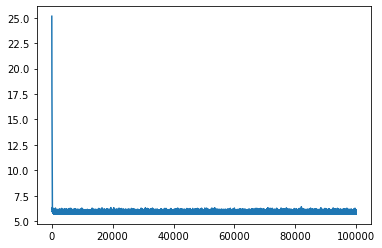

In [21]:
# 现在开始尝试adam
import matplotlib.pyplot as plt

dim = 18 * 9 + 1
w = np.zeros([dim, 1])
# 利用np.concatenate函数在原先的x上加上一个常数的feature=1,用一个全1的列向量，并使用axis=1来横向拼接
x = np.concatenate((np.ones([len(x_train_set), 1]), x_train_set), axis = 1).astype(float)
y = y_train_set

# 设定初始化的learning rate
learning_rate = 0.1
# 设定迭代次数iteration
iter_time = 100000

beta_1 = 0.5
beta_2 = 0.5
m = np.zeros([dim, 1])
v = np.zeros([dim, 1])
t = np.zeros([dim, 1])

eps = 0.0000000001
root_mean_square = np.empty([iter_time, 1])

# loss function = (x*w-y)^2, loss对w求导为 2*x*(x*w-y),即gradient
for t in range(iter_time):
    # 计算loss、gradient和Adagrad
    loss = np.sum(np.power(np.dot(x, w) - y, 2)) 
    gradient = 2 * np.dot(x.transpose(), np.dot(x, w) - y)
    m = beta_1 * m + (1 - beta_1) * gradient
    v = beta_2 * v + (1 - beta_2) * np.power(gradient, 2) 
    m_head = m / (1 - beta_1**(t+1))
    v_head = v / (1 - beta_2**(t+1))

    # 更新w,注意这里gradient、adagrad都是列向量，加减乘除的用法跟常数一样
    w = w - learning_rate * m_head / (np.sqrt(v_head) + eps)
    # 计算root mean square
    root_mean_square[t][0] = np.sqrt(np.sum(np.power(np.dot(x, w) - y, 2)) / len(x))
    print('root_mean_square_%-6d: '%t + str(root_mean_square[t][0]))

# save w
np.save('weight_adam.npy', w)
w

plt.plot(range(len(root_mean_square)),root_mean_square)
plt.show()

In [27]:
test_x = np.concatenate((np.ones([len(x_validation_set), 1]), x_validation_set), axis = 1)
test_y = y_validation_set

predict_y = np.dot(test_x, w)
rmse_test = np.sqrt(np.sum(np.power(predict_y - test_y, 2)) / len(test_y))
rmse_test

5.734260316437334

In [30]:
testdata = pd.read_csv('../data/test.csv', header = None, encoding = 'big5')
test_data = testdata.iloc[:, 2:]
test_data[test_data == 'NR'] = 0
test_data = test_data.to_numpy()
test_x = np.empty([240, 18 * 9], dtype = float)
for i in range(240):
    test_x[i, :] = test_data[18 * i : 18 * (i + 1), :].reshape(1,-1)
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)

w = np.load('weight_adam.npy')
predict_y = np.dot(test_x, w)
predict_y

/home/gehao/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([[  5.97723388],
       [ 17.21053963],
       [ 27.10828128],
       [  6.42614297],
       [ 27.57559051],
       [ 22.15662761],
       [ 24.2671354 ],
       [ 31.25787427],
       [ 18.05188965],
       [ 61.60009623],
       [ 11.93041205],
       [ 10.91540569],
       [ 64.46281399],
       [ 55.16508593],
       [ 21.69549628],
       [ 11.1087351 ],
       [ 33.76635698],
       [ 69.01451486],
       [ -0.56545574],
       [ 16.0085239 ],
       [ 41.55281408],
       [ 73.82827368],
       [  9.2437442 ],
       [ 19.35817198],
       [ 13.34444326],
       [ 39.6950414 ],
       [ 13.90968776],
       [ 66.58166783],
       [  6.45887061],
       [ 58.10343491],
       [ 26.00951817],
       [  9.28157651],
       [  1.64397435],
       [ 19.15806934],
       [ 30.33701814],
       [ 38.71638985],
       [ 43.09429167],
       [ 30.74967747],
       [ 43.56928247],
       [ 37.34537075],
       [ 10.00758868],
       [ 40.99111175],
       [ 32.120219  ],
       [ 52

In [32]:
import csv
with open('predict_adam.csv', mode = 'w', newline = '') as predict_file:
    csv_writer = csv.writer(predict_file)
    header = ['id', 'value']
    print(header)
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), predict_y[i][0]]
        csv_writer.writerow(row)
        print(row)

['id', 'value']
['id_0', 5.977233876158616]
['id_1', 17.21053962853025]
['id_2', 27.10828127719511]
['id_3', 6.426142972866956]
['id_4', 27.575590507509816]
['id_5', 22.156627606758494]
['id_6', 24.2671354006836]
['id_7', 31.25787427135068]
['id_8', 18.051889650349494]
['id_9', 61.60009623181663]
['id_10', 11.930412046871547]
['id_11', 10.915405691061803]
['id_12', 64.46281399157981]
['id_13', 55.16508593184729]
['id_14', 21.69549627796139]
['id_15', 11.108735099098842]
['id_16', 33.76635698107525]
['id_17', 69.01451485729565]
['id_18', -0.5654557400362514]
['id_19', 16.00852390376634]
['id_20', 41.5528140827092]
['id_21', 73.82827368327]
['id_22', 9.243744204383011]
['id_23', 19.358171979243576]
['id_24', 13.344443256130022]
['id_25', 39.695041398068376]
['id_26', 13.909687758559324]
['id_27', 66.58166783292948]
['id_28', 6.458870605118115]
['id_29', 58.10343490525708]
['id_30', 26.009518172130537]
['id_31', 9.281576509483124]
['id_32', 1.6439743542370002]
['id_33', 19.15806934142114]